<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [13]</a>'.</span>

In [1]:
"""from google.colab import drive
drive.mount('/content/gdrive/')

!pip install -q condacolab
import condacolab
condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision"""

"from google.colab import drive\ndrive.mount('/content/gdrive/')\n\n!pip install -q condacolab\nimport condacolab\ncondacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Matplotlib is building the font cache; this may take a moment.


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    paths.add_argument('--path_orig', type=str, default="../data/WW10seeds_rawnoHoles.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/WW10seeds_MSAnoHoles.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
 
    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization') 
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=80, help='number of tesselation cells') #6
    cpab.add_argument('--channels', type=int, default=80, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=40, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

#alphabets = ['-', 'A', 'D', 'G', 'I', 'L', 'R', 'S'] # for two long sequences
#alphabets = ['-', 'A', 'E', 'F', 'G', 'L', 'Q', 'R', 'S', 'T', 'V'] # ['-', 'L', 'Q', 'R'] #-> for 10 sequences case
#alphabets = ['-', 'A', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'S', 'T', 'V', 'W'] #-> for antiviral peptides
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_AntiviralPEP.pth'

#alphabets = ['-', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> WW 4 seqs
alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences
#alphabets = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences


#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW10NoSeed_22channels.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1_v2.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth'

logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug.pth'


print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)

'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore 
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=batches)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/home/kvr226/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Epoch 1/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1/2500: 100%|██████████| 10/10 [00:01<00:00,  6.54samples/s]

Epoch 1/2500: 100%|██████████| 10/10 [00:01<00:00,  6.54samples/s, loss=1.21e+3]

Epoch 1/2500: 100%|██████████| 10/10 [00:01<00:00,  6.21samples/s, loss=1.21e+3]

Epoch 2/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.29samples/s, loss=1.2e+3]

Epoch 2/2500: 100%|██████████| 10/10 [00:00<00:00, 140.90samples/s, loss=1.2e+3] 

Epoch 3/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 3/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.92samples/s, loss=1.2e+3]

Epoch 3/2500: 100%|██████████| 10/10 [00:00<00:00, 142.63samples/s, loss=1.2e+3] 

Epoch 4/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 4/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.94samples/s, loss=1.2e+3]

Epoch 4/2500: 100%|██████████| 10/10 [00:00<00:00, 145.36samples/s, loss=1.2e+3] 

Epoch 5/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 5/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.00samples/s, loss=1.19e+3]

Epoch 5/2500: 100%|██████████| 10/10 [00:00<00:00, 143.26samples/s, loss=1.19e+3] 

Epoch 6/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 6/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.16samples/s, loss=1.19e+3]

Epoch 6/2500: 100%|██████████| 10/10 [00:00<00:00, 145.55samples/s, loss=1.19e+3] 

Epoch 7/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 7/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.51samples/s, loss=1.17e+3]

Epoch 7/2500: 100%|██████████| 10/10 [00:00<00:00, 145.57samples/s, loss=1.17e+3] 

Epoch 8/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 8/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.17samples/s, loss=1.15e+3]

Epoch 8/2500: 100%|██████████| 10/10 [00:00<00:00, 146.44samples/s, loss=1.15e+3] 

Epoch 9/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 9/2500: 100%|██████████| 10/10 [00:00<00:00, 2061.18samples/s, loss=1.11e+3]

Epoch 9/2500: 100%|██████████| 10/10 [00:00<00:00, 142.13samples/s, loss=1.11e+3] 

Epoch 10/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 10/2500: 100%|██████████| 10/10 [00:00<00:00, 2004.83samples/s, loss=1.06e+3]

Epoch 10/2500: 100%|██████████| 10/10 [00:00<00:00, 143.63samples/s, loss=1.06e+3] 

Epoch 11/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 11/2500: 100%|██████████| 10/10 [00:00<00:00, 2088.48samples/s, loss=1.02e+3]

Epoch 11/2500: 100%|██████████| 10/10 [00:00<00:00, 146.42samples/s, loss=1.02e+3] 

Epoch 12/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 12/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.00samples/s, loss=1.01e+3]

Epoch 12/2500: 100%|██████████| 10/10 [00:00<00:00, 143.35samples/s, loss=1.01e+3] 

Epoch 13/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 13/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.57samples/s, loss=1.01e+3]

Epoch 13/2500: 100%|██████████| 10/10 [00:00<00:00, 144.48samples/s, loss=1.01e+3] 

Epoch 14/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 14/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.36samples/s, loss=1.01e+3]

Epoch 14/2500: 100%|██████████| 10/10 [00:00<00:00, 146.23samples/s, loss=1.01e+3] 

Epoch 15/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 15/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.80samples/s, loss=1.01e+3]

Epoch 15/2500: 100%|██████████| 10/10 [00:00<00:00, 145.54samples/s, loss=1.01e+3] 

Epoch 16/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 16/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.58samples/s, loss=1.01e+3]

Epoch 16/2500: 100%|██████████| 10/10 [00:00<00:00, 142.45samples/s, loss=1.01e+3] 

Epoch 17/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 17/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.23samples/s, loss=1.01e+3]

Epoch 17/2500: 100%|██████████| 10/10 [00:00<00:00, 143.31samples/s, loss=1.01e+3] 

Epoch 18/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 18/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.59samples/s, loss=1.01e+3]

Epoch 18/2500: 100%|██████████| 10/10 [00:00<00:00, 142.41samples/s, loss=1.01e+3] 

Epoch 19/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 19/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.06samples/s, loss=1.02e+3]

Epoch 19/2500: 100%|██████████| 10/10 [00:00<00:00, 145.92samples/s, loss=1.02e+3] 

Epoch 20/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 20/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.80samples/s, loss=1.02e+3]

Epoch 20/2500: 100%|██████████| 10/10 [00:00<00:00, 146.46samples/s, loss=1.02e+3] 

Epoch 21/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 21/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.31samples/s, loss=1.02e+3]

Epoch 21/2500: 100%|██████████| 10/10 [00:00<00:00, 146.29samples/s, loss=1.02e+3] 

Epoch 22/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 22/2500: 100%|██████████| 10/10 [00:00<00:00, 1988.29samples/s, loss=1.02e+3]

Epoch 22/2500: 100%|██████████| 10/10 [00:00<00:00, 145.78samples/s, loss=1.02e+3] 

Epoch 23/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 23/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.37samples/s, loss=1.02e+3]

Epoch 23/2500: 100%|██████████| 10/10 [00:00<00:00, 144.61samples/s, loss=1.02e+3] 

Epoch 24/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 24/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.67samples/s, loss=1.02e+3]

Epoch 24/2500: 100%|██████████| 10/10 [00:00<00:00, 140.16samples/s, loss=1.02e+3] 

Epoch 25/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 25/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.58samples/s, loss=1.02e+3]

Epoch 25/2500: 100%|██████████| 10/10 [00:00<00:00, 143.93samples/s, loss=1.02e+3] 

Epoch 26/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 26/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.46samples/s, loss=1.02e+3]

Epoch 26/2500: 100%|██████████| 10/10 [00:00<00:00, 146.33samples/s, loss=1.02e+3] 

Epoch 27/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 27/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.20samples/s, loss=1.02e+3]

Epoch 27/2500: 100%|██████████| 10/10 [00:00<00:00, 146.95samples/s, loss=1.02e+3] 

Epoch 28/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 28/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.31samples/s, loss=1.02e+3]

Epoch 28/2500: 100%|██████████| 10/10 [00:00<00:00, 146.45samples/s, loss=1.02e+3] 

Epoch 29/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 29/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.32samples/s, loss=1.02e+3]

Epoch 29/2500: 100%|██████████| 10/10 [00:00<00:00, 145.04samples/s, loss=1.02e+3] 

Epoch 30/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 30/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.44samples/s, loss=1.01e+3]

Epoch 30/2500: 100%|██████████| 10/10 [00:00<00:00, 144.31samples/s, loss=1.01e+3] 

Epoch 31/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 31/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.64samples/s, loss=1.01e+3]

Epoch 31/2500: 100%|██████████| 10/10 [00:00<00:00, 142.06samples/s, loss=1.01e+3] 

Epoch 32/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 32/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.11samples/s, loss=1.01e+3]

Epoch 32/2500: 100%|██████████| 10/10 [00:00<00:00, 142.91samples/s, loss=1.01e+3] 

Epoch 33/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 33/2500: 100%|██████████| 10/10 [00:00<00:00, 2073.31samples/s, loss=1.01e+3]

Epoch 33/2500: 100%|██████████| 10/10 [00:00<00:00, 143.63samples/s, loss=1.01e+3] 

Epoch 34/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 34/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.11samples/s, loss=1.01e+3]

Epoch 34/2500: 100%|██████████| 10/10 [00:00<00:00, 149.02samples/s, loss=1.01e+3] 

Epoch 35/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 35/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.05samples/s, loss=1.01e+3]

Epoch 35/2500: 100%|██████████| 10/10 [00:00<00:00, 149.69samples/s, loss=1.01e+3] 

Epoch 36/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 36/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.65samples/s, loss=1.01e+3]

Epoch 36/2500: 100%|██████████| 10/10 [00:00<00:00, 148.86samples/s, loss=1.01e+3] 

Epoch 37/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 37/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.40samples/s, loss=1.01e+3]

Epoch 37/2500: 100%|██████████| 10/10 [00:00<00:00, 151.52samples/s, loss=1.01e+3] 

Epoch 38/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 38/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.43samples/s, loss=1.01e+3]

Epoch 38/2500: 100%|██████████| 10/10 [00:00<00:00, 147.40samples/s, loss=1.01e+3] 

Epoch 39/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 39/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.90samples/s, loss=1.01e+3]

Epoch 39/2500: 100%|██████████| 10/10 [00:00<00:00, 145.71samples/s, loss=1.01e+3] 

Epoch 40/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 40/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.19samples/s, loss=1.01e+3]

Epoch 40/2500: 100%|██████████| 10/10 [00:00<00:00, 145.29samples/s, loss=1.01e+3] 

Epoch 41/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 41/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.50samples/s, loss=1.01e+3]

Epoch 41/2500: 100%|██████████| 10/10 [00:00<00:00, 145.34samples/s, loss=1.01e+3] 

Epoch 42/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 42/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.41samples/s, loss=1.01e+3]

Epoch 42/2500: 100%|██████████| 10/10 [00:00<00:00, 143.63samples/s, loss=1.01e+3] 

Epoch 43/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 43/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.00samples/s, loss=1.01e+3]

Epoch 43/2500: 100%|██████████| 10/10 [00:00<00:00, 144.10samples/s, loss=1.01e+3] 

Epoch 44/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 44/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.90samples/s, loss=1.01e+3]

Epoch 44/2500: 100%|██████████| 10/10 [00:00<00:00, 145.91samples/s, loss=1.01e+3] 

Epoch 45/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 45/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.80samples/s, loss=1.01e+3]

Epoch 45/2500: 100%|██████████| 10/10 [00:00<00:00, 146.46samples/s, loss=1.01e+3] 

Epoch 46/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 46/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.04samples/s, loss=1.01e+3]

Epoch 46/2500: 100%|██████████| 10/10 [00:00<00:00, 140.95samples/s, loss=1.01e+3] 

Epoch 47/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 47/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.15samples/s, loss=1.01e+3]

Epoch 47/2500: 100%|██████████| 10/10 [00:00<00:00, 142.81samples/s, loss=1.01e+3] 

Epoch 48/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 48/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.14samples/s, loss=1.01e+3]

Epoch 48/2500: 100%|██████████| 10/10 [00:00<00:00, 141.97samples/s, loss=1.01e+3] 

Epoch 49/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 49/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.62samples/s, loss=1.01e+3]

Epoch 49/2500: 100%|██████████| 10/10 [00:00<00:00, 149.50samples/s, loss=1.01e+3] 

Epoch 50/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 50/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.11samples/s, loss=1.01e+3]

Epoch 50/2500: 100%|██████████| 10/10 [00:00<00:00, 150.24samples/s, loss=1.01e+3] 

Epoch 51/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 51/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.78samples/s, loss=1.01e+3]

Epoch 51/2500: 100%|██████████| 10/10 [00:00<00:00, 149.87samples/s, loss=1.01e+3] 

Epoch 52/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 52/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.16samples/s, loss=1.01e+3]

Epoch 52/2500: 100%|██████████| 10/10 [00:00<00:00, 151.02samples/s, loss=1.01e+3] 

Epoch 53/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 53/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.38samples/s, loss=1.01e+3]

Epoch 53/2500: 100%|██████████| 10/10 [00:00<00:00, 147.90samples/s, loss=1.01e+3] 

Epoch 54/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 54/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.98samples/s, loss=1.01e+3]

Epoch 54/2500: 100%|██████████| 10/10 [00:00<00:00, 142.40samples/s, loss=1.01e+3] 

Epoch 55/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 55/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.13samples/s, loss=1.01e+3]

Epoch 55/2500: 100%|██████████| 10/10 [00:00<00:00, 144.63samples/s, loss=1.01e+3] 

Epoch 56/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 56/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.90samples/s, loss=1.01e+3]

Epoch 56/2500: 100%|██████████| 10/10 [00:00<00:00, 144.36samples/s, loss=1.01e+3] 

Epoch 57/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 57/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.71samples/s, loss=1.01e+3]

Epoch 57/2500: 100%|██████████| 10/10 [00:00<00:00, 145.48samples/s, loss=1.01e+3] 

Epoch 58/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 58/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.10samples/s, loss=1.01e+3]

Epoch 58/2500: 100%|██████████| 10/10 [00:00<00:00, 145.80samples/s, loss=1.01e+3] 

Epoch 59/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 59/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.26samples/s, loss=1.01e+3]

Epoch 59/2500: 100%|██████████| 10/10 [00:00<00:00, 144.65samples/s, loss=1.01e+3] 

Epoch 60/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 60/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.20samples/s, loss=1.01e+3]

Epoch 60/2500: 100%|██████████| 10/10 [00:00<00:00, 133.27samples/s, loss=1.01e+3] 

Epoch 61/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 61/2500: 100%|██████████| 10/10 [00:00<00:00, 1993.59samples/s, loss=1.01e+3]

Epoch 61/2500: 100%|██████████| 10/10 [00:00<00:00, 134.75samples/s, loss=1.01e+3] 

Epoch 62/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 62/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.72samples/s, loss=1.01e+3]

Epoch 62/2500: 100%|██████████| 10/10 [00:00<00:00, 145.71samples/s, loss=1.01e+3] 

Epoch 63/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 63/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.28samples/s, loss=1.01e+3]

Epoch 63/2500: 100%|██████████| 10/10 [00:00<00:00, 146.33samples/s, loss=1.01e+3] 

Epoch 64/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 64/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.50samples/s, loss=1.01e+3]

Epoch 64/2500: 100%|██████████| 10/10 [00:00<00:00, 145.76samples/s, loss=1.01e+3] 

Epoch 65/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 65/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.60samples/s, loss=1.01e+3]

Epoch 65/2500: 100%|██████████| 10/10 [00:00<00:00, 145.40samples/s, loss=1.01e+3] 

Epoch 66/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 66/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.70samples/s, loss=1.01e+3]

Epoch 66/2500: 100%|██████████| 10/10 [00:00<00:00, 145.00samples/s, loss=1.01e+3] 

Epoch 67/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 67/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.21samples/s, loss=1.01e+3]

Epoch 67/2500: 100%|██████████| 10/10 [00:00<00:00, 145.22samples/s, loss=1.01e+3] 

Epoch 68/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 68/2500: 100%|██████████| 10/10 [00:00<00:00, 2062.50samples/s, loss=1.01e+3]

Epoch 68/2500: 100%|██████████| 10/10 [00:00<00:00, 144.84samples/s, loss=1.01e+3] 

Epoch 69/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 69/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.20samples/s, loss=1.01e+3]

Epoch 69/2500: 100%|██████████| 10/10 [00:00<00:00, 144.24samples/s, loss=1.01e+3] 

Epoch 70/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 70/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.45samples/s, loss=1.01e+3]

Epoch 70/2500: 100%|██████████| 10/10 [00:00<00:00, 147.31samples/s, loss=1.01e+3] 

Epoch 71/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 71/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.84samples/s, loss=1.01e+3]

Epoch 71/2500: 100%|██████████| 10/10 [00:00<00:00, 148.45samples/s, loss=1.01e+3] 

Epoch 72/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 72/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.72samples/s, loss=1.01e+3]

Epoch 72/2500: 100%|██████████| 10/10 [00:00<00:00, 148.09samples/s, loss=1.01e+3] 

Epoch 73/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 73/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.00samples/s, loss=1.01e+3]

Epoch 73/2500: 100%|██████████| 10/10 [00:00<00:00, 145.38samples/s, loss=1.01e+3] 

Epoch 74/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 74/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.02samples/s, loss=1.01e+3]

Epoch 74/2500: 100%|██████████| 10/10 [00:00<00:00, 146.33samples/s, loss=1.01e+3] 

Epoch 75/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 75/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.33samples/s, loss=1.01e+3]

Epoch 75/2500: 100%|██████████| 10/10 [00:00<00:00, 145.65samples/s, loss=1.01e+3] 

Epoch 76/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 76/2500: 100%|██████████| 10/10 [00:00<00:00, 2068.71samples/s, loss=1.01e+3]

Epoch 76/2500: 100%|██████████| 10/10 [00:00<00:00, 141.98samples/s, loss=1.01e+3] 

Epoch 77/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 77/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.73samples/s, loss=1.01e+3]

Epoch 77/2500: 100%|██████████| 10/10 [00:00<00:00, 142.61samples/s, loss=1.01e+3] 

Epoch 78/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 78/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.21samples/s, loss=1e+3]

Epoch 78/2500: 100%|██████████| 10/10 [00:00<00:00, 144.77samples/s, loss=1e+3] 

Epoch 79/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 79/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.77samples/s, loss=1.01e+3]

Epoch 79/2500: 100%|██████████| 10/10 [00:00<00:00, 146.22samples/s, loss=1.01e+3] 

Epoch 80/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 80/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.00samples/s, loss=1.01e+3]

Epoch 80/2500: 100%|██████████| 10/10 [00:00<00:00, 146.84samples/s, loss=1.01e+3] 

Epoch 81/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 81/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.73samples/s, loss=1e+3]

Epoch 81/2500: 100%|██████████| 10/10 [00:00<00:00, 145.06samples/s, loss=1e+3] 

Epoch 82/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 82/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.93samples/s, loss=1e+3]

Epoch 82/2500: 100%|██████████| 10/10 [00:00<00:00, 148.16samples/s, loss=1e+3] 

Epoch 83/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 83/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.20samples/s, loss=1e+3]

Epoch 83/2500: 100%|██████████| 10/10 [00:00<00:00, 144.72samples/s, loss=1e+3] 

Epoch 84/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 84/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.90samples/s, loss=1e+3]

Epoch 84/2500: 100%|██████████| 10/10 [00:00<00:00, 146.87samples/s, loss=1e+3] 

Epoch 85/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 85/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.10samples/s, loss=1e+3]

Epoch 85/2500: 100%|██████████| 10/10 [00:00<00:00, 147.02samples/s, loss=1e+3] 

Epoch 86/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 86/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.00samples/s, loss=1e+3]

Epoch 86/2500: 100%|██████████| 10/10 [00:00<00:00, 147.55samples/s, loss=1e+3] 

Epoch 87/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 87/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.91samples/s, loss=999]

Epoch 87/2500: 100%|██████████| 10/10 [00:00<00:00, 147.45samples/s, loss=999] 

Epoch 88/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 88/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.87samples/s, loss=999]

Epoch 88/2500: 100%|██████████| 10/10 [00:00<00:00, 145.40samples/s, loss=999] 

Epoch 89/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 89/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.62samples/s, loss=997]

Epoch 89/2500: 100%|██████████| 10/10 [00:00<00:00, 145.92samples/s, loss=997] 

Epoch 90/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 90/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.05samples/s, loss=998]

Epoch 90/2500: 100%|██████████| 10/10 [00:00<00:00, 144.89samples/s, loss=998] 

Epoch 91/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 91/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.60samples/s, loss=997]

Epoch 91/2500: 100%|██████████| 10/10 [00:00<00:00, 141.15samples/s, loss=997] 

Epoch 92/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 92/2500: 100%|██████████| 10/10 [00:00<00:00, 1998.62samples/s, loss=997]

Epoch 92/2500: 100%|██████████| 10/10 [00:00<00:00, 146.61samples/s, loss=997] 

Epoch 93/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 93/2500: 100%|██████████| 10/10 [00:00<00:00, 2001.96samples/s, loss=997]

Epoch 93/2500: 100%|██████████| 10/10 [00:00<00:00, 150.37samples/s, loss=997] 

Epoch 94/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 94/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.97samples/s, loss=997]

Epoch 94/2500: 100%|██████████| 10/10 [00:00<00:00, 149.25samples/s, loss=997] 

Epoch 95/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 95/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.41samples/s, loss=997]

Epoch 95/2500: 100%|██████████| 10/10 [00:00<00:00, 150.62samples/s, loss=997] 

Epoch 96/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 96/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.20samples/s, loss=996]

Epoch 96/2500: 100%|██████████| 10/10 [00:00<00:00, 151.67samples/s, loss=996] 

Epoch 97/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 97/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.31samples/s, loss=997]

Epoch 97/2500: 100%|██████████| 10/10 [00:00<00:00, 136.54samples/s, loss=997] 

Epoch 98/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 98/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.10samples/s, loss=996]

Epoch 98/2500: 100%|██████████| 10/10 [00:00<00:00, 141.77samples/s, loss=996] 

Epoch 99/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 99/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.02samples/s, loss=996]

Epoch 99/2500: 100%|██████████| 10/10 [00:00<00:00, 146.40samples/s, loss=996] 

Epoch 100/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 100/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.72samples/s, loss=995]

Epoch 100/2500: 100%|██████████| 10/10 [00:00<00:00, 149.82samples/s, loss=995] 

Epoch 101/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 101/2500: 100%|██████████| 10/10 [00:00<00:00, 2061.99samples/s, loss=995]

Epoch 101/2500: 100%|██████████| 10/10 [00:00<00:00, 152.39samples/s, loss=995] 

Epoch 102/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 102/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.07samples/s, loss=994]

Epoch 102/2500: 100%|██████████| 10/10 [00:00<00:00, 150.45samples/s, loss=994] 

Epoch 103/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 103/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.91samples/s, loss=996]

Epoch 103/2500: 100%|██████████| 10/10 [00:00<00:00, 151.97samples/s, loss=996] 

Epoch 104/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 104/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.03samples/s, loss=994]

Epoch 104/2500: 100%|██████████| 10/10 [00:00<00:00, 140.97samples/s, loss=994] 

Epoch 105/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 105/2500: 100%|██████████| 10/10 [00:00<00:00, 1973.98samples/s, loss=995]

Epoch 105/2500: 100%|██████████| 10/10 [00:00<00:00, 142.56samples/s, loss=995] 

Epoch 106/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 106/2500: 100%|██████████| 10/10 [00:00<00:00, 2062.40samples/s, loss=994]

Epoch 106/2500: 100%|██████████| 10/10 [00:00<00:00, 143.43samples/s, loss=994] 

Epoch 107/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 107/2500: 100%|██████████| 10/10 [00:00<00:00, 2054.92samples/s, loss=994]

Epoch 107/2500: 100%|██████████| 10/10 [00:00<00:00, 145.93samples/s, loss=994] 

Epoch 108/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 108/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.67samples/s, loss=994]

Epoch 108/2500: 100%|██████████| 10/10 [00:00<00:00, 147.96samples/s, loss=994] 

Epoch 109/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 109/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.90samples/s, loss=993]

Epoch 109/2500: 100%|██████████| 10/10 [00:00<00:00, 149.68samples/s, loss=993] 

Epoch 110/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 110/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.61samples/s, loss=993]

Epoch 110/2500: 100%|██████████| 10/10 [00:00<00:00, 149.96samples/s, loss=993] 

Epoch 111/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 111/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.62samples/s, loss=992]

Epoch 111/2500: 100%|██████████| 10/10 [00:00<00:00, 147.05samples/s, loss=992] 

Epoch 112/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 112/2500: 100%|██████████| 10/10 [00:00<00:00, 1907.20samples/s, loss=992]

Epoch 112/2500: 100%|██████████| 10/10 [00:00<00:00, 144.22samples/s, loss=992] 

Epoch 113/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 113/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.43samples/s, loss=992]

Epoch 113/2500: 100%|██████████| 10/10 [00:00<00:00, 141.13samples/s, loss=992] 

Epoch 114/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 114/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.72samples/s, loss=993]

Epoch 114/2500: 100%|██████████| 10/10 [00:00<00:00, 143.23samples/s, loss=993] 

Epoch 115/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 115/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.83samples/s, loss=992]

Epoch 115/2500: 100%|██████████| 10/10 [00:00<00:00, 143.58samples/s, loss=992] 

Epoch 116/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 116/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.23samples/s, loss=992]

Epoch 116/2500: 100%|██████████| 10/10 [00:00<00:00, 145.34samples/s, loss=992] 

Epoch 117/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 117/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.82samples/s, loss=991]

Epoch 117/2500: 100%|██████████| 10/10 [00:00<00:00, 144.93samples/s, loss=991] 

Epoch 118/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 118/2500: 100%|██████████| 10/10 [00:00<00:00, 2066.77samples/s, loss=990]

Epoch 118/2500: 100%|██████████| 10/10 [00:00<00:00, 144.71samples/s, loss=990] 

Epoch 119/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 119/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.72samples/s, loss=990]

Epoch 119/2500: 100%|██████████| 10/10 [00:00<00:00, 144.65samples/s, loss=990] 

Epoch 120/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 120/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.70samples/s, loss=992]

Epoch 120/2500: 100%|██████████| 10/10 [00:00<00:00, 143.50samples/s, loss=992] 

Epoch 121/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 121/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.43samples/s, loss=991]

Epoch 121/2500: 100%|██████████| 10/10 [00:00<00:00, 140.54samples/s, loss=991] 

Epoch 122/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 122/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.26samples/s, loss=989]

Epoch 122/2500: 100%|██████████| 10/10 [00:00<00:00, 143.30samples/s, loss=989] 

Epoch 123/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 123/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.00samples/s, loss=990]

Epoch 123/2500: 100%|██████████| 10/10 [00:00<00:00, 144.43samples/s, loss=990] 

Epoch 124/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 124/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.26samples/s, loss=990]

Epoch 124/2500: 100%|██████████| 10/10 [00:00<00:00, 146.51samples/s, loss=990] 

Epoch 125/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 125/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.40samples/s, loss=990]

Epoch 125/2500: 100%|██████████| 10/10 [00:00<00:00, 145.63samples/s, loss=990] 

Epoch 126/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 126/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.24samples/s, loss=989]

Epoch 126/2500: 100%|██████████| 10/10 [00:00<00:00, 146.20samples/s, loss=989] 

Epoch 127/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 127/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.90samples/s, loss=989]

Epoch 127/2500: 100%|██████████| 10/10 [00:00<00:00, 145.14samples/s, loss=989] 

Epoch 128/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 128/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.01samples/s, loss=990]

Epoch 128/2500: 100%|██████████| 10/10 [00:00<00:00, 146.01samples/s, loss=990] 

Epoch 129/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 129/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.55samples/s, loss=993]

Epoch 129/2500: 100%|██████████| 10/10 [00:00<00:00, 146.17samples/s, loss=993] 

Epoch 130/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 130/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.21samples/s, loss=988]

Epoch 130/2500: 100%|██████████| 10/10 [00:00<00:00, 146.24samples/s, loss=988] 

Epoch 131/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 131/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.37samples/s, loss=990]

Epoch 131/2500: 100%|██████████| 10/10 [00:00<00:00, 146.09samples/s, loss=990] 

Epoch 132/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 132/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.80samples/s, loss=987]

Epoch 132/2500: 100%|██████████| 10/10 [00:00<00:00, 146.80samples/s, loss=987] 

Epoch 133/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 133/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.54samples/s, loss=989]

Epoch 133/2500: 100%|██████████| 10/10 [00:00<00:00, 149.43samples/s, loss=989] 

Epoch 134/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 134/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.11samples/s, loss=989]

Epoch 134/2500: 100%|██████████| 10/10 [00:00<00:00, 146.04samples/s, loss=989] 

Epoch 135/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 135/2500: 100%|██████████| 10/10 [00:00<00:00, 1883.90samples/s, loss=987]

Epoch 135/2500: 100%|██████████| 10/10 [00:00<00:00, 141.84samples/s, loss=987] 

Epoch 136/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 136/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.10samples/s, loss=988]

Epoch 136/2500: 100%|██████████| 10/10 [00:00<00:00, 143.12samples/s, loss=988] 

Epoch 137/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 137/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.36samples/s, loss=986]

Epoch 137/2500: 100%|██████████| 10/10 [00:00<00:00, 147.97samples/s, loss=986] 

Epoch 138/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 138/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.40samples/s, loss=986]

Epoch 138/2500: 100%|██████████| 10/10 [00:00<00:00, 151.13samples/s, loss=986] 

Epoch 139/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 139/2500: 100%|██████████| 10/10 [00:00<00:00, 2002.34samples/s, loss=986]

Epoch 139/2500: 100%|██████████| 10/10 [00:00<00:00, 147.89samples/s, loss=986] 

Epoch 140/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 140/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.14samples/s, loss=985]

Epoch 140/2500: 100%|██████████| 10/10 [00:00<00:00, 151.18samples/s, loss=985] 

Epoch 141/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 141/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.26samples/s, loss=985]

Epoch 141/2500: 100%|██████████| 10/10 [00:00<00:00, 151.51samples/s, loss=985] 

Epoch 142/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 142/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.72samples/s, loss=985]

Epoch 142/2500: 100%|██████████| 10/10 [00:00<00:00, 148.98samples/s, loss=985] 

Epoch 143/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 143/2500: 100%|██████████| 10/10 [00:00<00:00, 1990.46samples/s, loss=985]

Epoch 143/2500: 100%|██████████| 10/10 [00:00<00:00, 143.90samples/s, loss=985] 

Epoch 144/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 144/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.55samples/s, loss=985]

Epoch 144/2500: 100%|██████████| 10/10 [00:00<00:00, 146.06samples/s, loss=985] 

Epoch 145/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 145/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.41samples/s, loss=986]

Epoch 145/2500: 100%|██████████| 10/10 [00:00<00:00, 146.56samples/s, loss=986] 

Epoch 146/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 146/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.89samples/s, loss=984]

Epoch 146/2500: 100%|██████████| 10/10 [00:00<00:00, 145.24samples/s, loss=984] 

Epoch 147/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 147/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.40samples/s, loss=984]

Epoch 147/2500: 100%|██████████| 10/10 [00:00<00:00, 144.41samples/s, loss=984] 

Epoch 148/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 148/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.53samples/s, loss=984]

Epoch 148/2500: 100%|██████████| 10/10 [00:00<00:00, 149.73samples/s, loss=984] 

Epoch 149/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 149/2500: 100%|██████████| 10/10 [00:00<00:00, 2004.25samples/s, loss=984]

Epoch 149/2500: 100%|██████████| 10/10 [00:00<00:00, 148.41samples/s, loss=984] 

Epoch 150/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 150/2500: 100%|██████████| 10/10 [00:00<00:00, 1985.47samples/s, loss=984]

Epoch 150/2500: 100%|██████████| 10/10 [00:00<00:00, 145.78samples/s, loss=984] 

Epoch 151/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 151/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.50samples/s, loss=984]

Epoch 151/2500: 100%|██████████| 10/10 [00:00<00:00, 145.04samples/s, loss=984] 

Epoch 152/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 152/2500: 100%|██████████| 10/10 [00:00<00:00, 1994.53samples/s, loss=983]

Epoch 152/2500: 100%|██████████| 10/10 [00:00<00:00, 144.26samples/s, loss=983] 

Epoch 153/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 153/2500: 100%|██████████| 10/10 [00:00<00:00, 2089.00samples/s, loss=984]

Epoch 153/2500: 100%|██████████| 10/10 [00:00<00:00, 147.36samples/s, loss=984] 

Epoch 154/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 154/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.51samples/s, loss=983]

Epoch 154/2500: 100%|██████████| 10/10 [00:00<00:00, 149.54samples/s, loss=983] 

Epoch 155/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 155/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.13samples/s, loss=983]

Epoch 155/2500: 100%|██████████| 10/10 [00:00<00:00, 145.77samples/s, loss=983] 

Epoch 156/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 156/2500: 100%|██████████| 10/10 [00:00<00:00, 2006.75samples/s, loss=983]

Epoch 156/2500: 100%|██████████| 10/10 [00:00<00:00, 146.03samples/s, loss=983] 

Epoch 157/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 157/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.88samples/s, loss=982]

Epoch 157/2500: 100%|██████████| 10/10 [00:00<00:00, 145.64samples/s, loss=982] 

Epoch 158/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 158/2500: 100%|██████████| 10/10 [00:00<00:00, 2001.67samples/s, loss=983]

Epoch 158/2500: 100%|██████████| 10/10 [00:00<00:00, 144.86samples/s, loss=983] 

Epoch 159/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 159/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.30samples/s, loss=982]

Epoch 159/2500: 100%|██████████| 10/10 [00:00<00:00, 144.25samples/s, loss=982] 

Epoch 160/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 160/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.10samples/s, loss=982]

Epoch 160/2500: 100%|██████████| 10/10 [00:00<00:00, 146.00samples/s, loss=982] 

Epoch 161/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 161/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.18samples/s, loss=982]

Epoch 161/2500: 100%|██████████| 10/10 [00:00<00:00, 145.39samples/s, loss=982] 

Epoch 162/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 162/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.12samples/s, loss=982]

Epoch 162/2500: 100%|██████████| 10/10 [00:00<00:00, 148.31samples/s, loss=982] 

Epoch 163/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 163/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.81samples/s, loss=981]

Epoch 163/2500: 100%|██████████| 10/10 [00:00<00:00, 148.17samples/s, loss=981] 

Epoch 164/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 164/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.70samples/s, loss=981]

Epoch 164/2500: 100%|██████████| 10/10 [00:00<00:00, 145.49samples/s, loss=981] 

Epoch 165/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 165/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.51samples/s, loss=982]

Epoch 165/2500: 100%|██████████| 10/10 [00:00<00:00, 142.24samples/s, loss=982] 

Epoch 166/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 166/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.41samples/s, loss=981]

Epoch 166/2500: 100%|██████████| 10/10 [00:00<00:00, 144.72samples/s, loss=981] 

Epoch 167/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 167/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.96samples/s, loss=981]

Epoch 167/2500: 100%|██████████| 10/10 [00:00<00:00, 148.80samples/s, loss=981] 

Epoch 168/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 168/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.33samples/s, loss=981]

Epoch 168/2500: 100%|██████████| 10/10 [00:00<00:00, 149.53samples/s, loss=981] 

Epoch 169/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 169/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.73samples/s, loss=981]

Epoch 169/2500: 100%|██████████| 10/10 [00:00<00:00, 148.11samples/s, loss=981] 

Epoch 170/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 170/2500: 100%|██████████| 10/10 [00:00<00:00, 1977.70samples/s, loss=980]

Epoch 170/2500: 100%|██████████| 10/10 [00:00<00:00, 148.35samples/s, loss=980] 

Epoch 171/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 171/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.52samples/s, loss=980]

Epoch 171/2500: 100%|██████████| 10/10 [00:00<00:00, 146.07samples/s, loss=980] 

Epoch 172/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 172/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.11samples/s, loss=979]

Epoch 172/2500: 100%|██████████| 10/10 [00:00<00:00, 149.09samples/s, loss=979] 

Epoch 173/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 173/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.41samples/s, loss=979]

Epoch 173/2500: 100%|██████████| 10/10 [00:00<00:00, 143.97samples/s, loss=979] 

Epoch 174/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 174/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.34samples/s, loss=979]

Epoch 174/2500: 100%|██████████| 10/10 [00:00<00:00, 144.48samples/s, loss=979] 

Epoch 175/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 175/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.14samples/s, loss=979]

Epoch 175/2500: 100%|██████████| 10/10 [00:00<00:00, 145.11samples/s, loss=979] 

Epoch 176/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 176/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.79samples/s, loss=979]

Epoch 176/2500: 100%|██████████| 10/10 [00:00<00:00, 146.79samples/s, loss=979] 

Epoch 177/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 177/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.91samples/s, loss=979]

Epoch 177/2500: 100%|██████████| 10/10 [00:00<00:00, 149.62samples/s, loss=979] 

Epoch 178/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 178/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.01samples/s, loss=978]

Epoch 178/2500: 100%|██████████| 10/10 [00:00<00:00, 146.74samples/s, loss=978] 

Epoch 179/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 179/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.35samples/s, loss=978]

Epoch 179/2500: 100%|██████████| 10/10 [00:00<00:00, 146.02samples/s, loss=978] 

Epoch 180/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 180/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.95samples/s, loss=978]

Epoch 180/2500: 100%|██████████| 10/10 [00:00<00:00, 141.56samples/s, loss=978] 

Epoch 181/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 181/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.25samples/s, loss=977]

Epoch 181/2500: 100%|██████████| 10/10 [00:00<00:00, 147.21samples/s, loss=977] 

Epoch 182/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 182/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.14samples/s, loss=977]

Epoch 182/2500: 100%|██████████| 10/10 [00:00<00:00, 146.29samples/s, loss=977] 

Epoch 183/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 183/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.30samples/s, loss=976]

Epoch 183/2500: 100%|██████████| 10/10 [00:00<00:00, 148.05samples/s, loss=976] 

Epoch 184/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 184/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.81samples/s, loss=976]

Epoch 184/2500: 100%|██████████| 10/10 [00:00<00:00, 147.41samples/s, loss=976] 

Epoch 185/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 185/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.14samples/s, loss=976]

Epoch 185/2500: 100%|██████████| 10/10 [00:00<00:00, 145.88samples/s, loss=976] 

Epoch 186/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 186/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.34samples/s, loss=977]

Epoch 186/2500: 100%|██████████| 10/10 [00:00<00:00, 150.03samples/s, loss=977] 

Epoch 187/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 187/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.70samples/s, loss=976]

Epoch 187/2500: 100%|██████████| 10/10 [00:00<00:00, 148.87samples/s, loss=976] 

Epoch 188/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 188/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.40samples/s, loss=976]

Epoch 188/2500: 100%|██████████| 10/10 [00:00<00:00, 142.57samples/s, loss=976] 

Epoch 189/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 189/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.54samples/s, loss=975]

Epoch 189/2500: 100%|██████████| 10/10 [00:00<00:00, 143.72samples/s, loss=975] 

Epoch 190/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 190/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.92samples/s, loss=975]

Epoch 190/2500: 100%|██████████| 10/10 [00:00<00:00, 146.31samples/s, loss=975] 

Epoch 191/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 191/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.76samples/s, loss=975]

Epoch 191/2500: 100%|██████████| 10/10 [00:00<00:00, 149.75samples/s, loss=975] 

Epoch 192/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 192/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.61samples/s, loss=975]

Epoch 192/2500: 100%|██████████| 10/10 [00:00<00:00, 147.17samples/s, loss=975] 

Epoch 193/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 193/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.66samples/s, loss=975]

Epoch 193/2500: 100%|██████████| 10/10 [00:00<00:00, 145.98samples/s, loss=975] 

Epoch 194/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 194/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.08samples/s, loss=975]

Epoch 194/2500: 100%|██████████| 10/10 [00:00<00:00, 145.10samples/s, loss=975] 

Epoch 195/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 195/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.38samples/s, loss=975]

Epoch 195/2500: 100%|██████████| 10/10 [00:00<00:00, 148.11samples/s, loss=975] 

Epoch 196/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 196/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.22samples/s, loss=975]

Epoch 196/2500: 100%|██████████| 10/10 [00:00<00:00, 148.87samples/s, loss=975] 

Epoch 197/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 197/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.83samples/s, loss=974]

Epoch 197/2500: 100%|██████████| 10/10 [00:00<00:00, 147.43samples/s, loss=974] 

Epoch 198/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 198/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.27samples/s, loss=974]

Epoch 198/2500: 100%|██████████| 10/10 [00:00<00:00, 149.93samples/s, loss=974] 

Epoch 199/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 199/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.10samples/s, loss=974]

Epoch 199/2500: 100%|██████████| 10/10 [00:00<00:00, 152.00samples/s, loss=974] 

Epoch 200/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 200/2500: 100%|██████████| 10/10 [00:00<00:00, 1985.09samples/s, loss=974]

Epoch 200/2500: 100%|██████████| 10/10 [00:00<00:00, 149.05samples/s, loss=974] 

Epoch 201/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 201/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.51samples/s, loss=974]

Epoch 201/2500: 100%|██████████| 10/10 [00:00<00:00, 148.34samples/s, loss=974] 

Epoch 202/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 202/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.18samples/s, loss=974]

Epoch 202/2500: 100%|██████████| 10/10 [00:00<00:00, 149.58samples/s, loss=974] 

Epoch 203/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 203/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.70samples/s, loss=974]

Epoch 203/2500: 100%|██████████| 10/10 [00:00<00:00, 147.39samples/s, loss=974] 

Epoch 204/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 204/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.25samples/s, loss=974]

Epoch 204/2500: 100%|██████████| 10/10 [00:00<00:00, 148.47samples/s, loss=974] 

Epoch 205/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 205/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.12samples/s, loss=974]

Epoch 205/2500: 100%|██████████| 10/10 [00:00<00:00, 149.78samples/s, loss=974] 

Epoch 206/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 206/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.10samples/s, loss=974]

Epoch 206/2500: 100%|██████████| 10/10 [00:00<00:00, 150.23samples/s, loss=974] 

Epoch 207/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 207/2500: 100%|██████████| 10/10 [00:00<00:00, 1969.06samples/s, loss=974]

Epoch 207/2500: 100%|██████████| 10/10 [00:00<00:00, 149.25samples/s, loss=974] 

Epoch 208/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 208/2500: 100%|██████████| 10/10 [00:00<00:00, 1997.95samples/s, loss=974]

Epoch 208/2500: 100%|██████████| 10/10 [00:00<00:00, 148.89samples/s, loss=974] 

Epoch 209/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 209/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.98samples/s, loss=973]

Epoch 209/2500: 100%|██████████| 10/10 [00:00<00:00, 148.12samples/s, loss=973] 

Epoch 210/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 210/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.77samples/s, loss=973]

Epoch 210/2500: 100%|██████████| 10/10 [00:00<00:00, 148.44samples/s, loss=973] 

Epoch 211/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 211/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.89samples/s, loss=973]

Epoch 211/2500: 100%|██████████| 10/10 [00:00<00:00, 143.89samples/s, loss=973] 

Epoch 212/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 212/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.60samples/s, loss=973]

Epoch 212/2500: 100%|██████████| 10/10 [00:00<00:00, 143.02samples/s, loss=973] 

Epoch 213/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 213/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.15samples/s, loss=973]

Epoch 213/2500: 100%|██████████| 10/10 [00:00<00:00, 145.65samples/s, loss=973] 

Epoch 214/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 214/2500: 100%|██████████| 10/10 [00:00<00:00, 1945.32samples/s, loss=973]

Epoch 214/2500: 100%|██████████| 10/10 [00:00<00:00, 146.23samples/s, loss=973] 

Epoch 215/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 215/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.50samples/s, loss=973]

Epoch 215/2500: 100%|██████████| 10/10 [00:00<00:00, 149.11samples/s, loss=973] 

Epoch 216/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 216/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.06samples/s, loss=972]

Epoch 216/2500: 100%|██████████| 10/10 [00:00<00:00, 147.62samples/s, loss=972] 

Epoch 217/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 217/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.45samples/s, loss=972]

Epoch 217/2500: 100%|██████████| 10/10 [00:00<00:00, 148.34samples/s, loss=972] 

Epoch 218/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 218/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.52samples/s, loss=972]

Epoch 218/2500: 100%|██████████| 10/10 [00:00<00:00, 142.71samples/s, loss=972] 

Epoch 219/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 219/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.86samples/s, loss=972]

Epoch 219/2500: 100%|██████████| 10/10 [00:00<00:00, 144.95samples/s, loss=972] 

Epoch 220/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 220/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.17samples/s, loss=972]

Epoch 220/2500: 100%|██████████| 10/10 [00:00<00:00, 148.17samples/s, loss=972] 

Epoch 221/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 221/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.46samples/s, loss=972]

Epoch 221/2500: 100%|██████████| 10/10 [00:00<00:00, 145.89samples/s, loss=972] 

Epoch 222/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 222/2500: 100%|██████████| 10/10 [00:00<00:00, 1985.00samples/s, loss=972]

Epoch 222/2500: 100%|██████████| 10/10 [00:00<00:00, 145.04samples/s, loss=972] 

Epoch 223/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 223/2500: 100%|██████████| 10/10 [00:00<00:00, 1979.57samples/s, loss=972]

Epoch 223/2500: 100%|██████████| 10/10 [00:00<00:00, 146.05samples/s, loss=972] 

Epoch 224/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 224/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.15samples/s, loss=972]

Epoch 224/2500: 100%|██████████| 10/10 [00:00<00:00, 150.16samples/s, loss=972] 

Epoch 225/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 225/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.37samples/s, loss=972]

Epoch 225/2500: 100%|██████████| 10/10 [00:00<00:00, 146.09samples/s, loss=972] 

Epoch 226/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 226/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.52samples/s, loss=972]

Epoch 226/2500: 100%|██████████| 10/10 [00:00<00:00, 145.30samples/s, loss=972] 

Epoch 227/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 227/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.60samples/s, loss=972]

Epoch 227/2500: 100%|██████████| 10/10 [00:00<00:00, 133.21samples/s, loss=972] 

Epoch 228/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 228/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.06samples/s, loss=972]

Epoch 228/2500: 100%|██████████| 10/10 [00:00<00:00, 125.28samples/s, loss=972] 

Epoch 229/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 229/2500: 100%|██████████| 10/10 [00:00<00:00, 1969.16samples/s, loss=972]

Epoch 229/2500: 100%|██████████| 10/10 [00:00<00:00, 147.66samples/s, loss=972] 

Epoch 230/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 230/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.95samples/s, loss=972]

Epoch 230/2500: 100%|██████████| 10/10 [00:00<00:00, 148.48samples/s, loss=972] 

Epoch 231/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 231/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.80samples/s, loss=971]

Epoch 231/2500: 100%|██████████| 10/10 [00:00<00:00, 147.60samples/s, loss=971] 

Epoch 232/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 232/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.89samples/s, loss=971]

Epoch 232/2500: 100%|██████████| 10/10 [00:00<00:00, 146.57samples/s, loss=971] 

Epoch 233/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 233/2500: 100%|██████████| 10/10 [00:00<00:00, 1993.49samples/s, loss=971]

Epoch 233/2500: 100%|██████████| 10/10 [00:00<00:00, 142.51samples/s, loss=971] 

Epoch 234/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 234/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.96samples/s, loss=971]

Epoch 234/2500: 100%|██████████| 10/10 [00:00<00:00, 147.42samples/s, loss=971] 

Epoch 235/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 235/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.28samples/s, loss=971]

Epoch 235/2500: 100%|██████████| 10/10 [00:00<00:00, 137.72samples/s, loss=971] 

Epoch 236/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 236/2500: 100%|██████████| 10/10 [00:00<00:00, 1969.06samples/s, loss=970]

Epoch 236/2500: 100%|██████████| 10/10 [00:00<00:00, 143.47samples/s, loss=970] 

Epoch 237/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 237/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.02samples/s, loss=970]

Epoch 237/2500: 100%|██████████| 10/10 [00:00<00:00, 144.94samples/s, loss=970] 

Epoch 238/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 238/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.01samples/s, loss=970]

Epoch 238/2500: 100%|██████████| 10/10 [00:00<00:00, 150.26samples/s, loss=970] 

Epoch 239/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 239/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.95samples/s, loss=970]

Epoch 239/2500: 100%|██████████| 10/10 [00:00<00:00, 148.46samples/s, loss=970] 

Epoch 240/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 240/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.31samples/s, loss=970]

Epoch 240/2500: 100%|██████████| 10/10 [00:00<00:00, 141.89samples/s, loss=970] 

Epoch 241/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 241/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.62samples/s, loss=969]

Epoch 241/2500: 100%|██████████| 10/10 [00:00<00:00, 143.13samples/s, loss=969] 

Epoch 242/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 242/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.13samples/s, loss=970]

Epoch 242/2500: 100%|██████████| 10/10 [00:00<00:00, 144.59samples/s, loss=970] 

Epoch 243/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 243/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.19samples/s, loss=969]

Epoch 243/2500: 100%|██████████| 10/10 [00:00<00:00, 150.27samples/s, loss=969] 

Epoch 244/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 244/2500: 100%|██████████| 10/10 [00:00<00:00, 660.83samples/s, loss=969]

Epoch 244/2500: 100%|██████████| 10/10 [00:00<00:00, 129.79samples/s, loss=969]

Epoch 245/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 245/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.17samples/s, loss=969]

Epoch 245/2500: 100%|██████████| 10/10 [00:00<00:00, 151.85samples/s, loss=969] 

Epoch 246/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 246/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.50samples/s, loss=969]

Epoch 246/2500: 100%|██████████| 10/10 [00:00<00:00, 150.81samples/s, loss=969] 

Epoch 247/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 247/2500: 100%|██████████| 10/10 [00:00<00:00, 2006.17samples/s, loss=969]

Epoch 247/2500: 100%|██████████| 10/10 [00:00<00:00, 148.54samples/s, loss=969] 

Epoch 248/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 248/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.95samples/s, loss=969]

Epoch 248/2500: 100%|██████████| 10/10 [00:00<00:00, 146.36samples/s, loss=969] 

Epoch 249/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 249/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.11samples/s, loss=969]

Epoch 249/2500: 100%|██████████| 10/10 [00:00<00:00, 145.85samples/s, loss=969] 

Epoch 250/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 250/2500: 100%|██████████| 10/10 [00:00<00:00, 2080.82samples/s, loss=969]

Epoch 250/2500: 100%|██████████| 10/10 [00:00<00:00, 149.85samples/s, loss=969] 

Epoch 251/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 251/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.86samples/s, loss=969]

Epoch 251/2500: 100%|██████████| 10/10 [00:00<00:00, 137.45samples/s, loss=969] 

Epoch 252/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 252/2500: 100%|██████████| 10/10 [00:00<00:00, 1953.93samples/s, loss=969]

Epoch 252/2500: 100%|██████████| 10/10 [00:00<00:00, 142.91samples/s, loss=969] 

Epoch 253/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 253/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.44samples/s, loss=969]

Epoch 253/2500: 100%|██████████| 10/10 [00:00<00:00, 146.80samples/s, loss=969] 

Epoch 254/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 254/2500: 100%|██████████| 10/10 [00:00<00:00, 2001.00samples/s, loss=969]

Epoch 254/2500: 100%|██████████| 10/10 [00:00<00:00, 146.85samples/s, loss=969] 

Epoch 255/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 255/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.13samples/s, loss=969]

Epoch 255/2500: 100%|██████████| 10/10 [00:00<00:00, 144.30samples/s, loss=969] 

Epoch 256/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 256/2500: 100%|██████████| 10/10 [00:00<00:00, 2000.05samples/s, loss=969]

Epoch 256/2500: 100%|██████████| 10/10 [00:00<00:00, 146.97samples/s, loss=969] 

Epoch 257/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 257/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.54samples/s, loss=969]

Epoch 257/2500: 100%|██████████| 10/10 [00:00<00:00, 148.59samples/s, loss=969] 

Epoch 258/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 258/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.77samples/s, loss=969]

Epoch 258/2500: 100%|██████████| 10/10 [00:00<00:00, 149.17samples/s, loss=969] 

Epoch 259/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 259/2500: 100%|██████████| 10/10 [00:00<00:00, 2069.12samples/s, loss=969]

Epoch 259/2500: 100%|██████████| 10/10 [00:00<00:00, 147.36samples/s, loss=969] 

Epoch 260/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 260/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.27samples/s, loss=969]

Epoch 260/2500: 100%|██████████| 10/10 [00:00<00:00, 148.86samples/s, loss=969] 

Epoch 261/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 261/2500: 100%|██████████| 10/10 [00:00<00:00, 1998.14samples/s, loss=969]

Epoch 261/2500: 100%|██████████| 10/10 [00:00<00:00, 148.35samples/s, loss=969] 

Epoch 262/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 262/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.88samples/s, loss=969]

Epoch 262/2500: 100%|██████████| 10/10 [00:00<00:00, 142.42samples/s, loss=969] 

Epoch 263/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 263/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.33samples/s, loss=969]

Epoch 263/2500: 100%|██████████| 10/10 [00:00<00:00, 143.72samples/s, loss=969] 

Epoch 264/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 264/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.57samples/s, loss=969]

Epoch 264/2500: 100%|██████████| 10/10 [00:00<00:00, 144.07samples/s, loss=969] 

Epoch 265/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 265/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.17samples/s, loss=969]

Epoch 265/2500: 100%|██████████| 10/10 [00:00<00:00, 150.41samples/s, loss=969] 

Epoch 266/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 266/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.63samples/s, loss=969]

Epoch 266/2500: 100%|██████████| 10/10 [00:00<00:00, 150.39samples/s, loss=969] 

Epoch 267/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 267/2500: 100%|██████████| 10/10 [00:00<00:00, 1997.95samples/s, loss=969]

Epoch 267/2500: 100%|██████████| 10/10 [00:00<00:00, 150.55samples/s, loss=969] 

Epoch 268/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 268/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.28samples/s, loss=969]

Epoch 268/2500: 100%|██████████| 10/10 [00:00<00:00, 150.62samples/s, loss=969] 

Epoch 269/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 269/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.20samples/s, loss=969]

Epoch 269/2500: 100%|██████████| 10/10 [00:00<00:00, 150.42samples/s, loss=969] 

Epoch 270/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 270/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.12samples/s, loss=969]

Epoch 270/2500: 100%|██████████| 10/10 [00:00<00:00, 143.61samples/s, loss=969] 

Epoch 271/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 271/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.33samples/s, loss=969]

Epoch 271/2500: 100%|██████████| 10/10 [00:00<00:00, 144.31samples/s, loss=969] 

Epoch 272/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 272/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.62samples/s, loss=969]

Epoch 272/2500: 100%|██████████| 10/10 [00:00<00:00, 147.30samples/s, loss=969] 

Epoch 273/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 273/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.57samples/s, loss=969]

Epoch 273/2500: 100%|██████████| 10/10 [00:00<00:00, 146.38samples/s, loss=969] 

Epoch 274/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 274/2500: 100%|██████████| 10/10 [00:00<00:00, 1998.33samples/s, loss=969]

Epoch 274/2500: 100%|██████████| 10/10 [00:00<00:00, 145.50samples/s, loss=969] 

Epoch 275/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 275/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.81samples/s, loss=969]

Epoch 275/2500: 100%|██████████| 10/10 [00:00<00:00, 145.52samples/s, loss=969] 

Epoch 276/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 276/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.28samples/s, loss=969]

Epoch 276/2500: 100%|██████████| 10/10 [00:00<00:00, 150.12samples/s, loss=969] 

Epoch 277/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 277/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.89samples/s, loss=969]

Epoch 277/2500: 100%|██████████| 10/10 [00:00<00:00, 145.91samples/s, loss=969] 

Epoch 278/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 278/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.86samples/s, loss=968]

Epoch 278/2500: 100%|██████████| 10/10 [00:00<00:00, 141.92samples/s, loss=968] 

Epoch 279/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 279/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.32samples/s, loss=968]

Epoch 279/2500: 100%|██████████| 10/10 [00:00<00:00, 143.13samples/s, loss=968] 

Epoch 280/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 280/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.59samples/s, loss=968]

Epoch 280/2500: 100%|██████████| 10/10 [00:00<00:00, 148.20samples/s, loss=968] 

Epoch 281/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 281/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.14samples/s, loss=968]

Epoch 281/2500: 100%|██████████| 10/10 [00:00<00:00, 148.70samples/s, loss=968] 

Epoch 282/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 282/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.40samples/s, loss=967]

Epoch 282/2500: 100%|██████████| 10/10 [00:00<00:00, 146.10samples/s, loss=967] 

Epoch 283/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 283/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.46samples/s, loss=966]

Epoch 283/2500: 100%|██████████| 10/10 [00:00<00:00, 146.58samples/s, loss=966] 

Epoch 284/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 284/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.03samples/s, loss=966]

Epoch 284/2500: 100%|██████████| 10/10 [00:00<00:00, 147.46samples/s, loss=966] 

Epoch 285/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 285/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.10samples/s, loss=966]

Epoch 285/2500: 100%|██████████| 10/10 [00:00<00:00, 145.97samples/s, loss=966] 

Epoch 286/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 286/2500: 100%|██████████| 10/10 [00:00<00:00, 1985.66samples/s, loss=965]

Epoch 286/2500: 100%|██████████| 10/10 [00:00<00:00, 143.42samples/s, loss=965] 

Epoch 287/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 287/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.70samples/s, loss=965]

Epoch 287/2500: 100%|██████████| 10/10 [00:00<00:00, 145.50samples/s, loss=965] 

Epoch 288/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 288/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.45samples/s, loss=963]

Epoch 288/2500: 100%|██████████| 10/10 [00:00<00:00, 145.59samples/s, loss=963] 

Epoch 289/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 289/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.78samples/s, loss=962]

Epoch 289/2500: 100%|██████████| 10/10 [00:00<00:00, 149.68samples/s, loss=962] 

Epoch 290/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 290/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.50samples/s, loss=962]

Epoch 290/2500: 100%|██████████| 10/10 [00:00<00:00, 148.55samples/s, loss=962] 

Epoch 291/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 291/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.76samples/s, loss=962]

Epoch 291/2500: 100%|██████████| 10/10 [00:00<00:00, 145.74samples/s, loss=962] 

Epoch 292/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 292/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.40samples/s, loss=961]

Epoch 292/2500: 100%|██████████| 10/10 [00:00<00:00, 145.75samples/s, loss=961] 

Epoch 293/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 293/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.65samples/s, loss=960]

Epoch 293/2500: 100%|██████████| 10/10 [00:00<00:00, 142.08samples/s, loss=960] 

Epoch 294/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 294/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.35samples/s, loss=959]

Epoch 294/2500: 100%|██████████| 10/10 [00:00<00:00, 147.27samples/s, loss=959] 

Epoch 295/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 295/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.90samples/s, loss=958]

Epoch 295/2500: 100%|██████████| 10/10 [00:00<00:00, 145.92samples/s, loss=958] 

Epoch 296/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 296/2500: 100%|██████████| 10/10 [00:00<00:00, 1996.24samples/s, loss=955]

Epoch 296/2500: 100%|██████████| 10/10 [00:00<00:00, 145.93samples/s, loss=955] 

Epoch 297/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 297/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.59samples/s, loss=954]

Epoch 297/2500: 100%|██████████| 10/10 [00:00<00:00, 146.74samples/s, loss=954] 

Epoch 298/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 298/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.70samples/s, loss=954]

Epoch 298/2500: 100%|██████████| 10/10 [00:00<00:00, 150.97samples/s, loss=954] 

Epoch 299/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 299/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.15samples/s, loss=953]

Epoch 299/2500: 100%|██████████| 10/10 [00:00<00:00, 149.78samples/s, loss=953] 

Epoch 300/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 300/2500: 100%|██████████| 10/10 [00:00<00:00, 2004.83samples/s, loss=953]

Epoch 300/2500: 100%|██████████| 10/10 [00:00<00:00, 144.54samples/s, loss=953] 

Epoch 301/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 301/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.80samples/s, loss=952]

Epoch 301/2500: 100%|██████████| 10/10 [00:00<00:00, 146.56samples/s, loss=952] 

Epoch 302/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 302/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.80samples/s, loss=952]

Epoch 302/2500: 100%|██████████| 10/10 [00:00<00:00, 148.75samples/s, loss=952] 

Epoch 303/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 303/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.95samples/s, loss=951]

Epoch 303/2500: 100%|██████████| 10/10 [00:00<00:00, 149.97samples/s, loss=951] 

Epoch 304/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 304/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.84samples/s, loss=951]

Epoch 304/2500: 100%|██████████| 10/10 [00:00<00:00, 136.60samples/s, loss=951] 

Epoch 305/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 305/2500: 100%|██████████| 10/10 [00:00<00:00, 2004.83samples/s, loss=951]

Epoch 305/2500: 100%|██████████| 10/10 [00:00<00:00, 149.24samples/s, loss=951] 

Epoch 306/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 306/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.57samples/s, loss=951]

Epoch 306/2500: 100%|██████████| 10/10 [00:00<00:00, 147.17samples/s, loss=951] 

Epoch 307/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 307/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.28samples/s, loss=950]

Epoch 307/2500: 100%|██████████| 10/10 [00:00<00:00, 143.96samples/s, loss=950] 

Epoch 308/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 308/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.20samples/s, loss=949]

Epoch 308/2500: 100%|██████████| 10/10 [00:00<00:00, 142.22samples/s, loss=949] 

Epoch 309/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 309/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.71samples/s, loss=948]

Epoch 309/2500: 100%|██████████| 10/10 [00:00<00:00, 147.29samples/s, loss=948] 

Epoch 310/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 310/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.51samples/s, loss=946]

Epoch 310/2500: 100%|██████████| 10/10 [00:00<00:00, 148.34samples/s, loss=946] 

Epoch 311/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 311/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.16samples/s, loss=946]

Epoch 311/2500: 100%|██████████| 10/10 [00:00<00:00, 146.18samples/s, loss=946] 

Epoch 312/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 312/2500: 100%|██████████| 10/10 [00:00<00:00, 2073.21samples/s, loss=946]

Epoch 312/2500: 100%|██████████| 10/10 [00:00<00:00, 145.27samples/s, loss=946] 

Epoch 313/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 313/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.73samples/s, loss=944]

Epoch 313/2500: 100%|██████████| 10/10 [00:00<00:00, 147.42samples/s, loss=944] 

Epoch 314/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 314/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.77samples/s, loss=943]

Epoch 314/2500: 100%|██████████| 10/10 [00:00<00:00, 148.63samples/s, loss=943] 

Epoch 315/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 315/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.46samples/s, loss=943]

Epoch 315/2500: 100%|██████████| 10/10 [00:00<00:00, 142.64samples/s, loss=943] 

Epoch 316/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 316/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.61samples/s, loss=942]

Epoch 316/2500: 100%|██████████| 10/10 [00:00<00:00, 144.89samples/s, loss=942] 

Epoch 317/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 317/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.70samples/s, loss=941]

Epoch 317/2500: 100%|██████████| 10/10 [00:00<00:00, 145.12samples/s, loss=941] 

Epoch 318/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 318/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.86samples/s, loss=940]

Epoch 318/2500: 100%|██████████| 10/10 [00:00<00:00, 150.11samples/s, loss=940] 

Epoch 319/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 319/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.51samples/s, loss=940]

Epoch 319/2500: 100%|██████████| 10/10 [00:00<00:00, 148.66samples/s, loss=940] 

Epoch 320/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 320/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.95samples/s, loss=940]

Epoch 320/2500: 100%|██████████| 10/10 [00:00<00:00, 146.53samples/s, loss=940] 

Epoch 321/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 321/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.25samples/s, loss=940]

Epoch 321/2500: 100%|██████████| 10/10 [00:00<00:00, 145.46samples/s, loss=940] 

Epoch 322/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 322/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.00samples/s, loss=940]

Epoch 322/2500: 100%|██████████| 10/10 [00:00<00:00, 143.25samples/s, loss=940] 

Epoch 323/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 323/2500: 100%|██████████| 10/10 [00:00<00:00, 2061.18samples/s, loss=940]

Epoch 323/2500: 100%|██████████| 10/10 [00:00<00:00, 146.75samples/s, loss=940] 

Epoch 324/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 324/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.46samples/s, loss=940]

Epoch 324/2500: 100%|██████████| 10/10 [00:00<00:00, 144.13samples/s, loss=940] 

Epoch 325/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 325/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.21samples/s, loss=940]

Epoch 325/2500: 100%|██████████| 10/10 [00:00<00:00, 146.13samples/s, loss=940] 

Epoch 326/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 326/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.71samples/s, loss=940]

Epoch 326/2500: 100%|██████████| 10/10 [00:00<00:00, 147.24samples/s, loss=940] 

Epoch 327/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 327/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.40samples/s, loss=939]

Epoch 327/2500: 100%|██████████| 10/10 [00:00<00:00, 150.23samples/s, loss=939] 

Epoch 328/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 328/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.91samples/s, loss=939]

Epoch 328/2500: 100%|██████████| 10/10 [00:00<00:00, 146.98samples/s, loss=939] 

Epoch 329/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 329/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.04samples/s, loss=939]

Epoch 329/2500: 100%|██████████| 10/10 [00:00<00:00, 145.22samples/s, loss=939] 

Epoch 330/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 330/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.32samples/s, loss=939]

Epoch 330/2500: 100%|██████████| 10/10 [00:00<00:00, 140.07samples/s, loss=939] 

Epoch 331/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 331/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.13samples/s, loss=939]

Epoch 331/2500: 100%|██████████| 10/10 [00:00<00:00, 148.04samples/s, loss=939] 

Epoch 332/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 332/2500: 100%|██████████| 10/10 [00:00<00:00, 2082.88samples/s, loss=939]

Epoch 332/2500: 100%|██████████| 10/10 [00:00<00:00, 149.32samples/s, loss=939] 

Epoch 333/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 333/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.55samples/s, loss=939]

Epoch 333/2500: 100%|██████████| 10/10 [00:00<00:00, 148.13samples/s, loss=939] 

Epoch 334/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 334/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.03samples/s, loss=939]

Epoch 334/2500: 100%|██████████| 10/10 [00:00<00:00, 149.16samples/s, loss=939] 

Epoch 335/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 335/2500: 100%|██████████| 10/10 [00:00<00:00, 2006.46samples/s, loss=939]

Epoch 335/2500: 100%|██████████| 10/10 [00:00<00:00, 147.74samples/s, loss=939] 

Epoch 336/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 336/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.60samples/s, loss=938]

Epoch 336/2500: 100%|██████████| 10/10 [00:00<00:00, 147.35samples/s, loss=938] 

Epoch 337/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 337/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.80samples/s, loss=938]

Epoch 337/2500: 100%|██████████| 10/10 [00:00<00:00, 146.57samples/s, loss=938] 

Epoch 338/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 338/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.63samples/s, loss=938]

Epoch 338/2500: 100%|██████████| 10/10 [00:00<00:00, 147.27samples/s, loss=938] 

Epoch 339/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 339/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.90samples/s, loss=938]

Epoch 339/2500: 100%|██████████| 10/10 [00:00<00:00, 144.78samples/s, loss=938] 

Epoch 340/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 340/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.20samples/s, loss=938]

Epoch 340/2500: 100%|██████████| 10/10 [00:00<00:00, 148.75samples/s, loss=938] 

Epoch 341/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 341/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.29samples/s, loss=938]

Epoch 341/2500: 100%|██████████| 10/10 [00:00<00:00, 150.62samples/s, loss=938] 

Epoch 342/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 342/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.51samples/s, loss=938]

Epoch 342/2500: 100%|██████████| 10/10 [00:00<00:00, 148.63samples/s, loss=938] 

Epoch 343/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 343/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.71samples/s, loss=938]

Epoch 343/2500: 100%|██████████| 10/10 [00:00<00:00, 147.15samples/s, loss=938] 

Epoch 344/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 344/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.73samples/s, loss=938]

Epoch 344/2500: 100%|██████████| 10/10 [00:00<00:00, 149.98samples/s, loss=938] 

Epoch 345/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 345/2500: 100%|██████████| 10/10 [00:00<00:00, 2078.45samples/s, loss=938]

Epoch 345/2500: 100%|██████████| 10/10 [00:00<00:00, 144.49samples/s, loss=938] 

Epoch 346/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 346/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.28samples/s, loss=938]

Epoch 346/2500: 100%|██████████| 10/10 [00:00<00:00, 144.15samples/s, loss=938] 

Epoch 347/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 347/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.44samples/s, loss=938]

Epoch 347/2500: 100%|██████████| 10/10 [00:00<00:00, 145.49samples/s, loss=938] 

Epoch 348/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 348/2500: 100%|██████████| 10/10 [00:00<00:00, 1973.60samples/s, loss=937]

Epoch 348/2500: 100%|██████████| 10/10 [00:00<00:00, 147.05samples/s, loss=937] 

Epoch 349/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 349/2500: 100%|██████████| 10/10 [00:00<00:00, 1998.81samples/s, loss=937]

Epoch 349/2500: 100%|██████████| 10/10 [00:00<00:00, 149.10samples/s, loss=937] 

Epoch 350/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 350/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.40samples/s, loss=937]

Epoch 350/2500: 100%|██████████| 10/10 [00:00<00:00, 146.27samples/s, loss=937] 

Epoch 351/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 351/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.62samples/s, loss=937]

Epoch 351/2500: 100%|██████████| 10/10 [00:00<00:00, 145.97samples/s, loss=937] 

Epoch 352/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 352/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.09samples/s, loss=937]

Epoch 352/2500: 100%|██████████| 10/10 [00:00<00:00, 143.12samples/s, loss=937] 

Epoch 353/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 353/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.92samples/s, loss=937]

Epoch 353/2500: 100%|██████████| 10/10 [00:00<00:00, 147.29samples/s, loss=937] 

Epoch 354/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 354/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.98samples/s, loss=937]

Epoch 354/2500: 100%|██████████| 10/10 [00:00<00:00, 144.88samples/s, loss=937] 

Epoch 355/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 355/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.13samples/s, loss=937]

Epoch 355/2500: 100%|██████████| 10/10 [00:00<00:00, 146.44samples/s, loss=937] 

Epoch 356/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 356/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.20samples/s, loss=937]

Epoch 356/2500: 100%|██████████| 10/10 [00:00<00:00, 145.36samples/s, loss=937] 

Epoch 357/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 357/2500: 100%|██████████| 10/10 [00:00<00:00, 1966.48samples/s, loss=936]

Epoch 357/2500: 100%|██████████| 10/10 [00:00<00:00, 148.25samples/s, loss=936] 

Epoch 358/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 358/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.50samples/s, loss=936]

Epoch 358/2500: 100%|██████████| 10/10 [00:00<00:00, 149.17samples/s, loss=936] 

Epoch 359/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 359/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.24samples/s, loss=936]

Epoch 359/2500: 100%|██████████| 10/10 [00:00<00:00, 148.64samples/s, loss=936] 

Epoch 360/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 360/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.60samples/s, loss=936]

Epoch 360/2500: 100%|██████████| 10/10 [00:00<00:00, 144.07samples/s, loss=936] 

Epoch 361/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 361/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.61samples/s, loss=936]

Epoch 361/2500: 100%|██████████| 10/10 [00:00<00:00, 143.64samples/s, loss=936] 

Epoch 362/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 362/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.71samples/s, loss=936]

Epoch 362/2500: 100%|██████████| 10/10 [00:00<00:00, 149.01samples/s, loss=936] 

Epoch 363/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 363/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.81samples/s, loss=936]

Epoch 363/2500: 100%|██████████| 10/10 [00:00<00:00, 150.93samples/s, loss=936] 

Epoch 364/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 364/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.60samples/s, loss=936]

Epoch 364/2500: 100%|██████████| 10/10 [00:00<00:00, 150.07samples/s, loss=936] 

Epoch 365/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 365/2500: 100%|██████████| 10/10 [00:00<00:00, 1996.53samples/s, loss=936]

Epoch 365/2500: 100%|██████████| 10/10 [00:00<00:00, 130.15samples/s, loss=936] 

Epoch 366/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 366/2500: 100%|██████████| 10/10 [00:00<00:00, 1986.88samples/s, loss=936]

Epoch 366/2500: 100%|██████████| 10/10 [00:00<00:00, 145.05samples/s, loss=936] 

Epoch 367/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 367/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.26samples/s, loss=936]

Epoch 367/2500: 100%|██████████| 10/10 [00:00<00:00, 145.63samples/s, loss=936] 

Epoch 368/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 368/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.76samples/s, loss=936]

Epoch 368/2500: 100%|██████████| 10/10 [00:00<00:00, 145.56samples/s, loss=936] 

Epoch 369/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 369/2500: 100%|██████████| 10/10 [00:00<00:00, 1987.92samples/s, loss=936]

Epoch 369/2500: 100%|██████████| 10/10 [00:00<00:00, 147.74samples/s, loss=936] 

Epoch 370/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 370/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.54samples/s, loss=936]

Epoch 370/2500: 100%|██████████| 10/10 [00:00<00:00, 147.45samples/s, loss=936] 

Epoch 371/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 371/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.96samples/s, loss=936]

Epoch 371/2500: 100%|██████████| 10/10 [00:00<00:00, 145.90samples/s, loss=936] 

Epoch 372/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 372/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.15samples/s, loss=936]

Epoch 372/2500: 100%|██████████| 10/10 [00:00<00:00, 145.26samples/s, loss=936] 

Epoch 373/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 373/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.92samples/s, loss=936]

Epoch 373/2500: 100%|██████████| 10/10 [00:00<00:00, 148.21samples/s, loss=936] 

Epoch 374/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 374/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.63samples/s, loss=936]

Epoch 374/2500: 100%|██████████| 10/10 [00:00<00:00, 136.12samples/s, loss=936] 

Epoch 375/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 375/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.04samples/s, loss=936]

Epoch 375/2500: 100%|██████████| 10/10 [00:00<00:00, 141.32samples/s, loss=936] 

Epoch 376/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 376/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.80samples/s, loss=936]

Epoch 376/2500: 100%|██████████| 10/10 [00:00<00:00, 143.79samples/s, loss=936] 

Epoch 377/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 377/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.42samples/s, loss=936]

Epoch 377/2500: 100%|██████████| 10/10 [00:00<00:00, 145.90samples/s, loss=936] 

Epoch 378/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 378/2500: 100%|██████████| 10/10 [00:00<00:00, 1978.91samples/s, loss=936]

Epoch 378/2500: 100%|██████████| 10/10 [00:00<00:00, 148.75samples/s, loss=936] 

Epoch 379/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 379/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.76samples/s, loss=936]

Epoch 379/2500: 100%|██████████| 10/10 [00:00<00:00, 145.79samples/s, loss=936] 

Epoch 380/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 380/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.49samples/s, loss=935]

Epoch 380/2500: 100%|██████████| 10/10 [00:00<00:00, 145.30samples/s, loss=935] 

Epoch 381/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 381/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.74samples/s, loss=935]

Epoch 381/2500: 100%|██████████| 10/10 [00:00<00:00, 145.82samples/s, loss=935] 

Epoch 382/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 382/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.18samples/s, loss=934]

Epoch 382/2500: 100%|██████████| 10/10 [00:00<00:00, 145.07samples/s, loss=934] 

Epoch 383/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 383/2500: 100%|██████████| 10/10 [00:00<00:00, 2001.67samples/s, loss=934]

Epoch 383/2500: 100%|██████████| 10/10 [00:00<00:00, 144.19samples/s, loss=934] 

Epoch 384/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 384/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.46samples/s, loss=934]

Epoch 384/2500: 100%|██████████| 10/10 [00:00<00:00, 143.95samples/s, loss=934] 

Epoch 385/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 385/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.72samples/s, loss=934]

Epoch 385/2500: 100%|██████████| 10/10 [00:00<00:00, 145.65samples/s, loss=934] 

Epoch 386/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 386/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.83samples/s, loss=934]

Epoch 386/2500: 100%|██████████| 10/10 [00:00<00:00, 148.78samples/s, loss=934] 

Epoch 387/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 387/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.43samples/s, loss=934]

Epoch 387/2500: 100%|██████████| 10/10 [00:00<00:00, 148.71samples/s, loss=934] 

Epoch 388/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 388/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.61samples/s, loss=934]

Epoch 388/2500: 100%|██████████| 10/10 [00:00<00:00, 146.43samples/s, loss=934] 

Epoch 389/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 389/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.53samples/s, loss=934]

Epoch 389/2500: 100%|██████████| 10/10 [00:00<00:00, 146.11samples/s, loss=934] 

Epoch 390/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 390/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.88samples/s, loss=934]

Epoch 390/2500: 100%|██████████| 10/10 [00:00<00:00, 143.30samples/s, loss=934] 

Epoch 391/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 391/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.74samples/s, loss=934]

Epoch 391/2500: 100%|██████████| 10/10 [00:00<00:00, 145.70samples/s, loss=934] 

Epoch 392/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 392/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.43samples/s, loss=934]

Epoch 392/2500: 100%|██████████| 10/10 [00:00<00:00, 143.72samples/s, loss=934] 

Epoch 393/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 393/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.91samples/s, loss=934]

Epoch 393/2500: 100%|██████████| 10/10 [00:00<00:00, 130.58samples/s, loss=934] 

Epoch 394/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 394/2500: 100%|██████████| 10/10 [00:00<00:00, 1942.89samples/s, loss=934]

Epoch 394/2500: 100%|██████████| 10/10 [00:00<00:00, 143.10samples/s, loss=934] 

Epoch 395/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 395/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.31samples/s, loss=934]

Epoch 395/2500: 100%|██████████| 10/10 [00:00<00:00, 148.68samples/s, loss=934] 

Epoch 396/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 396/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.60samples/s, loss=934]

Epoch 396/2500: 100%|██████████| 10/10 [00:00<00:00, 145.92samples/s, loss=934] 

Epoch 397/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 397/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.94samples/s, loss=934]

Epoch 397/2500: 100%|██████████| 10/10 [00:00<00:00, 145.89samples/s, loss=934] 

Epoch 398/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 398/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.33samples/s, loss=934]

Epoch 398/2500: 100%|██████████| 10/10 [00:00<00:00, 145.70samples/s, loss=934] 

Epoch 399/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 399/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.76samples/s, loss=934]

Epoch 399/2500: 100%|██████████| 10/10 [00:00<00:00, 143.90samples/s, loss=934] 

Epoch 400/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 400/2500: 100%|██████████| 10/10 [00:00<00:00, 1984.44samples/s, loss=934]

Epoch 400/2500: 100%|██████████| 10/10 [00:00<00:00, 146.73samples/s, loss=934] 

Epoch 401/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 401/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.62samples/s, loss=934]

Epoch 401/2500: 100%|██████████| 10/10 [00:00<00:00, 146.19samples/s, loss=934] 

Epoch 402/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 402/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.38samples/s, loss=934]

Epoch 402/2500: 100%|██████████| 10/10 [00:00<00:00, 145.81samples/s, loss=934] 

Epoch 403/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 403/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.04samples/s, loss=934]

Epoch 403/2500: 100%|██████████| 10/10 [00:00<00:00, 148.44samples/s, loss=934] 

Epoch 404/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 404/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.53samples/s, loss=934]

Epoch 404/2500: 100%|██████████| 10/10 [00:00<00:00, 146.30samples/s, loss=934] 

Epoch 405/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 405/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.21samples/s, loss=934]

Epoch 405/2500: 100%|██████████| 10/10 [00:00<00:00, 151.49samples/s, loss=934] 

Epoch 406/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 406/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.18samples/s, loss=934]

Epoch 406/2500: 100%|██████████| 10/10 [00:00<00:00, 149.10samples/s, loss=934] 

Epoch 407/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 407/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.47samples/s, loss=934]

Epoch 407/2500: 100%|██████████| 10/10 [00:00<00:00, 147.65samples/s, loss=934] 

Epoch 408/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 408/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.80samples/s, loss=934]

Epoch 408/2500: 100%|██████████| 10/10 [00:00<00:00, 148.81samples/s, loss=934] 

Epoch 409/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 409/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.93samples/s, loss=934]

Epoch 409/2500: 100%|██████████| 10/10 [00:00<00:00, 144.69samples/s, loss=934] 

Epoch 410/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 410/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.75samples/s, loss=934]

Epoch 410/2500: 100%|██████████| 10/10 [00:00<00:00, 146.64samples/s, loss=934] 

Epoch 411/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 411/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.70samples/s, loss=934]

Epoch 411/2500: 100%|██████████| 10/10 [00:00<00:00, 145.88samples/s, loss=934] 

Epoch 412/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 412/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.31samples/s, loss=934]

Epoch 412/2500: 100%|██████████| 10/10 [00:00<00:00, 148.77samples/s, loss=934] 

Epoch 413/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 413/2500: 100%|██████████| 10/10 [00:00<00:00, 2006.65samples/s, loss=934]

Epoch 413/2500: 100%|██████████| 10/10 [00:00<00:00, 147.48samples/s, loss=934] 

Epoch 414/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 414/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.95samples/s, loss=934]

Epoch 414/2500: 100%|██████████| 10/10 [00:00<00:00, 145.55samples/s, loss=934] 

Epoch 415/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 415/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.84samples/s, loss=934]

Epoch 415/2500: 100%|██████████| 10/10 [00:00<00:00, 145.30samples/s, loss=934] 

Epoch 416/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 416/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.15samples/s, loss=934]

Epoch 416/2500: 100%|██████████| 10/10 [00:00<00:00, 148.47samples/s, loss=934] 

Epoch 417/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 417/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.50samples/s, loss=934]

Epoch 417/2500: 100%|██████████| 10/10 [00:00<00:00, 148.90samples/s, loss=934] 

Epoch 418/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 418/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.29samples/s, loss=934]

Epoch 418/2500: 100%|██████████| 10/10 [00:00<00:00, 141.10samples/s, loss=934] 

Epoch 419/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 419/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.17samples/s, loss=934]

Epoch 419/2500: 100%|██████████| 10/10 [00:00<00:00, 142.11samples/s, loss=934] 

Epoch 420/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 420/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.65samples/s, loss=934]

Epoch 420/2500: 100%|██████████| 10/10 [00:00<00:00, 144.55samples/s, loss=934] 

Epoch 421/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 421/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.63samples/s, loss=934]

Epoch 421/2500: 100%|██████████| 10/10 [00:00<00:00, 146.85samples/s, loss=934] 

Epoch 422/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 422/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.86samples/s, loss=934]

Epoch 422/2500: 100%|██████████| 10/10 [00:00<00:00, 146.58samples/s, loss=934] 

Epoch 423/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 423/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.90samples/s, loss=934]

Epoch 423/2500: 100%|██████████| 10/10 [00:00<00:00, 146.72samples/s, loss=934] 

Epoch 424/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 424/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.11samples/s, loss=934]

Epoch 424/2500: 100%|██████████| 10/10 [00:00<00:00, 145.45samples/s, loss=934] 

Epoch 425/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 425/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.20samples/s, loss=934]

Epoch 425/2500: 100%|██████████| 10/10 [00:00<00:00, 149.86samples/s, loss=934] 

Epoch 426/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 426/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.72samples/s, loss=934]

Epoch 426/2500: 100%|██████████| 10/10 [00:00<00:00, 148.62samples/s, loss=934] 

Epoch 427/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 427/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.33samples/s, loss=934]

Epoch 427/2500: 100%|██████████| 10/10 [00:00<00:00, 142.44samples/s, loss=934] 

Epoch 428/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 428/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.51samples/s, loss=934]

Epoch 428/2500: 100%|██████████| 10/10 [00:00<00:00, 143.63samples/s, loss=934] 

Epoch 429/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 429/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.03samples/s, loss=934]

Epoch 429/2500: 100%|██████████| 10/10 [00:00<00:00, 144.77samples/s, loss=934] 

Epoch 430/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 430/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.90samples/s, loss=934]

Epoch 430/2500: 100%|██████████| 10/10 [00:00<00:00, 146.75samples/s, loss=934] 

Epoch 431/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 431/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.28samples/s, loss=933]

Epoch 431/2500: 100%|██████████| 10/10 [00:00<00:00, 146.14samples/s, loss=933] 

Epoch 432/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 432/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.30samples/s, loss=933]

Epoch 432/2500: 100%|██████████| 10/10 [00:00<00:00, 145.98samples/s, loss=933] 

Epoch 433/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 433/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.47samples/s, loss=933]

Epoch 433/2500: 100%|██████████| 10/10 [00:00<00:00, 146.42samples/s, loss=933] 

Epoch 434/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 434/2500: 100%|██████████| 10/10 [00:00<00:00, 1991.12samples/s, loss=933]

Epoch 434/2500: 100%|██████████| 10/10 [00:00<00:00, 149.68samples/s, loss=933] 

Epoch 435/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 435/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.90samples/s, loss=933]

Epoch 435/2500: 100%|██████████| 10/10 [00:00<00:00, 147.85samples/s, loss=933] 

Epoch 436/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 436/2500: 100%|██████████| 10/10 [00:00<00:00, 2002.25samples/s, loss=933]

Epoch 436/2500: 100%|██████████| 10/10 [00:00<00:00, 143.95samples/s, loss=933] 

Epoch 437/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 437/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.06samples/s, loss=933]

Epoch 437/2500: 100%|██████████| 10/10 [00:00<00:00, 143.59samples/s, loss=933] 

Epoch 438/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 438/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.70samples/s, loss=933]

Epoch 438/2500: 100%|██████████| 10/10 [00:00<00:00, 144.29samples/s, loss=933] 

Epoch 439/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 439/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.50samples/s, loss=933]

Epoch 439/2500: 100%|██████████| 10/10 [00:00<00:00, 147.57samples/s, loss=933] 

Epoch 440/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 440/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.23samples/s, loss=933]

Epoch 440/2500: 100%|██████████| 10/10 [00:00<00:00, 147.12samples/s, loss=933] 

Epoch 441/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 441/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.23samples/s, loss=933]

Epoch 441/2500: 100%|██████████| 10/10 [00:00<00:00, 145.55samples/s, loss=933] 

Epoch 442/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 442/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.63samples/s, loss=933]

Epoch 442/2500: 100%|██████████| 10/10 [00:00<00:00, 146.91samples/s, loss=933] 

Epoch 443/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 443/2500: 100%|██████████| 10/10 [00:00<00:00, 2054.02samples/s, loss=933]

Epoch 443/2500: 100%|██████████| 10/10 [00:00<00:00, 150.16samples/s, loss=933] 

Epoch 444/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 444/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.90samples/s, loss=933]

Epoch 444/2500: 100%|██████████| 10/10 [00:00<00:00, 147.64samples/s, loss=933] 

Epoch 445/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 445/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.40samples/s, loss=933]

Epoch 445/2500: 100%|██████████| 10/10 [00:00<00:00, 142.62samples/s, loss=933] 

Epoch 446/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 446/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.55samples/s, loss=933]

Epoch 446/2500: 100%|██████████| 10/10 [00:00<00:00, 142.80samples/s, loss=933] 

Epoch 447/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 447/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.86samples/s, loss=933]

Epoch 447/2500: 100%|██████████| 10/10 [00:00<00:00, 147.95samples/s, loss=933] 

Epoch 448/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 448/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.18samples/s, loss=933]

Epoch 448/2500: 100%|██████████| 10/10 [00:00<00:00, 147.03samples/s, loss=933] 

Epoch 449/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 449/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.02samples/s, loss=933]

Epoch 449/2500: 100%|██████████| 10/10 [00:00<00:00, 146.25samples/s, loss=933] 

Epoch 450/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 450/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.17samples/s, loss=933]

Epoch 450/2500: 100%|██████████| 10/10 [00:00<00:00, 145.22samples/s, loss=933] 

Epoch 451/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 451/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.37samples/s, loss=933]

Epoch 451/2500: 100%|██████████| 10/10 [00:00<00:00, 146.52samples/s, loss=933] 

Epoch 452/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 452/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.65samples/s, loss=933]

Epoch 452/2500: 100%|██████████| 10/10 [00:00<00:00, 149.58samples/s, loss=933] 

Epoch 453/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 453/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.82samples/s, loss=933]

Epoch 453/2500: 100%|██████████| 10/10 [00:00<00:00, 149.21samples/s, loss=933] 

Epoch 454/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 454/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.40samples/s, loss=933]

Epoch 454/2500: 100%|██████████| 10/10 [00:00<00:00, 146.06samples/s, loss=933] 

Epoch 455/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 455/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.26samples/s, loss=933]

Epoch 455/2500: 100%|██████████| 10/10 [00:00<00:00, 146.56samples/s, loss=933] 

Epoch 456/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 456/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.65samples/s, loss=933]

Epoch 456/2500: 100%|██████████| 10/10 [00:00<00:00, 143.92samples/s, loss=933] 

Epoch 457/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 457/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.49samples/s, loss=933]

Epoch 457/2500: 100%|██████████| 10/10 [00:00<00:00, 147.23samples/s, loss=933] 

Epoch 458/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 458/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.90samples/s, loss=933]

Epoch 458/2500: 100%|██████████| 10/10 [00:00<00:00, 148.27samples/s, loss=933] 

Epoch 459/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 459/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.01samples/s, loss=933]

Epoch 459/2500: 100%|██████████| 10/10 [00:00<00:00, 146.49samples/s, loss=933] 

Epoch 460/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 460/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.33samples/s, loss=933]

Epoch 460/2500: 100%|██████████| 10/10 [00:00<00:00, 146.11samples/s, loss=933] 

Epoch 461/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 461/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.21samples/s, loss=933]

Epoch 461/2500: 100%|██████████| 10/10 [00:00<00:00, 147.56samples/s, loss=933] 

Epoch 462/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 462/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.17samples/s, loss=933]

Epoch 462/2500: 100%|██████████| 10/10 [00:00<00:00, 149.67samples/s, loss=933] 

Epoch 463/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 463/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.15samples/s, loss=933]

Epoch 463/2500: 100%|██████████| 10/10 [00:00<00:00, 142.81samples/s, loss=933] 

Epoch 464/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 464/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.24samples/s, loss=933]

Epoch 464/2500: 100%|██████████| 10/10 [00:00<00:00, 143.54samples/s, loss=933] 

Epoch 465/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 465/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.16samples/s, loss=933]

Epoch 465/2500: 100%|██████████| 10/10 [00:00<00:00, 142.88samples/s, loss=933] 

Epoch 466/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 466/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.43samples/s, loss=933]

Epoch 466/2500: 100%|██████████| 10/10 [00:00<00:00, 148.54samples/s, loss=933] 

Epoch 467/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 467/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.60samples/s, loss=933]

Epoch 467/2500: 100%|██████████| 10/10 [00:00<00:00, 149.09samples/s, loss=933] 

Epoch 468/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 468/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.03samples/s, loss=933]

Epoch 468/2500: 100%|██████████| 10/10 [00:00<00:00, 148.62samples/s, loss=933] 

Epoch 469/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 469/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.65samples/s, loss=933]

Epoch 469/2500: 100%|██████████| 10/10 [00:00<00:00, 149.39samples/s, loss=933] 

Epoch 470/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 470/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.79samples/s, loss=932]

Epoch 470/2500: 100%|██████████| 10/10 [00:00<00:00, 147.47samples/s, loss=932] 

Epoch 471/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 471/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.07samples/s, loss=932]

Epoch 471/2500: 100%|██████████| 10/10 [00:00<00:00, 147.68samples/s, loss=932] 

Epoch 472/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 472/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.40samples/s, loss=932]

Epoch 472/2500: 100%|██████████| 10/10 [00:00<00:00, 146.16samples/s, loss=932] 

Epoch 473/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 473/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.84samples/s, loss=932]

Epoch 473/2500: 100%|██████████| 10/10 [00:00<00:00, 142.68samples/s, loss=932] 

Epoch 474/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 474/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.00samples/s, loss=932]

Epoch 474/2500: 100%|██████████| 10/10 [00:00<00:00, 144.27samples/s, loss=932] 

Epoch 475/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 475/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.30samples/s, loss=932]

Epoch 475/2500: 100%|██████████| 10/10 [00:00<00:00, 143.92samples/s, loss=932] 

Epoch 476/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 476/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.73samples/s, loss=932]

Epoch 476/2500: 100%|██████████| 10/10 [00:00<00:00, 149.50samples/s, loss=932] 

Epoch 477/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 477/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.41samples/s, loss=932]

Epoch 477/2500: 100%|██████████| 10/10 [00:00<00:00, 148.43samples/s, loss=932] 

Epoch 478/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 478/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.09samples/s, loss=932]

Epoch 478/2500: 100%|██████████| 10/10 [00:00<00:00, 149.61samples/s, loss=932] 

Epoch 479/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 479/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.05samples/s, loss=932]

Epoch 479/2500: 100%|██████████| 10/10 [00:00<00:00, 147.61samples/s, loss=932] 

Epoch 480/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 480/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.15samples/s, loss=932]

Epoch 480/2500: 100%|██████████| 10/10 [00:00<00:00, 148.44samples/s, loss=932] 

Epoch 481/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 481/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.91samples/s, loss=932]

Epoch 481/2500: 100%|██████████| 10/10 [00:00<00:00, 143.79samples/s, loss=932] 

Epoch 482/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 482/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.92samples/s, loss=932]

Epoch 482/2500: 100%|██████████| 10/10 [00:00<00:00, 147.24samples/s, loss=932] 

Epoch 483/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 483/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.77samples/s, loss=932]

Epoch 483/2500: 100%|██████████| 10/10 [00:00<00:00, 146.71samples/s, loss=932] 

Epoch 484/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 484/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.52samples/s, loss=932]

Epoch 484/2500: 100%|██████████| 10/10 [00:00<00:00, 147.45samples/s, loss=932] 

Epoch 485/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 485/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.43samples/s, loss=932]

Epoch 485/2500: 100%|██████████| 10/10 [00:00<00:00, 149.96samples/s, loss=932] 

Epoch 486/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 486/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.91samples/s, loss=932]

Epoch 486/2500: 100%|██████████| 10/10 [00:00<00:00, 148.07samples/s, loss=932] 

Epoch 487/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 487/2500: 100%|██████████| 10/10 [00:00<00:00, 2000.53samples/s, loss=932]

Epoch 487/2500: 100%|██████████| 10/10 [00:00<00:00, 146.47samples/s, loss=932] 

Epoch 488/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 488/2500: 100%|██████████| 10/10 [00:00<00:00, 1979.85samples/s, loss=932]

Epoch 488/2500: 100%|██████████| 10/10 [00:00<00:00, 149.18samples/s, loss=932] 

Epoch 489/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 489/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.90samples/s, loss=932]

Epoch 489/2500: 100%|██████████| 10/10 [00:00<00:00, 146.54samples/s, loss=932] 

Epoch 490/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 490/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.10samples/s, loss=932]

Epoch 490/2500: 100%|██████████| 10/10 [00:00<00:00, 143.00samples/s, loss=932] 

Epoch 491/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 491/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.11samples/s, loss=932]

Epoch 491/2500: 100%|██████████| 10/10 [00:00<00:00, 144.14samples/s, loss=932] 

Epoch 492/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 492/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.97samples/s, loss=932]

Epoch 492/2500: 100%|██████████| 10/10 [00:00<00:00, 144.90samples/s, loss=932] 

Epoch 493/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 493/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.49samples/s, loss=932]

Epoch 493/2500: 100%|██████████| 10/10 [00:00<00:00, 143.67samples/s, loss=932] 

Epoch 494/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 494/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.36samples/s, loss=932]

Epoch 494/2500: 100%|██████████| 10/10 [00:00<00:00, 146.10samples/s, loss=932] 

Epoch 495/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 495/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.33samples/s, loss=932]

Epoch 495/2500: 100%|██████████| 10/10 [00:00<00:00, 144.89samples/s, loss=932] 

Epoch 496/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 496/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.40samples/s, loss=932]

Epoch 496/2500: 100%|██████████| 10/10 [00:00<00:00, 149.71samples/s, loss=932] 

Epoch 497/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 497/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.78samples/s, loss=931]

Epoch 497/2500: 100%|██████████| 10/10 [00:00<00:00, 151.18samples/s, loss=931] 

Epoch 498/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 498/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.31samples/s, loss=931]

Epoch 498/2500: 100%|██████████| 10/10 [00:00<00:00, 150.55samples/s, loss=931] 

Epoch 499/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 499/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.42samples/s, loss=931]

Epoch 499/2500: 100%|██████████| 10/10 [00:00<00:00, 149.28samples/s, loss=931] 

Epoch 500/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 500/2500: 100%|██████████| 10/10 [00:00<00:00, 2054.62samples/s, loss=931]

Epoch 500/2500: 100%|██████████| 10/10 [00:00<00:00, 145.09samples/s, loss=931] 

Epoch 501/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 501/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.82samples/s, loss=931]

Epoch 501/2500: 100%|██████████| 10/10 [00:00<00:00, 146.71samples/s, loss=931] 

Epoch 502/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 502/2500: 100%|██████████| 10/10 [00:00<00:00, 2068.10samples/s, loss=931]

Epoch 502/2500: 100%|██████████| 10/10 [00:00<00:00, 145.51samples/s, loss=931] 

Epoch 503/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 503/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.43samples/s, loss=931]

Epoch 503/2500: 100%|██████████| 10/10 [00:00<00:00, 149.37samples/s, loss=931] 

Epoch 504/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 504/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.03samples/s, loss=931]

Epoch 504/2500: 100%|██████████| 10/10 [00:00<00:00, 148.34samples/s, loss=931] 

Epoch 505/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 505/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.07samples/s, loss=931]

Epoch 505/2500: 100%|██████████| 10/10 [00:00<00:00, 146.61samples/s, loss=931] 

Epoch 506/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 506/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.87samples/s, loss=931]

Epoch 506/2500: 100%|██████████| 10/10 [00:00<00:00, 146.02samples/s, loss=931] 

Epoch 507/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 507/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.52samples/s, loss=931]

Epoch 507/2500: 100%|██████████| 10/10 [00:00<00:00, 146.91samples/s, loss=931] 

Epoch 508/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 508/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.00samples/s, loss=931]

Epoch 508/2500: 100%|██████████| 10/10 [00:00<00:00, 148.44samples/s, loss=931] 

Epoch 509/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 509/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.31samples/s, loss=931]

Epoch 509/2500: 100%|██████████| 10/10 [00:00<00:00, 140.35samples/s, loss=931] 

Epoch 510/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 510/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.78samples/s, loss=931]

Epoch 510/2500: 100%|██████████| 10/10 [00:00<00:00, 143.17samples/s, loss=931] 

Epoch 511/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 511/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.39samples/s, loss=931]

Epoch 511/2500: 100%|██████████| 10/10 [00:00<00:00, 144.83samples/s, loss=931] 

Epoch 512/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 512/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.89samples/s, loss=931]

Epoch 512/2500: 100%|██████████| 10/10 [00:00<00:00, 147.88samples/s, loss=931] 

Epoch 513/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 513/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.20samples/s, loss=931]

Epoch 513/2500: 100%|██████████| 10/10 [00:00<00:00, 147.05samples/s, loss=931] 

Epoch 514/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 514/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.57samples/s, loss=931]

Epoch 514/2500: 100%|██████████| 10/10 [00:00<00:00, 146.23samples/s, loss=931] 

Epoch 515/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 515/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.40samples/s, loss=931]

Epoch 515/2500: 100%|██████████| 10/10 [00:00<00:00, 145.58samples/s, loss=931] 

Epoch 516/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 516/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.12samples/s, loss=930]

Epoch 516/2500: 100%|██████████| 10/10 [00:00<00:00, 149.66samples/s, loss=930] 

Epoch 517/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 517/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.55samples/s, loss=930]

Epoch 517/2500: 100%|██████████| 10/10 [00:00<00:00, 152.45samples/s, loss=930] 

Epoch 518/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 518/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.35samples/s, loss=930]

Epoch 518/2500: 100%|██████████| 10/10 [00:00<00:00, 145.77samples/s, loss=930] 

Epoch 519/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 519/2500: 100%|██████████| 10/10 [00:00<00:00, 2069.83samples/s, loss=930]

Epoch 519/2500: 100%|██████████| 10/10 [00:00<00:00, 148.11samples/s, loss=930] 

Epoch 520/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 520/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.43samples/s, loss=930]

Epoch 520/2500: 100%|██████████| 10/10 [00:00<00:00, 148.44samples/s, loss=930] 

Epoch 521/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 521/2500: 100%|██████████| 10/10 [00:00<00:00, 1991.50samples/s, loss=930]

Epoch 521/2500: 100%|██████████| 10/10 [00:00<00:00, 148.26samples/s, loss=930] 

Epoch 522/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 522/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.31samples/s, loss=930]

Epoch 522/2500: 100%|██████████| 10/10 [00:00<00:00, 147.74samples/s, loss=930] 

Epoch 523/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 523/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.29samples/s, loss=930]

Epoch 523/2500: 100%|██████████| 10/10 [00:00<00:00, 147.99samples/s, loss=930] 

Epoch 524/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 524/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.35samples/s, loss=930]

Epoch 524/2500: 100%|██████████| 10/10 [00:00<00:00, 151.25samples/s, loss=930] 

Epoch 525/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 525/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.38samples/s, loss=930]

Epoch 525/2500: 100%|██████████| 10/10 [00:00<00:00, 148.80samples/s, loss=930] 

Epoch 526/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 526/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.75samples/s, loss=930]

Epoch 526/2500: 100%|██████████| 10/10 [00:00<00:00, 147.96samples/s, loss=930] 

Epoch 527/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 527/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.42samples/s, loss=930]

Epoch 527/2500: 100%|██████████| 10/10 [00:00<00:00, 148.25samples/s, loss=930] 

Epoch 528/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 528/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.04samples/s, loss=930]

Epoch 528/2500: 100%|██████████| 10/10 [00:00<00:00, 144.13samples/s, loss=930] 

Epoch 529/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 529/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.75samples/s, loss=930]

Epoch 529/2500: 100%|██████████| 10/10 [00:00<00:00, 132.75samples/s, loss=930] 

Epoch 530/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 530/2500: 100%|██████████| 10/10 [00:00<00:00, 1985.19samples/s, loss=930]

Epoch 530/2500: 100%|██████████| 10/10 [00:00<00:00, 135.78samples/s, loss=930] 

Epoch 531/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 531/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.42samples/s, loss=930]

Epoch 531/2500: 100%|██████████| 10/10 [00:00<00:00, 146.41samples/s, loss=930] 

Epoch 532/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 532/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.61samples/s, loss=930]

Epoch 532/2500: 100%|██████████| 10/10 [00:00<00:00, 146.30samples/s, loss=930] 

Epoch 533/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 533/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.55samples/s, loss=930]

Epoch 533/2500: 100%|██████████| 10/10 [00:00<00:00, 146.92samples/s, loss=930] 

Epoch 534/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 534/2500: 100%|██████████| 10/10 [00:00<00:00, 2071.57samples/s, loss=930]

Epoch 534/2500: 100%|██████████| 10/10 [00:00<00:00, 151.00samples/s, loss=930] 

Epoch 535/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 535/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.76samples/s, loss=930]

Epoch 535/2500: 100%|██████████| 10/10 [00:00<00:00, 147.59samples/s, loss=930] 

Epoch 536/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 536/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.58samples/s, loss=930]

Epoch 536/2500: 100%|██████████| 10/10 [00:00<00:00, 146.94samples/s, loss=930] 

Epoch 537/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 537/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.62samples/s, loss=930]

Epoch 537/2500: 100%|██████████| 10/10 [00:00<00:00, 141.03samples/s, loss=930] 

Epoch 538/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 538/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.50samples/s, loss=930]

Epoch 538/2500: 100%|██████████| 10/10 [00:00<00:00, 144.98samples/s, loss=930] 

Epoch 539/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 539/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.91samples/s, loss=930]

Epoch 539/2500: 100%|██████████| 10/10 [00:00<00:00, 146.59samples/s, loss=930] 

Epoch 540/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 540/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.51samples/s, loss=930]

Epoch 540/2500: 100%|██████████| 10/10 [00:00<00:00, 133.98samples/s, loss=930] 

Epoch 541/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 541/2500: 100%|██████████| 10/10 [00:00<00:00, 1975.09samples/s, loss=929]

Epoch 541/2500: 100%|██████████| 10/10 [00:00<00:00, 145.80samples/s, loss=929] 

Epoch 542/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 542/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.91samples/s, loss=929]

Epoch 542/2500: 100%|██████████| 10/10 [00:00<00:00, 146.80samples/s, loss=929] 

Epoch 543/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 543/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.28samples/s, loss=929]

Epoch 543/2500: 100%|██████████| 10/10 [00:00<00:00, 151.97samples/s, loss=929] 

Epoch 544/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 544/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.51samples/s, loss=929]

Epoch 544/2500: 100%|██████████| 10/10 [00:00<00:00, 151.34samples/s, loss=929] 

Epoch 545/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 545/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.71samples/s, loss=929]

Epoch 545/2500: 100%|██████████| 10/10 [00:00<00:00, 150.83samples/s, loss=929] 

Epoch 546/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 546/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.40samples/s, loss=929]

Epoch 546/2500: 100%|██████████| 10/10 [00:00<00:00, 145.68samples/s, loss=929] 

Epoch 547/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 547/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.72samples/s, loss=929]

Epoch 547/2500: 100%|██████████| 10/10 [00:00<00:00, 148.30samples/s, loss=929] 

Epoch 548/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 548/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.68samples/s, loss=929]

Epoch 548/2500: 100%|██████████| 10/10 [00:00<00:00, 145.00samples/s, loss=929] 

Epoch 549/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 549/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.52samples/s, loss=929]

Epoch 549/2500: 100%|██████████| 10/10 [00:00<00:00, 146.72samples/s, loss=929] 

Epoch 550/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 550/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.47samples/s, loss=928]

Epoch 550/2500: 100%|██████████| 10/10 [00:00<00:00, 147.67samples/s, loss=928] 

Epoch 551/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 551/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.55samples/s, loss=928]

Epoch 551/2500: 100%|██████████| 10/10 [00:00<00:00, 146.60samples/s, loss=928] 

Epoch 552/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 552/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.84samples/s, loss=928]

Epoch 552/2500: 100%|██████████| 10/10 [00:00<00:00, 147.55samples/s, loss=928] 

Epoch 553/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 553/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.40samples/s, loss=928]

Epoch 553/2500: 100%|██████████| 10/10 [00:00<00:00, 146.57samples/s, loss=928] 

Epoch 554/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 554/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.03samples/s, loss=928]

Epoch 554/2500: 100%|██████████| 10/10 [00:00<00:00, 147.51samples/s, loss=928] 

Epoch 555/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 555/2500: 100%|██████████| 10/10 [00:00<00:00, 1987.82samples/s, loss=928]

Epoch 555/2500: 100%|██████████| 10/10 [00:00<00:00, 144.09samples/s, loss=928] 

Epoch 556/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 556/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.04samples/s, loss=928]

Epoch 556/2500: 100%|██████████| 10/10 [00:00<00:00, 143.82samples/s, loss=928] 

Epoch 557/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 557/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.91samples/s, loss=928]

Epoch 557/2500: 100%|██████████| 10/10 [00:00<00:00, 143.16samples/s, loss=928] 

Epoch 558/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 558/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.91samples/s, loss=928]

Epoch 558/2500: 100%|██████████| 10/10 [00:00<00:00, 143.90samples/s, loss=928] 

Epoch 559/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 559/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.60samples/s, loss=928]

Epoch 559/2500: 100%|██████████| 10/10 [00:00<00:00, 149.74samples/s, loss=928] 

Epoch 560/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 560/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.51samples/s, loss=928]

Epoch 560/2500: 100%|██████████| 10/10 [00:00<00:00, 149.88samples/s, loss=928] 

Epoch 561/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 561/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.76samples/s, loss=928]

Epoch 561/2500: 100%|██████████| 10/10 [00:00<00:00, 148.37samples/s, loss=928] 

Epoch 562/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 562/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.75samples/s, loss=928]

Epoch 562/2500: 100%|██████████| 10/10 [00:00<00:00, 149.71samples/s, loss=928] 

Epoch 563/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 563/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.43samples/s, loss=928]

Epoch 563/2500: 100%|██████████| 10/10 [00:00<00:00, 133.19samples/s, loss=928] 

Epoch 564/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 564/2500: 100%|██████████| 10/10 [00:00<00:00, 1972.77samples/s, loss=928]

Epoch 564/2500: 100%|██████████| 10/10 [00:00<00:00, 145.16samples/s, loss=928] 

Epoch 565/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 565/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.38samples/s, loss=928]

Epoch 565/2500: 100%|██████████| 10/10 [00:00<00:00, 145.06samples/s, loss=928] 

Epoch 566/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 566/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.53samples/s, loss=928]

Epoch 566/2500: 100%|██████████| 10/10 [00:00<00:00, 143.85samples/s, loss=928] 

Epoch 567/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 567/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.51samples/s, loss=928]

Epoch 567/2500: 100%|██████████| 10/10 [00:00<00:00, 143.65samples/s, loss=928] 

Epoch 568/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 568/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.00samples/s, loss=928]

Epoch 568/2500: 100%|██████████| 10/10 [00:00<00:00, 143.88samples/s, loss=928] 

Epoch 569/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 569/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.43samples/s, loss=928]

Epoch 569/2500: 100%|██████████| 10/10 [00:00<00:00, 149.02samples/s, loss=928] 

Epoch 570/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 570/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.58samples/s, loss=928]

Epoch 570/2500: 100%|██████████| 10/10 [00:00<00:00, 147.74samples/s, loss=928] 

Epoch 571/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 571/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.74samples/s, loss=928]

Epoch 571/2500: 100%|██████████| 10/10 [00:00<00:00, 146.81samples/s, loss=928] 

Epoch 572/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 572/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.13samples/s, loss=927]

Epoch 572/2500: 100%|██████████| 10/10 [00:00<00:00, 145.75samples/s, loss=927] 

Epoch 573/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 573/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.36samples/s, loss=927]

Epoch 573/2500: 100%|██████████| 10/10 [00:00<00:00, 147.79samples/s, loss=927] 

Epoch 574/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 574/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.04samples/s, loss=927]

Epoch 574/2500: 100%|██████████| 10/10 [00:00<00:00, 143.04samples/s, loss=927] 

Epoch 575/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 575/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.01samples/s, loss=927]

Epoch 575/2500: 100%|██████████| 10/10 [00:00<00:00, 143.48samples/s, loss=927] 

Epoch 576/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 576/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.91samples/s, loss=927]

Epoch 576/2500: 100%|██████████| 10/10 [00:00<00:00, 144.08samples/s, loss=927] 

Epoch 577/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 577/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.36samples/s, loss=926]

Epoch 577/2500: 100%|██████████| 10/10 [00:00<00:00, 146.23samples/s, loss=926] 

Epoch 578/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 578/2500: 100%|██████████| 10/10 [00:00<00:00, 2066.26samples/s, loss=926]

Epoch 578/2500: 100%|██████████| 10/10 [00:00<00:00, 149.38samples/s, loss=926] 

Epoch 579/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 579/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.71samples/s, loss=926]

Epoch 579/2500: 100%|██████████| 10/10 [00:00<00:00, 144.52samples/s, loss=926] 

Epoch 580/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 580/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.03samples/s, loss=926]

Epoch 580/2500: 100%|██████████| 10/10 [00:00<00:00, 143.81samples/s, loss=926] 

Epoch 581/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 581/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.40samples/s, loss=926]

Epoch 581/2500: 100%|██████████| 10/10 [00:00<00:00, 143.40samples/s, loss=926] 

Epoch 582/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 582/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.11samples/s, loss=926]

Epoch 582/2500: 100%|██████████| 10/10 [00:00<00:00, 147.24samples/s, loss=926] 

Epoch 583/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 583/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.11samples/s, loss=926]

Epoch 583/2500: 100%|██████████| 10/10 [00:00<00:00, 140.74samples/s, loss=926] 

Epoch 584/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 584/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.94samples/s, loss=926]

Epoch 584/2500: 100%|██████████| 10/10 [00:00<00:00, 139.61samples/s, loss=926] 

Epoch 585/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 585/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.16samples/s, loss=926]

Epoch 585/2500: 100%|██████████| 10/10 [00:00<00:00, 141.09samples/s, loss=926] 

Epoch 586/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 586/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.21samples/s, loss=926]

Epoch 586/2500: 100%|██████████| 10/10 [00:00<00:00, 147.61samples/s, loss=926] 

Epoch 587/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 587/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.92samples/s, loss=926]

Epoch 587/2500: 100%|██████████| 10/10 [00:00<00:00, 149.15samples/s, loss=926] 

Epoch 588/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 588/2500: 100%|██████████| 10/10 [00:00<00:00, 2065.55samples/s, loss=926]

Epoch 588/2500: 100%|██████████| 10/10 [00:00<00:00, 149.48samples/s, loss=926] 

Epoch 589/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 589/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.71samples/s, loss=926]

Epoch 589/2500: 100%|██████████| 10/10 [00:00<00:00, 149.02samples/s, loss=926] 

Epoch 590/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 590/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.01samples/s, loss=926]

Epoch 590/2500: 100%|██████████| 10/10 [00:00<00:00, 148.54samples/s, loss=926] 

Epoch 591/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 591/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.70samples/s, loss=926]

Epoch 591/2500: 100%|██████████| 10/10 [00:00<00:00, 147.42samples/s, loss=926] 

Epoch 592/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 592/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.67samples/s, loss=926]

Epoch 592/2500: 100%|██████████| 10/10 [00:00<00:00, 140.76samples/s, loss=926] 

Epoch 593/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 593/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.11samples/s, loss=926]

Epoch 593/2500: 100%|██████████| 10/10 [00:00<00:00, 145.66samples/s, loss=926] 

Epoch 594/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 594/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.00samples/s, loss=926]

Epoch 594/2500: 100%|██████████| 10/10 [00:00<00:00, 145.36samples/s, loss=926] 

Epoch 595/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 595/2500: 100%|██████████| 10/10 [00:00<00:00, 2065.35samples/s, loss=926]

Epoch 595/2500: 100%|██████████| 10/10 [00:00<00:00, 145.82samples/s, loss=926] 

Epoch 596/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 596/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.87samples/s, loss=926]

Epoch 596/2500: 100%|██████████| 10/10 [00:00<00:00, 148.46samples/s, loss=926] 

Epoch 597/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 597/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.12samples/s, loss=926]

Epoch 597/2500: 100%|██████████| 10/10 [00:00<00:00, 148.67samples/s, loss=926] 

Epoch 598/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 598/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.02samples/s, loss=926]

Epoch 598/2500: 100%|██████████| 10/10 [00:00<00:00, 147.77samples/s, loss=926] 

Epoch 599/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 599/2500: 100%|██████████| 10/10 [00:00<00:00, 2068.61samples/s, loss=926]

Epoch 599/2500: 100%|██████████| 10/10 [00:00<00:00, 147.26samples/s, loss=926] 

Epoch 600/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 600/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.79samples/s, loss=926]

Epoch 600/2500: 100%|██████████| 10/10 [00:00<00:00, 148.50samples/s, loss=926] 

Epoch 601/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 601/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.93samples/s, loss=926]

Epoch 601/2500: 100%|██████████| 10/10 [00:00<00:00, 142.16samples/s, loss=926] 

Epoch 602/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 602/2500: 100%|██████████| 10/10 [00:00<00:00, 2074.33samples/s, loss=926]

Epoch 602/2500: 100%|██████████| 10/10 [00:00<00:00, 141.07samples/s, loss=926] 

Epoch 603/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 603/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.35samples/s, loss=926]

Epoch 603/2500: 100%|██████████| 10/10 [00:00<00:00, 141.07samples/s, loss=926] 

Epoch 604/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 604/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.87samples/s, loss=926]

Epoch 604/2500: 100%|██████████| 10/10 [00:00<00:00, 145.16samples/s, loss=926] 

Epoch 605/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 605/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.41samples/s, loss=926]

Epoch 605/2500: 100%|██████████| 10/10 [00:00<00:00, 145.31samples/s, loss=926] 

Epoch 606/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 606/2500: 100%|██████████| 10/10 [00:00<00:00, 2066.26samples/s, loss=926]

Epoch 606/2500: 100%|██████████| 10/10 [00:00<00:00, 144.26samples/s, loss=926] 

Epoch 607/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 607/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.01samples/s, loss=926]

Epoch 607/2500: 100%|██████████| 10/10 [00:00<00:00, 143.52samples/s, loss=926] 

Epoch 608/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 608/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.87samples/s, loss=926]

Epoch 608/2500: 100%|██████████| 10/10 [00:00<00:00, 147.21samples/s, loss=926] 

Epoch 609/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 609/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.10samples/s, loss=926]

Epoch 609/2500: 100%|██████████| 10/10 [00:00<00:00, 149.16samples/s, loss=926] 

Epoch 610/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 610/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.03samples/s, loss=926]

Epoch 610/2500: 100%|██████████| 10/10 [00:00<00:00, 146.96samples/s, loss=926] 

Epoch 611/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 611/2500: 100%|██████████| 10/10 [00:00<00:00, 2068.20samples/s, loss=926]

Epoch 611/2500: 100%|██████████| 10/10 [00:00<00:00, 143.49samples/s, loss=926] 

Epoch 612/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 612/2500: 100%|██████████| 10/10 [00:00<00:00, 2087.55samples/s, loss=926]

Epoch 612/2500: 100%|██████████| 10/10 [00:00<00:00, 145.56samples/s, loss=926] 

Epoch 613/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 613/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.23samples/s, loss=926]

Epoch 613/2500: 100%|██████████| 10/10 [00:00<00:00, 143.67samples/s, loss=926] 

Epoch 614/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 614/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.02samples/s, loss=926]

Epoch 614/2500: 100%|██████████| 10/10 [00:00<00:00, 145.67samples/s, loss=926] 

Epoch 615/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 615/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.30samples/s, loss=926]

Epoch 615/2500: 100%|██████████| 10/10 [00:00<00:00, 147.72samples/s, loss=926] 

Epoch 616/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 616/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.16samples/s, loss=926]

Epoch 616/2500: 100%|██████████| 10/10 [00:00<00:00, 145.76samples/s, loss=926] 

Epoch 617/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 617/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.20samples/s, loss=926]

Epoch 617/2500: 100%|██████████| 10/10 [00:00<00:00, 143.39samples/s, loss=926] 

Epoch 618/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 618/2500: 100%|██████████| 10/10 [00:00<00:00, 2062.10samples/s, loss=926]

Epoch 618/2500: 100%|██████████| 10/10 [00:00<00:00, 143.87samples/s, loss=926] 

Epoch 619/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 619/2500: 100%|██████████| 10/10 [00:00<00:00, 2067.18samples/s, loss=926]

Epoch 619/2500: 100%|██████████| 10/10 [00:00<00:00, 145.42samples/s, loss=926] 

Epoch 620/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 620/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.15samples/s, loss=926]

Epoch 620/2500: 100%|██████████| 10/10 [00:00<00:00, 143.25samples/s, loss=926] 

Epoch 621/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 621/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.94samples/s, loss=926]

Epoch 621/2500: 100%|██████████| 10/10 [00:00<00:00, 142.40samples/s, loss=926] 

Epoch 622/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 622/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.53samples/s, loss=926]

Epoch 622/2500: 100%|██████████| 10/10 [00:00<00:00, 141.70samples/s, loss=926] 

Epoch 623/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 623/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.00samples/s, loss=926]

Epoch 623/2500: 100%|██████████| 10/10 [00:00<00:00, 144.99samples/s, loss=926] 

Epoch 624/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 624/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.45samples/s, loss=926]

Epoch 624/2500: 100%|██████████| 10/10 [00:00<00:00, 147.84samples/s, loss=926] 

Epoch 625/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 625/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.02samples/s, loss=926]

Epoch 625/2500: 100%|██████████| 10/10 [00:00<00:00, 146.07samples/s, loss=926] 

Epoch 626/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 626/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.11samples/s, loss=926]

Epoch 626/2500: 100%|██████████| 10/10 [00:00<00:00, 146.45samples/s, loss=926] 

Epoch 627/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 627/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.87samples/s, loss=926]

Epoch 627/2500: 100%|██████████| 10/10 [00:00<00:00, 145.35samples/s, loss=926] 

Epoch 628/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 628/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.61samples/s, loss=926]

Epoch 628/2500: 100%|██████████| 10/10 [00:00<00:00, 142.13samples/s, loss=926] 

Epoch 629/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 629/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.48samples/s, loss=926]

Epoch 629/2500: 100%|██████████| 10/10 [00:00<00:00, 144.41samples/s, loss=926] 

Epoch 630/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 630/2500: 100%|██████████| 10/10 [00:00<00:00, 2054.92samples/s, loss=926]

Epoch 630/2500: 100%|██████████| 10/10 [00:00<00:00, 143.06samples/s, loss=926] 

Epoch 631/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 631/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.72samples/s, loss=926]

Epoch 631/2500: 100%|██████████| 10/10 [00:00<00:00, 143.82samples/s, loss=926] 

Epoch 632/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 632/2500: 100%|██████████| 10/10 [00:00<00:00, 2067.48samples/s, loss=926]

Epoch 632/2500: 100%|██████████| 10/10 [00:00<00:00, 144.32samples/s, loss=926] 

Epoch 633/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 633/2500: 100%|██████████| 10/10 [00:00<00:00, 2062.10samples/s, loss=926]

Epoch 633/2500: 100%|██████████| 10/10 [00:00<00:00, 148.38samples/s, loss=926] 

Epoch 634/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 634/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.81samples/s, loss=926]

Epoch 634/2500: 100%|██████████| 10/10 [00:00<00:00, 146.77samples/s, loss=926] 

Epoch 635/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 635/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.12samples/s, loss=926]

Epoch 635/2500: 100%|██████████| 10/10 [00:00<00:00, 146.80samples/s, loss=926] 

Epoch 636/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 636/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.40samples/s, loss=926]

Epoch 636/2500: 100%|██████████| 10/10 [00:00<00:00, 145.33samples/s, loss=926] 

Epoch 637/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 637/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.48samples/s, loss=926]

Epoch 637/2500: 100%|██████████| 10/10 [00:00<00:00, 143.23samples/s, loss=926] 

Epoch 638/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 638/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.60samples/s, loss=926]

Epoch 638/2500: 100%|██████████| 10/10 [00:00<00:00, 144.75samples/s, loss=926] 

Epoch 639/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 639/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.60samples/s, loss=926]

Epoch 639/2500: 100%|██████████| 10/10 [00:00<00:00, 142.75samples/s, loss=926] 

Epoch 640/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 640/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.50samples/s, loss=926]

Epoch 640/2500: 100%|██████████| 10/10 [00:00<00:00, 144.09samples/s, loss=926] 

Epoch 641/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 641/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.01samples/s, loss=926]

Epoch 641/2500: 100%|██████████| 10/10 [00:00<00:00, 143.26samples/s, loss=926] 

Epoch 642/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 642/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.29samples/s, loss=926]

Epoch 642/2500: 100%|██████████| 10/10 [00:00<00:00, 148.23samples/s, loss=926] 

Epoch 643/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 643/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.74samples/s, loss=926]

Epoch 643/2500: 100%|██████████| 10/10 [00:00<00:00, 147.86samples/s, loss=926] 

Epoch 644/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 644/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.27samples/s, loss=926]

Epoch 644/2500: 100%|██████████| 10/10 [00:00<00:00, 147.40samples/s, loss=926] 

Epoch 645/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 645/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.00samples/s, loss=926]

Epoch 645/2500: 100%|██████████| 10/10 [00:00<00:00, 141.43samples/s, loss=926] 

Epoch 646/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 646/2500: 100%|██████████| 10/10 [00:00<00:00, 2080.10samples/s, loss=926]

Epoch 646/2500: 100%|██████████| 10/10 [00:00<00:00, 140.80samples/s, loss=926] 

Epoch 647/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 647/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.20samples/s, loss=926]

Epoch 647/2500: 100%|██████████| 10/10 [00:00<00:00, 142.35samples/s, loss=926] 

Epoch 648/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 648/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.00samples/s, loss=926]

Epoch 648/2500: 100%|██████████| 10/10 [00:00<00:00, 144.28samples/s, loss=926] 

Epoch 649/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 649/2500: 100%|██████████| 10/10 [00:00<00:00, 2085.06samples/s, loss=926]

Epoch 649/2500: 100%|██████████| 10/10 [00:00<00:00, 142.94samples/s, loss=926] 

Epoch 650/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 650/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.35samples/s, loss=926]

Epoch 650/2500: 100%|██████████| 10/10 [00:00<00:00, 143.67samples/s, loss=926] 

Epoch 651/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 651/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.52samples/s, loss=926]

Epoch 651/2500: 100%|██████████| 10/10 [00:00<00:00, 144.65samples/s, loss=926] 

Epoch 652/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 652/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.90samples/s, loss=926]

Epoch 652/2500: 100%|██████████| 10/10 [00:00<00:00, 147.16samples/s, loss=926] 

Epoch 653/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 653/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.10samples/s, loss=926]

Epoch 653/2500: 100%|██████████| 10/10 [00:00<00:00, 145.48samples/s, loss=926] 

Epoch 654/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 654/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.14samples/s, loss=926]

Epoch 654/2500: 100%|██████████| 10/10 [00:00<00:00, 143.67samples/s, loss=926] 

Epoch 655/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 655/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.40samples/s, loss=926]

Epoch 655/2500: 100%|██████████| 10/10 [00:00<00:00, 140.85samples/s, loss=926] 

Epoch 656/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 656/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.00samples/s, loss=926]

Epoch 656/2500: 100%|██████████| 10/10 [00:00<00:00, 144.69samples/s, loss=926] 

Epoch 657/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 657/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.18samples/s, loss=926]

Epoch 657/2500: 100%|██████████| 10/10 [00:00<00:00, 143.07samples/s, loss=926] 

Epoch 658/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 658/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.75samples/s, loss=926]

Epoch 658/2500: 100%|██████████| 10/10 [00:00<00:00, 142.73samples/s, loss=926] 

Epoch 659/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 659/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.87samples/s, loss=926]

Epoch 659/2500: 100%|██████████| 10/10 [00:00<00:00, 143.15samples/s, loss=926] 

Epoch 660/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 660/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.21samples/s, loss=926]

Epoch 660/2500: 100%|██████████| 10/10 [00:00<00:00, 148.38samples/s, loss=926] 

Epoch 661/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 661/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.71samples/s, loss=926]

Epoch 661/2500: 100%|██████████| 10/10 [00:00<00:00, 146.53samples/s, loss=926] 

Epoch 662/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 662/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.71samples/s, loss=926]

Epoch 662/2500: 100%|██████████| 10/10 [00:00<00:00, 144.89samples/s, loss=926] 

Epoch 663/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 663/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.10samples/s, loss=925]

Epoch 663/2500: 100%|██████████| 10/10 [00:00<00:00, 143.56samples/s, loss=925] 

Epoch 664/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 664/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.50samples/s, loss=925]

Epoch 664/2500: 100%|██████████| 10/10 [00:00<00:00, 142.71samples/s, loss=925] 

Epoch 665/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 665/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.40samples/s, loss=925]

Epoch 665/2500: 100%|██████████| 10/10 [00:00<00:00, 144.72samples/s, loss=925] 

Epoch 666/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 666/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.86samples/s, loss=925]

Epoch 666/2500: 100%|██████████| 10/10 [00:00<00:00, 144.34samples/s, loss=925] 

Epoch 667/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 667/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.65samples/s, loss=925]

Epoch 667/2500: 100%|██████████| 10/10 [00:00<00:00, 144.93samples/s, loss=925] 

Epoch 668/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 668/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.30samples/s, loss=925]

Epoch 668/2500: 100%|██████████| 10/10 [00:00<00:00, 147.82samples/s, loss=925] 

Epoch 669/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 669/2500: 100%|██████████| 10/10 [00:00<00:00, 2068.81samples/s, loss=925]

Epoch 669/2500: 100%|██████████| 10/10 [00:00<00:00, 144.54samples/s, loss=925] 

Epoch 670/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 670/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.21samples/s, loss=925]

Epoch 670/2500: 100%|██████████| 10/10 [00:00<00:00, 148.58samples/s, loss=925] 

Epoch 671/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 671/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.10samples/s, loss=925]

Epoch 671/2500: 100%|██████████| 10/10 [00:00<00:00, 146.54samples/s, loss=925] 

Epoch 672/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 672/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.71samples/s, loss=925]

Epoch 672/2500: 100%|██████████| 10/10 [00:00<00:00, 144.30samples/s, loss=925] 

Epoch 673/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 673/2500: 100%|██████████| 10/10 [00:00<00:00, 2072.08samples/s, loss=925]

Epoch 673/2500: 100%|██████████| 10/10 [00:00<00:00, 140.76samples/s, loss=925] 

Epoch 674/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 674/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.22samples/s, loss=925]

Epoch 674/2500: 100%|██████████| 10/10 [00:00<00:00, 143.30samples/s, loss=925] 

Epoch 675/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 675/2500: 100%|██████████| 10/10 [00:00<00:00, 2091.50samples/s, loss=925]

Epoch 675/2500: 100%|██████████| 10/10 [00:00<00:00, 144.84samples/s, loss=925] 

Epoch 676/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 676/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.96samples/s, loss=925]

Epoch 676/2500: 100%|██████████| 10/10 [00:00<00:00, 144.17samples/s, loss=925] 

Epoch 677/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 677/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.70samples/s, loss=925]

Epoch 677/2500: 100%|██████████| 10/10 [00:00<00:00, 146.95samples/s, loss=925] 

Epoch 678/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 678/2500: 100%|██████████| 10/10 [00:00<00:00, 2062.20samples/s, loss=925]

Epoch 678/2500: 100%|██████████| 10/10 [00:00<00:00, 146.26samples/s, loss=925] 

Epoch 679/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 679/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.61samples/s, loss=924]

Epoch 679/2500: 100%|██████████| 10/10 [00:00<00:00, 144.60samples/s, loss=924] 

Epoch 680/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 680/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.56samples/s, loss=924]

Epoch 680/2500: 100%|██████████| 10/10 [00:00<00:00, 146.92samples/s, loss=924] 

Epoch 681/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 681/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.62samples/s, loss=924]

Epoch 681/2500: 100%|██████████| 10/10 [00:00<00:00, 145.03samples/s, loss=924] 

Epoch 682/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 682/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.81samples/s, loss=924]

Epoch 682/2500: 100%|██████████| 10/10 [00:00<00:00, 142.33samples/s, loss=924] 

Epoch 683/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 683/2500: 100%|██████████| 10/10 [00:00<00:00, 2054.92samples/s, loss=924]

Epoch 683/2500: 100%|██████████| 10/10 [00:00<00:00, 140.84samples/s, loss=924] 

Epoch 684/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 684/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.54samples/s, loss=924]

Epoch 684/2500: 100%|██████████| 10/10 [00:00<00:00, 145.19samples/s, loss=924] 

Epoch 685/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 685/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.00samples/s, loss=924]

Epoch 685/2500: 100%|██████████| 10/10 [00:00<00:00, 143.02samples/s, loss=924] 

Epoch 686/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 686/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.56samples/s, loss=924]

Epoch 686/2500: 100%|██████████| 10/10 [00:00<00:00, 143.07samples/s, loss=924] 

Epoch 687/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 687/2500: 100%|██████████| 10/10 [00:00<00:00, 2097.99samples/s, loss=924]

Epoch 687/2500: 100%|██████████| 10/10 [00:00<00:00, 143.12samples/s, loss=924] 

Epoch 688/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 688/2500: 100%|██████████| 10/10 [00:00<00:00, 1978.35samples/s, loss=924]

Epoch 688/2500: 100%|██████████| 10/10 [00:00<00:00, 146.43samples/s, loss=924] 

Epoch 689/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 689/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.95samples/s, loss=924]

Epoch 689/2500: 100%|██████████| 10/10 [00:00<00:00, 146.05samples/s, loss=924] 

Epoch 690/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 690/2500: 100%|██████████| 10/10 [00:00<00:00, 2003.97samples/s, loss=924]

Epoch 690/2500: 100%|██████████| 10/10 [00:00<00:00, 143.53samples/s, loss=924] 

Epoch 691/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 691/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.20samples/s, loss=924]

Epoch 691/2500: 100%|██████████| 10/10 [00:00<00:00, 140.09samples/s, loss=924] 

Epoch 692/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 692/2500: 100%|██████████| 10/10 [00:00<00:00, 2069.83samples/s, loss=924]

Epoch 692/2500: 100%|██████████| 10/10 [00:00<00:00, 142.76samples/s, loss=924] 

Epoch 693/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 693/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.71samples/s, loss=924]

Epoch 693/2500: 100%|██████████| 10/10 [00:00<00:00, 144.70samples/s, loss=924] 

Epoch 694/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 694/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.63samples/s, loss=924]

Epoch 694/2500: 100%|██████████| 10/10 [00:00<00:00, 142.71samples/s, loss=924] 

Epoch 695/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 695/2500: 100%|██████████| 10/10 [00:00<00:00, 2062.30samples/s, loss=924]

Epoch 695/2500: 100%|██████████| 10/10 [00:00<00:00, 143.75samples/s, loss=924] 

Epoch 696/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 696/2500: 100%|██████████| 10/10 [00:00<00:00, 2061.18samples/s, loss=924]

Epoch 696/2500: 100%|██████████| 10/10 [00:00<00:00, 144.79samples/s, loss=924] 

Epoch 697/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 697/2500: 100%|██████████| 10/10 [00:00<00:00, 2085.37samples/s, loss=924]

Epoch 697/2500: 100%|██████████| 10/10 [00:00<00:00, 149.37samples/s, loss=924] 

Epoch 698/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 698/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.94samples/s, loss=924]

Epoch 698/2500: 100%|██████████| 10/10 [00:00<00:00, 149.34samples/s, loss=924] 

Epoch 699/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 699/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.76samples/s, loss=924]

Epoch 699/2500: 100%|██████████| 10/10 [00:00<00:00, 146.01samples/s, loss=924] 

Epoch 700/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 700/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.30samples/s, loss=924]

Epoch 700/2500: 100%|██████████| 10/10 [00:00<00:00, 142.28samples/s, loss=924] 

Epoch 701/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 701/2500: 100%|██████████| 10/10 [00:00<00:00, 2000.05samples/s, loss=924]

Epoch 701/2500: 100%|██████████| 10/10 [00:00<00:00, 144.08samples/s, loss=924] 

Epoch 702/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 702/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.01samples/s, loss=924]

Epoch 702/2500: 100%|██████████| 10/10 [00:00<00:00, 143.88samples/s, loss=924] 

Epoch 703/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 703/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.53samples/s, loss=924]

Epoch 703/2500: 100%|██████████| 10/10 [00:00<00:00, 143.80samples/s, loss=924] 

Epoch 704/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 704/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.00samples/s, loss=924]

Epoch 704/2500: 100%|██████████| 10/10 [00:00<00:00, 147.10samples/s, loss=924] 

Epoch 705/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 705/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.21samples/s, loss=924]

Epoch 705/2500: 100%|██████████| 10/10 [00:00<00:00, 145.27samples/s, loss=924] 

Epoch 706/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 706/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.20samples/s, loss=924]

Epoch 706/2500: 100%|██████████| 10/10 [00:00<00:00, 145.43samples/s, loss=924] 

Epoch 707/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 707/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.31samples/s, loss=924]

Epoch 707/2500: 100%|██████████| 10/10 [00:00<00:00, 143.65samples/s, loss=924] 

Epoch 708/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 708/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.90samples/s, loss=924]

Epoch 708/2500: 100%|██████████| 10/10 [00:00<00:00, 147.44samples/s, loss=924] 

Epoch 709/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 709/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.50samples/s, loss=924]

Epoch 709/2500: 100%|██████████| 10/10 [00:00<00:00, 142.42samples/s, loss=924] 

Epoch 710/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 710/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.41samples/s, loss=924]

Epoch 710/2500: 100%|██████████| 10/10 [00:00<00:00, 142.12samples/s, loss=924] 

Epoch 711/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 711/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.01samples/s, loss=924]

Epoch 711/2500: 100%|██████████| 10/10 [00:00<00:00, 141.05samples/s, loss=924] 

Epoch 712/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 712/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.35samples/s, loss=924]

Epoch 712/2500: 100%|██████████| 10/10 [00:00<00:00, 145.61samples/s, loss=924] 

Epoch 713/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 713/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.75samples/s, loss=924]

Epoch 713/2500: 100%|██████████| 10/10 [00:00<00:00, 146.31samples/s, loss=924] 

Epoch 714/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 714/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.96samples/s, loss=924]

Epoch 714/2500: 100%|██████████| 10/10 [00:00<00:00, 136.86samples/s, loss=924] 

Epoch 715/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 715/2500: 100%|██████████| 10/10 [00:00<00:00, 2003.11samples/s, loss=924]

Epoch 715/2500: 100%|██████████| 10/10 [00:00<00:00, 143.31samples/s, loss=924] 

Epoch 716/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 716/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.02samples/s, loss=924]

Epoch 716/2500: 100%|██████████| 10/10 [00:00<00:00, 144.28samples/s, loss=924] 

Epoch 717/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 717/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.00samples/s, loss=924]

Epoch 717/2500: 100%|██████████| 10/10 [00:00<00:00, 147.01samples/s, loss=924] 

Epoch 718/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 718/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.00samples/s, loss=924]

Epoch 718/2500: 100%|██████████| 10/10 [00:00<00:00, 141.16samples/s, loss=924] 

Epoch 719/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 719/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.17samples/s, loss=924]

Epoch 719/2500: 100%|██████████| 10/10 [00:00<00:00, 141.27samples/s, loss=924] 

Epoch 720/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 720/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.00samples/s, loss=924]

Epoch 720/2500: 100%|██████████| 10/10 [00:00<00:00, 142.52samples/s, loss=924] 

Epoch 721/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 721/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.69samples/s, loss=924]

Epoch 721/2500: 100%|██████████| 10/10 [00:00<00:00, 145.24samples/s, loss=924] 

Epoch 722/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 722/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.16samples/s, loss=924]

Epoch 722/2500: 100%|██████████| 10/10 [00:00<00:00, 145.03samples/s, loss=924] 

Epoch 723/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 723/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.43samples/s, loss=924]

Epoch 723/2500: 100%|██████████| 10/10 [00:00<00:00, 144.01samples/s, loss=924] 

Epoch 724/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 724/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.80samples/s, loss=924]

Epoch 724/2500: 100%|██████████| 10/10 [00:00<00:00, 143.51samples/s, loss=924] 

Epoch 725/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 725/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.01samples/s, loss=924]

Epoch 725/2500: 100%|██████████| 10/10 [00:00<00:00, 125.39samples/s, loss=924] 

Epoch 726/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 726/2500: 100%|██████████| 10/10 [00:00<00:00, 1998.33samples/s, loss=924]

Epoch 726/2500: 100%|██████████| 10/10 [00:00<00:00, 144.22samples/s, loss=924] 

Epoch 727/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 727/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.42samples/s, loss=924]

Epoch 727/2500: 100%|██████████| 10/10 [00:00<00:00, 139.87samples/s, loss=924] 

Epoch 728/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 728/2500: 100%|██████████| 10/10 [00:00<00:00, 2068.30samples/s, loss=924]

Epoch 728/2500: 100%|██████████| 10/10 [00:00<00:00, 141.29samples/s, loss=924] 

Epoch 729/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 729/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.31samples/s, loss=924]

Epoch 729/2500: 100%|██████████| 10/10 [00:00<00:00, 142.08samples/s, loss=924] 

Epoch 730/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 730/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.45samples/s, loss=924]

Epoch 730/2500: 100%|██████████| 10/10 [00:00<00:00, 147.20samples/s, loss=924] 

Epoch 731/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 731/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.50samples/s, loss=924]

Epoch 731/2500: 100%|██████████| 10/10 [00:00<00:00, 147.77samples/s, loss=924] 

Epoch 732/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 732/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.00samples/s, loss=924]

Epoch 732/2500: 100%|██████████| 10/10 [00:00<00:00, 148.67samples/s, loss=924] 

Epoch 733/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 733/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.20samples/s, loss=924]

Epoch 733/2500: 100%|██████████| 10/10 [00:00<00:00, 148.44samples/s, loss=924] 

Epoch 734/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 734/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.13samples/s, loss=924]

Epoch 734/2500: 100%|██████████| 10/10 [00:00<00:00, 147.79samples/s, loss=924] 

Epoch 735/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 735/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.41samples/s, loss=924]

Epoch 735/2500: 100%|██████████| 10/10 [00:00<00:00, 144.29samples/s, loss=924] 

Epoch 736/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 736/2500: 100%|██████████| 10/10 [00:00<00:00, 1971.84samples/s, loss=924]

Epoch 736/2500: 100%|██████████| 10/10 [00:00<00:00, 138.38samples/s, loss=924] 

Epoch 737/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 737/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.90samples/s, loss=924]

Epoch 737/2500: 100%|██████████| 10/10 [00:00<00:00, 131.07samples/s, loss=924] 

Epoch 738/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 738/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.54samples/s, loss=924]

Epoch 738/2500: 100%|██████████| 10/10 [00:00<00:00, 138.47samples/s, loss=924] 

Epoch 739/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 739/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.80samples/s, loss=924]

Epoch 739/2500: 100%|██████████| 10/10 [00:00<00:00, 142.84samples/s, loss=924] 

Epoch 740/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 740/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.02samples/s, loss=924]

Epoch 740/2500: 100%|██████████| 10/10 [00:00<00:00, 146.33samples/s, loss=924] 

Epoch 741/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 741/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.95samples/s, loss=924]

Epoch 741/2500: 100%|██████████| 10/10 [00:00<00:00, 146.39samples/s, loss=924] 

Epoch 742/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 742/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.80samples/s, loss=924]

Epoch 742/2500: 100%|██████████| 10/10 [00:00<00:00, 148.35samples/s, loss=924] 

Epoch 743/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 743/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.62samples/s, loss=924]

Epoch 743/2500: 100%|██████████| 10/10 [00:00<00:00, 146.18samples/s, loss=924] 

Epoch 744/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 744/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.65samples/s, loss=924]

Epoch 744/2500: 100%|██████████| 10/10 [00:00<00:00, 142.97samples/s, loss=924] 

Epoch 745/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 745/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.70samples/s, loss=924]

Epoch 745/2500: 100%|██████████| 10/10 [00:00<00:00, 140.51samples/s, loss=924] 

Epoch 746/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 746/2500: 100%|██████████| 10/10 [00:00<00:00, 2067.28samples/s, loss=924]

Epoch 746/2500: 100%|██████████| 10/10 [00:00<00:00, 141.39samples/s, loss=924] 

Epoch 747/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 747/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.80samples/s, loss=924]

Epoch 747/2500: 100%|██████████| 10/10 [00:00<00:00, 141.21samples/s, loss=924] 

Epoch 748/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 748/2500: 100%|██████████| 10/10 [00:00<00:00, 2066.57samples/s, loss=924]

Epoch 748/2500: 100%|██████████| 10/10 [00:00<00:00, 142.75samples/s, loss=924] 

Epoch 749/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 749/2500: 100%|██████████| 10/10 [00:00<00:00, 2066.57samples/s, loss=924]

Epoch 749/2500: 100%|██████████| 10/10 [00:00<00:00, 142.44samples/s, loss=924] 

Epoch 750/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 750/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.37samples/s, loss=924]

Epoch 750/2500: 100%|██████████| 10/10 [00:00<00:00, 141.94samples/s, loss=924] 

Epoch 751/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 751/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.55samples/s, loss=924]

Epoch 751/2500: 100%|██████████| 10/10 [00:00<00:00, 143.47samples/s, loss=924] 

Epoch 752/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 752/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.33samples/s, loss=924]

Epoch 752/2500: 100%|██████████| 10/10 [00:00<00:00, 142.69samples/s, loss=924] 

Epoch 753/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 753/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.08samples/s, loss=924]

Epoch 753/2500: 100%|██████████| 10/10 [00:00<00:00, 144.54samples/s, loss=924] 

Epoch 754/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 754/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.88samples/s, loss=924]

Epoch 754/2500: 100%|██████████| 10/10 [00:00<00:00, 144.64samples/s, loss=924] 

Epoch 755/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 755/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.61samples/s, loss=924]

Epoch 755/2500: 100%|██████████| 10/10 [00:00<00:00, 145.88samples/s, loss=924] 

Epoch 756/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 756/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.37samples/s, loss=923]

Epoch 756/2500: 100%|██████████| 10/10 [00:00<00:00, 146.28samples/s, loss=923] 

Epoch 757/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 757/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.10samples/s, loss=923]

Epoch 757/2500: 100%|██████████| 10/10 [00:00<00:00, 149.00samples/s, loss=923] 

Epoch 758/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 758/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.33samples/s, loss=923]

Epoch 758/2500: 100%|██████████| 10/10 [00:00<00:00, 148.15samples/s, loss=923] 

Epoch 759/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 759/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.21samples/s, loss=923]

Epoch 759/2500: 100%|██████████| 10/10 [00:00<00:00, 146.81samples/s, loss=923] 

Epoch 760/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 760/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.52samples/s, loss=923]

Epoch 760/2500: 100%|██████████| 10/10 [00:00<00:00, 145.68samples/s, loss=923] 

Epoch 761/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 761/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.49samples/s, loss=923]

Epoch 761/2500: 100%|██████████| 10/10 [00:00<00:00, 141.62samples/s, loss=923] 

Epoch 762/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 762/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.04samples/s, loss=923]

Epoch 762/2500: 100%|██████████| 10/10 [00:00<00:00, 138.55samples/s, loss=923] 

Epoch 763/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 763/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.63samples/s, loss=923]

Epoch 763/2500: 100%|██████████| 10/10 [00:00<00:00, 136.50samples/s, loss=923] 

Epoch 764/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 764/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.40samples/s, loss=923]

Epoch 764/2500: 100%|██████████| 10/10 [00:00<00:00, 129.62samples/s, loss=923] 

Epoch 765/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 765/2500: 100%|██████████| 10/10 [00:00<00:00, 1920.03samples/s, loss=923]

Epoch 765/2500: 100%|██████████| 10/10 [00:00<00:00, 139.02samples/s, loss=923] 

Epoch 766/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 766/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.78samples/s, loss=923]

Epoch 766/2500: 100%|██████████| 10/10 [00:00<00:00, 144.80samples/s, loss=923] 

Epoch 767/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 767/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.10samples/s, loss=923]

Epoch 767/2500: 100%|██████████| 10/10 [00:00<00:00, 144.19samples/s, loss=923] 

Epoch 768/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 768/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.77samples/s, loss=923]

Epoch 768/2500: 100%|██████████| 10/10 [00:00<00:00, 145.89samples/s, loss=923] 

Epoch 769/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 769/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.94samples/s, loss=923]

Epoch 769/2500: 100%|██████████| 10/10 [00:00<00:00, 147.62samples/s, loss=923] 

Epoch 770/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 770/2500: 100%|██████████| 10/10 [00:00<00:00, 2066.06samples/s, loss=923]

Epoch 770/2500: 100%|██████████| 10/10 [00:00<00:00, 146.62samples/s, loss=923] 

Epoch 771/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 771/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.54samples/s, loss=923]

Epoch 771/2500: 100%|██████████| 10/10 [00:00<00:00, 143.43samples/s, loss=923] 

Epoch 772/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 772/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.88samples/s, loss=923]

Epoch 772/2500: 100%|██████████| 10/10 [00:00<00:00, 142.87samples/s, loss=923] 

Epoch 773/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 773/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.49samples/s, loss=923]

Epoch 773/2500: 100%|██████████| 10/10 [00:00<00:00, 143.53samples/s, loss=923] 

Epoch 774/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 774/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.80samples/s, loss=923]

Epoch 774/2500: 100%|██████████| 10/10 [00:00<00:00, 146.20samples/s, loss=923] 

Epoch 775/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 775/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.84samples/s, loss=923]

Epoch 775/2500: 100%|██████████| 10/10 [00:00<00:00, 147.92samples/s, loss=923] 

Epoch 776/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 776/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.54samples/s, loss=923]

Epoch 776/2500: 100%|██████████| 10/10 [00:00<00:00, 146.18samples/s, loss=923] 

Epoch 777/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 777/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.76samples/s, loss=923]

Epoch 777/2500: 100%|██████████| 10/10 [00:00<00:00, 146.66samples/s, loss=923] 

Epoch 778/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 778/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.19samples/s, loss=923]

Epoch 778/2500: 100%|██████████| 10/10 [00:00<00:00, 145.30samples/s, loss=923] 

Epoch 779/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 779/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.60samples/s, loss=923]

Epoch 779/2500: 100%|██████████| 10/10 [00:00<00:00, 144.22samples/s, loss=923] 

Epoch 780/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 780/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.08samples/s, loss=923]

Epoch 780/2500: 100%|██████████| 10/10 [00:00<00:00, 142.85samples/s, loss=923] 

Epoch 781/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 781/2500: 100%|██████████| 10/10 [00:00<00:00, 2061.39samples/s, loss=923]

Epoch 781/2500: 100%|██████████| 10/10 [00:00<00:00, 141.92samples/s, loss=923] 

Epoch 782/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 782/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.65samples/s, loss=923]

Epoch 782/2500: 100%|██████████| 10/10 [00:00<00:00, 141.65samples/s, loss=923] 

Epoch 783/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 783/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.11samples/s, loss=923]

Epoch 783/2500: 100%|██████████| 10/10 [00:00<00:00, 143.06samples/s, loss=923] 

Epoch 784/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 784/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.47samples/s, loss=923]

Epoch 784/2500: 100%|██████████| 10/10 [00:00<00:00, 147.87samples/s, loss=923] 

Epoch 785/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 785/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.49samples/s, loss=923]

Epoch 785/2500: 100%|██████████| 10/10 [00:00<00:00, 145.33samples/s, loss=923] 

Epoch 786/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 786/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.76samples/s, loss=923]

Epoch 786/2500: 100%|██████████| 10/10 [00:00<00:00, 146.07samples/s, loss=923] 

Epoch 787/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 787/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.67samples/s, loss=923]

Epoch 787/2500: 100%|██████████| 10/10 [00:00<00:00, 145.32samples/s, loss=923] 

Epoch 788/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 788/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.40samples/s, loss=923]

Epoch 788/2500: 100%|██████████| 10/10 [00:00<00:00, 145.54samples/s, loss=923] 

Epoch 789/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 789/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.92samples/s, loss=923]

Epoch 789/2500: 100%|██████████| 10/10 [00:00<00:00, 142.82samples/s, loss=923] 

Epoch 790/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 790/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.97samples/s, loss=923]

Epoch 790/2500: 100%|██████████| 10/10 [00:00<00:00, 142.11samples/s, loss=923] 

Epoch 791/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 791/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.62samples/s, loss=923]

Epoch 791/2500: 100%|██████████| 10/10 [00:00<00:00, 142.24samples/s, loss=923] 

Epoch 792/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 792/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.04samples/s, loss=923]

Epoch 792/2500: 100%|██████████| 10/10 [00:00<00:00, 144.02samples/s, loss=923] 

Epoch 793/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 793/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.06samples/s, loss=922]

Epoch 793/2500: 100%|██████████| 10/10 [00:00<00:00, 147.50samples/s, loss=922] 

Epoch 794/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 794/2500: 100%|██████████| 10/10 [00:00<00:00, 2054.42samples/s, loss=922]

Epoch 794/2500: 100%|██████████| 10/10 [00:00<00:00, 145.19samples/s, loss=922] 

Epoch 795/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 795/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.61samples/s, loss=922]

Epoch 795/2500: 100%|██████████| 10/10 [00:00<00:00, 144.47samples/s, loss=922] 

Epoch 796/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 796/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.46samples/s, loss=922]

Epoch 796/2500: 100%|██████████| 10/10 [00:00<00:00, 143.24samples/s, loss=922] 

Epoch 797/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 797/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.83samples/s, loss=921]

Epoch 797/2500: 100%|██████████| 10/10 [00:00<00:00, 146.45samples/s, loss=921] 

Epoch 798/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 798/2500: 100%|██████████| 10/10 [00:00<00:00, 1956.57samples/s, loss=920]

Epoch 798/2500: 100%|██████████| 10/10 [00:00<00:00, 140.92samples/s, loss=920] 

Epoch 799/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 799/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.73samples/s, loss=920]

Epoch 799/2500: 100%|██████████| 10/10 [00:00<00:00, 142.16samples/s, loss=920] 

Epoch 800/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 800/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.83samples/s, loss=920]

Epoch 800/2500: 100%|██████████| 10/10 [00:00<00:00, 141.40samples/s, loss=920] 

Epoch 801/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 801/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.21samples/s, loss=920]

Epoch 801/2500: 100%|██████████| 10/10 [00:00<00:00, 143.03samples/s, loss=920] 

Epoch 802/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 802/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.73samples/s, loss=920]

Epoch 802/2500: 100%|██████████| 10/10 [00:00<00:00, 147.33samples/s, loss=920] 

Epoch 803/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 803/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.24samples/s, loss=920]

Epoch 803/2500: 100%|██████████| 10/10 [00:00<00:00, 146.48samples/s, loss=920] 

Epoch 804/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 804/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.50samples/s, loss=920]

Epoch 804/2500: 100%|██████████| 10/10 [00:00<00:00, 145.44samples/s, loss=920] 

Epoch 805/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 805/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.82samples/s, loss=920]

Epoch 805/2500: 100%|██████████| 10/10 [00:00<00:00, 144.91samples/s, loss=920] 

Epoch 806/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 806/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.10samples/s, loss=920]

Epoch 806/2500: 100%|██████████| 10/10 [00:00<00:00, 145.14samples/s, loss=920] 

Epoch 807/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 807/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.02samples/s, loss=920]

Epoch 807/2500: 100%|██████████| 10/10 [00:00<00:00, 143.52samples/s, loss=920] 

Epoch 808/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 808/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.70samples/s, loss=920]

Epoch 808/2500: 100%|██████████| 10/10 [00:00<00:00, 145.73samples/s, loss=920] 

Epoch 809/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 809/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.24samples/s, loss=920]

Epoch 809/2500: 100%|██████████| 10/10 [00:00<00:00, 144.18samples/s, loss=920] 

Epoch 810/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 810/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.50samples/s, loss=920]

Epoch 810/2500: 100%|██████████| 10/10 [00:00<00:00, 146.64samples/s, loss=920] 

Epoch 811/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 811/2500: 100%|██████████| 10/10 [00:00<00:00, 1732.83samples/s, loss=920]

Epoch 811/2500: 100%|██████████| 10/10 [00:00<00:00, 141.78samples/s, loss=920] 

Epoch 812/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 812/2500: 100%|██████████| 10/10 [00:00<00:00, 1707.36samples/s, loss=920]

Epoch 812/2500: 100%|██████████| 10/10 [00:00<00:00, 146.11samples/s, loss=920] 

Epoch 813/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 813/2500: 100%|██████████| 10/10 [00:00<00:00, 1713.71samples/s, loss=920]

Epoch 813/2500: 100%|██████████| 10/10 [00:00<00:00, 144.81samples/s, loss=920] 

Epoch 814/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 814/2500: 100%|██████████| 10/10 [00:00<00:00, 1706.25samples/s, loss=920]

Epoch 814/2500: 100%|██████████| 10/10 [00:00<00:00, 144.37samples/s, loss=920] 

Epoch 815/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 815/2500: 100%|██████████| 10/10 [00:00<00:00, 1730.82samples/s, loss=920]

Epoch 815/2500: 100%|██████████| 10/10 [00:00<00:00, 145.56samples/s, loss=920] 

Epoch 816/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 816/2500: 100%|██████████| 10/10 [00:00<00:00, 1738.72samples/s, loss=920]

Epoch 816/2500: 100%|██████████| 10/10 [00:00<00:00, 140.63samples/s, loss=920] 

Epoch 817/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 817/2500: 100%|██████████| 10/10 [00:00<00:00, 1724.99samples/s, loss=919]

Epoch 817/2500: 100%|██████████| 10/10 [00:00<00:00, 140.97samples/s, loss=919] 

Epoch 818/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 818/2500: 100%|██████████| 10/10 [00:00<00:00, 1730.04samples/s, loss=919]

Epoch 818/2500: 100%|██████████| 10/10 [00:00<00:00, 142.91samples/s, loss=919] 

Epoch 819/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 819/2500: 100%|██████████| 10/10 [00:00<00:00, 1739.44samples/s, loss=919]

Epoch 819/2500: 100%|██████████| 10/10 [00:00<00:00, 142.57samples/s, loss=919] 

Epoch 820/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 820/2500: 100%|██████████| 10/10 [00:00<00:00, 1730.82samples/s, loss=919]

Epoch 820/2500: 100%|██████████| 10/10 [00:00<00:00, 141.60samples/s, loss=919] 

Epoch 821/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 821/2500: 100%|██████████| 10/10 [00:00<00:00, 1741.24samples/s, loss=919]

Epoch 821/2500: 100%|██████████| 10/10 [00:00<00:00, 141.82samples/s, loss=919] 

Epoch 822/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 822/2500: 100%|██████████| 10/10 [00:00<00:00, 1697.00samples/s, loss=919]

Epoch 822/2500: 100%|██████████| 10/10 [00:00<00:00, 143.61samples/s, loss=919] 

Epoch 823/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 823/2500: 100%|██████████| 10/10 [00:00<00:00, 1691.73samples/s, loss=919]

Epoch 823/2500: 100%|██████████| 10/10 [00:00<00:00, 142.70samples/s, loss=919] 

Epoch 824/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 824/2500: 100%|██████████| 10/10 [00:00<00:00, 1719.82samples/s, loss=919]

Epoch 824/2500: 100%|██████████| 10/10 [00:00<00:00, 140.84samples/s, loss=919] 

Epoch 825/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 825/2500: 100%|██████████| 10/10 [00:00<00:00, 1686.22samples/s, loss=919]

Epoch 825/2500: 100%|██████████| 10/10 [00:00<00:00, 137.26samples/s, loss=919] 

Epoch 826/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 826/2500: 100%|██████████| 10/10 [00:00<00:00, 1694.19samples/s, loss=919]

Epoch 826/2500: 100%|██████████| 10/10 [00:00<00:00, 139.97samples/s, loss=919] 

Epoch 827/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 827/2500: 100%|██████████| 10/10 [00:00<00:00, 1712.94samples/s, loss=919]

Epoch 827/2500: 100%|██████████| 10/10 [00:00<00:00, 141.83samples/s, loss=919] 

Epoch 828/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 828/2500: 100%|██████████| 10/10 [00:00<00:00, 1697.62samples/s, loss=919]

Epoch 828/2500: 100%|██████████| 10/10 [00:00<00:00, 143.04samples/s, loss=919] 

Epoch 829/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 829/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.88samples/s, loss=919]

Epoch 829/2500: 100%|██████████| 10/10 [00:00<00:00, 146.36samples/s, loss=919] 

Epoch 830/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 830/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.06samples/s, loss=919]

Epoch 830/2500: 100%|██████████| 10/10 [00:00<00:00, 146.19samples/s, loss=919] 

Epoch 831/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 831/2500: 100%|██████████| 10/10 [00:00<00:00, 1976.95samples/s, loss=919]

Epoch 831/2500: 100%|██████████| 10/10 [00:00<00:00, 151.60samples/s, loss=919] 

Epoch 832/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 832/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.21samples/s, loss=919]

Epoch 832/2500: 100%|██████████| 10/10 [00:00<00:00, 150.94samples/s, loss=919] 

Epoch 833/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 833/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.01samples/s, loss=919]

Epoch 833/2500: 100%|██████████| 10/10 [00:00<00:00, 151.68samples/s, loss=919] 

Epoch 834/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 834/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.62samples/s, loss=919]

Epoch 834/2500: 100%|██████████| 10/10 [00:00<00:00, 145.82samples/s, loss=919] 

Epoch 835/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 835/2500: 100%|██████████| 10/10 [00:00<00:00, 2002.82samples/s, loss=919]

Epoch 835/2500: 100%|██████████| 10/10 [00:00<00:00, 138.31samples/s, loss=919] 

Epoch 836/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 836/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.73samples/s, loss=919]

Epoch 836/2500: 100%|██████████| 10/10 [00:00<00:00, 147.20samples/s, loss=919] 

Epoch 837/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 837/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.47samples/s, loss=919]

Epoch 837/2500: 100%|██████████| 10/10 [00:00<00:00, 147.82samples/s, loss=919] 

Epoch 838/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 838/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.86samples/s, loss=919]

Epoch 838/2500: 100%|██████████| 10/10 [00:00<00:00, 148.50samples/s, loss=919] 

Epoch 839/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 839/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.47samples/s, loss=919]

Epoch 839/2500: 100%|██████████| 10/10 [00:00<00:00, 151.81samples/s, loss=919] 

Epoch 840/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 840/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.74samples/s, loss=919]

Epoch 840/2500: 100%|██████████| 10/10 [00:00<00:00, 150.77samples/s, loss=919] 

Epoch 841/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 841/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.99samples/s, loss=919]

Epoch 841/2500: 100%|██████████| 10/10 [00:00<00:00, 149.55samples/s, loss=919] 

Epoch 842/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 842/2500: 100%|██████████| 10/10 [00:00<00:00, 2001.86samples/s, loss=919]

Epoch 842/2500: 100%|██████████| 10/10 [00:00<00:00, 150.06samples/s, loss=919] 

Epoch 843/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 843/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.56samples/s, loss=919]

Epoch 843/2500: 100%|██████████| 10/10 [00:00<00:00, 146.94samples/s, loss=919] 

Epoch 844/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 844/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.81samples/s, loss=919]

Epoch 844/2500: 100%|██████████| 10/10 [00:00<00:00, 145.76samples/s, loss=919] 

Epoch 845/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 845/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.38samples/s, loss=919]

Epoch 845/2500: 100%|██████████| 10/10 [00:00<00:00, 144.28samples/s, loss=919] 

Epoch 846/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 846/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.40samples/s, loss=919]

Epoch 846/2500: 100%|██████████| 10/10 [00:00<00:00, 147.29samples/s, loss=919] 

Epoch 847/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 847/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.56samples/s, loss=919]

Epoch 847/2500: 100%|██████████| 10/10 [00:00<00:00, 147.46samples/s, loss=919] 

Epoch 848/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 848/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.84samples/s, loss=919]

Epoch 848/2500: 100%|██████████| 10/10 [00:00<00:00, 145.18samples/s, loss=919] 

Epoch 849/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 849/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.74samples/s, loss=919]

Epoch 849/2500: 100%|██████████| 10/10 [00:00<00:00, 144.83samples/s, loss=919] 

Epoch 850/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 850/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.75samples/s, loss=919]

Epoch 850/2500: 100%|██████████| 10/10 [00:00<00:00, 147.27samples/s, loss=919] 

Epoch 851/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 851/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.25samples/s, loss=919]

Epoch 851/2500: 100%|██████████| 10/10 [00:00<00:00, 151.11samples/s, loss=919] 

Epoch 852/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 852/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.61samples/s, loss=919]

Epoch 852/2500: 100%|██████████| 10/10 [00:00<00:00, 147.21samples/s, loss=919] 

Epoch 853/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 853/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.82samples/s, loss=919]

Epoch 853/2500: 100%|██████████| 10/10 [00:00<00:00, 147.74samples/s, loss=919] 

Epoch 854/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 854/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.56samples/s, loss=919]

Epoch 854/2500: 100%|██████████| 10/10 [00:00<00:00, 147.24samples/s, loss=919] 

Epoch 855/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 855/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.76samples/s, loss=919]

Epoch 855/2500: 100%|██████████| 10/10 [00:00<00:00, 146.12samples/s, loss=919] 

Epoch 856/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 856/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.47samples/s, loss=919]

Epoch 856/2500: 100%|██████████| 10/10 [00:00<00:00, 147.33samples/s, loss=919] 

Epoch 857/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 857/2500: 100%|██████████| 10/10 [00:00<00:00, 1985.94samples/s, loss=919]

Epoch 857/2500: 100%|██████████| 10/10 [00:00<00:00, 147.04samples/s, loss=919] 

Epoch 858/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 858/2500: 100%|██████████| 10/10 [00:00<00:00, 1997.86samples/s, loss=919]

Epoch 858/2500: 100%|██████████| 10/10 [00:00<00:00, 149.53samples/s, loss=919] 

Epoch 859/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 859/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.53samples/s, loss=919]

Epoch 859/2500: 100%|██████████| 10/10 [00:00<00:00, 147.07samples/s, loss=919] 

Epoch 860/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 860/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.04samples/s, loss=919]

Epoch 860/2500: 100%|██████████| 10/10 [00:00<00:00, 144.95samples/s, loss=919] 

Epoch 861/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 861/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.31samples/s, loss=919]

Epoch 861/2500: 100%|██████████| 10/10 [00:00<00:00, 142.15samples/s, loss=919] 

Epoch 862/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 862/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.16samples/s, loss=919]

Epoch 862/2500: 100%|██████████| 10/10 [00:00<00:00, 145.63samples/s, loss=919] 

Epoch 863/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 863/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.23samples/s, loss=918]

Epoch 863/2500: 100%|██████████| 10/10 [00:00<00:00, 145.41samples/s, loss=918] 

Epoch 864/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 864/2500: 100%|██████████| 10/10 [00:00<00:00, 2002.91samples/s, loss=918]

Epoch 864/2500: 100%|██████████| 10/10 [00:00<00:00, 142.50samples/s, loss=918] 

Epoch 865/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 865/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.10samples/s, loss=918]

Epoch 865/2500: 100%|██████████| 10/10 [00:00<00:00, 144.43samples/s, loss=918] 

Epoch 866/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 866/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.91samples/s, loss=917]

Epoch 866/2500: 100%|██████████| 10/10 [00:00<00:00, 146.66samples/s, loss=917] 

Epoch 867/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 867/2500: 100%|██████████| 10/10 [00:00<00:00, 1992.35samples/s, loss=917]

Epoch 867/2500: 100%|██████████| 10/10 [00:00<00:00, 148.89samples/s, loss=917] 

Epoch 868/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 868/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.65samples/s, loss=917]

Epoch 868/2500: 100%|██████████| 10/10 [00:00<00:00, 145.25samples/s, loss=917] 

Epoch 869/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 869/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.80samples/s, loss=917]

Epoch 869/2500: 100%|██████████| 10/10 [00:00<00:00, 145.40samples/s, loss=917] 

Epoch 870/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 870/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.96samples/s, loss=917]

Epoch 870/2500: 100%|██████████| 10/10 [00:00<00:00, 145.15samples/s, loss=917] 

Epoch 871/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 871/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.26samples/s, loss=917]

Epoch 871/2500: 100%|██████████| 10/10 [00:00<00:00, 144.67samples/s, loss=917] 

Epoch 872/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 872/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.09samples/s, loss=917]

Epoch 872/2500: 100%|██████████| 10/10 [00:00<00:00, 144.73samples/s, loss=917] 

Epoch 873/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 873/2500: 100%|██████████| 10/10 [00:00<00:00, 2076.49samples/s, loss=917]

Epoch 873/2500: 100%|██████████| 10/10 [00:00<00:00, 144.61samples/s, loss=917] 

Epoch 874/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 874/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.44samples/s, loss=917]

Epoch 874/2500: 100%|██████████| 10/10 [00:00<00:00, 145.86samples/s, loss=917] 

Epoch 875/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 875/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.75samples/s, loss=917]

Epoch 875/2500: 100%|██████████| 10/10 [00:00<00:00, 147.77samples/s, loss=917] 

Epoch 876/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 876/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.10samples/s, loss=917]

Epoch 876/2500: 100%|██████████| 10/10 [00:00<00:00, 151.63samples/s, loss=917] 

Epoch 877/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 877/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.99samples/s, loss=917]

Epoch 877/2500: 100%|██████████| 10/10 [00:00<00:00, 149.70samples/s, loss=917] 

Epoch 878/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 878/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.56samples/s, loss=917]

Epoch 878/2500: 100%|██████████| 10/10 [00:00<00:00, 150.50samples/s, loss=917] 

Epoch 879/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 879/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.03samples/s, loss=917]

Epoch 879/2500: 100%|██████████| 10/10 [00:00<00:00, 149.82samples/s, loss=917] 

Epoch 880/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 880/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.23samples/s, loss=917]

Epoch 880/2500: 100%|██████████| 10/10 [00:00<00:00, 145.16samples/s, loss=917] 

Epoch 881/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 881/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.33samples/s, loss=917]

Epoch 881/2500: 100%|██████████| 10/10 [00:00<00:00, 144.53samples/s, loss=917] 

Epoch 882/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 882/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.92samples/s, loss=917]

Epoch 882/2500: 100%|██████████| 10/10 [00:00<00:00, 145.20samples/s, loss=917] 

Epoch 883/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 883/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.67samples/s, loss=917]

Epoch 883/2500: 100%|██████████| 10/10 [00:00<00:00, 147.57samples/s, loss=917] 

Epoch 884/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 884/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.03samples/s, loss=917]

Epoch 884/2500: 100%|██████████| 10/10 [00:00<00:00, 149.12samples/s, loss=917] 

Epoch 885/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 885/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.65samples/s, loss=917]

Epoch 885/2500: 100%|██████████| 10/10 [00:00<00:00, 148.30samples/s, loss=917] 

Epoch 886/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 886/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.40samples/s, loss=917]

Epoch 886/2500: 100%|██████████| 10/10 [00:00<00:00, 148.77samples/s, loss=917] 

Epoch 887/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 887/2500: 100%|██████████| 10/10 [00:00<00:00, 2004.54samples/s, loss=917]

Epoch 887/2500: 100%|██████████| 10/10 [00:00<00:00, 146.81samples/s, loss=917] 

Epoch 888/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 888/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.63samples/s, loss=917]

Epoch 888/2500: 100%|██████████| 10/10 [00:00<00:00, 149.21samples/s, loss=917] 

Epoch 889/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 889/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.82samples/s, loss=917]

Epoch 889/2500: 100%|██████████| 10/10 [00:00<00:00, 144.42samples/s, loss=917] 

Epoch 890/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 890/2500: 100%|██████████| 10/10 [00:00<00:00, 1996.24samples/s, loss=917]

Epoch 890/2500: 100%|██████████| 10/10 [00:00<00:00, 144.08samples/s, loss=917] 

Epoch 891/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 891/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.42samples/s, loss=917]

Epoch 891/2500: 100%|██████████| 10/10 [00:00<00:00, 144.66samples/s, loss=917] 

Epoch 892/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 892/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.71samples/s, loss=917]

Epoch 892/2500: 100%|██████████| 10/10 [00:00<00:00, 145.48samples/s, loss=917] 

Epoch 893/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 893/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.41samples/s, loss=917]

Epoch 893/2500: 100%|██████████| 10/10 [00:00<00:00, 148.43samples/s, loss=917] 

Epoch 894/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 894/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.55samples/s, loss=917]

Epoch 894/2500: 100%|██████████| 10/10 [00:00<00:00, 146.75samples/s, loss=917] 

Epoch 895/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 895/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.78samples/s, loss=917]

Epoch 895/2500: 100%|██████████| 10/10 [00:00<00:00, 146.56samples/s, loss=917] 

Epoch 896/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 896/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.07samples/s, loss=917]

Epoch 896/2500: 100%|██████████| 10/10 [00:00<00:00, 145.41samples/s, loss=917] 

Epoch 897/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 897/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.55samples/s, loss=917]

Epoch 897/2500: 100%|██████████| 10/10 [00:00<00:00, 147.66samples/s, loss=917] 

Epoch 898/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 898/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.29samples/s, loss=917]

Epoch 898/2500: 100%|██████████| 10/10 [00:00<00:00, 145.26samples/s, loss=917] 

Epoch 899/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 899/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.31samples/s, loss=917]

Epoch 899/2500: 100%|██████████| 10/10 [00:00<00:00, 147.18samples/s, loss=917] 

Epoch 900/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 900/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.18samples/s, loss=917]

Epoch 900/2500: 100%|██████████| 10/10 [00:00<00:00, 147.21samples/s, loss=917] 

Epoch 901/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 901/2500: 100%|██████████| 10/10 [00:00<00:00, 1997.95samples/s, loss=917]

Epoch 901/2500: 100%|██████████| 10/10 [00:00<00:00, 147.79samples/s, loss=917] 

Epoch 902/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 902/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.34samples/s, loss=917]

Epoch 902/2500: 100%|██████████| 10/10 [00:00<00:00, 148.65samples/s, loss=917] 

Epoch 903/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 903/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.06samples/s, loss=917]

Epoch 903/2500: 100%|██████████| 10/10 [00:00<00:00, 147.59samples/s, loss=917] 

Epoch 904/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 904/2500: 100%|██████████| 10/10 [00:00<00:00, 1996.62samples/s, loss=917]

Epoch 904/2500: 100%|██████████| 10/10 [00:00<00:00, 148.75samples/s, loss=917] 

Epoch 905/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 905/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.53samples/s, loss=917]

Epoch 905/2500: 100%|██████████| 10/10 [00:00<00:00, 149.85samples/s, loss=917] 

Epoch 906/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 906/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.45samples/s, loss=917]

Epoch 906/2500: 100%|██████████| 10/10 [00:00<00:00, 149.39samples/s, loss=917] 

Epoch 907/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 907/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.81samples/s, loss=917]

Epoch 907/2500: 100%|██████████| 10/10 [00:00<00:00, 148.94samples/s, loss=917] 

Epoch 908/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 908/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.78samples/s, loss=917]

Epoch 908/2500: 100%|██████████| 10/10 [00:00<00:00, 145.65samples/s, loss=917] 

Epoch 909/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 909/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.00samples/s, loss=917]

Epoch 909/2500: 100%|██████████| 10/10 [00:00<00:00, 145.83samples/s, loss=917] 

Epoch 910/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 910/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.59samples/s, loss=917]

Epoch 910/2500: 100%|██████████| 10/10 [00:00<00:00, 144.71samples/s, loss=917] 

Epoch 911/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 911/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.49samples/s, loss=917]

Epoch 911/2500: 100%|██████████| 10/10 [00:00<00:00, 149.39samples/s, loss=917] 

Epoch 912/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 912/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.50samples/s, loss=917]

Epoch 912/2500: 100%|██████████| 10/10 [00:00<00:00, 150.14samples/s, loss=917] 

Epoch 913/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 913/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.50samples/s, loss=917]

Epoch 913/2500: 100%|██████████| 10/10 [00:00<00:00, 148.93samples/s, loss=917] 

Epoch 914/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 914/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.92samples/s, loss=917]

Epoch 914/2500: 100%|██████████| 10/10 [00:00<00:00, 138.10samples/s, loss=917] 

Epoch 915/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 915/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.27samples/s, loss=917]

Epoch 915/2500: 100%|██████████| 10/10 [00:00<00:00, 147.13samples/s, loss=917] 

Epoch 916/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 916/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.19samples/s, loss=917]

Epoch 916/2500: 100%|██████████| 10/10 [00:00<00:00, 147.91samples/s, loss=917] 

Epoch 917/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 917/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.77samples/s, loss=917]

Epoch 917/2500: 100%|██████████| 10/10 [00:00<00:00, 143.21samples/s, loss=917] 

Epoch 918/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 918/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.35samples/s, loss=917]

Epoch 918/2500: 100%|██████████| 10/10 [00:00<00:00, 143.25samples/s, loss=917] 

Epoch 919/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 919/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.05samples/s, loss=917]

Epoch 919/2500: 100%|██████████| 10/10 [00:00<00:00, 143.84samples/s, loss=917] 

Epoch 920/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 920/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.48samples/s, loss=917]

Epoch 920/2500: 100%|██████████| 10/10 [00:00<00:00, 144.55samples/s, loss=917] 

Epoch 921/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 921/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.80samples/s, loss=917]

Epoch 921/2500: 100%|██████████| 10/10 [00:00<00:00, 146.27samples/s, loss=917] 

Epoch 922/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 922/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.26samples/s, loss=917]

Epoch 922/2500: 100%|██████████| 10/10 [00:00<00:00, 147.28samples/s, loss=917] 

Epoch 923/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 923/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.53samples/s, loss=917]

Epoch 923/2500: 100%|██████████| 10/10 [00:00<00:00, 149.10samples/s, loss=917] 

Epoch 924/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 924/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.17samples/s, loss=917]

Epoch 924/2500: 100%|██████████| 10/10 [00:00<00:00, 148.98samples/s, loss=917] 

Epoch 925/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 925/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.17samples/s, loss=917]

Epoch 925/2500: 100%|██████████| 10/10 [00:00<00:00, 148.19samples/s, loss=917] 

Epoch 926/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 926/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.70samples/s, loss=917]

Epoch 926/2500: 100%|██████████| 10/10 [00:00<00:00, 144.62samples/s, loss=917] 

Epoch 927/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 927/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.45samples/s, loss=917]

Epoch 927/2500: 100%|██████████| 10/10 [00:00<00:00, 143.09samples/s, loss=917] 

Epoch 928/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 928/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.74samples/s, loss=917]

Epoch 928/2500: 100%|██████████| 10/10 [00:00<00:00, 146.29samples/s, loss=917] 

Epoch 929/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 929/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.23samples/s, loss=917]

Epoch 929/2500: 100%|██████████| 10/10 [00:00<00:00, 149.29samples/s, loss=917] 

Epoch 930/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 930/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.50samples/s, loss=917]

Epoch 930/2500: 100%|██████████| 10/10 [00:00<00:00, 150.56samples/s, loss=917] 

Epoch 931/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 931/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.21samples/s, loss=917]

Epoch 931/2500: 100%|██████████| 10/10 [00:00<00:00, 151.02samples/s, loss=917] 

Epoch 932/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 932/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.30samples/s, loss=917]

Epoch 932/2500: 100%|██████████| 10/10 [00:00<00:00, 151.23samples/s, loss=917] 

Epoch 933/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 933/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.01samples/s, loss=917]

Epoch 933/2500: 100%|██████████| 10/10 [00:00<00:00, 151.41samples/s, loss=917] 

Epoch 934/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 934/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.16samples/s, loss=917]

Epoch 934/2500: 100%|██████████| 10/10 [00:00<00:00, 147.66samples/s, loss=917] 

Epoch 935/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 935/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.31samples/s, loss=917]

Epoch 935/2500: 100%|██████████| 10/10 [00:00<00:00, 141.90samples/s, loss=917] 

Epoch 936/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 936/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.59samples/s, loss=917]

Epoch 936/2500: 100%|██████████| 10/10 [00:00<00:00, 144.01samples/s, loss=917] 

Epoch 937/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 937/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.79samples/s, loss=917]

Epoch 937/2500: 100%|██████████| 10/10 [00:00<00:00, 146.40samples/s, loss=917] 

Epoch 938/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 938/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.52samples/s, loss=917]

Epoch 938/2500: 100%|██████████| 10/10 [00:00<00:00, 147.67samples/s, loss=917] 

Epoch 939/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 939/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.56samples/s, loss=917]

Epoch 939/2500: 100%|██████████| 10/10 [00:00<00:00, 146.14samples/s, loss=917] 

Epoch 940/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 940/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.29samples/s, loss=917]

Epoch 940/2500: 100%|██████████| 10/10 [00:00<00:00, 146.54samples/s, loss=917] 

Epoch 941/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 941/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.94samples/s, loss=917]

Epoch 941/2500: 100%|██████████| 10/10 [00:00<00:00, 146.46samples/s, loss=917] 

Epoch 942/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 942/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.81samples/s, loss=917]

Epoch 942/2500: 100%|██████████| 10/10 [00:00<00:00, 146.48samples/s, loss=917] 

Epoch 943/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 943/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.50samples/s, loss=917]

Epoch 943/2500: 100%|██████████| 10/10 [00:00<00:00, 145.53samples/s, loss=917] 

Epoch 944/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 944/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.53samples/s, loss=917]

Epoch 944/2500: 100%|██████████| 10/10 [00:00<00:00, 142.91samples/s, loss=917] 

Epoch 945/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 945/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.03samples/s, loss=917]

Epoch 945/2500: 100%|██████████| 10/10 [00:00<00:00, 144.71samples/s, loss=917] 

Epoch 946/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 946/2500: 100%|██████████| 10/10 [00:00<00:00, 1992.54samples/s, loss=917]

Epoch 946/2500: 100%|██████████| 10/10 [00:00<00:00, 145.26samples/s, loss=917] 

Epoch 947/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 947/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.64samples/s, loss=917]

Epoch 947/2500: 100%|██████████| 10/10 [00:00<00:00, 146.83samples/s, loss=917] 

Epoch 948/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 948/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.88samples/s, loss=917]

Epoch 948/2500: 100%|██████████| 10/10 [00:00<00:00, 148.32samples/s, loss=917] 

Epoch 949/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 949/2500: 100%|██████████| 10/10 [00:00<00:00, 2004.93samples/s, loss=917]

Epoch 949/2500: 100%|██████████| 10/10 [00:00<00:00, 146.44samples/s, loss=917] 

Epoch 950/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 950/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.59samples/s, loss=917]

Epoch 950/2500: 100%|██████████| 10/10 [00:00<00:00, 145.93samples/s, loss=917] 

Epoch 951/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 951/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.23samples/s, loss=917]

Epoch 951/2500: 100%|██████████| 10/10 [00:00<00:00, 145.16samples/s, loss=917] 

Epoch 952/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 952/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.56samples/s, loss=917]

Epoch 952/2500: 100%|██████████| 10/10 [00:00<00:00, 145.69samples/s, loss=917] 

Epoch 953/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 953/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.14samples/s, loss=917]

Epoch 953/2500: 100%|██████████| 10/10 [00:00<00:00, 143.22samples/s, loss=917] 

Epoch 954/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 954/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.57samples/s, loss=917]

Epoch 954/2500: 100%|██████████| 10/10 [00:00<00:00, 142.52samples/s, loss=917] 

Epoch 955/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 955/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.60samples/s, loss=917]

Epoch 955/2500: 100%|██████████| 10/10 [00:00<00:00, 143.46samples/s, loss=917] 

Epoch 956/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 956/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.28samples/s, loss=917]

Epoch 956/2500: 100%|██████████| 10/10 [00:00<00:00, 144.23samples/s, loss=917] 

Epoch 957/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 957/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.21samples/s, loss=917]

Epoch 957/2500: 100%|██████████| 10/10 [00:00<00:00, 147.31samples/s, loss=917] 

Epoch 958/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 958/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.33samples/s, loss=917]

Epoch 958/2500: 100%|██████████| 10/10 [00:00<00:00, 147.86samples/s, loss=917] 

Epoch 959/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 959/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.47samples/s, loss=917]

Epoch 959/2500: 100%|██████████| 10/10 [00:00<00:00, 148.96samples/s, loss=917] 

Epoch 960/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 960/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.27samples/s, loss=917]

Epoch 960/2500: 100%|██████████| 10/10 [00:00<00:00, 139.41samples/s, loss=917] 

Epoch 961/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 961/2500: 100%|██████████| 10/10 [00:00<00:00, 1931.26samples/s, loss=917]

Epoch 961/2500: 100%|██████████| 10/10 [00:00<00:00, 135.37samples/s, loss=917] 

Epoch 962/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 962/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.45samples/s, loss=917]

Epoch 962/2500: 100%|██████████| 10/10 [00:00<00:00, 141.85samples/s, loss=917] 

Epoch 963/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 963/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.66samples/s, loss=917]

Epoch 963/2500: 100%|██████████| 10/10 [00:00<00:00, 142.23samples/s, loss=917] 

Epoch 964/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 964/2500: 100%|██████████| 10/10 [00:00<00:00, 2070.14samples/s, loss=917]

Epoch 964/2500: 100%|██████████| 10/10 [00:00<00:00, 143.33samples/s, loss=917] 

Epoch 965/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 965/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.07samples/s, loss=917]

Epoch 965/2500: 100%|██████████| 10/10 [00:00<00:00, 142.42samples/s, loss=917] 

Epoch 966/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 966/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.54samples/s, loss=917]

Epoch 966/2500: 100%|██████████| 10/10 [00:00<00:00, 145.09samples/s, loss=917] 

Epoch 967/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 967/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.70samples/s, loss=917]

Epoch 967/2500: 100%|██████████| 10/10 [00:00<00:00, 145.88samples/s, loss=917] 

Epoch 968/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 968/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.92samples/s, loss=917]

Epoch 968/2500: 100%|██████████| 10/10 [00:00<00:00, 145.16samples/s, loss=917] 

Epoch 969/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 969/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.14samples/s, loss=917]

Epoch 969/2500: 100%|██████████| 10/10 [00:00<00:00, 145.66samples/s, loss=917] 

Epoch 970/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 970/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.61samples/s, loss=917]

Epoch 970/2500: 100%|██████████| 10/10 [00:00<00:00, 144.81samples/s, loss=917] 

Epoch 971/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 971/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.63samples/s, loss=917]

Epoch 971/2500: 100%|██████████| 10/10 [00:00<00:00, 143.04samples/s, loss=917] 

Epoch 972/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 972/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.98samples/s, loss=917]

Epoch 972/2500: 100%|██████████| 10/10 [00:00<00:00, 142.71samples/s, loss=917] 

Epoch 973/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 973/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.11samples/s, loss=917]

Epoch 973/2500: 100%|██████████| 10/10 [00:00<00:00, 143.81samples/s, loss=917] 

Epoch 974/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 974/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.88samples/s, loss=917]

Epoch 974/2500: 100%|██████████| 10/10 [00:00<00:00, 144.43samples/s, loss=917] 

Epoch 975/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 975/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.94samples/s, loss=917]

Epoch 975/2500: 100%|██████████| 10/10 [00:00<00:00, 136.87samples/s, loss=917] 

Epoch 976/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 976/2500: 100%|██████████| 10/10 [00:00<00:00, 1972.68samples/s, loss=917]

Epoch 976/2500: 100%|██████████| 10/10 [00:00<00:00, 143.04samples/s, loss=917] 

Epoch 977/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 977/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.40samples/s, loss=917]

Epoch 977/2500: 100%|██████████| 10/10 [00:00<00:00, 145.20samples/s, loss=917] 

Epoch 978/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 978/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.30samples/s, loss=917]

Epoch 978/2500: 100%|██████████| 10/10 [00:00<00:00, 145.85samples/s, loss=917] 

Epoch 979/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 979/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.85samples/s, loss=917]

Epoch 979/2500: 100%|██████████| 10/10 [00:00<00:00, 148.78samples/s, loss=917] 

Epoch 980/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 980/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.02samples/s, loss=917]

Epoch 980/2500: 100%|██████████| 10/10 [00:00<00:00, 144.14samples/s, loss=917] 

Epoch 981/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 981/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.33samples/s, loss=917]

Epoch 981/2500: 100%|██████████| 10/10 [00:00<00:00, 146.64samples/s, loss=917] 

Epoch 982/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 982/2500: 100%|██████████| 10/10 [00:00<00:00, 2002.82samples/s, loss=917]

Epoch 982/2500: 100%|██████████| 10/10 [00:00<00:00, 147.59samples/s, loss=917] 

Epoch 983/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 983/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.60samples/s, loss=917]

Epoch 983/2500: 100%|██████████| 10/10 [00:00<00:00, 146.61samples/s, loss=917] 

Epoch 984/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 984/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.06samples/s, loss=917]

Epoch 984/2500: 100%|██████████| 10/10 [00:00<00:00, 145.86samples/s, loss=917] 

Epoch 985/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 985/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.55samples/s, loss=917]

Epoch 985/2500: 100%|██████████| 10/10 [00:00<00:00, 145.74samples/s, loss=917] 

Epoch 986/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 986/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.62samples/s, loss=917]

Epoch 986/2500: 100%|██████████| 10/10 [00:00<00:00, 145.89samples/s, loss=917] 

Epoch 987/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 987/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.98samples/s, loss=917]

Epoch 987/2500: 100%|██████████| 10/10 [00:00<00:00, 145.07samples/s, loss=917] 

Epoch 988/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 988/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.26samples/s, loss=917]

Epoch 988/2500: 100%|██████████| 10/10 [00:00<00:00, 145.98samples/s, loss=917] 

Epoch 989/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 989/2500: 100%|██████████| 10/10 [00:00<00:00, 1987.63samples/s, loss=917]

Epoch 989/2500: 100%|██████████| 10/10 [00:00<00:00, 143.16samples/s, loss=917] 

Epoch 990/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 990/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.39samples/s, loss=917]

Epoch 990/2500: 100%|██████████| 10/10 [00:00<00:00, 144.89samples/s, loss=917] 

Epoch 991/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 991/2500: 100%|██████████| 10/10 [00:00<00:00, 1989.05samples/s, loss=917]

Epoch 991/2500: 100%|██████████| 10/10 [00:00<00:00, 145.79samples/s, loss=917] 

Epoch 992/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 992/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.95samples/s, loss=917]

Epoch 992/2500: 100%|██████████| 10/10 [00:00<00:00, 147.12samples/s, loss=917] 

Epoch 993/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 993/2500: 100%|██████████| 10/10 [00:00<00:00, 2080.10samples/s, loss=916]

Epoch 993/2500: 100%|██████████| 10/10 [00:00<00:00, 146.53samples/s, loss=916] 

Epoch 994/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 994/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.02samples/s, loss=916]

Epoch 994/2500: 100%|██████████| 10/10 [00:00<00:00, 146.48samples/s, loss=916] 

Epoch 995/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 995/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.33samples/s, loss=916]

Epoch 995/2500: 100%|██████████| 10/10 [00:00<00:00, 147.34samples/s, loss=916] 

Epoch 996/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 996/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.76samples/s, loss=916]

Epoch 996/2500: 100%|██████████| 10/10 [00:00<00:00, 146.46samples/s, loss=916] 

Epoch 997/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 997/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.81samples/s, loss=916]

Epoch 997/2500: 100%|██████████| 10/10 [00:00<00:00, 146.58samples/s, loss=916] 

Epoch 998/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 998/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.97samples/s, loss=916]

Epoch 998/2500: 100%|██████████| 10/10 [00:00<00:00, 140.53samples/s, loss=916] 

Epoch 999/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 999/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.03samples/s, loss=916]

Epoch 999/2500: 100%|██████████| 10/10 [00:00<00:00, 145.27samples/s, loss=916] 

Epoch 1000/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1000/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.21samples/s, loss=916]

Epoch 1000/2500: 100%|██████████| 10/10 [00:00<00:00, 145.72samples/s, loss=916] 

Epoch 1001/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1001/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.04samples/s, loss=916]

Epoch 1001/2500: 100%|██████████| 10/10 [00:00<00:00, 146.33samples/s, loss=916] 

Epoch 1002/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1002/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.94samples/s, loss=916]

Epoch 1002/2500: 100%|██████████| 10/10 [00:00<00:00, 148.39samples/s, loss=916] 

Epoch 1003/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1003/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.62samples/s, loss=916]

Epoch 1003/2500: 100%|██████████| 10/10 [00:00<00:00, 147.22samples/s, loss=916] 

Epoch 1004/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1004/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.82samples/s, loss=916]

Epoch 1004/2500: 100%|██████████| 10/10 [00:00<00:00, 146.70samples/s, loss=916] 

Epoch 1005/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1005/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.61samples/s, loss=916]

Epoch 1005/2500: 100%|██████████| 10/10 [00:00<00:00, 146.07samples/s, loss=916] 

Epoch 1006/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1006/2500: 100%|██████████| 10/10 [00:00<00:00, 1993.30samples/s, loss=916]

Epoch 1006/2500: 100%|██████████| 10/10 [00:00<00:00, 146.12samples/s, loss=916] 

Epoch 1007/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1007/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.12samples/s, loss=916]

Epoch 1007/2500: 100%|██████████| 10/10 [00:00<00:00, 141.91samples/s, loss=916] 

Epoch 1008/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1008/2500: 100%|██████████| 10/10 [00:00<00:00, 1990.37samples/s, loss=916]

Epoch 1008/2500: 100%|██████████| 10/10 [00:00<00:00, 133.60samples/s, loss=916] 

Epoch 1009/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1009/2500: 100%|██████████| 10/10 [00:00<00:00, 1960.78samples/s, loss=916]

Epoch 1009/2500: 100%|██████████| 10/10 [00:00<00:00, 140.83samples/s, loss=916] 

Epoch 1010/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1010/2500: 100%|██████████| 10/10 [00:00<00:00, 1993.11samples/s, loss=916]

Epoch 1010/2500: 100%|██████████| 10/10 [00:00<00:00, 148.60samples/s, loss=916] 

Epoch 1011/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1011/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.64samples/s, loss=916]

Epoch 1011/2500: 100%|██████████| 10/10 [00:00<00:00, 149.50samples/s, loss=916] 

Epoch 1012/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1012/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.84samples/s, loss=916]

Epoch 1012/2500: 100%|██████████| 10/10 [00:00<00:00, 150.18samples/s, loss=916] 

Epoch 1013/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1013/2500: 100%|██████████| 10/10 [00:00<00:00, 1995.48samples/s, loss=916]

Epoch 1013/2500: 100%|██████████| 10/10 [00:00<00:00, 149.54samples/s, loss=916] 

Epoch 1014/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1014/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.26samples/s, loss=916]

Epoch 1014/2500: 100%|██████████| 10/10 [00:00<00:00, 147.97samples/s, loss=916] 

Epoch 1015/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1015/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.40samples/s, loss=916]

Epoch 1015/2500: 100%|██████████| 10/10 [00:00<00:00, 146.48samples/s, loss=916] 

Epoch 1016/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1016/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.13samples/s, loss=916]

Epoch 1016/2500: 100%|██████████| 10/10 [00:00<00:00, 144.87samples/s, loss=916] 

Epoch 1017/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1017/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.96samples/s, loss=916]

Epoch 1017/2500: 100%|██████████| 10/10 [00:00<00:00, 146.68samples/s, loss=916] 

Epoch 1018/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1018/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.88samples/s, loss=916]

Epoch 1018/2500: 100%|██████████| 10/10 [00:00<00:00, 146.92samples/s, loss=916] 

Epoch 1019/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1019/2500: 100%|██████████| 10/10 [00:00<00:00, 1966.94samples/s, loss=916]

Epoch 1019/2500: 100%|██████████| 10/10 [00:00<00:00, 146.06samples/s, loss=916] 

Epoch 1020/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1020/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.76samples/s, loss=916]

Epoch 1020/2500: 100%|██████████| 10/10 [00:00<00:00, 147.46samples/s, loss=916] 

Epoch 1021/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1021/2500: 100%|██████████| 10/10 [00:00<00:00, 1972.95samples/s, loss=916]

Epoch 1021/2500: 100%|██████████| 10/10 [00:00<00:00, 147.35samples/s, loss=916] 

Epoch 1022/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1022/2500: 100%|██████████| 10/10 [00:00<00:00, 1981.72samples/s, loss=916]

Epoch 1022/2500: 100%|██████████| 10/10 [00:00<00:00, 145.78samples/s, loss=916] 

Epoch 1023/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1023/2500: 100%|██████████| 10/10 [00:00<00:00, 2003.11samples/s, loss=916]

Epoch 1023/2500: 100%|██████████| 10/10 [00:00<00:00, 144.98samples/s, loss=916] 

Epoch 1024/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1024/2500: 100%|██████████| 10/10 [00:00<00:00, 1989.71samples/s, loss=916]

Epoch 1024/2500: 100%|██████████| 10/10 [00:00<00:00, 144.55samples/s, loss=916] 

Epoch 1025/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1025/2500: 100%|██████████| 10/10 [00:00<00:00, 1996.34samples/s, loss=916]

Epoch 1025/2500: 100%|██████████| 10/10 [00:00<00:00, 141.04samples/s, loss=916] 

Epoch 1026/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1026/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.67samples/s, loss=916]

Epoch 1026/2500: 100%|██████████| 10/10 [00:00<00:00, 142.43samples/s, loss=916] 

Epoch 1027/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1027/2500: 100%|██████████| 10/10 [00:00<00:00, 1994.15samples/s, loss=916]

Epoch 1027/2500: 100%|██████████| 10/10 [00:00<00:00, 142.41samples/s, loss=916] 

Epoch 1028/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1028/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.45samples/s, loss=916]

Epoch 1028/2500: 100%|██████████| 10/10 [00:00<00:00, 143.81samples/s, loss=916] 

Epoch 1029/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1029/2500: 100%|██████████| 10/10 [00:00<00:00, 2001.67samples/s, loss=916]

Epoch 1029/2500: 100%|██████████| 10/10 [00:00<00:00, 146.02samples/s, loss=916] 

Epoch 1030/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1030/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.54samples/s, loss=916]

Epoch 1030/2500: 100%|██████████| 10/10 [00:00<00:00, 144.58samples/s, loss=916] 

Epoch 1031/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1031/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.01samples/s, loss=916]

Epoch 1031/2500: 100%|██████████| 10/10 [00:00<00:00, 146.03samples/s, loss=916] 

Epoch 1032/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1032/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.98samples/s, loss=916]

Epoch 1032/2500: 100%|██████████| 10/10 [00:00<00:00, 145.21samples/s, loss=916] 

Epoch 1033/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1033/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.74samples/s, loss=916]

Epoch 1033/2500: 100%|██████████| 10/10 [00:00<00:00, 145.29samples/s, loss=916] 

Epoch 1034/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1034/2500: 100%|██████████| 10/10 [00:00<00:00, 2001.96samples/s, loss=916]

Epoch 1034/2500: 100%|██████████| 10/10 [00:00<00:00, 141.79samples/s, loss=916] 

Epoch 1035/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1035/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.73samples/s, loss=916]

Epoch 1035/2500: 100%|██████████| 10/10 [00:00<00:00, 145.92samples/s, loss=916] 

Epoch 1036/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1036/2500: 100%|██████████| 10/10 [00:00<00:00, 1994.06samples/s, loss=916]

Epoch 1036/2500: 100%|██████████| 10/10 [00:00<00:00, 145.82samples/s, loss=916] 

Epoch 1037/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1037/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.02samples/s, loss=916]

Epoch 1037/2500: 100%|██████████| 10/10 [00:00<00:00, 146.24samples/s, loss=916] 

Epoch 1038/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1038/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.94samples/s, loss=916]

Epoch 1038/2500: 100%|██████████| 10/10 [00:00<00:00, 149.61samples/s, loss=916] 

Epoch 1039/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1039/2500: 100%|██████████| 10/10 [00:00<00:00, 1975.18samples/s, loss=916]

Epoch 1039/2500: 100%|██████████| 10/10 [00:00<00:00, 146.73samples/s, loss=916] 

Epoch 1040/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1040/2500: 100%|██████████| 10/10 [00:00<00:00, 1997.95samples/s, loss=916]

Epoch 1040/2500: 100%|██████████| 10/10 [00:00<00:00, 146.91samples/s, loss=916] 

Epoch 1041/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1041/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.31samples/s, loss=916]

Epoch 1041/2500: 100%|██████████| 10/10 [00:00<00:00, 149.98samples/s, loss=916] 

Epoch 1042/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1042/2500: 100%|██████████| 10/10 [00:00<00:00, 1986.13samples/s, loss=916]

Epoch 1042/2500: 100%|██████████| 10/10 [00:00<00:00, 150.02samples/s, loss=916] 

Epoch 1043/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1043/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.53samples/s, loss=916]

Epoch 1043/2500: 100%|██████████| 10/10 [00:00<00:00, 146.17samples/s, loss=916] 

Epoch 1044/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1044/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.96samples/s, loss=916]

Epoch 1044/2500: 100%|██████████| 10/10 [00:00<00:00, 148.66samples/s, loss=916] 

Epoch 1045/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1045/2500: 100%|██████████| 10/10 [00:00<00:00, 2002.63samples/s, loss=916]

Epoch 1045/2500: 100%|██████████| 10/10 [00:00<00:00, 147.94samples/s, loss=916] 

Epoch 1046/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1046/2500: 100%|██████████| 10/10 [00:00<00:00, 1989.24samples/s, loss=915]

Epoch 1046/2500: 100%|██████████| 10/10 [00:00<00:00, 145.68samples/s, loss=915] 

Epoch 1047/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1047/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.83samples/s, loss=915]

Epoch 1047/2500: 100%|██████████| 10/10 [00:00<00:00, 147.27samples/s, loss=915] 

Epoch 1048/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1048/2500: 100%|██████████| 10/10 [00:00<00:00, 1997.29samples/s, loss=914]

Epoch 1048/2500: 100%|██████████| 10/10 [00:00<00:00, 147.69samples/s, loss=914] 

Epoch 1049/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1049/2500: 100%|██████████| 10/10 [00:00<00:00, 1968.97samples/s, loss=914]

Epoch 1049/2500: 100%|██████████| 10/10 [00:00<00:00, 145.69samples/s, loss=914] 

Epoch 1050/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1050/2500: 100%|██████████| 10/10 [00:00<00:00, 1978.54samples/s, loss=914]

Epoch 1050/2500: 100%|██████████| 10/10 [00:00<00:00, 145.81samples/s, loss=914] 

Epoch 1051/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1051/2500: 100%|██████████| 10/10 [00:00<00:00, 1966.57samples/s, loss=914]

Epoch 1051/2500: 100%|██████████| 10/10 [00:00<00:00, 146.20samples/s, loss=914] 

Epoch 1052/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1052/2500: 100%|██████████| 10/10 [00:00<00:00, 1985.85samples/s, loss=914]

Epoch 1052/2500: 100%|██████████| 10/10 [00:00<00:00, 141.06samples/s, loss=914] 

Epoch 1053/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1053/2500: 100%|██████████| 10/10 [00:00<00:00, 1984.25samples/s, loss=914]

Epoch 1053/2500: 100%|██████████| 10/10 [00:00<00:00, 139.37samples/s, loss=914] 

Epoch 1054/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1054/2500: 100%|██████████| 10/10 [00:00<00:00, 1992.16samples/s, loss=914]

Epoch 1054/2500: 100%|██████████| 10/10 [00:00<00:00, 142.57samples/s, loss=914] 

Epoch 1055/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1055/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.00samples/s, loss=914]

Epoch 1055/2500: 100%|██████████| 10/10 [00:00<00:00, 142.79samples/s, loss=914] 

Epoch 1056/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1056/2500: 100%|██████████| 10/10 [00:00<00:00, 1989.90samples/s, loss=914]

Epoch 1056/2500: 100%|██████████| 10/10 [00:00<00:00, 144.04samples/s, loss=914] 

Epoch 1057/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1057/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.07samples/s, loss=914]

Epoch 1057/2500: 100%|██████████| 10/10 [00:00<00:00, 144.81samples/s, loss=914] 

Epoch 1058/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1058/2500: 100%|██████████| 10/10 [00:00<00:00, 1993.49samples/s, loss=914]

Epoch 1058/2500: 100%|██████████| 10/10 [00:00<00:00, 144.44samples/s, loss=914] 

Epoch 1059/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1059/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.70samples/s, loss=914]

Epoch 1059/2500: 100%|██████████| 10/10 [00:00<00:00, 144.84samples/s, loss=914] 

Epoch 1060/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1060/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.55samples/s, loss=914]

Epoch 1060/2500: 100%|██████████| 10/10 [00:00<00:00, 144.95samples/s, loss=914] 

Epoch 1061/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1061/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.56samples/s, loss=914]

Epoch 1061/2500: 100%|██████████| 10/10 [00:00<00:00, 139.97samples/s, loss=914] 

Epoch 1062/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1062/2500: 100%|██████████| 10/10 [00:00<00:00, 1993.68samples/s, loss=914]

Epoch 1062/2500: 100%|██████████| 10/10 [00:00<00:00, 144.26samples/s, loss=914] 

Epoch 1063/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1063/2500: 100%|██████████| 10/10 [00:00<00:00, 1916.96samples/s, loss=914]

Epoch 1063/2500: 100%|██████████| 10/10 [00:00<00:00, 146.47samples/s, loss=914] 

Epoch 1064/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1064/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.49samples/s, loss=914]

Epoch 1064/2500: 100%|██████████| 10/10 [00:00<00:00, 146.93samples/s, loss=914] 

Epoch 1065/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1065/2500: 100%|██████████| 10/10 [00:00<00:00, 1982.09samples/s, loss=914]

Epoch 1065/2500: 100%|██████████| 10/10 [00:00<00:00, 148.94samples/s, loss=914] 

Epoch 1066/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1066/2500: 100%|██████████| 10/10 [00:00<00:00, 1982.56samples/s, loss=914]

Epoch 1066/2500: 100%|██████████| 10/10 [00:00<00:00, 150.64samples/s, loss=914] 

Epoch 1067/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1067/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.40samples/s, loss=914]

Epoch 1067/2500: 100%|██████████| 10/10 [00:00<00:00, 150.16samples/s, loss=914] 

Epoch 1068/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1068/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.91samples/s, loss=914]

Epoch 1068/2500: 100%|██████████| 10/10 [00:00<00:00, 147.72samples/s, loss=914] 

Epoch 1069/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1069/2500: 100%|██████████| 10/10 [00:00<00:00, 2003.78samples/s, loss=914]

Epoch 1069/2500: 100%|██████████| 10/10 [00:00<00:00, 145.64samples/s, loss=914] 

Epoch 1070/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1070/2500: 100%|██████████| 10/10 [00:00<00:00, 670.21samples/s, loss=914]

Epoch 1070/2500: 100%|██████████| 10/10 [00:00<00:00, 122.29samples/s, loss=914]

Epoch 1071/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1071/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.94samples/s, loss=914]

Epoch 1071/2500: 100%|██████████| 10/10 [00:00<00:00, 142.05samples/s, loss=914] 

Epoch 1072/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1072/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.80samples/s, loss=914]

Epoch 1072/2500: 100%|██████████| 10/10 [00:00<00:00, 142.47samples/s, loss=914] 

Epoch 1073/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1073/2500: 100%|██████████| 10/10 [00:00<00:00, 2070.95samples/s, loss=914]

Epoch 1073/2500: 100%|██████████| 10/10 [00:00<00:00, 144.52samples/s, loss=914] 

Epoch 1074/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1074/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.00samples/s, loss=914]

Epoch 1074/2500: 100%|██████████| 10/10 [00:00<00:00, 149.11samples/s, loss=914] 

Epoch 1075/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1075/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.21samples/s, loss=914]

Epoch 1075/2500: 100%|██████████| 10/10 [00:00<00:00, 147.47samples/s, loss=914] 

Epoch 1076/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1076/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.81samples/s, loss=914]

Epoch 1076/2500: 100%|██████████| 10/10 [00:00<00:00, 147.69samples/s, loss=914] 

Epoch 1077/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1077/2500: 100%|██████████| 10/10 [00:00<00:00, 1995.77samples/s, loss=914]

Epoch 1077/2500: 100%|██████████| 10/10 [00:00<00:00, 148.14samples/s, loss=914] 

Epoch 1078/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1078/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.73samples/s, loss=914]

Epoch 1078/2500: 100%|██████████| 10/10 [00:00<00:00, 144.75samples/s, loss=914] 

Epoch 1079/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1079/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.71samples/s, loss=914]

Epoch 1079/2500: 100%|██████████| 10/10 [00:00<00:00, 141.61samples/s, loss=914] 

Epoch 1080/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1080/2500: 100%|██████████| 10/10 [00:00<00:00, 1988.86samples/s, loss=914]

Epoch 1080/2500: 100%|██████████| 10/10 [00:00<00:00, 142.73samples/s, loss=914] 

Epoch 1081/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1081/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.71samples/s, loss=914]

Epoch 1081/2500: 100%|██████████| 10/10 [00:00<00:00, 142.02samples/s, loss=914] 

Epoch 1082/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1082/2500: 100%|██████████| 10/10 [00:00<00:00, 1992.83samples/s, loss=914]

Epoch 1082/2500: 100%|██████████| 10/10 [00:00<00:00, 142.37samples/s, loss=914] 

Epoch 1083/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1083/2500: 100%|██████████| 10/10 [00:00<00:00, 2004.35samples/s, loss=914]

Epoch 1083/2500: 100%|██████████| 10/10 [00:00<00:00, 145.06samples/s, loss=914] 

Epoch 1084/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1084/2500: 100%|██████████| 10/10 [00:00<00:00, 2003.78samples/s, loss=914]

Epoch 1084/2500: 100%|██████████| 10/10 [00:00<00:00, 144.52samples/s, loss=914] 

Epoch 1085/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1085/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.57samples/s, loss=914]

Epoch 1085/2500: 100%|██████████| 10/10 [00:00<00:00, 144.04samples/s, loss=914] 

Epoch 1086/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1086/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.72samples/s, loss=914]

Epoch 1086/2500: 100%|██████████| 10/10 [00:00<00:00, 144.16samples/s, loss=914] 

Epoch 1087/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1087/2500: 100%|██████████| 10/10 [00:00<00:00, 1992.83samples/s, loss=914]

Epoch 1087/2500: 100%|██████████| 10/10 [00:00<00:00, 144.65samples/s, loss=914] 

Epoch 1088/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1088/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.44samples/s, loss=914]

Epoch 1088/2500: 100%|██████████| 10/10 [00:00<00:00, 140.46samples/s, loss=914] 

Epoch 1089/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1089/2500: 100%|██████████| 10/10 [00:00<00:00, 1993.11samples/s, loss=914]

Epoch 1089/2500: 100%|██████████| 10/10 [00:00<00:00, 141.68samples/s, loss=914] 

Epoch 1090/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1090/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.79samples/s, loss=914]

Epoch 1090/2500: 100%|██████████| 10/10 [00:00<00:00, 142.80samples/s, loss=914] 

Epoch 1091/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1091/2500: 100%|██████████| 10/10 [00:00<00:00, 1938.67samples/s, loss=914]

Epoch 1091/2500: 100%|██████████| 10/10 [00:00<00:00, 147.13samples/s, loss=914] 

Epoch 1092/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1092/2500: 100%|██████████| 10/10 [00:00<00:00, 1991.98samples/s, loss=914]

Epoch 1092/2500: 100%|██████████| 10/10 [00:00<00:00, 148.26samples/s, loss=914] 

Epoch 1093/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1093/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.10samples/s, loss=914]

Epoch 1093/2500: 100%|██████████| 10/10 [00:00<00:00, 149.25samples/s, loss=914] 

Epoch 1094/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1094/2500: 100%|██████████| 10/10 [00:00<00:00, 1971.66samples/s, loss=914]

Epoch 1094/2500: 100%|██████████| 10/10 [00:00<00:00, 149.04samples/s, loss=914] 

Epoch 1095/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1095/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.80samples/s, loss=914]

Epoch 1095/2500: 100%|██████████| 10/10 [00:00<00:00, 148.89samples/s, loss=914] 

Epoch 1096/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1096/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.77samples/s, loss=914]

Epoch 1096/2500: 100%|██████████| 10/10 [00:00<00:00, 147.19samples/s, loss=914] 

Epoch 1097/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1097/2500: 100%|██████████| 10/10 [00:00<00:00, 1972.40samples/s, loss=914]

Epoch 1097/2500: 100%|██████████| 10/10 [00:00<00:00, 141.31samples/s, loss=914] 

Epoch 1098/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1098/2500: 100%|██████████| 10/10 [00:00<00:00, 2002.44samples/s, loss=914]

Epoch 1098/2500: 100%|██████████| 10/10 [00:00<00:00, 141.99samples/s, loss=914] 

Epoch 1099/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1099/2500: 100%|██████████| 10/10 [00:00<00:00, 1996.62samples/s, loss=914]

Epoch 1099/2500: 100%|██████████| 10/10 [00:00<00:00, 142.14samples/s, loss=914] 

Epoch 1100/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1100/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.03samples/s, loss=914]

Epoch 1100/2500: 100%|██████████| 10/10 [00:00<00:00, 142.99samples/s, loss=914] 

Epoch 1101/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1101/2500: 100%|██████████| 10/10 [00:00<00:00, 1986.88samples/s, loss=914]

Epoch 1101/2500: 100%|██████████| 10/10 [00:00<00:00, 143.76samples/s, loss=914] 

Epoch 1102/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1102/2500: 100%|██████████| 10/10 [00:00<00:00, 1981.34samples/s, loss=914]

Epoch 1102/2500: 100%|██████████| 10/10 [00:00<00:00, 143.86samples/s, loss=914] 

Epoch 1103/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1103/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.88samples/s, loss=914]

Epoch 1103/2500: 100%|██████████| 10/10 [00:00<00:00, 144.89samples/s, loss=914] 

Epoch 1104/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1104/2500: 100%|██████████| 10/10 [00:00<00:00, 1996.53samples/s, loss=914]

Epoch 1104/2500: 100%|██████████| 10/10 [00:00<00:00, 144.23samples/s, loss=914] 

Epoch 1105/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1105/2500: 100%|██████████| 10/10 [00:00<00:00, 1935.18samples/s, loss=914]

Epoch 1105/2500: 100%|██████████| 10/10 [00:00<00:00, 143.93samples/s, loss=914] 

Epoch 1106/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1106/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.01samples/s, loss=914]

Epoch 1106/2500: 100%|██████████| 10/10 [00:00<00:00, 140.73samples/s, loss=914] 

Epoch 1107/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1107/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.96samples/s, loss=914]

Epoch 1107/2500: 100%|██████████| 10/10 [00:00<00:00, 142.11samples/s, loss=914] 

Epoch 1108/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1108/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.51samples/s, loss=914]

Epoch 1108/2500: 100%|██████████| 10/10 [00:00<00:00, 142.43samples/s, loss=914] 

Epoch 1109/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1109/2500: 100%|██████████| 10/10 [00:00<00:00, 2003.20samples/s, loss=914]

Epoch 1109/2500: 100%|██████████| 10/10 [00:00<00:00, 144.55samples/s, loss=914] 

Epoch 1110/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1110/2500: 100%|██████████| 10/10 [00:00<00:00, 1981.62samples/s, loss=914]

Epoch 1110/2500: 100%|██████████| 10/10 [00:00<00:00, 145.00samples/s, loss=914] 

Epoch 1111/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1111/2500: 100%|██████████| 10/10 [00:00<00:00, 1980.78samples/s, loss=914]

Epoch 1111/2500: 100%|██████████| 10/10 [00:00<00:00, 144.41samples/s, loss=914] 

Epoch 1112/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1112/2500: 100%|██████████| 10/10 [00:00<00:00, 2054.72samples/s, loss=914]

Epoch 1112/2500: 100%|██████████| 10/10 [00:00<00:00, 144.48samples/s, loss=914] 

Epoch 1113/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1113/2500: 100%|██████████| 10/10 [00:00<00:00, 2054.02samples/s, loss=914]

Epoch 1113/2500: 100%|██████████| 10/10 [00:00<00:00, 146.18samples/s, loss=914] 

Epoch 1114/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1114/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.71samples/s, loss=914]

Epoch 1114/2500: 100%|██████████| 10/10 [00:00<00:00, 144.57samples/s, loss=914] 

Epoch 1115/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1115/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.03samples/s, loss=914]

Epoch 1115/2500: 100%|██████████| 10/10 [00:00<00:00, 140.81samples/s, loss=914] 

Epoch 1116/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1116/2500: 100%|██████████| 10/10 [00:00<00:00, 2000.14samples/s, loss=914]

Epoch 1116/2500: 100%|██████████| 10/10 [00:00<00:00, 141.61samples/s, loss=914] 

Epoch 1117/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1117/2500: 100%|██████████| 10/10 [00:00<00:00, 1993.77samples/s, loss=914]

Epoch 1117/2500: 100%|██████████| 10/10 [00:00<00:00, 144.19samples/s, loss=914] 

Epoch 1118/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1118/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.37samples/s, loss=914]

Epoch 1118/2500: 100%|██████████| 10/10 [00:00<00:00, 146.52samples/s, loss=914] 

Epoch 1119/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1119/2500: 100%|██████████| 10/10 [00:00<00:00, 1959.41samples/s, loss=914]

Epoch 1119/2500: 100%|██████████| 10/10 [00:00<00:00, 147.07samples/s, loss=914] 

Epoch 1120/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1120/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.24samples/s, loss=914]

Epoch 1120/2500: 100%|██████████| 10/10 [00:00<00:00, 146.79samples/s, loss=914] 

Epoch 1121/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1121/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.96samples/s, loss=914]

Epoch 1121/2500: 100%|██████████| 10/10 [00:00<00:00, 147.10samples/s, loss=914] 

Epoch 1122/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1122/2500: 100%|██████████| 10/10 [00:00<00:00, 2061.99samples/s, loss=914]

Epoch 1122/2500: 100%|██████████| 10/10 [00:00<00:00, 145.64samples/s, loss=914] 

Epoch 1123/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1123/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.57samples/s, loss=914]

Epoch 1123/2500: 100%|██████████| 10/10 [00:00<00:00, 146.29samples/s, loss=914] 

Epoch 1124/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1124/2500: 100%|██████████| 10/10 [00:00<00:00, 1996.91samples/s, loss=914]

Epoch 1124/2500: 100%|██████████| 10/10 [00:00<00:00, 143.27samples/s, loss=914] 

Epoch 1125/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1125/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.42samples/s, loss=914]

Epoch 1125/2500: 100%|██████████| 10/10 [00:00<00:00, 144.59samples/s, loss=914] 

Epoch 1126/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1126/2500: 100%|██████████| 10/10 [00:00<00:00, 2001.58samples/s, loss=914]

Epoch 1126/2500: 100%|██████████| 10/10 [00:00<00:00, 145.06samples/s, loss=914] 

Epoch 1127/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1127/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.94samples/s, loss=914]

Epoch 1127/2500: 100%|██████████| 10/10 [00:00<00:00, 144.97samples/s, loss=914] 

Epoch 1128/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1128/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.13samples/s, loss=914]

Epoch 1128/2500: 100%|██████████| 10/10 [00:00<00:00, 148.90samples/s, loss=914] 

Epoch 1129/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1129/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.51samples/s, loss=914]

Epoch 1129/2500: 100%|██████████| 10/10 [00:00<00:00, 149.32samples/s, loss=914] 

Epoch 1130/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1130/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.86samples/s, loss=914]

Epoch 1130/2500: 100%|██████████| 10/10 [00:00<00:00, 150.42samples/s, loss=914] 

Epoch 1131/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1131/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.86samples/s, loss=914]

Epoch 1131/2500: 100%|██████████| 10/10 [00:00<00:00, 150.43samples/s, loss=914] 

Epoch 1132/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1132/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.01samples/s, loss=914]

Epoch 1132/2500: 100%|██████████| 10/10 [00:00<00:00, 149.32samples/s, loss=914] 

Epoch 1133/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1133/2500: 100%|██████████| 10/10 [00:00<00:00, 2079.27samples/s, loss=914]

Epoch 1133/2500: 100%|██████████| 10/10 [00:00<00:00, 143.17samples/s, loss=914] 

Epoch 1134/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1134/2500: 100%|██████████| 10/10 [00:00<00:00, 1998.43samples/s, loss=914]

Epoch 1134/2500: 100%|██████████| 10/10 [00:00<00:00, 143.68samples/s, loss=914] 

Epoch 1135/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1135/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.52samples/s, loss=914]

Epoch 1135/2500: 100%|██████████| 10/10 [00:00<00:00, 144.05samples/s, loss=914] 

Epoch 1136/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1136/2500: 100%|██████████| 10/10 [00:00<00:00, 1896.24samples/s, loss=914]

Epoch 1136/2500: 100%|██████████| 10/10 [00:00<00:00, 145.42samples/s, loss=914] 

Epoch 1137/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1137/2500: 100%|██████████| 10/10 [00:00<00:00, 1987.82samples/s, loss=914]

Epoch 1137/2500: 100%|██████████| 10/10 [00:00<00:00, 147.89samples/s, loss=914] 

Epoch 1138/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1138/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.20samples/s, loss=914]

Epoch 1138/2500: 100%|██████████| 10/10 [00:00<00:00, 147.69samples/s, loss=914] 

Epoch 1139/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1139/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.69samples/s, loss=914]

Epoch 1139/2500: 100%|██████████| 10/10 [00:00<00:00, 146.76samples/s, loss=914] 

Epoch 1140/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1140/2500: 100%|██████████| 10/10 [00:00<00:00, 2006.84samples/s, loss=914]

Epoch 1140/2500: 100%|██████████| 10/10 [00:00<00:00, 148.10samples/s, loss=914] 

Epoch 1141/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1141/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.01samples/s, loss=914]

Epoch 1141/2500: 100%|██████████| 10/10 [00:00<00:00, 148.81samples/s, loss=914] 

Epoch 1142/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1142/2500: 100%|██████████| 10/10 [00:00<00:00, 1981.81samples/s, loss=914]

Epoch 1142/2500: 100%|██████████| 10/10 [00:00<00:00, 142.35samples/s, loss=914] 

Epoch 1143/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1143/2500: 100%|██████████| 10/10 [00:00<00:00, 1957.30samples/s, loss=914]

Epoch 1143/2500: 100%|██████████| 10/10 [00:00<00:00, 143.01samples/s, loss=914] 

Epoch 1144/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1144/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.81samples/s, loss=914]

Epoch 1144/2500: 100%|██████████| 10/10 [00:00<00:00, 141.76samples/s, loss=914] 

Epoch 1145/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1145/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.38samples/s, loss=914]

Epoch 1145/2500: 100%|██████████| 10/10 [00:00<00:00, 147.78samples/s, loss=914] 

Epoch 1146/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1146/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.71samples/s, loss=914]

Epoch 1146/2500: 100%|██████████| 10/10 [00:00<00:00, 150.91samples/s, loss=914] 

Epoch 1147/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1147/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.03samples/s, loss=914]

Epoch 1147/2500: 100%|██████████| 10/10 [00:00<00:00, 149.77samples/s, loss=914] 

Epoch 1148/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1148/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.79samples/s, loss=914]

Epoch 1148/2500: 100%|██████████| 10/10 [00:00<00:00, 148.91samples/s, loss=914] 

Epoch 1149/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1149/2500: 100%|██████████| 10/10 [00:00<00:00, 1985.28samples/s, loss=914]

Epoch 1149/2500: 100%|██████████| 10/10 [00:00<00:00, 149.24samples/s, loss=914] 

Epoch 1150/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1150/2500: 100%|██████████| 10/10 [00:00<00:00, 1977.61samples/s, loss=914]

Epoch 1150/2500: 100%|██████████| 10/10 [00:00<00:00, 148.75samples/s, loss=914] 

Epoch 1151/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1151/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.12samples/s, loss=914]

Epoch 1151/2500: 100%|██████████| 10/10 [00:00<00:00, 143.78samples/s, loss=914] 

Epoch 1152/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1152/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.90samples/s, loss=914]

Epoch 1152/2500: 100%|██████████| 10/10 [00:00<00:00, 147.14samples/s, loss=914] 

Epoch 1153/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1153/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.56samples/s, loss=914]

Epoch 1153/2500: 100%|██████████| 10/10 [00:00<00:00, 144.90samples/s, loss=914] 

Epoch 1154/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1154/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.20samples/s, loss=914]

Epoch 1154/2500: 100%|██████████| 10/10 [00:00<00:00, 143.61samples/s, loss=914] 

Epoch 1155/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1155/2500: 100%|██████████| 10/10 [00:00<00:00, 1977.79samples/s, loss=914]

Epoch 1155/2500: 100%|██████████| 10/10 [00:00<00:00, 144.70samples/s, loss=914] 

Epoch 1156/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1156/2500: 100%|██████████| 10/10 [00:00<00:00, 1994.91samples/s, loss=914]

Epoch 1156/2500: 100%|██████████| 10/10 [00:00<00:00, 147.26samples/s, loss=914] 

Epoch 1157/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1157/2500: 100%|██████████| 10/10 [00:00<00:00, 2004.54samples/s, loss=914]

Epoch 1157/2500: 100%|██████████| 10/10 [00:00<00:00, 149.04samples/s, loss=914] 

Epoch 1158/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1158/2500: 100%|██████████| 10/10 [00:00<00:00, 2079.06samples/s, loss=914]

Epoch 1158/2500: 100%|██████████| 10/10 [00:00<00:00, 145.81samples/s, loss=914] 

Epoch 1159/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1159/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.41samples/s, loss=914]

Epoch 1159/2500: 100%|██████████| 10/10 [00:00<00:00, 146.12samples/s, loss=914] 

Epoch 1160/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1160/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.00samples/s, loss=914]

Epoch 1160/2500: 100%|██████████| 10/10 [00:00<00:00, 143.06samples/s, loss=914] 

Epoch 1161/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1161/2500: 100%|██████████| 10/10 [00:00<00:00, 2000.91samples/s, loss=914]

Epoch 1161/2500: 100%|██████████| 10/10 [00:00<00:00, 146.55samples/s, loss=914] 

Epoch 1162/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1162/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.06samples/s, loss=914]

Epoch 1162/2500: 100%|██████████| 10/10 [00:00<00:00, 143.80samples/s, loss=914] 

Epoch 1163/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1163/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.30samples/s, loss=914]

Epoch 1163/2500: 100%|██████████| 10/10 [00:00<00:00, 142.54samples/s, loss=914] 

Epoch 1164/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1164/2500: 100%|██████████| 10/10 [00:00<00:00, 2000.72samples/s, loss=914]

Epoch 1164/2500: 100%|██████████| 10/10 [00:00<00:00, 144.14samples/s, loss=914] 

Epoch 1165/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1165/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.70samples/s, loss=914]

Epoch 1165/2500: 100%|██████████| 10/10 [00:00<00:00, 148.11samples/s, loss=914] 

Epoch 1166/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1166/2500: 100%|██████████| 10/10 [00:00<00:00, 1990.94samples/s, loss=914]

Epoch 1166/2500: 100%|██████████| 10/10 [00:00<00:00, 148.93samples/s, loss=914] 

Epoch 1167/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1167/2500: 100%|██████████| 10/10 [00:00<00:00, 1996.81samples/s, loss=914]

Epoch 1167/2500: 100%|██████████| 10/10 [00:00<00:00, 146.84samples/s, loss=914] 

Epoch 1168/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1168/2500: 100%|██████████| 10/10 [00:00<00:00, 1959.50samples/s, loss=914]

Epoch 1168/2500: 100%|██████████| 10/10 [00:00<00:00, 147.54samples/s, loss=914] 

Epoch 1169/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1169/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.53samples/s, loss=914]

Epoch 1169/2500: 100%|██████████| 10/10 [00:00<00:00, 144.32samples/s, loss=914] 

Epoch 1170/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1170/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.21samples/s, loss=914]

Epoch 1170/2500: 100%|██████████| 10/10 [00:00<00:00, 143.32samples/s, loss=914] 

Epoch 1171/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1171/2500: 100%|██████████| 10/10 [00:00<00:00, 1993.30samples/s, loss=914]

Epoch 1171/2500: 100%|██████████| 10/10 [00:00<00:00, 148.17samples/s, loss=914] 

Epoch 1172/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1172/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.57samples/s, loss=914]

Epoch 1172/2500: 100%|██████████| 10/10 [00:00<00:00, 147.73samples/s, loss=914] 

Epoch 1173/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1173/2500: 100%|██████████| 10/10 [00:00<00:00, 1986.97samples/s, loss=914]

Epoch 1173/2500: 100%|██████████| 10/10 [00:00<00:00, 149.82samples/s, loss=914] 

Epoch 1174/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1174/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.53samples/s, loss=914]

Epoch 1174/2500: 100%|██████████| 10/10 [00:00<00:00, 151.09samples/s, loss=914] 

Epoch 1175/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1175/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.33samples/s, loss=914]

Epoch 1175/2500: 100%|██████████| 10/10 [00:00<00:00, 150.84samples/s, loss=914] 

Epoch 1176/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1176/2500: 100%|██████████| 10/10 [00:00<00:00, 1993.30samples/s, loss=914]

Epoch 1176/2500: 100%|██████████| 10/10 [00:00<00:00, 147.48samples/s, loss=914] 

Epoch 1177/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1177/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.00samples/s, loss=914]

Epoch 1177/2500: 100%|██████████| 10/10 [00:00<00:00, 145.93samples/s, loss=914] 

Epoch 1178/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1178/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.80samples/s, loss=914]

Epoch 1178/2500: 100%|██████████| 10/10 [00:00<00:00, 147.94samples/s, loss=914] 

Epoch 1179/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1179/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.94samples/s, loss=914]

Epoch 1179/2500: 100%|██████████| 10/10 [00:00<00:00, 143.86samples/s, loss=914] 

Epoch 1180/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1180/2500: 100%|██████████| 10/10 [00:00<00:00, 1995.58samples/s, loss=914]

Epoch 1180/2500: 100%|██████████| 10/10 [00:00<00:00, 143.46samples/s, loss=914] 

Epoch 1181/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1181/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.45samples/s, loss=914]

Epoch 1181/2500: 100%|██████████| 10/10 [00:00<00:00, 143.31samples/s, loss=914] 

Epoch 1182/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1182/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.30samples/s, loss=914]

Epoch 1182/2500: 100%|██████████| 10/10 [00:00<00:00, 144.87samples/s, loss=914] 

Epoch 1183/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1183/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.16samples/s, loss=914]

Epoch 1183/2500: 100%|██████████| 10/10 [00:00<00:00, 151.01samples/s, loss=914] 

Epoch 1184/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1184/2500: 100%|██████████| 10/10 [00:00<00:00, 2004.45samples/s, loss=914]

Epoch 1184/2500: 100%|██████████| 10/10 [00:00<00:00, 150.17samples/s, loss=914] 

Epoch 1185/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1185/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.28samples/s, loss=914]

Epoch 1185/2500: 100%|██████████| 10/10 [00:00<00:00, 150.61samples/s, loss=914] 

Epoch 1186/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1186/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.94samples/s, loss=914]

Epoch 1186/2500: 100%|██████████| 10/10 [00:00<00:00, 149.93samples/s, loss=914] 

Epoch 1187/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1187/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.62samples/s, loss=914]

Epoch 1187/2500: 100%|██████████| 10/10 [00:00<00:00, 149.48samples/s, loss=914] 

Epoch 1188/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1188/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.09samples/s, loss=914]

Epoch 1188/2500: 100%|██████████| 10/10 [00:00<00:00, 144.05samples/s, loss=914] 

Epoch 1189/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1189/2500: 100%|██████████| 10/10 [00:00<00:00, 2003.49samples/s, loss=914]

Epoch 1189/2500: 100%|██████████| 10/10 [00:00<00:00, 143.21samples/s, loss=914] 

Epoch 1190/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1190/2500: 100%|██████████| 10/10 [00:00<00:00, 1952.29samples/s, loss=914]

Epoch 1190/2500: 100%|██████████| 10/10 [00:00<00:00, 146.03samples/s, loss=914] 

Epoch 1191/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1191/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.19samples/s, loss=914]

Epoch 1191/2500: 100%|██████████| 10/10 [00:00<00:00, 147.58samples/s, loss=914] 

Epoch 1192/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1192/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.17samples/s, loss=914]

Epoch 1192/2500: 100%|██████████| 10/10 [00:00<00:00, 147.10samples/s, loss=914] 

Epoch 1193/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1193/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.67samples/s, loss=914]

Epoch 1193/2500: 100%|██████████| 10/10 [00:00<00:00, 147.06samples/s, loss=914] 

Epoch 1194/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1194/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.42samples/s, loss=914]

Epoch 1194/2500: 100%|██████████| 10/10 [00:00<00:00, 147.79samples/s, loss=914] 

Epoch 1195/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1195/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.66samples/s, loss=914]

Epoch 1195/2500: 100%|██████████| 10/10 [00:00<00:00, 146.93samples/s, loss=914] 

Epoch 1196/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1196/2500: 100%|██████████| 10/10 [00:00<00:00, 1979.85samples/s, loss=914]

Epoch 1196/2500: 100%|██████████| 10/10 [00:00<00:00, 148.84samples/s, loss=914] 

Epoch 1197/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1197/2500: 100%|██████████| 10/10 [00:00<00:00, 1994.63samples/s, loss=914]

Epoch 1197/2500: 100%|██████████| 10/10 [00:00<00:00, 142.01samples/s, loss=914] 

Epoch 1198/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1198/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.44samples/s, loss=914]

Epoch 1198/2500: 100%|██████████| 10/10 [00:00<00:00, 143.56samples/s, loss=914] 

Epoch 1199/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1199/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.80samples/s, loss=914]

Epoch 1199/2500: 100%|██████████| 10/10 [00:00<00:00, 143.09samples/s, loss=914] 

Epoch 1200/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1200/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.14samples/s, loss=914]

Epoch 1200/2500: 100%|██████████| 10/10 [00:00<00:00, 143.97samples/s, loss=914] 

Epoch 1201/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1201/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.35samples/s, loss=914]

Epoch 1201/2500: 100%|██████████| 10/10 [00:00<00:00, 148.55samples/s, loss=914] 

Epoch 1202/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1202/2500: 100%|██████████| 10/10 [00:00<00:00, 2002.15samples/s, loss=914]

Epoch 1202/2500: 100%|██████████| 10/10 [00:00<00:00, 144.83samples/s, loss=914] 

Epoch 1203/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1203/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.86samples/s, loss=914]

Epoch 1203/2500: 100%|██████████| 10/10 [00:00<00:00, 145.20samples/s, loss=914] 

Epoch 1204/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1204/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.30samples/s, loss=914]

Epoch 1204/2500: 100%|██████████| 10/10 [00:00<00:00, 145.42samples/s, loss=914] 

Epoch 1205/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1205/2500: 100%|██████████| 10/10 [00:00<00:00, 1981.53samples/s, loss=914]

Epoch 1205/2500: 100%|██████████| 10/10 [00:00<00:00, 148.95samples/s, loss=914] 

Epoch 1206/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1206/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.67samples/s, loss=914]

Epoch 1206/2500: 100%|██████████| 10/10 [00:00<00:00, 143.78samples/s, loss=914] 

Epoch 1207/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1207/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.84samples/s, loss=914]

Epoch 1207/2500: 100%|██████████| 10/10 [00:00<00:00, 144.03samples/s, loss=914] 

Epoch 1208/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1208/2500: 100%|██████████| 10/10 [00:00<00:00, 1925.14samples/s, loss=914]

Epoch 1208/2500: 100%|██████████| 10/10 [00:00<00:00, 144.81samples/s, loss=914] 

Epoch 1209/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1209/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.10samples/s, loss=914]

Epoch 1209/2500: 100%|██████████| 10/10 [00:00<00:00, 144.15samples/s, loss=914] 

Epoch 1210/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1210/2500: 100%|██████████| 10/10 [00:00<00:00, 2002.72samples/s, loss=914]

Epoch 1210/2500: 100%|██████████| 10/10 [00:00<00:00, 149.42samples/s, loss=914] 

Epoch 1211/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1211/2500: 100%|██████████| 10/10 [00:00<00:00, 2003.58samples/s, loss=914]

Epoch 1211/2500: 100%|██████████| 10/10 [00:00<00:00, 146.18samples/s, loss=914] 

Epoch 1212/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1212/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.27samples/s, loss=914]

Epoch 1212/2500: 100%|██████████| 10/10 [00:00<00:00, 146.15samples/s, loss=914] 

Epoch 1213/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1213/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.79samples/s, loss=914]

Epoch 1213/2500: 100%|██████████| 10/10 [00:00<00:00, 145.89samples/s, loss=914] 

Epoch 1214/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1214/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.78samples/s, loss=914]

Epoch 1214/2500: 100%|██████████| 10/10 [00:00<00:00, 148.56samples/s, loss=914] 

Epoch 1215/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1215/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.61samples/s, loss=914]

Epoch 1215/2500: 100%|██████████| 10/10 [00:00<00:00, 148.01samples/s, loss=914] 

Epoch 1216/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1216/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.14samples/s, loss=914]

Epoch 1216/2500: 100%|██████████| 10/10 [00:00<00:00, 147.38samples/s, loss=914] 

Epoch 1217/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1217/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.79samples/s, loss=914]

Epoch 1217/2500: 100%|██████████| 10/10 [00:00<00:00, 147.86samples/s, loss=914] 

Epoch 1218/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1218/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.55samples/s, loss=914]

Epoch 1218/2500: 100%|██████████| 10/10 [00:00<00:00, 148.33samples/s, loss=914] 

Epoch 1219/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1219/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.42samples/s, loss=914]

Epoch 1219/2500: 100%|██████████| 10/10 [00:00<00:00, 149.04samples/s, loss=914] 

Epoch 1220/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1220/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.46samples/s, loss=914]

Epoch 1220/2500: 100%|██████████| 10/10 [00:00<00:00, 146.76samples/s, loss=914] 

Epoch 1221/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1221/2500: 100%|██████████| 10/10 [00:00<00:00, 2000.14samples/s, loss=913]

Epoch 1221/2500: 100%|██████████| 10/10 [00:00<00:00, 146.39samples/s, loss=913] 

Epoch 1222/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1222/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.32samples/s, loss=913]

Epoch 1222/2500: 100%|██████████| 10/10 [00:00<00:00, 150.17samples/s, loss=913] 

Epoch 1223/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1223/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.35samples/s, loss=913]

Epoch 1223/2500: 100%|██████████| 10/10 [00:00<00:00, 148.42samples/s, loss=913] 

Epoch 1224/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1224/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.76samples/s, loss=913]

Epoch 1224/2500: 100%|██████████| 10/10 [00:00<00:00, 144.62samples/s, loss=913] 

Epoch 1225/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1225/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.62samples/s, loss=913]

Epoch 1225/2500: 100%|██████████| 10/10 [00:00<00:00, 146.00samples/s, loss=913] 

Epoch 1226/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1226/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.96samples/s, loss=913]

Epoch 1226/2500: 100%|██████████| 10/10 [00:00<00:00, 143.45samples/s, loss=913] 

Epoch 1227/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1227/2500: 100%|██████████| 10/10 [00:00<00:00, 1977.42samples/s, loss=913]

Epoch 1227/2500: 100%|██████████| 10/10 [00:00<00:00, 143.84samples/s, loss=913] 

Epoch 1228/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1228/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.24samples/s, loss=913]

Epoch 1228/2500: 100%|██████████| 10/10 [00:00<00:00, 149.15samples/s, loss=913] 

Epoch 1229/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1229/2500: 100%|██████████| 10/10 [00:00<00:00, 2001.10samples/s, loss=913]

Epoch 1229/2500: 100%|██████████| 10/10 [00:00<00:00, 147.39samples/s, loss=913] 

Epoch 1230/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1230/2500: 100%|██████████| 10/10 [00:00<00:00, 2002.25samples/s, loss=913]

Epoch 1230/2500: 100%|██████████| 10/10 [00:00<00:00, 147.94samples/s, loss=913] 

Epoch 1231/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1231/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.04samples/s, loss=913]

Epoch 1231/2500: 100%|██████████| 10/10 [00:00<00:00, 147.27samples/s, loss=913] 

Epoch 1232/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1232/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.98samples/s, loss=913]

Epoch 1232/2500: 100%|██████████| 10/10 [00:00<00:00, 145.26samples/s, loss=913] 

Epoch 1233/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1233/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.11samples/s, loss=913]

Epoch 1233/2500: 100%|██████████| 10/10 [00:00<00:00, 145.72samples/s, loss=913] 

Epoch 1234/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1234/2500: 100%|██████████| 10/10 [00:00<00:00, 1971.84samples/s, loss=913]

Epoch 1234/2500: 100%|██████████| 10/10 [00:00<00:00, 143.53samples/s, loss=913] 

Epoch 1235/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1235/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.46samples/s, loss=913]

Epoch 1235/2500: 100%|██████████| 10/10 [00:00<00:00, 142.84samples/s, loss=913] 

Epoch 1236/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1236/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.69samples/s, loss=913]

Epoch 1236/2500: 100%|██████████| 10/10 [00:00<00:00, 117.62samples/s, loss=913] 

Epoch 1237/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1237/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.71samples/s, loss=913]

Epoch 1237/2500: 100%|██████████| 10/10 [00:00<00:00, 146.83samples/s, loss=913] 

Epoch 1238/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1238/2500: 100%|██████████| 10/10 [00:00<00:00, 2006.84samples/s, loss=913]

Epoch 1238/2500: 100%|██████████| 10/10 [00:00<00:00, 147.07samples/s, loss=913] 

Epoch 1239/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1239/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.57samples/s, loss=913]

Epoch 1239/2500: 100%|██████████| 10/10 [00:00<00:00, 145.23samples/s, loss=913] 

Epoch 1240/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1240/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.40samples/s, loss=913]

Epoch 1240/2500: 100%|██████████| 10/10 [00:00<00:00, 144.73samples/s, loss=913] 

Epoch 1241/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1241/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.01samples/s, loss=913]

Epoch 1241/2500: 100%|██████████| 10/10 [00:00<00:00, 145.78samples/s, loss=913] 

Epoch 1242/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1242/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.41samples/s, loss=913]

Epoch 1242/2500: 100%|██████████| 10/10 [00:00<00:00, 148.72samples/s, loss=913] 

Epoch 1243/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1243/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.61samples/s, loss=913]

Epoch 1243/2500: 100%|██████████| 10/10 [00:00<00:00, 146.60samples/s, loss=913] 

Epoch 1244/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1244/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.45samples/s, loss=912]

Epoch 1244/2500: 100%|██████████| 10/10 [00:00<00:00, 125.19samples/s, loss=912] 

Epoch 1245/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1245/2500: 100%|██████████| 10/10 [00:00<00:00, 1986.22samples/s, loss=912]

Epoch 1245/2500: 100%|██████████| 10/10 [00:00<00:00, 148.08samples/s, loss=912] 

Epoch 1246/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1246/2500: 100%|██████████| 10/10 [00:00<00:00, 1997.86samples/s, loss=912]

Epoch 1246/2500: 100%|██████████| 10/10 [00:00<00:00, 148.76samples/s, loss=912] 

Epoch 1247/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1247/2500: 100%|██████████| 10/10 [00:00<00:00, 1991.88samples/s, loss=912]

Epoch 1247/2500: 100%|██████████| 10/10 [00:00<00:00, 145.01samples/s, loss=912] 

Epoch 1248/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1248/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.41samples/s, loss=912]

Epoch 1248/2500: 100%|██████████| 10/10 [00:00<00:00, 147.23samples/s, loss=912] 

Epoch 1249/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1249/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.49samples/s, loss=912]

Epoch 1249/2500: 100%|██████████| 10/10 [00:00<00:00, 150.72samples/s, loss=912] 

Epoch 1250/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1250/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.06samples/s, loss=912]

Epoch 1250/2500: 100%|██████████| 10/10 [00:00<00:00, 146.60samples/s, loss=912] 

Epoch 1251/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1251/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.00samples/s, loss=912]

Epoch 1251/2500: 100%|██████████| 10/10 [00:00<00:00, 145.92samples/s, loss=912] 

Epoch 1252/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1252/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.74samples/s, loss=911]

Epoch 1252/2500: 100%|██████████| 10/10 [00:00<00:00, 146.25samples/s, loss=911] 

Epoch 1253/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1253/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.31samples/s, loss=911]

Epoch 1253/2500: 100%|██████████| 10/10 [00:00<00:00, 145.76samples/s, loss=911] 

Epoch 1254/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1254/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.08samples/s, loss=911]

Epoch 1254/2500: 100%|██████████| 10/10 [00:00<00:00, 145.15samples/s, loss=911] 

Epoch 1255/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1255/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.42samples/s, loss=911]

Epoch 1255/2500: 100%|██████████| 10/10 [00:00<00:00, 146.69samples/s, loss=911] 

Epoch 1256/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1256/2500: 100%|██████████| 10/10 [00:00<00:00, 1969.99samples/s, loss=911]

Epoch 1256/2500: 100%|██████████| 10/10 [00:00<00:00, 148.90samples/s, loss=911] 

Epoch 1257/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1257/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.94samples/s, loss=911]

Epoch 1257/2500: 100%|██████████| 10/10 [00:00<00:00, 146.81samples/s, loss=911] 

Epoch 1258/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1258/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.84samples/s, loss=911]

Epoch 1258/2500: 100%|██████████| 10/10 [00:00<00:00, 146.07samples/s, loss=911] 

Epoch 1259/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1259/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.08samples/s, loss=911]

Epoch 1259/2500: 100%|██████████| 10/10 [00:00<00:00, 145.17samples/s, loss=911] 

Epoch 1260/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1260/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.03samples/s, loss=911]

Epoch 1260/2500: 100%|██████████| 10/10 [00:00<00:00, 146.16samples/s, loss=911] 

Epoch 1261/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1261/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.37samples/s, loss=911]

Epoch 1261/2500: 100%|██████████| 10/10 [00:00<00:00, 144.81samples/s, loss=911] 

Epoch 1262/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1262/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.72samples/s, loss=911]

Epoch 1262/2500: 100%|██████████| 10/10 [00:00<00:00, 134.05samples/s, loss=911] 

Epoch 1263/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1263/2500: 100%|██████████| 10/10 [00:00<00:00, 1992.54samples/s, loss=911]

Epoch 1263/2500: 100%|██████████| 10/10 [00:00<00:00, 141.35samples/s, loss=911] 

Epoch 1264/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1264/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.92samples/s, loss=911]

Epoch 1264/2500: 100%|██████████| 10/10 [00:00<00:00, 148.35samples/s, loss=911] 

Epoch 1265/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1265/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.42samples/s, loss=911]

Epoch 1265/2500: 100%|██████████| 10/10 [00:00<00:00, 148.40samples/s, loss=911] 

Epoch 1266/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1266/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.39samples/s, loss=911]

Epoch 1266/2500: 100%|██████████| 10/10 [00:00<00:00, 145.68samples/s, loss=911] 

Epoch 1267/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1267/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.24samples/s, loss=911]

Epoch 1267/2500: 100%|██████████| 10/10 [00:00<00:00, 145.12samples/s, loss=911] 

Epoch 1268/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1268/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.76samples/s, loss=911]

Epoch 1268/2500: 100%|██████████| 10/10 [00:00<00:00, 147.09samples/s, loss=911] 

Epoch 1269/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1269/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.55samples/s, loss=911]

Epoch 1269/2500: 100%|██████████| 10/10 [00:00<00:00, 142.75samples/s, loss=911] 

Epoch 1270/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1270/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.99samples/s, loss=911]

Epoch 1270/2500: 100%|██████████| 10/10 [00:00<00:00, 133.59samples/s, loss=911] 

Epoch 1271/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1271/2500: 100%|██████████| 10/10 [00:00<00:00, 2006.17samples/s, loss=911]

Epoch 1271/2500: 100%|██████████| 10/10 [00:00<00:00, 142.71samples/s, loss=911] 

Epoch 1272/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1272/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.91samples/s, loss=911]

Epoch 1272/2500: 100%|██████████| 10/10 [00:00<00:00, 142.96samples/s, loss=911] 

Epoch 1273/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1273/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.04samples/s, loss=911]

Epoch 1273/2500: 100%|██████████| 10/10 [00:00<00:00, 145.94samples/s, loss=911] 

Epoch 1274/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1274/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.33samples/s, loss=911]

Epoch 1274/2500: 100%|██████████| 10/10 [00:00<00:00, 148.85samples/s, loss=911] 

Epoch 1275/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1275/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.55samples/s, loss=911]

Epoch 1275/2500: 100%|██████████| 10/10 [00:00<00:00, 145.14samples/s, loss=911] 

Epoch 1276/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1276/2500: 100%|██████████| 10/10 [00:00<00:00, 1967.22samples/s, loss=911]

Epoch 1276/2500: 100%|██████████| 10/10 [00:00<00:00, 144.82samples/s, loss=911] 

Epoch 1277/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1277/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.23samples/s, loss=911]

Epoch 1277/2500: 100%|██████████| 10/10 [00:00<00:00, 144.51samples/s, loss=911] 

Epoch 1278/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1278/2500: 100%|██████████| 10/10 [00:00<00:00, 1973.33samples/s, loss=911]

Epoch 1278/2500: 100%|██████████| 10/10 [00:00<00:00, 148.26samples/s, loss=911] 

Epoch 1279/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1279/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.04samples/s, loss=911]

Epoch 1279/2500: 100%|██████████| 10/10 [00:00<00:00, 143.56samples/s, loss=911] 

Epoch 1280/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1280/2500: 100%|██████████| 10/10 [00:00<00:00, 2003.97samples/s, loss=911]

Epoch 1280/2500: 100%|██████████| 10/10 [00:00<00:00, 142.38samples/s, loss=911] 

Epoch 1281/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1281/2500: 100%|██████████| 10/10 [00:00<00:00, 2006.75samples/s, loss=911]

Epoch 1281/2500: 100%|██████████| 10/10 [00:00<00:00, 143.55samples/s, loss=911] 

Epoch 1282/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1282/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.92samples/s, loss=911]

Epoch 1282/2500: 100%|██████████| 10/10 [00:00<00:00, 146.53samples/s, loss=911] 

Epoch 1283/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1283/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.63samples/s, loss=911]

Epoch 1283/2500: 100%|██████████| 10/10 [00:00<00:00, 149.90samples/s, loss=911] 

Epoch 1284/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1284/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.89samples/s, loss=911]

Epoch 1284/2500: 100%|██████████| 10/10 [00:00<00:00, 147.63samples/s, loss=911] 

Epoch 1285/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1285/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.40samples/s, loss=911]

Epoch 1285/2500: 100%|██████████| 10/10 [00:00<00:00, 147.90samples/s, loss=911] 

Epoch 1286/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1286/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.12samples/s, loss=911]

Epoch 1286/2500: 100%|██████████| 10/10 [00:00<00:00, 146.21samples/s, loss=911] 

Epoch 1287/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1287/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.95samples/s, loss=911]

Epoch 1287/2500: 100%|██████████| 10/10 [00:00<00:00, 146.24samples/s, loss=911] 

Epoch 1288/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1288/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.42samples/s, loss=911]

Epoch 1288/2500: 100%|██████████| 10/10 [00:00<00:00, 146.75samples/s, loss=911] 

Epoch 1289/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1289/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.22samples/s, loss=911]

Epoch 1289/2500: 100%|██████████| 10/10 [00:00<00:00, 147.71samples/s, loss=911] 

Epoch 1290/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1290/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.17samples/s, loss=911]

Epoch 1290/2500: 100%|██████████| 10/10 [00:00<00:00, 147.83samples/s, loss=911] 

Epoch 1291/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1291/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.11samples/s, loss=911]

Epoch 1291/2500: 100%|██████████| 10/10 [00:00<00:00, 150.54samples/s, loss=911] 

Epoch 1292/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1292/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.50samples/s, loss=911]

Epoch 1292/2500: 100%|██████████| 10/10 [00:00<00:00, 150.10samples/s, loss=911] 

Epoch 1293/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1293/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.79samples/s, loss=911]

Epoch 1293/2500: 100%|██████████| 10/10 [00:00<00:00, 147.46samples/s, loss=911] 

Epoch 1294/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1294/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.47samples/s, loss=911]

Epoch 1294/2500: 100%|██████████| 10/10 [00:00<00:00, 147.85samples/s, loss=911] 

Epoch 1295/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1295/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.52samples/s, loss=911]

Epoch 1295/2500: 100%|██████████| 10/10 [00:00<00:00, 149.95samples/s, loss=911] 

Epoch 1296/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1296/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.57samples/s, loss=911]

Epoch 1296/2500: 100%|██████████| 10/10 [00:00<00:00, 145.73samples/s, loss=911] 

Epoch 1297/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1297/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.60samples/s, loss=911]

Epoch 1297/2500: 100%|██████████| 10/10 [00:00<00:00, 142.17samples/s, loss=911] 

Epoch 1298/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1298/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.53samples/s, loss=911]

Epoch 1298/2500: 100%|██████████| 10/10 [00:00<00:00, 144.20samples/s, loss=911] 

Epoch 1299/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1299/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.67samples/s, loss=911]

Epoch 1299/2500: 100%|██████████| 10/10 [00:00<00:00, 148.97samples/s, loss=911] 

Epoch 1300/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1300/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.28samples/s, loss=911]

Epoch 1300/2500: 100%|██████████| 10/10 [00:00<00:00, 151.43samples/s, loss=911] 

Epoch 1301/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1301/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.69samples/s, loss=911]

Epoch 1301/2500: 100%|██████████| 10/10 [00:00<00:00, 149.51samples/s, loss=911] 

Epoch 1302/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1302/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.59samples/s, loss=911]

Epoch 1302/2500: 100%|██████████| 10/10 [00:00<00:00, 136.15samples/s, loss=911] 

Epoch 1303/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1303/2500: 100%|██████████| 10/10 [00:00<00:00, 1958.49samples/s, loss=911]

Epoch 1303/2500: 100%|██████████| 10/10 [00:00<00:00, 149.18samples/s, loss=911] 

Epoch 1304/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1304/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.24samples/s, loss=911]

Epoch 1304/2500: 100%|██████████| 10/10 [00:00<00:00, 147.71samples/s, loss=911] 

Epoch 1305/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1305/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.72samples/s, loss=911]

Epoch 1305/2500: 100%|██████████| 10/10 [00:00<00:00, 146.04samples/s, loss=911] 

Epoch 1306/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1306/2500: 100%|██████████| 10/10 [00:00<00:00, 1978.26samples/s, loss=911]

Epoch 1306/2500: 100%|██████████| 10/10 [00:00<00:00, 143.16samples/s, loss=911] 

Epoch 1307/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1307/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.72samples/s, loss=911]

Epoch 1307/2500: 100%|██████████| 10/10 [00:00<00:00, 144.32samples/s, loss=911] 

Epoch 1308/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1308/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.54samples/s, loss=911]

Epoch 1308/2500: 100%|██████████| 10/10 [00:00<00:00, 143.57samples/s, loss=911] 

Epoch 1309/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1309/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.42samples/s, loss=911]

Epoch 1309/2500: 100%|██████████| 10/10 [00:00<00:00, 143.08samples/s, loss=911] 

Epoch 1310/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1310/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.14samples/s, loss=911]

Epoch 1310/2500: 100%|██████████| 10/10 [00:00<00:00, 148.44samples/s, loss=911] 

Epoch 1311/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1311/2500: 100%|██████████| 10/10 [00:00<00:00, 1995.48samples/s, loss=911]

Epoch 1311/2500: 100%|██████████| 10/10 [00:00<00:00, 147.60samples/s, loss=911] 

Epoch 1312/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1312/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.57samples/s, loss=911]

Epoch 1312/2500: 100%|██████████| 10/10 [00:00<00:00, 144.07samples/s, loss=911] 

Epoch 1313/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1313/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.40samples/s, loss=911]

Epoch 1313/2500: 100%|██████████| 10/10 [00:00<00:00, 145.91samples/s, loss=911] 

Epoch 1314/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1314/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.65samples/s, loss=911]

Epoch 1314/2500: 100%|██████████| 10/10 [00:00<00:00, 147.97samples/s, loss=911] 

Epoch 1315/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1315/2500: 100%|██████████| 10/10 [00:00<00:00, 2000.72samples/s, loss=911]

Epoch 1315/2500: 100%|██████████| 10/10 [00:00<00:00, 144.52samples/s, loss=911] 

Epoch 1316/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1316/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.30samples/s, loss=911]

Epoch 1316/2500: 100%|██████████| 10/10 [00:00<00:00, 144.57samples/s, loss=911] 

Epoch 1317/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1317/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.07samples/s, loss=911]

Epoch 1317/2500: 100%|██████████| 10/10 [00:00<00:00, 144.09samples/s, loss=911] 

Epoch 1318/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1318/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.73samples/s, loss=911]

Epoch 1318/2500: 100%|██████████| 10/10 [00:00<00:00, 145.44samples/s, loss=911] 

Epoch 1319/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1319/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.37samples/s, loss=911]

Epoch 1319/2500: 100%|██████████| 10/10 [00:00<00:00, 147.09samples/s, loss=911] 

Epoch 1320/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1320/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.62samples/s, loss=911]

Epoch 1320/2500: 100%|██████████| 10/10 [00:00<00:00, 149.52samples/s, loss=911] 

Epoch 1321/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1321/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.32samples/s, loss=911]

Epoch 1321/2500: 100%|██████████| 10/10 [00:00<00:00, 147.36samples/s, loss=911] 

Epoch 1322/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1322/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.60samples/s, loss=911]

Epoch 1322/2500: 100%|██████████| 10/10 [00:00<00:00, 146.54samples/s, loss=911] 

Epoch 1323/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1323/2500: 100%|██████████| 10/10 [00:00<00:00, 1982.47samples/s, loss=911]

Epoch 1323/2500: 100%|██████████| 10/10 [00:00<00:00, 145.35samples/s, loss=911] 

Epoch 1324/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1324/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.55samples/s, loss=911]

Epoch 1324/2500: 100%|██████████| 10/10 [00:00<00:00, 146.87samples/s, loss=911] 

Epoch 1325/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1325/2500: 100%|██████████| 10/10 [00:00<00:00, 2000.81samples/s, loss=911]

Epoch 1325/2500: 100%|██████████| 10/10 [00:00<00:00, 144.99samples/s, loss=911] 

Epoch 1326/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1326/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.82samples/s, loss=911]

Epoch 1326/2500: 100%|██████████| 10/10 [00:00<00:00, 144.21samples/s, loss=911] 

Epoch 1327/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1327/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.56samples/s, loss=911]

Epoch 1327/2500: 100%|██████████| 10/10 [00:00<00:00, 144.96samples/s, loss=911] 

Epoch 1328/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1328/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.83samples/s, loss=911]

Epoch 1328/2500: 100%|██████████| 10/10 [00:00<00:00, 147.01samples/s, loss=911] 

Epoch 1329/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1329/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.35samples/s, loss=911]

Epoch 1329/2500: 100%|██████████| 10/10 [00:00<00:00, 149.48samples/s, loss=911] 

Epoch 1330/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1330/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.17samples/s, loss=911]

Epoch 1330/2500: 100%|██████████| 10/10 [00:00<00:00, 147.51samples/s, loss=911] 

Epoch 1331/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1331/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.47samples/s, loss=911]

Epoch 1331/2500: 100%|██████████| 10/10 [00:00<00:00, 146.16samples/s, loss=911] 

Epoch 1332/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1332/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.04samples/s, loss=911]

Epoch 1332/2500: 100%|██████████| 10/10 [00:00<00:00, 144.53samples/s, loss=911] 

Epoch 1333/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1333/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.41samples/s, loss=911]

Epoch 1333/2500: 100%|██████████| 10/10 [00:00<00:00, 145.33samples/s, loss=911] 

Epoch 1334/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1334/2500: 100%|██████████| 10/10 [00:00<00:00, 1998.52samples/s, loss=911]

Epoch 1334/2500: 100%|██████████| 10/10 [00:00<00:00, 147.26samples/s, loss=911] 

Epoch 1335/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1335/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.81samples/s, loss=911]

Epoch 1335/2500: 100%|██████████| 10/10 [00:00<00:00, 147.87samples/s, loss=911] 

Epoch 1336/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1336/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.32samples/s, loss=911]

Epoch 1336/2500: 100%|██████████| 10/10 [00:00<00:00, 147.43samples/s, loss=911] 

Epoch 1337/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1337/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.21samples/s, loss=911]

Epoch 1337/2500: 100%|██████████| 10/10 [00:00<00:00, 151.07samples/s, loss=911] 

Epoch 1338/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1338/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.85samples/s, loss=911]

Epoch 1338/2500: 100%|██████████| 10/10 [00:00<00:00, 149.37samples/s, loss=911] 

Epoch 1339/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1339/2500: 100%|██████████| 10/10 [00:00<00:00, 1991.79samples/s, loss=911]

Epoch 1339/2500: 100%|██████████| 10/10 [00:00<00:00, 147.80samples/s, loss=911] 

Epoch 1340/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1340/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.80samples/s, loss=911]

Epoch 1340/2500: 100%|██████████| 10/10 [00:00<00:00, 146.15samples/s, loss=911] 

Epoch 1341/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1341/2500: 100%|██████████| 10/10 [00:00<00:00, 1979.10samples/s, loss=911]

Epoch 1341/2500: 100%|██████████| 10/10 [00:00<00:00, 146.28samples/s, loss=911] 

Epoch 1342/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1342/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.37samples/s, loss=911]

Epoch 1342/2500: 100%|██████████| 10/10 [00:00<00:00, 144.85samples/s, loss=911] 

Epoch 1343/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1343/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.25samples/s, loss=911]

Epoch 1343/2500: 100%|██████████| 10/10 [00:00<00:00, 142.86samples/s, loss=911] 

Epoch 1344/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1344/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.70samples/s, loss=911]

Epoch 1344/2500: 100%|██████████| 10/10 [00:00<00:00, 144.60samples/s, loss=911] 

Epoch 1345/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1345/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.79samples/s, loss=911]

Epoch 1345/2500: 100%|██████████| 10/10 [00:00<00:00, 142.62samples/s, loss=911] 

Epoch 1346/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1346/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.88samples/s, loss=911]

Epoch 1346/2500: 100%|██████████| 10/10 [00:00<00:00, 145.02samples/s, loss=911] 

Epoch 1347/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1347/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.60samples/s, loss=911]

Epoch 1347/2500: 100%|██████████| 10/10 [00:00<00:00, 145.03samples/s, loss=911] 

Epoch 1348/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1348/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.34samples/s, loss=911]

Epoch 1348/2500: 100%|██████████| 10/10 [00:00<00:00, 148.15samples/s, loss=911] 

Epoch 1349/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1349/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.43samples/s, loss=911]

Epoch 1349/2500: 100%|██████████| 10/10 [00:00<00:00, 150.56samples/s, loss=911] 

Epoch 1350/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1350/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.73samples/s, loss=911]

Epoch 1350/2500: 100%|██████████| 10/10 [00:00<00:00, 149.77samples/s, loss=911] 

Epoch 1351/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1351/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.28samples/s, loss=911]

Epoch 1351/2500: 100%|██████████| 10/10 [00:00<00:00, 146.02samples/s, loss=911] 

Epoch 1352/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1352/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.84samples/s, loss=911]

Epoch 1352/2500: 100%|██████████| 10/10 [00:00<00:00, 146.54samples/s, loss=911] 

Epoch 1353/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1353/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.76samples/s, loss=911]

Epoch 1353/2500: 100%|██████████| 10/10 [00:00<00:00, 145.82samples/s, loss=911] 

Epoch 1354/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1354/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.15samples/s, loss=911]

Epoch 1354/2500: 100%|██████████| 10/10 [00:00<00:00, 146.20samples/s, loss=911] 

Epoch 1355/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1355/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.65samples/s, loss=911]

Epoch 1355/2500: 100%|██████████| 10/10 [00:00<00:00, 145.59samples/s, loss=911] 

Epoch 1356/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1356/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.34samples/s, loss=911]

Epoch 1356/2500: 100%|██████████| 10/10 [00:00<00:00, 144.07samples/s, loss=911] 

Epoch 1357/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1357/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.93samples/s, loss=911]

Epoch 1357/2500: 100%|██████████| 10/10 [00:00<00:00, 144.53samples/s, loss=911] 

Epoch 1358/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1358/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.42samples/s, loss=911]

Epoch 1358/2500: 100%|██████████| 10/10 [00:00<00:00, 145.89samples/s, loss=911] 

Epoch 1359/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1359/2500: 100%|██████████| 10/10 [00:00<00:00, 1998.43samples/s, loss=911]

Epoch 1359/2500: 100%|██████████| 10/10 [00:00<00:00, 145.50samples/s, loss=911] 

Epoch 1360/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1360/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.54samples/s, loss=911]

Epoch 1360/2500: 100%|██████████| 10/10 [00:00<00:00, 141.96samples/s, loss=911] 

Epoch 1361/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1361/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.26samples/s, loss=911]

Epoch 1361/2500: 100%|██████████| 10/10 [00:00<00:00, 142.18samples/s, loss=911] 

Epoch 1362/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1362/2500: 100%|██████████| 10/10 [00:00<00:00, 2001.10samples/s, loss=911]

Epoch 1362/2500: 100%|██████████| 10/10 [00:00<00:00, 143.11samples/s, loss=911] 

Epoch 1363/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1363/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.75samples/s, loss=911]

Epoch 1363/2500: 100%|██████████| 10/10 [00:00<00:00, 145.38samples/s, loss=911] 

Epoch 1364/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1364/2500: 100%|██████████| 10/10 [00:00<00:00, 1982.37samples/s, loss=911]

Epoch 1364/2500: 100%|██████████| 10/10 [00:00<00:00, 146.87samples/s, loss=911] 

Epoch 1365/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1365/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.81samples/s, loss=911]

Epoch 1365/2500: 100%|██████████| 10/10 [00:00<00:00, 147.42samples/s, loss=911] 

Epoch 1366/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1366/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.44samples/s, loss=911]

Epoch 1366/2500: 100%|██████████| 10/10 [00:00<00:00, 146.61samples/s, loss=911] 

Epoch 1367/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1367/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.86samples/s, loss=911]

Epoch 1367/2500: 100%|██████████| 10/10 [00:00<00:00, 140.50samples/s, loss=911] 

Epoch 1368/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1368/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.91samples/s, loss=911]

Epoch 1368/2500: 100%|██████████| 10/10 [00:00<00:00, 134.69samples/s, loss=911] 

Epoch 1369/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1369/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.26samples/s, loss=911]

Epoch 1369/2500: 100%|██████████| 10/10 [00:00<00:00, 140.58samples/s, loss=911] 

Epoch 1370/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1370/2500: 100%|██████████| 10/10 [00:00<00:00, 1991.79samples/s, loss=911]

Epoch 1370/2500: 100%|██████████| 10/10 [00:00<00:00, 143.71samples/s, loss=911] 

Epoch 1371/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1371/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.43samples/s, loss=911]

Epoch 1371/2500: 100%|██████████| 10/10 [00:00<00:00, 142.45samples/s, loss=911] 

Epoch 1372/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1372/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.65samples/s, loss=911]

Epoch 1372/2500: 100%|██████████| 10/10 [00:00<00:00, 143.08samples/s, loss=911] 

Epoch 1373/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1373/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.45samples/s, loss=911]

Epoch 1373/2500: 100%|██████████| 10/10 [00:00<00:00, 146.54samples/s, loss=911] 

Epoch 1374/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1374/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.75samples/s, loss=911]

Epoch 1374/2500: 100%|██████████| 10/10 [00:00<00:00, 142.28samples/s, loss=911] 

Epoch 1375/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1375/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.73samples/s, loss=911]

Epoch 1375/2500: 100%|██████████| 10/10 [00:00<00:00, 143.98samples/s, loss=911] 

Epoch 1376/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1376/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.04samples/s, loss=911]

Epoch 1376/2500: 100%|██████████| 10/10 [00:00<00:00, 145.25samples/s, loss=911] 

Epoch 1377/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1377/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.00samples/s, loss=911]

Epoch 1377/2500: 100%|██████████| 10/10 [00:00<00:00, 142.04samples/s, loss=911] 

Epoch 1378/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1378/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.31samples/s, loss=911]

Epoch 1378/2500: 100%|██████████| 10/10 [00:00<00:00, 143.53samples/s, loss=911] 

Epoch 1379/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1379/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.21samples/s, loss=911]

Epoch 1379/2500: 100%|██████████| 10/10 [00:00<00:00, 145.93samples/s, loss=911] 

Epoch 1380/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1380/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.18samples/s, loss=911]

Epoch 1380/2500: 100%|██████████| 10/10 [00:00<00:00, 146.13samples/s, loss=911] 

Epoch 1381/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1381/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.69samples/s, loss=911]

Epoch 1381/2500: 100%|██████████| 10/10 [00:00<00:00, 148.29samples/s, loss=911] 

Epoch 1382/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1382/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.98samples/s, loss=911]

Epoch 1382/2500: 100%|██████████| 10/10 [00:00<00:00, 151.19samples/s, loss=911] 

Epoch 1383/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1383/2500: 100%|██████████| 10/10 [00:00<00:00, 636.95samples/s, loss=911]

Epoch 1383/2500: 100%|██████████| 10/10 [00:00<00:00, 124.25samples/s, loss=911]

Epoch 1384/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1384/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.06samples/s, loss=911]

Epoch 1384/2500: 100%|██████████| 10/10 [00:00<00:00, 148.41samples/s, loss=911] 

Epoch 1385/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1385/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.94samples/s, loss=911]

Epoch 1385/2500: 100%|██████████| 10/10 [00:00<00:00, 148.19samples/s, loss=911] 

Epoch 1386/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1386/2500: 100%|██████████| 10/10 [00:00<00:00, 1993.87samples/s, loss=911]

Epoch 1386/2500: 100%|██████████| 10/10 [00:00<00:00, 140.68samples/s, loss=911] 

Epoch 1387/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1387/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.14samples/s, loss=911]

Epoch 1387/2500: 100%|██████████| 10/10 [00:00<00:00, 144.59samples/s, loss=911] 

Epoch 1388/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1388/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.85samples/s, loss=911]

Epoch 1388/2500: 100%|██████████| 10/10 [00:00<00:00, 144.67samples/s, loss=911] 

Epoch 1389/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1389/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.90samples/s, loss=911]

Epoch 1389/2500: 100%|██████████| 10/10 [00:00<00:00, 139.14samples/s, loss=911] 

Epoch 1390/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1390/2500: 100%|██████████| 10/10 [00:00<00:00, 1986.50samples/s, loss=910]

Epoch 1390/2500: 100%|██████████| 10/10 [00:00<00:00, 144.46samples/s, loss=910] 

Epoch 1391/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1391/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.37samples/s, loss=910]

Epoch 1391/2500: 100%|██████████| 10/10 [00:00<00:00, 144.31samples/s, loss=910] 

Epoch 1392/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1392/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.98samples/s, loss=910]

Epoch 1392/2500: 100%|██████████| 10/10 [00:00<00:00, 141.32samples/s, loss=910] 

Epoch 1393/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1393/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.59samples/s, loss=910]

Epoch 1393/2500: 100%|██████████| 10/10 [00:00<00:00, 145.52samples/s, loss=910] 

Epoch 1394/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1394/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.94samples/s, loss=910]

Epoch 1394/2500: 100%|██████████| 10/10 [00:00<00:00, 143.51samples/s, loss=910] 

Epoch 1395/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1395/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.15samples/s, loss=910]

Epoch 1395/2500: 100%|██████████| 10/10 [00:00<00:00, 141.64samples/s, loss=910] 

Epoch 1396/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1396/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.71samples/s, loss=910]

Epoch 1396/2500: 100%|██████████| 10/10 [00:00<00:00, 146.09samples/s, loss=910] 

Epoch 1397/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1397/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.20samples/s, loss=910]

Epoch 1397/2500: 100%|██████████| 10/10 [00:00<00:00, 142.93samples/s, loss=910] 

Epoch 1398/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1398/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.04samples/s, loss=910]

Epoch 1398/2500: 100%|██████████| 10/10 [00:00<00:00, 141.23samples/s, loss=910] 

Epoch 1399/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1399/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.11samples/s, loss=910]

Epoch 1399/2500: 100%|██████████| 10/10 [00:00<00:00, 146.09samples/s, loss=910] 

Epoch 1400/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1400/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.70samples/s, loss=910]

Epoch 1400/2500: 100%|██████████| 10/10 [00:00<00:00, 144.08samples/s, loss=910] 

Epoch 1401/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1401/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.60samples/s, loss=910]

Epoch 1401/2500: 100%|██████████| 10/10 [00:00<00:00, 144.44samples/s, loss=910] 

Epoch 1402/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1402/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.22samples/s, loss=910]

Epoch 1402/2500: 100%|██████████| 10/10 [00:00<00:00, 146.24samples/s, loss=910] 

Epoch 1403/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1403/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.53samples/s, loss=910]

Epoch 1403/2500: 100%|██████████| 10/10 [00:00<00:00, 143.75samples/s, loss=910] 

Epoch 1404/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1404/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.43samples/s, loss=910]

Epoch 1404/2500: 100%|██████████| 10/10 [00:00<00:00, 146.33samples/s, loss=910] 

Epoch 1405/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1405/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.90samples/s, loss=910]

Epoch 1405/2500: 100%|██████████| 10/10 [00:00<00:00, 147.70samples/s, loss=910] 

Epoch 1406/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1406/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.88samples/s, loss=910]

Epoch 1406/2500: 100%|██████████| 10/10 [00:00<00:00, 146.66samples/s, loss=910] 

Epoch 1407/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1407/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.27samples/s, loss=910]

Epoch 1407/2500: 100%|██████████| 10/10 [00:00<00:00, 145.24samples/s, loss=910] 

Epoch 1408/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1408/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.40samples/s, loss=910]

Epoch 1408/2500: 100%|██████████| 10/10 [00:00<00:00, 146.26samples/s, loss=910] 

Epoch 1409/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1409/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.96samples/s, loss=910]

Epoch 1409/2500: 100%|██████████| 10/10 [00:00<00:00, 145.78samples/s, loss=910] 

Epoch 1410/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1410/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.25samples/s, loss=910]

Epoch 1410/2500: 100%|██████████| 10/10 [00:00<00:00, 143.48samples/s, loss=910] 

Epoch 1411/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1411/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.57samples/s, loss=910]

Epoch 1411/2500: 100%|██████████| 10/10 [00:00<00:00, 146.25samples/s, loss=910] 

Epoch 1412/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1412/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.01samples/s, loss=910]

Epoch 1412/2500: 100%|██████████| 10/10 [00:00<00:00, 142.43samples/s, loss=910] 

Epoch 1413/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1413/2500: 100%|██████████| 10/10 [00:00<00:00, 2065.04samples/s, loss=910]

Epoch 1413/2500: 100%|██████████| 10/10 [00:00<00:00, 142.77samples/s, loss=910] 

Epoch 1414/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1414/2500: 100%|██████████| 10/10 [00:00<00:00, 1974.07samples/s, loss=910]

Epoch 1414/2500: 100%|██████████| 10/10 [00:00<00:00, 140.19samples/s, loss=910] 

Epoch 1415/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1415/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.14samples/s, loss=910]

Epoch 1415/2500: 100%|██████████| 10/10 [00:00<00:00, 143.82samples/s, loss=910] 

Epoch 1416/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1416/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.61samples/s, loss=910]

Epoch 1416/2500: 100%|██████████| 10/10 [00:00<00:00, 148.75samples/s, loss=910] 

Epoch 1417/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1417/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.62samples/s, loss=910]

Epoch 1417/2500: 100%|██████████| 10/10 [00:00<00:00, 150.20samples/s, loss=910] 

Epoch 1418/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1418/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.81samples/s, loss=910]

Epoch 1418/2500: 100%|██████████| 10/10 [00:00<00:00, 146.28samples/s, loss=910] 

Epoch 1419/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1419/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.17samples/s, loss=910]

Epoch 1419/2500: 100%|██████████| 10/10 [00:00<00:00, 147.78samples/s, loss=910] 

Epoch 1420/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1420/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.92samples/s, loss=910]

Epoch 1420/2500: 100%|██████████| 10/10 [00:00<00:00, 148.52samples/s, loss=910] 

Epoch 1421/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1421/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.60samples/s, loss=910]

Epoch 1421/2500: 100%|██████████| 10/10 [00:00<00:00, 139.67samples/s, loss=910] 

Epoch 1422/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1422/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.95samples/s, loss=910]

Epoch 1422/2500: 100%|██████████| 10/10 [00:00<00:00, 144.39samples/s, loss=910] 

Epoch 1423/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1423/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.29samples/s, loss=910]

Epoch 1423/2500: 100%|██████████| 10/10 [00:00<00:00, 144.94samples/s, loss=910] 

Epoch 1424/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1424/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.88samples/s, loss=910]

Epoch 1424/2500: 100%|██████████| 10/10 [00:00<00:00, 140.65samples/s, loss=910] 

Epoch 1425/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1425/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.00samples/s, loss=910]

Epoch 1425/2500: 100%|██████████| 10/10 [00:00<00:00, 143.26samples/s, loss=910] 

Epoch 1426/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1426/2500: 100%|██████████| 10/10 [00:00<00:00, 2003.11samples/s, loss=910]

Epoch 1426/2500: 100%|██████████| 10/10 [00:00<00:00, 149.85samples/s, loss=910] 

Epoch 1427/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1427/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.12samples/s, loss=910]

Epoch 1427/2500: 100%|██████████| 10/10 [00:00<00:00, 142.73samples/s, loss=910] 

Epoch 1428/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1428/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.96samples/s, loss=910]

Epoch 1428/2500: 100%|██████████| 10/10 [00:00<00:00, 144.96samples/s, loss=910] 

Epoch 1429/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1429/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.48samples/s, loss=910]

Epoch 1429/2500: 100%|██████████| 10/10 [00:00<00:00, 146.72samples/s, loss=910] 

Epoch 1430/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1430/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.36samples/s, loss=910]

Epoch 1430/2500: 100%|██████████| 10/10 [00:00<00:00, 141.73samples/s, loss=910] 

Epoch 1431/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1431/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.55samples/s, loss=910]

Epoch 1431/2500: 100%|██████████| 10/10 [00:00<00:00, 147.77samples/s, loss=910] 

Epoch 1432/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1432/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.62samples/s, loss=910]

Epoch 1432/2500: 100%|██████████| 10/10 [00:00<00:00, 146.80samples/s, loss=910] 

Epoch 1433/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1433/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.53samples/s, loss=910]

Epoch 1433/2500: 100%|██████████| 10/10 [00:00<00:00, 140.74samples/s, loss=910] 

Epoch 1434/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1434/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.78samples/s, loss=910]

Epoch 1434/2500: 100%|██████████| 10/10 [00:00<00:00, 145.00samples/s, loss=910] 

Epoch 1435/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1435/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.81samples/s, loss=910]

Epoch 1435/2500: 100%|██████████| 10/10 [00:00<00:00, 149.02samples/s, loss=910] 

Epoch 1436/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1436/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.91samples/s, loss=910]

Epoch 1436/2500: 100%|██████████| 10/10 [00:00<00:00, 142.31samples/s, loss=910] 

Epoch 1437/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1437/2500: 100%|██████████| 10/10 [00:00<00:00, 1994.63samples/s, loss=910]

Epoch 1437/2500: 100%|██████████| 10/10 [00:00<00:00, 146.09samples/s, loss=910] 

Epoch 1438/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1438/2500: 100%|██████████| 10/10 [00:00<00:00, 1994.25samples/s, loss=909]

Epoch 1438/2500: 100%|██████████| 10/10 [00:00<00:00, 146.03samples/s, loss=909] 

Epoch 1439/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1439/2500: 100%|██████████| 10/10 [00:00<00:00, 2004.73samples/s, loss=911]

Epoch 1439/2500: 100%|██████████| 10/10 [00:00<00:00, 142.07samples/s, loss=911] 

Epoch 1440/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1440/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.69samples/s, loss=909]

Epoch 1440/2500: 100%|██████████| 10/10 [00:00<00:00, 149.04samples/s, loss=909] 

Epoch 1441/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1441/2500: 100%|██████████| 10/10 [00:00<00:00, 2001.19samples/s, loss=909]

Epoch 1441/2500: 100%|██████████| 10/10 [00:00<00:00, 145.37samples/s, loss=909] 

Epoch 1442/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1442/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.01samples/s, loss=909]

Epoch 1442/2500: 100%|██████████| 10/10 [00:00<00:00, 141.61samples/s, loss=909] 

Epoch 1443/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1443/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.43samples/s, loss=909]

Epoch 1443/2500: 100%|██████████| 10/10 [00:00<00:00, 144.24samples/s, loss=909] 

Epoch 1444/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1444/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.74samples/s, loss=909]

Epoch 1444/2500: 100%|██████████| 10/10 [00:00<00:00, 147.58samples/s, loss=909] 

Epoch 1445/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1445/2500: 100%|██████████| 10/10 [00:00<00:00, 1990.37samples/s, loss=909]

Epoch 1445/2500: 100%|██████████| 10/10 [00:00<00:00, 146.56samples/s, loss=909] 

Epoch 1446/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1446/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.80samples/s, loss=909]

Epoch 1446/2500: 100%|██████████| 10/10 [00:00<00:00, 148.87samples/s, loss=909] 

Epoch 1447/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1447/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.08samples/s, loss=909]

Epoch 1447/2500: 100%|██████████| 10/10 [00:00<00:00, 148.11samples/s, loss=909] 

Epoch 1448/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1448/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.20samples/s, loss=909]

Epoch 1448/2500: 100%|██████████| 10/10 [00:00<00:00, 146.95samples/s, loss=909] 

Epoch 1449/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1449/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.19samples/s, loss=909]

Epoch 1449/2500: 100%|██████████| 10/10 [00:00<00:00, 151.39samples/s, loss=909] 

Epoch 1450/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1450/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.83samples/s, loss=909]

Epoch 1450/2500: 100%|██████████| 10/10 [00:00<00:00, 146.86samples/s, loss=909] 

Epoch 1451/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1451/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.59samples/s, loss=909]

Epoch 1451/2500: 100%|██████████| 10/10 [00:00<00:00, 143.65samples/s, loss=909] 

Epoch 1452/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1452/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.95samples/s, loss=909]

Epoch 1452/2500: 100%|██████████| 10/10 [00:00<00:00, 148.35samples/s, loss=909] 

Epoch 1453/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1453/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.14samples/s, loss=909]

Epoch 1453/2500: 100%|██████████| 10/10 [00:00<00:00, 142.63samples/s, loss=909] 

Epoch 1454/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1454/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.10samples/s, loss=909]

Epoch 1454/2500: 100%|██████████| 10/10 [00:00<00:00, 141.93samples/s, loss=909] 

Epoch 1455/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1455/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.41samples/s, loss=909]

Epoch 1455/2500: 100%|██████████| 10/10 [00:00<00:00, 146.61samples/s, loss=909] 

Epoch 1456/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1456/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.08samples/s, loss=909]

Epoch 1456/2500: 100%|██████████| 10/10 [00:00<00:00, 145.94samples/s, loss=909] 

Epoch 1457/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1457/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.93samples/s, loss=909]

Epoch 1457/2500: 100%|██████████| 10/10 [00:00<00:00, 142.26samples/s, loss=909] 

Epoch 1458/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1458/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.84samples/s, loss=909]

Epoch 1458/2500: 100%|██████████| 10/10 [00:00<00:00, 145.62samples/s, loss=909] 

Epoch 1459/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1459/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.40samples/s, loss=909]

Epoch 1459/2500: 100%|██████████| 10/10 [00:00<00:00, 142.20samples/s, loss=909] 

Epoch 1460/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1460/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.40samples/s, loss=909]

Epoch 1460/2500: 100%|██████████| 10/10 [00:00<00:00, 147.49samples/s, loss=909] 

Epoch 1461/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1461/2500: 100%|██████████| 10/10 [00:00<00:00, 1981.44samples/s, loss=909]

Epoch 1461/2500: 100%|██████████| 10/10 [00:00<00:00, 147.79samples/s, loss=909] 

Epoch 1462/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1462/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.96samples/s, loss=909]

Epoch 1462/2500: 100%|██████████| 10/10 [00:00<00:00, 142.16samples/s, loss=909] 

Epoch 1463/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1463/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.04samples/s, loss=909]

Epoch 1463/2500: 100%|██████████| 10/10 [00:00<00:00, 143.60samples/s, loss=909] 

Epoch 1464/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1464/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.37samples/s, loss=909]

Epoch 1464/2500: 100%|██████████| 10/10 [00:00<00:00, 146.54samples/s, loss=909] 

Epoch 1465/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1465/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.49samples/s, loss=909]

Epoch 1465/2500: 100%|██████████| 10/10 [00:00<00:00, 145.95samples/s, loss=909] 

Epoch 1466/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1466/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.19samples/s, loss=909]

Epoch 1466/2500: 100%|██████████| 10/10 [00:00<00:00, 145.76samples/s, loss=909] 

Epoch 1467/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1467/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.49samples/s, loss=909]

Epoch 1467/2500: 100%|██████████| 10/10 [00:00<00:00, 146.63samples/s, loss=909] 

Epoch 1468/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1468/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.68samples/s, loss=909]

Epoch 1468/2500: 100%|██████████| 10/10 [00:00<00:00, 140.92samples/s, loss=909] 

Epoch 1469/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1469/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.49samples/s, loss=909]

Epoch 1469/2500: 100%|██████████| 10/10 [00:00<00:00, 147.62samples/s, loss=909] 

Epoch 1470/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1470/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.03samples/s, loss=909]

Epoch 1470/2500: 100%|██████████| 10/10 [00:00<00:00, 148.23samples/s, loss=909] 

Epoch 1471/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1471/2500: 100%|██████████| 10/10 [00:00<00:00, 2054.72samples/s, loss=909]

Epoch 1471/2500: 100%|██████████| 10/10 [00:00<00:00, 143.31samples/s, loss=909] 

Epoch 1472/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1472/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.29samples/s, loss=909]

Epoch 1472/2500: 100%|██████████| 10/10 [00:00<00:00, 145.01samples/s, loss=909] 

Epoch 1473/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1473/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.91samples/s, loss=909]

Epoch 1473/2500: 100%|██████████| 10/10 [00:00<00:00, 146.22samples/s, loss=909] 

Epoch 1474/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1474/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.53samples/s, loss=909]

Epoch 1474/2500: 100%|██████████| 10/10 [00:00<00:00, 145.60samples/s, loss=909] 

Epoch 1475/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1475/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.50samples/s, loss=909]

Epoch 1475/2500: 100%|██████████| 10/10 [00:00<00:00, 144.09samples/s, loss=909] 

Epoch 1476/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1476/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.65samples/s, loss=909]

Epoch 1476/2500: 100%|██████████| 10/10 [00:00<00:00, 145.55samples/s, loss=909] 

Epoch 1477/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1477/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.72samples/s, loss=909]

Epoch 1477/2500: 100%|██████████| 10/10 [00:00<00:00, 139.88samples/s, loss=909] 

Epoch 1478/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1478/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.04samples/s, loss=909]

Epoch 1478/2500: 100%|██████████| 10/10 [00:00<00:00, 148.24samples/s, loss=909] 

Epoch 1479/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1479/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.89samples/s, loss=909]

Epoch 1479/2500: 100%|██████████| 10/10 [00:00<00:00, 148.11samples/s, loss=909] 

Epoch 1480/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1480/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.06samples/s, loss=909]

Epoch 1480/2500: 100%|██████████| 10/10 [00:00<00:00, 140.28samples/s, loss=909] 

Epoch 1481/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1481/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.72samples/s, loss=909]

Epoch 1481/2500: 100%|██████████| 10/10 [00:00<00:00, 144.85samples/s, loss=909] 

Epoch 1482/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1482/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.08samples/s, loss=909]

Epoch 1482/2500: 100%|██████████| 10/10 [00:00<00:00, 147.70samples/s, loss=909] 

Epoch 1483/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1483/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.47samples/s, loss=909]

Epoch 1483/2500: 100%|██████████| 10/10 [00:00<00:00, 143.52samples/s, loss=909] 

Epoch 1484/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1484/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.08samples/s, loss=909]

Epoch 1484/2500: 100%|██████████| 10/10 [00:00<00:00, 146.36samples/s, loss=909] 

Epoch 1485/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1485/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.04samples/s, loss=909]

Epoch 1485/2500: 100%|██████████| 10/10 [00:00<00:00, 145.26samples/s, loss=909] 

Epoch 1486/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1486/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.01samples/s, loss=909]

Epoch 1486/2500: 100%|██████████| 10/10 [00:00<00:00, 139.88samples/s, loss=909] 

Epoch 1487/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1487/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.63samples/s, loss=908]

Epoch 1487/2500: 100%|██████████| 10/10 [00:00<00:00, 148.71samples/s, loss=908] 

Epoch 1488/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1488/2500: 100%|██████████| 10/10 [00:00<00:00, 2006.27samples/s, loss=908]

Epoch 1488/2500: 100%|██████████| 10/10 [00:00<00:00, 149.06samples/s, loss=908] 

Epoch 1489/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1489/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.39samples/s, loss=908]

Epoch 1489/2500: 100%|██████████| 10/10 [00:00<00:00, 142.19samples/s, loss=908] 

Epoch 1490/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1490/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.57samples/s, loss=908]

Epoch 1490/2500: 100%|██████████| 10/10 [00:00<00:00, 149.32samples/s, loss=908] 

Epoch 1491/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1491/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.69samples/s, loss=908]

Epoch 1491/2500: 100%|██████████| 10/10 [00:00<00:00, 146.50samples/s, loss=908] 

Epoch 1492/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1492/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.72samples/s, loss=908]

Epoch 1492/2500: 100%|██████████| 10/10 [00:00<00:00, 142.79samples/s, loss=908] 

Epoch 1493/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1493/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.37samples/s, loss=908]

Epoch 1493/2500: 100%|██████████| 10/10 [00:00<00:00, 149.45samples/s, loss=908] 

Epoch 1494/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1494/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.28samples/s, loss=908]

Epoch 1494/2500: 100%|██████████| 10/10 [00:00<00:00, 148.51samples/s, loss=908] 

Epoch 1495/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1495/2500: 100%|██████████| 10/10 [00:00<00:00, 2000.72samples/s, loss=908]

Epoch 1495/2500: 100%|██████████| 10/10 [00:00<00:00, 143.65samples/s, loss=908] 

Epoch 1496/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1496/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.40samples/s, loss=908]

Epoch 1496/2500: 100%|██████████| 10/10 [00:00<00:00, 147.86samples/s, loss=908] 

Epoch 1497/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1497/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.89samples/s, loss=908]

Epoch 1497/2500: 100%|██████████| 10/10 [00:00<00:00, 144.89samples/s, loss=908] 

Epoch 1498/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1498/2500: 100%|██████████| 10/10 [00:00<00:00, 1979.10samples/s, loss=908]

Epoch 1498/2500: 100%|██████████| 10/10 [00:00<00:00, 139.92samples/s, loss=908] 

Epoch 1499/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1499/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.38samples/s, loss=908]

Epoch 1499/2500: 100%|██████████| 10/10 [00:00<00:00, 146.62samples/s, loss=908] 

Epoch 1500/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1500/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.05samples/s, loss=908]

Epoch 1500/2500: 100%|██████████| 10/10 [00:00<00:00, 143.60samples/s, loss=908] 

Epoch 1501/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1501/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.51samples/s, loss=908]

Epoch 1501/2500: 100%|██████████| 10/10 [00:00<00:00, 142.81samples/s, loss=908] 

Epoch 1502/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1502/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.15samples/s, loss=908]

Epoch 1502/2500: 100%|██████████| 10/10 [00:00<00:00, 146.96samples/s, loss=908] 

Epoch 1503/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1503/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.87samples/s, loss=908]

Epoch 1503/2500: 100%|██████████| 10/10 [00:00<00:00, 146.33samples/s, loss=908] 

Epoch 1504/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1504/2500: 100%|██████████| 10/10 [00:00<00:00, 2003.49samples/s, loss=908]

Epoch 1504/2500: 100%|██████████| 10/10 [00:00<00:00, 141.80samples/s, loss=908] 

Epoch 1505/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1505/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.28samples/s, loss=908]

Epoch 1505/2500: 100%|██████████| 10/10 [00:00<00:00, 146.02samples/s, loss=908] 

Epoch 1506/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1506/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.87samples/s, loss=908]

Epoch 1506/2500: 100%|██████████| 10/10 [00:00<00:00, 142.71samples/s, loss=908] 

Epoch 1507/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1507/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.04samples/s, loss=908]

Epoch 1507/2500: 100%|██████████| 10/10 [00:00<00:00, 143.68samples/s, loss=908] 

Epoch 1508/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1508/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.80samples/s, loss=908]

Epoch 1508/2500: 100%|██████████| 10/10 [00:00<00:00, 145.75samples/s, loss=908] 

Epoch 1509/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1509/2500: 100%|██████████| 10/10 [00:00<00:00, 1994.72samples/s, loss=908]

Epoch 1509/2500: 100%|██████████| 10/10 [00:00<00:00, 141.80samples/s, loss=908] 

Epoch 1510/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1510/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.25samples/s, loss=908]

Epoch 1510/2500: 100%|██████████| 10/10 [00:00<00:00, 143.11samples/s, loss=908] 

Epoch 1511/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1511/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.91samples/s, loss=908]

Epoch 1511/2500: 100%|██████████| 10/10 [00:00<00:00, 148.18samples/s, loss=908] 

Epoch 1512/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1512/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.42samples/s, loss=908]

Epoch 1512/2500: 100%|██████████| 10/10 [00:00<00:00, 143.95samples/s, loss=908] 

Epoch 1513/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1513/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.53samples/s, loss=908]

Epoch 1513/2500: 100%|██████████| 10/10 [00:00<00:00, 146.71samples/s, loss=908] 

Epoch 1514/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1514/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.80samples/s, loss=908]

Epoch 1514/2500: 100%|██████████| 10/10 [00:00<00:00, 148.83samples/s, loss=908] 

Epoch 1515/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1515/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.32samples/s, loss=908]

Epoch 1515/2500: 100%|██████████| 10/10 [00:00<00:00, 143.56samples/s, loss=908] 

Epoch 1516/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1516/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.06samples/s, loss=908]

Epoch 1516/2500: 100%|██████████| 10/10 [00:00<00:00, 145.57samples/s, loss=908] 

Epoch 1517/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1517/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.82samples/s, loss=908]

Epoch 1517/2500: 100%|██████████| 10/10 [00:00<00:00, 150.11samples/s, loss=908] 

Epoch 1518/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1518/2500: 100%|██████████| 10/10 [00:00<00:00, 1972.03samples/s, loss=908]

Epoch 1518/2500: 100%|██████████| 10/10 [00:00<00:00, 144.68samples/s, loss=908] 

Epoch 1519/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1519/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.12samples/s, loss=908]

Epoch 1519/2500: 100%|██████████| 10/10 [00:00<00:00, 147.55samples/s, loss=908] 

Epoch 1520/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1520/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.76samples/s, loss=908]

Epoch 1520/2500: 100%|██████████| 10/10 [00:00<00:00, 149.43samples/s, loss=908] 

Epoch 1521/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1521/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.25samples/s, loss=908]

Epoch 1521/2500: 100%|██████████| 10/10 [00:00<00:00, 144.77samples/s, loss=908] 

Epoch 1522/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1522/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.74samples/s, loss=908]

Epoch 1522/2500: 100%|██████████| 10/10 [00:00<00:00, 144.73samples/s, loss=908] 

Epoch 1523/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1523/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.02samples/s, loss=908]

Epoch 1523/2500: 100%|██████████| 10/10 [00:00<00:00, 146.67samples/s, loss=908] 

Epoch 1524/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1524/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.49samples/s, loss=908]

Epoch 1524/2500: 100%|██████████| 10/10 [00:00<00:00, 141.47samples/s, loss=908] 

Epoch 1525/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1525/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.40samples/s, loss=908]

Epoch 1525/2500: 100%|██████████| 10/10 [00:00<00:00, 143.61samples/s, loss=908] 

Epoch 1526/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1526/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.50samples/s, loss=908]

Epoch 1526/2500: 100%|██████████| 10/10 [00:00<00:00, 144.28samples/s, loss=908] 

Epoch 1527/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1527/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.97samples/s, loss=908]

Epoch 1527/2500: 100%|██████████| 10/10 [00:00<00:00, 141.67samples/s, loss=908] 

Epoch 1528/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1528/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.52samples/s, loss=908]

Epoch 1528/2500: 100%|██████████| 10/10 [00:00<00:00, 144.26samples/s, loss=908] 

Epoch 1529/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1529/2500: 100%|██████████| 10/10 [00:00<00:00, 2065.45samples/s, loss=908]

Epoch 1529/2500: 100%|██████████| 10/10 [00:00<00:00, 146.54samples/s, loss=908] 

Epoch 1530/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1530/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.82samples/s, loss=908]

Epoch 1530/2500: 100%|██████████| 10/10 [00:00<00:00, 140.23samples/s, loss=908] 

Epoch 1531/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1531/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.30samples/s, loss=908]

Epoch 1531/2500: 100%|██████████| 10/10 [00:00<00:00, 141.06samples/s, loss=908] 

Epoch 1532/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1532/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.51samples/s, loss=908]

Epoch 1532/2500: 100%|██████████| 10/10 [00:00<00:00, 144.09samples/s, loss=908] 

Epoch 1533/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1533/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.76samples/s, loss=908]

Epoch 1533/2500: 100%|██████████| 10/10 [00:00<00:00, 138.26samples/s, loss=908] 

Epoch 1534/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1534/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.44samples/s, loss=908]

Epoch 1534/2500: 100%|██████████| 10/10 [00:00<00:00, 142.95samples/s, loss=908] 

Epoch 1535/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1535/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.94samples/s, loss=908]

Epoch 1535/2500: 100%|██████████| 10/10 [00:00<00:00, 147.01samples/s, loss=908] 

Epoch 1536/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1536/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.00samples/s, loss=908]

Epoch 1536/2500: 100%|██████████| 10/10 [00:00<00:00, 144.65samples/s, loss=908] 

Epoch 1537/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1537/2500: 100%|██████████| 10/10 [00:00<00:00, 1916.43samples/s, loss=908]

Epoch 1537/2500: 100%|██████████| 10/10 [00:00<00:00, 148.35samples/s, loss=908] 

Epoch 1538/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1538/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.92samples/s, loss=908]

Epoch 1538/2500: 100%|██████████| 10/10 [00:00<00:00, 148.88samples/s, loss=908] 

Epoch 1539/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1539/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.81samples/s, loss=908]

Epoch 1539/2500: 100%|██████████| 10/10 [00:00<00:00, 144.14samples/s, loss=908] 

Epoch 1540/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1540/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.86samples/s, loss=908]

Epoch 1540/2500: 100%|██████████| 10/10 [00:00<00:00, 147.49samples/s, loss=908] 

Epoch 1541/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1541/2500: 100%|██████████| 10/10 [00:00<00:00, 2061.69samples/s, loss=908]

Epoch 1541/2500: 100%|██████████| 10/10 [00:00<00:00, 145.31samples/s, loss=908] 

Epoch 1542/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1542/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.73samples/s, loss=908]

Epoch 1542/2500: 100%|██████████| 10/10 [00:00<00:00, 143.78samples/s, loss=908] 

Epoch 1543/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1543/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.74samples/s, loss=908]

Epoch 1543/2500: 100%|██████████| 10/10 [00:00<00:00, 149.09samples/s, loss=908] 

Epoch 1544/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1544/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.55samples/s, loss=908]

Epoch 1544/2500: 100%|██████████| 10/10 [00:00<00:00, 148.36samples/s, loss=908] 

Epoch 1545/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1545/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.52samples/s, loss=908]

Epoch 1545/2500: 100%|██████████| 10/10 [00:00<00:00, 144.96samples/s, loss=908] 

Epoch 1546/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1546/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.60samples/s, loss=908]

Epoch 1546/2500: 100%|██████████| 10/10 [00:00<00:00, 149.60samples/s, loss=908] 

Epoch 1547/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1547/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.90samples/s, loss=908]

Epoch 1547/2500: 100%|██████████| 10/10 [00:00<00:00, 147.22samples/s, loss=908] 

Epoch 1548/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1548/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.08samples/s, loss=908]

Epoch 1548/2500: 100%|██████████| 10/10 [00:00<00:00, 141.29samples/s, loss=908] 

Epoch 1549/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1549/2500: 100%|██████████| 10/10 [00:00<00:00, 2065.55samples/s, loss=908]

Epoch 1549/2500: 100%|██████████| 10/10 [00:00<00:00, 146.88samples/s, loss=908] 

Epoch 1550/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1550/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.98samples/s, loss=908]

Epoch 1550/2500: 100%|██████████| 10/10 [00:00<00:00, 142.93samples/s, loss=908] 

Epoch 1551/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1551/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.50samples/s, loss=908]

Epoch 1551/2500: 100%|██████████| 10/10 [00:00<00:00, 139.74samples/s, loss=908] 

Epoch 1552/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1552/2500: 100%|██████████| 10/10 [00:00<00:00, 1940.37samples/s, loss=908]

Epoch 1552/2500: 100%|██████████| 10/10 [00:00<00:00, 143.06samples/s, loss=908] 

Epoch 1553/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1553/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.00samples/s, loss=908]

Epoch 1553/2500: 100%|██████████| 10/10 [00:00<00:00, 142.62samples/s, loss=908] 

Epoch 1554/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1554/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.87samples/s, loss=908]

Epoch 1554/2500: 100%|██████████| 10/10 [00:00<00:00, 142.29samples/s, loss=908] 

Epoch 1555/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1555/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.80samples/s, loss=908]

Epoch 1555/2500: 100%|██████████| 10/10 [00:00<00:00, 146.44samples/s, loss=908] 

Epoch 1556/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1556/2500: 100%|██████████| 10/10 [00:00<00:00, 2084.64samples/s, loss=908]

Epoch 1556/2500: 100%|██████████| 10/10 [00:00<00:00, 142.47samples/s, loss=908] 

Epoch 1557/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1557/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.74samples/s, loss=908]

Epoch 1557/2500: 100%|██████████| 10/10 [00:00<00:00, 142.68samples/s, loss=908] 

Epoch 1558/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1558/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.80samples/s, loss=908]

Epoch 1558/2500: 100%|██████████| 10/10 [00:00<00:00, 144.98samples/s, loss=908] 

Epoch 1559/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1559/2500: 100%|██████████| 10/10 [00:00<00:00, 2065.35samples/s, loss=908]

Epoch 1559/2500: 100%|██████████| 10/10 [00:00<00:00, 141.02samples/s, loss=908] 

Epoch 1560/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1560/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.31samples/s, loss=908]

Epoch 1560/2500: 100%|██████████| 10/10 [00:00<00:00, 143.60samples/s, loss=908] 

Epoch 1561/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1561/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.52samples/s, loss=908]

Epoch 1561/2500: 100%|██████████| 10/10 [00:00<00:00, 144.31samples/s, loss=908] 

Epoch 1562/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1562/2500: 100%|██████████| 10/10 [00:00<00:00, 2078.86samples/s, loss=908]

Epoch 1562/2500: 100%|██████████| 10/10 [00:00<00:00, 140.38samples/s, loss=908] 

Epoch 1563/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1563/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.32samples/s, loss=908]

Epoch 1563/2500: 100%|██████████| 10/10 [00:00<00:00, 142.21samples/s, loss=908] 

Epoch 1564/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1564/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.23samples/s, loss=908]

Epoch 1564/2500: 100%|██████████| 10/10 [00:00<00:00, 144.46samples/s, loss=908] 

Epoch 1565/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1565/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.72samples/s, loss=908]

Epoch 1565/2500: 100%|██████████| 10/10 [00:00<00:00, 141.00samples/s, loss=908] 

Epoch 1566/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1566/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.81samples/s, loss=908]

Epoch 1566/2500: 100%|██████████| 10/10 [00:00<00:00, 141.47samples/s, loss=908] 

Epoch 1567/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1567/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.18samples/s, loss=908]

Epoch 1567/2500: 100%|██████████| 10/10 [00:00<00:00, 140.73samples/s, loss=908] 

Epoch 1568/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1568/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.30samples/s, loss=908]

Epoch 1568/2500: 100%|██████████| 10/10 [00:00<00:00, 139.06samples/s, loss=908] 

Epoch 1569/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1569/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.90samples/s, loss=908]

Epoch 1569/2500: 100%|██████████| 10/10 [00:00<00:00, 145.09samples/s, loss=908] 

Epoch 1570/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1570/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.37samples/s, loss=908]

Epoch 1570/2500: 100%|██████████| 10/10 [00:00<00:00, 145.74samples/s, loss=908] 

Epoch 1571/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1571/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.42samples/s, loss=908]

Epoch 1571/2500: 100%|██████████| 10/10 [00:00<00:00, 140.17samples/s, loss=908] 

Epoch 1572/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1572/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.92samples/s, loss=908]

Epoch 1572/2500: 100%|██████████| 10/10 [00:00<00:00, 144.00samples/s, loss=908] 

Epoch 1573/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1573/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.33samples/s, loss=908]

Epoch 1573/2500: 100%|██████████| 10/10 [00:00<00:00, 145.80samples/s, loss=908] 

Epoch 1574/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1574/2500: 100%|██████████| 10/10 [00:00<00:00, 1989.80samples/s, loss=908]

Epoch 1574/2500: 100%|██████████| 10/10 [00:00<00:00, 139.91samples/s, loss=908] 

Epoch 1575/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1575/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.62samples/s, loss=908]

Epoch 1575/2500: 100%|██████████| 10/10 [00:00<00:00, 143.87samples/s, loss=908] 

Epoch 1576/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1576/2500: 100%|██████████| 10/10 [00:00<00:00, 2000.81samples/s, loss=908]

Epoch 1576/2500: 100%|██████████| 10/10 [00:00<00:00, 142.87samples/s, loss=908] 

Epoch 1577/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1577/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.25samples/s, loss=908]

Epoch 1577/2500: 100%|██████████| 10/10 [00:00<00:00, 140.62samples/s, loss=908] 

Epoch 1578/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1578/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.50samples/s, loss=908]

Epoch 1578/2500: 100%|██████████| 10/10 [00:00<00:00, 144.87samples/s, loss=908] 

Epoch 1579/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1579/2500: 100%|██████████| 10/10 [00:00<00:00, 2104.52samples/s, loss=908]

Epoch 1579/2500: 100%|██████████| 10/10 [00:00<00:00, 143.05samples/s, loss=908] 

Epoch 1580/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1580/2500: 100%|██████████| 10/10 [00:00<00:00, 2067.48samples/s, loss=908]

Epoch 1580/2500: 100%|██████████| 10/10 [00:00<00:00, 141.51samples/s, loss=908] 

Epoch 1581/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1581/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.13samples/s, loss=908]

Epoch 1581/2500: 100%|██████████| 10/10 [00:00<00:00, 145.07samples/s, loss=908] 

Epoch 1582/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1582/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.91samples/s, loss=908]

Epoch 1582/2500: 100%|██████████| 10/10 [00:00<00:00, 141.49samples/s, loss=908] 

Epoch 1583/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1583/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.35samples/s, loss=908]

Epoch 1583/2500: 100%|██████████| 10/10 [00:00<00:00, 121.48samples/s, loss=908] 

Epoch 1584/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1584/2500: 100%|██████████| 10/10 [00:00<00:00, 1967.86samples/s, loss=908]

Epoch 1584/2500: 100%|██████████| 10/10 [00:00<00:00, 143.78samples/s, loss=908] 

Epoch 1585/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1585/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.32samples/s, loss=908]

Epoch 1585/2500: 100%|██████████| 10/10 [00:00<00:00, 141.11samples/s, loss=908] 

Epoch 1586/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1586/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.13samples/s, loss=908]

Epoch 1586/2500: 100%|██████████| 10/10 [00:00<00:00, 143.12samples/s, loss=908] 

Epoch 1587/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1587/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.38samples/s, loss=908]

Epoch 1587/2500: 100%|██████████| 10/10 [00:00<00:00, 145.71samples/s, loss=908] 

Epoch 1588/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1588/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.38samples/s, loss=908]

Epoch 1588/2500: 100%|██████████| 10/10 [00:00<00:00, 141.11samples/s, loss=908] 

Epoch 1589/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1589/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.02samples/s, loss=908]

Epoch 1589/2500: 100%|██████████| 10/10 [00:00<00:00, 143.62samples/s, loss=908] 

Epoch 1590/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1590/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.68samples/s, loss=908]

Epoch 1590/2500: 100%|██████████| 10/10 [00:00<00:00, 143.93samples/s, loss=908] 

Epoch 1591/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1591/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.60samples/s, loss=908]

Epoch 1591/2500: 100%|██████████| 10/10 [00:00<00:00, 140.09samples/s, loss=908] 

Epoch 1592/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1592/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.86samples/s, loss=908]

Epoch 1592/2500: 100%|██████████| 10/10 [00:00<00:00, 142.74samples/s, loss=908] 

Epoch 1593/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1593/2500: 100%|██████████| 10/10 [00:00<00:00, 2075.57samples/s, loss=908]

Epoch 1593/2500: 100%|██████████| 10/10 [00:00<00:00, 144.88samples/s, loss=908] 

Epoch 1594/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1594/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.44samples/s, loss=908]

Epoch 1594/2500: 100%|██████████| 10/10 [00:00<00:00, 139.81samples/s, loss=908] 

Epoch 1595/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1595/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.70samples/s, loss=908]

Epoch 1595/2500: 100%|██████████| 10/10 [00:00<00:00, 144.72samples/s, loss=908] 

Epoch 1596/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1596/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.85samples/s, loss=908]

Epoch 1596/2500: 100%|██████████| 10/10 [00:00<00:00, 144.33samples/s, loss=908] 

Epoch 1597/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1597/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.00samples/s, loss=908]

Epoch 1597/2500: 100%|██████████| 10/10 [00:00<00:00, 140.28samples/s, loss=908] 

Epoch 1598/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1598/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.07samples/s, loss=908]

Epoch 1598/2500: 100%|██████████| 10/10 [00:00<00:00, 148.61samples/s, loss=908] 

Epoch 1599/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1599/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.71samples/s, loss=908]

Epoch 1599/2500: 100%|██████████| 10/10 [00:00<00:00, 150.07samples/s, loss=908] 

Epoch 1600/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1600/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.62samples/s, loss=908]

Epoch 1600/2500: 100%|██████████| 10/10 [00:00<00:00, 144.15samples/s, loss=908] 

Epoch 1601/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1601/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.92samples/s, loss=908]

Epoch 1601/2500: 100%|██████████| 10/10 [00:00<00:00, 150.39samples/s, loss=908] 

Epoch 1602/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1602/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.32samples/s, loss=908]

Epoch 1602/2500: 100%|██████████| 10/10 [00:00<00:00, 149.10samples/s, loss=908] 

Epoch 1603/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1603/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.92samples/s, loss=908]

Epoch 1603/2500: 100%|██████████| 10/10 [00:00<00:00, 141.65samples/s, loss=908] 

Epoch 1604/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1604/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.86samples/s, loss=908]

Epoch 1604/2500: 100%|██████████| 10/10 [00:00<00:00, 131.60samples/s, loss=908] 

Epoch 1605/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1605/2500: 100%|██████████| 10/10 [00:00<00:00, 1962.98samples/s, loss=908]

Epoch 1605/2500: 100%|██████████| 10/10 [00:00<00:00, 138.26samples/s, loss=908] 

Epoch 1606/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1606/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.69samples/s, loss=908]

Epoch 1606/2500: 100%|██████████| 10/10 [00:00<00:00, 136.47samples/s, loss=908] 

Epoch 1607/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1607/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.98samples/s, loss=908]

Epoch 1607/2500: 100%|██████████| 10/10 [00:00<00:00, 140.35samples/s, loss=908] 

Epoch 1608/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1608/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.33samples/s, loss=908]

Epoch 1608/2500: 100%|██████████| 10/10 [00:00<00:00, 137.40samples/s, loss=908] 

Epoch 1609/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1609/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.29samples/s, loss=908]

Epoch 1609/2500: 100%|██████████| 10/10 [00:00<00:00, 142.52samples/s, loss=908] 

Epoch 1610/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1610/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.51samples/s, loss=908]

Epoch 1610/2500: 100%|██████████| 10/10 [00:00<00:00, 144.81samples/s, loss=908] 

Epoch 1611/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1611/2500: 100%|██████████| 10/10 [00:00<00:00, 2054.92samples/s, loss=908]

Epoch 1611/2500: 100%|██████████| 10/10 [00:00<00:00, 140.65samples/s, loss=908] 

Epoch 1612/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1612/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.55samples/s, loss=908]

Epoch 1612/2500: 100%|██████████| 10/10 [00:00<00:00, 141.97samples/s, loss=908] 

Epoch 1613/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1613/2500: 100%|██████████| 10/10 [00:00<00:00, 2065.75samples/s, loss=908]

Epoch 1613/2500: 100%|██████████| 10/10 [00:00<00:00, 144.89samples/s, loss=908] 

Epoch 1614/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1614/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.32samples/s, loss=908]

Epoch 1614/2500: 100%|██████████| 10/10 [00:00<00:00, 140.42samples/s, loss=908] 

Epoch 1615/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1615/2500: 100%|██████████| 10/10 [00:00<00:00, 2066.16samples/s, loss=908]

Epoch 1615/2500: 100%|██████████| 10/10 [00:00<00:00, 142.58samples/s, loss=908] 

Epoch 1616/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1616/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.59samples/s, loss=908]

Epoch 1616/2500: 100%|██████████| 10/10 [00:00<00:00, 146.13samples/s, loss=908] 

Epoch 1617/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1617/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.45samples/s, loss=908]

Epoch 1617/2500: 100%|██████████| 10/10 [00:00<00:00, 145.30samples/s, loss=908] 

Epoch 1618/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1618/2500: 100%|██████████| 10/10 [00:00<00:00, 2001.67samples/s, loss=908]

Epoch 1618/2500: 100%|██████████| 10/10 [00:00<00:00, 147.73samples/s, loss=908] 

Epoch 1619/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1619/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.12samples/s, loss=908]

Epoch 1619/2500: 100%|██████████| 10/10 [00:00<00:00, 149.83samples/s, loss=908] 

Epoch 1620/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1620/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.10samples/s, loss=908]

Epoch 1620/2500: 100%|██████████| 10/10 [00:00<00:00, 145.90samples/s, loss=908] 

Epoch 1621/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1621/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.88samples/s, loss=908]

Epoch 1621/2500: 100%|██████████| 10/10 [00:00<00:00, 148.89samples/s, loss=908] 

Epoch 1622/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1622/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.19samples/s, loss=908]

Epoch 1622/2500: 100%|██████████| 10/10 [00:00<00:00, 146.87samples/s, loss=908] 

Epoch 1623/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1623/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.53samples/s, loss=908]

Epoch 1623/2500: 100%|██████████| 10/10 [00:00<00:00, 141.91samples/s, loss=908] 

Epoch 1624/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1624/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.80samples/s, loss=908]

Epoch 1624/2500: 100%|██████████| 10/10 [00:00<00:00, 143.42samples/s, loss=908] 

Epoch 1625/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1625/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.01samples/s, loss=908]

Epoch 1625/2500: 100%|██████████| 10/10 [00:00<00:00, 143.63samples/s, loss=908] 

Epoch 1626/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1626/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.13samples/s, loss=908]

Epoch 1626/2500: 100%|██████████| 10/10 [00:00<00:00, 139.01samples/s, loss=908] 

Epoch 1627/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1627/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.64samples/s, loss=908]

Epoch 1627/2500: 100%|██████████| 10/10 [00:00<00:00, 144.84samples/s, loss=908] 

Epoch 1628/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1628/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.10samples/s, loss=908]

Epoch 1628/2500: 100%|██████████| 10/10 [00:00<00:00, 148.13samples/s, loss=908] 

Epoch 1629/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1629/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.76samples/s, loss=908]

Epoch 1629/2500: 100%|██████████| 10/10 [00:00<00:00, 142.62samples/s, loss=908] 

Epoch 1630/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1630/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.24samples/s, loss=908]

Epoch 1630/2500: 100%|██████████| 10/10 [00:00<00:00, 147.57samples/s, loss=908] 

Epoch 1631/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1631/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.86samples/s, loss=908]

Epoch 1631/2500: 100%|██████████| 10/10 [00:00<00:00, 148.15samples/s, loss=908] 

Epoch 1632/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1632/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.75samples/s, loss=908]

Epoch 1632/2500: 100%|██████████| 10/10 [00:00<00:00, 139.37samples/s, loss=908] 

Epoch 1633/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1633/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.75samples/s, loss=908]

Epoch 1633/2500: 100%|██████████| 10/10 [00:00<00:00, 144.65samples/s, loss=908] 

Epoch 1634/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1634/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.53samples/s, loss=908]

Epoch 1634/2500: 100%|██████████| 10/10 [00:00<00:00, 144.13samples/s, loss=908] 

Epoch 1635/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1635/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.27samples/s, loss=908]

Epoch 1635/2500: 100%|██████████| 10/10 [00:00<00:00, 140.64samples/s, loss=908] 

Epoch 1636/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1636/2500: 100%|██████████| 10/10 [00:00<00:00, 2061.29samples/s, loss=908]

Epoch 1636/2500: 100%|██████████| 10/10 [00:00<00:00, 143.90samples/s, loss=908] 

Epoch 1637/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1637/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.53samples/s, loss=908]

Epoch 1637/2500: 100%|██████████| 10/10 [00:00<00:00, 146.07samples/s, loss=908] 

Epoch 1638/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1638/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.72samples/s, loss=908]

Epoch 1638/2500: 100%|██████████| 10/10 [00:00<00:00, 145.35samples/s, loss=908] 

Epoch 1639/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1639/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.53samples/s, loss=908]

Epoch 1639/2500: 100%|██████████| 10/10 [00:00<00:00, 147.54samples/s, loss=908] 

Epoch 1640/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1640/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.76samples/s, loss=908]

Epoch 1640/2500: 100%|██████████| 10/10 [00:00<00:00, 146.87samples/s, loss=908] 

Epoch 1641/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1641/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.23samples/s, loss=908]

Epoch 1641/2500: 100%|██████████| 10/10 [00:00<00:00, 142.99samples/s, loss=908] 

Epoch 1642/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1642/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.10samples/s, loss=908]

Epoch 1642/2500: 100%|██████████| 10/10 [00:00<00:00, 146.37samples/s, loss=908] 

Epoch 1643/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1643/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.60samples/s, loss=908]

Epoch 1643/2500: 100%|██████████| 10/10 [00:00<00:00, 145.39samples/s, loss=908] 

Epoch 1644/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1644/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.22samples/s, loss=908]

Epoch 1644/2500: 100%|██████████| 10/10 [00:00<00:00, 144.97samples/s, loss=908] 

Epoch 1645/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1645/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.00samples/s, loss=908]

Epoch 1645/2500: 100%|██████████| 10/10 [00:00<00:00, 147.48samples/s, loss=908] 

Epoch 1646/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1646/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.39samples/s, loss=908]

Epoch 1646/2500: 100%|██████████| 10/10 [00:00<00:00, 145.06samples/s, loss=908] 

Epoch 1647/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1647/2500: 100%|██████████| 10/10 [00:00<00:00, 1990.75samples/s, loss=908]

Epoch 1647/2500: 100%|██████████| 10/10 [00:00<00:00, 141.73samples/s, loss=908] 

Epoch 1648/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1648/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.12samples/s, loss=908]

Epoch 1648/2500: 100%|██████████| 10/10 [00:00<00:00, 146.05samples/s, loss=908] 

Epoch 1649/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1649/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.19samples/s, loss=908]

Epoch 1649/2500: 100%|██████████| 10/10 [00:00<00:00, 142.63samples/s, loss=908] 

Epoch 1650/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1650/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.60samples/s, loss=908]

Epoch 1650/2500: 100%|██████████| 10/10 [00:00<00:00, 143.70samples/s, loss=908] 

Epoch 1651/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1651/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.49samples/s, loss=908]

Epoch 1651/2500: 100%|██████████| 10/10 [00:00<00:00, 134.16samples/s, loss=908] 

Epoch 1652/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1652/2500: 100%|██████████| 10/10 [00:00<00:00, 1957.21samples/s, loss=908]

Epoch 1652/2500: 100%|██████████| 10/10 [00:00<00:00, 140.18samples/s, loss=908] 

Epoch 1653/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1653/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.29samples/s, loss=908]

Epoch 1653/2500: 100%|██████████| 10/10 [00:00<00:00, 146.90samples/s, loss=908] 

Epoch 1654/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1654/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.53samples/s, loss=908]

Epoch 1654/2500: 100%|██████████| 10/10 [00:00<00:00, 147.86samples/s, loss=908] 

Epoch 1655/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1655/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.54samples/s, loss=908]

Epoch 1655/2500: 100%|██████████| 10/10 [00:00<00:00, 145.07samples/s, loss=908] 

Epoch 1656/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1656/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.29samples/s, loss=908]

Epoch 1656/2500: 100%|██████████| 10/10 [00:00<00:00, 146.08samples/s, loss=908] 

Epoch 1657/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1657/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.70samples/s, loss=908]

Epoch 1657/2500: 100%|██████████| 10/10 [00:00<00:00, 146.97samples/s, loss=908] 

Epoch 1658/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1658/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.12samples/s, loss=908]

Epoch 1658/2500: 100%|██████████| 10/10 [00:00<00:00, 143.03samples/s, loss=908] 

Epoch 1659/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1659/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.23samples/s, loss=908]

Epoch 1659/2500: 100%|██████████| 10/10 [00:00<00:00, 147.00samples/s, loss=908] 

Epoch 1660/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1660/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.00samples/s, loss=908]

Epoch 1660/2500: 100%|██████████| 10/10 [00:00<00:00, 145.82samples/s, loss=908] 

Epoch 1661/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1661/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.67samples/s, loss=908]

Epoch 1661/2500: 100%|██████████| 10/10 [00:00<00:00, 142.02samples/s, loss=908] 

Epoch 1662/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1662/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.16samples/s, loss=908]

Epoch 1662/2500: 100%|██████████| 10/10 [00:00<00:00, 144.65samples/s, loss=908] 

Epoch 1663/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1663/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.39samples/s, loss=908]

Epoch 1663/2500: 100%|██████████| 10/10 [00:00<00:00, 149.37samples/s, loss=908] 

Epoch 1664/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1664/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.30samples/s, loss=908]

Epoch 1664/2500: 100%|██████████| 10/10 [00:00<00:00, 141.17samples/s, loss=908] 

Epoch 1665/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1665/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.88samples/s, loss=908]

Epoch 1665/2500: 100%|██████████| 10/10 [00:00<00:00, 144.07samples/s, loss=908] 

Epoch 1666/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1666/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.81samples/s, loss=908]

Epoch 1666/2500: 100%|██████████| 10/10 [00:00<00:00, 144.94samples/s, loss=908] 

Epoch 1667/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1667/2500: 100%|██████████| 10/10 [00:00<00:00, 1988.76samples/s, loss=908]

Epoch 1667/2500: 100%|██████████| 10/10 [00:00<00:00, 143.32samples/s, loss=908] 

Epoch 1668/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1668/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.22samples/s, loss=908]

Epoch 1668/2500: 100%|██████████| 10/10 [00:00<00:00, 147.25samples/s, loss=908] 

Epoch 1669/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1669/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.17samples/s, loss=908]

Epoch 1669/2500: 100%|██████████| 10/10 [00:00<00:00, 145.18samples/s, loss=908] 

Epoch 1670/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1670/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.34samples/s, loss=908]

Epoch 1670/2500: 100%|██████████| 10/10 [00:00<00:00, 140.59samples/s, loss=908] 

Epoch 1671/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1671/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.35samples/s, loss=908]

Epoch 1671/2500: 100%|██████████| 10/10 [00:00<00:00, 146.89samples/s, loss=908] 

Epoch 1672/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1672/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.50samples/s, loss=908]

Epoch 1672/2500: 100%|██████████| 10/10 [00:00<00:00, 148.30samples/s, loss=908] 

Epoch 1673/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1673/2500: 100%|██████████| 10/10 [00:00<00:00, 2006.84samples/s, loss=908]

Epoch 1673/2500: 100%|██████████| 10/10 [00:00<00:00, 139.45samples/s, loss=908] 

Epoch 1674/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1674/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.30samples/s, loss=908]

Epoch 1674/2500: 100%|██████████| 10/10 [00:00<00:00, 144.89samples/s, loss=908] 

Epoch 1675/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1675/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.90samples/s, loss=908]

Epoch 1675/2500: 100%|██████████| 10/10 [00:00<00:00, 144.62samples/s, loss=908] 

Epoch 1676/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1676/2500: 100%|██████████| 10/10 [00:00<00:00, 1998.43samples/s, loss=908]

Epoch 1676/2500: 100%|██████████| 10/10 [00:00<00:00, 143.49samples/s, loss=908] 

Epoch 1677/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1677/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.40samples/s, loss=908]

Epoch 1677/2500: 100%|██████████| 10/10 [00:00<00:00, 145.94samples/s, loss=908] 

Epoch 1678/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1678/2500: 100%|██████████| 10/10 [00:00<00:00, 1985.85samples/s, loss=908]

Epoch 1678/2500: 100%|██████████| 10/10 [00:00<00:00, 143.18samples/s, loss=908] 

Epoch 1679/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1679/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.90samples/s, loss=908]

Epoch 1679/2500: 100%|██████████| 10/10 [00:00<00:00, 140.99samples/s, loss=908] 

Epoch 1680/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1680/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.30samples/s, loss=908]

Epoch 1680/2500: 100%|██████████| 10/10 [00:00<00:00, 146.96samples/s, loss=908] 

Epoch 1681/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1681/2500: 100%|██████████| 10/10 [00:00<00:00, 1977.23samples/s, loss=908]

Epoch 1681/2500: 100%|██████████| 10/10 [00:00<00:00, 146.60samples/s, loss=908] 

Epoch 1682/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1682/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.44samples/s, loss=907]

Epoch 1682/2500: 100%|██████████| 10/10 [00:00<00:00, 145.44samples/s, loss=907] 

Epoch 1683/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1683/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.02samples/s, loss=907]

Epoch 1683/2500: 100%|██████████| 10/10 [00:00<00:00, 148.77samples/s, loss=907] 

Epoch 1684/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1684/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.41samples/s, loss=907]

Epoch 1684/2500: 100%|██████████| 10/10 [00:00<00:00, 147.27samples/s, loss=907] 

Epoch 1685/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1685/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.97samples/s, loss=907]

Epoch 1685/2500: 100%|██████████| 10/10 [00:00<00:00, 144.60samples/s, loss=907] 

Epoch 1686/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1686/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.40samples/s, loss=907]

Epoch 1686/2500: 100%|██████████| 10/10 [00:00<00:00, 145.98samples/s, loss=907] 

Epoch 1687/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1687/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.10samples/s, loss=907]

Epoch 1687/2500: 100%|██████████| 10/10 [00:00<00:00, 145.10samples/s, loss=907] 

Epoch 1688/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1688/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.07samples/s, loss=907]

Epoch 1688/2500: 100%|██████████| 10/10 [00:00<00:00, 145.03samples/s, loss=907] 

Epoch 1689/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1689/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.94samples/s, loss=907]

Epoch 1689/2500: 100%|██████████| 10/10 [00:00<00:00, 148.24samples/s, loss=907] 

Epoch 1690/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1690/2500: 100%|██████████| 10/10 [00:00<00:00, 1971.19samples/s, loss=907]

Epoch 1690/2500: 100%|██████████| 10/10 [00:00<00:00, 145.79samples/s, loss=907] 

Epoch 1691/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1691/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.21samples/s, loss=907]

Epoch 1691/2500: 100%|██████████| 10/10 [00:00<00:00, 146.51samples/s, loss=907] 

Epoch 1692/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1692/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.16samples/s, loss=907]

Epoch 1692/2500: 100%|██████████| 10/10 [00:00<00:00, 147.97samples/s, loss=907] 

Epoch 1693/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1693/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.20samples/s, loss=907]

Epoch 1693/2500: 100%|██████████| 10/10 [00:00<00:00, 142.55samples/s, loss=907] 

Epoch 1694/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1694/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.86samples/s, loss=907]

Epoch 1694/2500: 100%|██████████| 10/10 [00:00<00:00, 142.80samples/s, loss=907] 

Epoch 1695/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1695/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.95samples/s, loss=907]

Epoch 1695/2500: 100%|██████████| 10/10 [00:00<00:00, 144.19samples/s, loss=907] 

Epoch 1696/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1696/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.40samples/s, loss=907]

Epoch 1696/2500: 100%|██████████| 10/10 [00:00<00:00, 140.18samples/s, loss=907] 

Epoch 1697/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1697/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.59samples/s, loss=907]

Epoch 1697/2500: 100%|██████████| 10/10 [00:00<00:00, 143.59samples/s, loss=907] 

Epoch 1698/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1698/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.46samples/s, loss=907]

Epoch 1698/2500: 100%|██████████| 10/10 [00:00<00:00, 141.22samples/s, loss=907] 

Epoch 1699/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1699/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.38samples/s, loss=907]

Epoch 1699/2500: 100%|██████████| 10/10 [00:00<00:00, 133.99samples/s, loss=907] 

Epoch 1700/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1700/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.78samples/s, loss=907]

Epoch 1700/2500: 100%|██████████| 10/10 [00:00<00:00, 135.92samples/s, loss=907] 

Epoch 1701/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1701/2500: 100%|██████████| 10/10 [00:00<00:00, 2009.34samples/s, loss=907]

Epoch 1701/2500: 100%|██████████| 10/10 [00:00<00:00, 144.17samples/s, loss=907] 

Epoch 1702/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1702/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.08samples/s, loss=907]

Epoch 1702/2500: 100%|██████████| 10/10 [00:00<00:00, 140.09samples/s, loss=907] 

Epoch 1703/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1703/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.49samples/s, loss=907]

Epoch 1703/2500: 100%|██████████| 10/10 [00:00<00:00, 143.13samples/s, loss=907] 

Epoch 1704/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1704/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.76samples/s, loss=907]

Epoch 1704/2500: 100%|██████████| 10/10 [00:00<00:00, 143.93samples/s, loss=907] 

Epoch 1705/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1705/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.27samples/s, loss=907]

Epoch 1705/2500: 100%|██████████| 10/10 [00:00<00:00, 140.03samples/s, loss=907] 

Epoch 1706/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1706/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.58samples/s, loss=907]

Epoch 1706/2500: 100%|██████████| 10/10 [00:00<00:00, 144.26samples/s, loss=907] 

Epoch 1707/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1707/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.12samples/s, loss=907]

Epoch 1707/2500: 100%|██████████| 10/10 [00:00<00:00, 142.59samples/s, loss=907] 

Epoch 1708/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1708/2500: 100%|██████████| 10/10 [00:00<00:00, 2004.45samples/s, loss=907]

Epoch 1708/2500: 100%|██████████| 10/10 [00:00<00:00, 139.18samples/s, loss=907] 

Epoch 1709/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1709/2500: 100%|██████████| 10/10 [00:00<00:00, 1996.15samples/s, loss=907]

Epoch 1709/2500: 100%|██████████| 10/10 [00:00<00:00, 143.88samples/s, loss=907] 

Epoch 1710/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1710/2500: 100%|██████████| 10/10 [00:00<00:00, 2000.91samples/s, loss=907]

Epoch 1710/2500: 100%|██████████| 10/10 [00:00<00:00, 142.49samples/s, loss=907] 

Epoch 1711/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1711/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.17samples/s, loss=907]

Epoch 1711/2500: 100%|██████████| 10/10 [00:00<00:00, 141.94samples/s, loss=907] 

Epoch 1712/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1712/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.90samples/s, loss=907]

Epoch 1712/2500: 100%|██████████| 10/10 [00:00<00:00, 144.72samples/s, loss=907] 

Epoch 1713/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1713/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.94samples/s, loss=907]

Epoch 1713/2500: 100%|██████████| 10/10 [00:00<00:00, 143.90samples/s, loss=907] 

Epoch 1714/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1714/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.74samples/s, loss=907]

Epoch 1714/2500: 100%|██████████| 10/10 [00:00<00:00, 145.40samples/s, loss=907] 

Epoch 1715/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1715/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.75samples/s, loss=907]

Epoch 1715/2500: 100%|██████████| 10/10 [00:00<00:00, 147.32samples/s, loss=907] 

Epoch 1716/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1716/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.06samples/s, loss=907]

Epoch 1716/2500: 100%|██████████| 10/10 [00:00<00:00, 146.28samples/s, loss=907] 

Epoch 1717/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1717/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.35samples/s, loss=907]

Epoch 1717/2500: 100%|██████████| 10/10 [00:00<00:00, 143.12samples/s, loss=907] 

Epoch 1718/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1718/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.21samples/s, loss=907]

Epoch 1718/2500: 100%|██████████| 10/10 [00:00<00:00, 146.90samples/s, loss=907] 

Epoch 1719/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1719/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.70samples/s, loss=907]

Epoch 1719/2500: 100%|██████████| 10/10 [00:00<00:00, 142.44samples/s, loss=907] 

Epoch 1720/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1720/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.84samples/s, loss=907]

Epoch 1720/2500: 100%|██████████| 10/10 [00:00<00:00, 143.33samples/s, loss=907] 

Epoch 1721/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1721/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.71samples/s, loss=907]

Epoch 1721/2500: 100%|██████████| 10/10 [00:00<00:00, 145.76samples/s, loss=907] 

Epoch 1722/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1722/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.59samples/s, loss=907]

Epoch 1722/2500: 100%|██████████| 10/10 [00:00<00:00, 142.82samples/s, loss=907] 

Epoch 1723/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1723/2500: 100%|██████████| 10/10 [00:00<00:00, 1962.80samples/s, loss=907]

Epoch 1723/2500: 100%|██████████| 10/10 [00:00<00:00, 147.37samples/s, loss=907] 

Epoch 1724/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1724/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.34samples/s, loss=907]

Epoch 1724/2500: 100%|██████████| 10/10 [00:00<00:00, 150.25samples/s, loss=907] 

Epoch 1725/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1725/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.31samples/s, loss=907]

Epoch 1725/2500: 100%|██████████| 10/10 [00:00<00:00, 146.15samples/s, loss=907] 

Epoch 1726/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1726/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.53samples/s, loss=907]

Epoch 1726/2500: 100%|██████████| 10/10 [00:00<00:00, 147.67samples/s, loss=907] 

Epoch 1727/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1727/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.39samples/s, loss=907]

Epoch 1727/2500: 100%|██████████| 10/10 [00:00<00:00, 151.54samples/s, loss=907] 

Epoch 1728/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1728/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.23samples/s, loss=907]

Epoch 1728/2500: 100%|██████████| 10/10 [00:00<00:00, 145.03samples/s, loss=907] 

Epoch 1729/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1729/2500: 100%|██████████| 10/10 [00:00<00:00, 2003.30samples/s, loss=907]

Epoch 1729/2500: 100%|██████████| 10/10 [00:00<00:00, 145.07samples/s, loss=907] 

Epoch 1730/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1730/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.02samples/s, loss=907]

Epoch 1730/2500: 100%|██████████| 10/10 [00:00<00:00, 145.78samples/s, loss=907] 

Epoch 1731/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1731/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.28samples/s, loss=907]

Epoch 1731/2500: 100%|██████████| 10/10 [00:00<00:00, 140.23samples/s, loss=907] 

Epoch 1732/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1732/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.63samples/s, loss=907]

Epoch 1732/2500: 100%|██████████| 10/10 [00:00<00:00, 142.99samples/s, loss=907] 

Epoch 1733/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1733/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.71samples/s, loss=907]

Epoch 1733/2500: 100%|██████████| 10/10 [00:00<00:00, 145.76samples/s, loss=907] 

Epoch 1734/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1734/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.12samples/s, loss=907]

Epoch 1734/2500: 100%|██████████| 10/10 [00:00<00:00, 143.60samples/s, loss=907] 

Epoch 1735/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1735/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.89samples/s, loss=907]

Epoch 1735/2500: 100%|██████████| 10/10 [00:00<00:00, 145.79samples/s, loss=907] 

Epoch 1736/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1736/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.07samples/s, loss=907]

Epoch 1736/2500: 100%|██████████| 10/10 [00:00<00:00, 148.63samples/s, loss=907] 

Epoch 1737/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1737/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.19samples/s, loss=907]

Epoch 1737/2500: 100%|██████████| 10/10 [00:00<00:00, 143.50samples/s, loss=907] 

Epoch 1738/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1738/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.31samples/s, loss=907]

Epoch 1738/2500: 100%|██████████| 10/10 [00:00<00:00, 143.16samples/s, loss=907] 

Epoch 1739/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1739/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.98samples/s, loss=907]

Epoch 1739/2500: 100%|██████████| 10/10 [00:00<00:00, 146.87samples/s, loss=907] 

Epoch 1740/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1740/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.99samples/s, loss=907]

Epoch 1740/2500: 100%|██████████| 10/10 [00:00<00:00, 143.36samples/s, loss=907] 

Epoch 1741/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1741/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.52samples/s, loss=907]

Epoch 1741/2500: 100%|██████████| 10/10 [00:00<00:00, 146.55samples/s, loss=907] 

Epoch 1742/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1742/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.34samples/s, loss=907]

Epoch 1742/2500: 100%|██████████| 10/10 [00:00<00:00, 147.79samples/s, loss=907] 

Epoch 1743/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1743/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.40samples/s, loss=907]

Epoch 1743/2500: 100%|██████████| 10/10 [00:00<00:00, 141.00samples/s, loss=907] 

Epoch 1744/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1744/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.95samples/s, loss=907]

Epoch 1744/2500: 100%|██████████| 10/10 [00:00<00:00, 144.41samples/s, loss=907] 

Epoch 1745/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1745/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.72samples/s, loss=907]

Epoch 1745/2500: 100%|██████████| 10/10 [00:00<00:00, 144.91samples/s, loss=907] 

Epoch 1746/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1746/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.22samples/s, loss=907]

Epoch 1746/2500: 100%|██████████| 10/10 [00:00<00:00, 140.27samples/s, loss=907] 

Epoch 1747/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1747/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.70samples/s, loss=907]

Epoch 1747/2500: 100%|██████████| 10/10 [00:00<00:00, 143.82samples/s, loss=907] 

Epoch 1748/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1748/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.85samples/s, loss=907]

Epoch 1748/2500: 100%|██████████| 10/10 [00:00<00:00, 145.63samples/s, loss=907] 

Epoch 1749/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1749/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.04samples/s, loss=907]

Epoch 1749/2500: 100%|██████████| 10/10 [00:00<00:00, 140.28samples/s, loss=907] 

Epoch 1750/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1750/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.59samples/s, loss=907]

Epoch 1750/2500: 100%|██████████| 10/10 [00:00<00:00, 144.38samples/s, loss=907] 

Epoch 1751/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1751/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.23samples/s, loss=907]

Epoch 1751/2500: 100%|██████████| 10/10 [00:00<00:00, 145.15samples/s, loss=907] 

Epoch 1752/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1752/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.14samples/s, loss=907]

Epoch 1752/2500: 100%|██████████| 10/10 [00:00<00:00, 140.31samples/s, loss=907] 

Epoch 1753/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1753/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.00samples/s, loss=907]

Epoch 1753/2500: 100%|██████████| 10/10 [00:00<00:00, 145.22samples/s, loss=907] 

Epoch 1754/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1754/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.96samples/s, loss=907]

Epoch 1754/2500: 100%|██████████| 10/10 [00:00<00:00, 144.30samples/s, loss=907] 

Epoch 1755/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1755/2500: 100%|██████████| 10/10 [00:00<00:00, 1990.56samples/s, loss=907]

Epoch 1755/2500: 100%|██████████| 10/10 [00:00<00:00, 142.16samples/s, loss=907] 

Epoch 1756/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1756/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.67samples/s, loss=907]

Epoch 1756/2500: 100%|██████████| 10/10 [00:00<00:00, 147.35samples/s, loss=907] 

Epoch 1757/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1757/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.80samples/s, loss=907]

Epoch 1757/2500: 100%|██████████| 10/10 [00:00<00:00, 147.45samples/s, loss=907] 

Epoch 1758/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1758/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.79samples/s, loss=907]

Epoch 1758/2500: 100%|██████████| 10/10 [00:00<00:00, 144.42samples/s, loss=907] 

Epoch 1759/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1759/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.75samples/s, loss=907]

Epoch 1759/2500: 100%|██████████| 10/10 [00:00<00:00, 147.68samples/s, loss=907] 

Epoch 1760/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1760/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.91samples/s, loss=907]

Epoch 1760/2500: 100%|██████████| 10/10 [00:00<00:00, 143.80samples/s, loss=907] 

Epoch 1761/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1761/2500: 100%|██████████| 10/10 [00:00<00:00, 2065.24samples/s, loss=907]

Epoch 1761/2500: 100%|██████████| 10/10 [00:00<00:00, 142.04samples/s, loss=907] 

Epoch 1762/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1762/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.12samples/s, loss=907]

Epoch 1762/2500: 100%|██████████| 10/10 [00:00<00:00, 144.25samples/s, loss=907] 

Epoch 1763/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1763/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.55samples/s, loss=907]

Epoch 1763/2500: 100%|██████████| 10/10 [00:00<00:00, 142.66samples/s, loss=907] 

Epoch 1764/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1764/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.60samples/s, loss=907]

Epoch 1764/2500: 100%|██████████| 10/10 [00:00<00:00, 141.94samples/s, loss=907] 

Epoch 1765/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1765/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.33samples/s, loss=907]

Epoch 1765/2500: 100%|██████████| 10/10 [00:00<00:00, 146.11samples/s, loss=907] 

Epoch 1766/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1766/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.90samples/s, loss=906]

Epoch 1766/2500: 100%|██████████| 10/10 [00:00<00:00, 142.21samples/s, loss=906] 

Epoch 1767/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1767/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.00samples/s, loss=906]

Epoch 1767/2500: 100%|██████████| 10/10 [00:00<00:00, 142.89samples/s, loss=906] 

Epoch 1768/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1768/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.31samples/s, loss=906]

Epoch 1768/2500: 100%|██████████| 10/10 [00:00<00:00, 146.17samples/s, loss=906] 

Epoch 1769/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1769/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.20samples/s, loss=906]

Epoch 1769/2500: 100%|██████████| 10/10 [00:00<00:00, 142.29samples/s, loss=906] 

Epoch 1770/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1770/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.61samples/s, loss=906]

Epoch 1770/2500: 100%|██████████| 10/10 [00:00<00:00, 142.99samples/s, loss=906] 

Epoch 1771/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1771/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.06samples/s, loss=906]

Epoch 1771/2500: 100%|██████████| 10/10 [00:00<00:00, 147.23samples/s, loss=906] 

Epoch 1772/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1772/2500: 100%|██████████| 10/10 [00:00<00:00, 1993.59samples/s, loss=906]

Epoch 1772/2500: 100%|██████████| 10/10 [00:00<00:00, 142.98samples/s, loss=906] 

Epoch 1773/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1773/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.00samples/s, loss=906]

Epoch 1773/2500: 100%|██████████| 10/10 [00:00<00:00, 143.82samples/s, loss=906] 

Epoch 1774/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1774/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.16samples/s, loss=906]

Epoch 1774/2500: 100%|██████████| 10/10 [00:00<00:00, 146.68samples/s, loss=906] 

Epoch 1775/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1775/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.23samples/s, loss=906]

Epoch 1775/2500: 100%|██████████| 10/10 [00:00<00:00, 141.88samples/s, loss=906] 

Epoch 1776/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1776/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.71samples/s, loss=906]

Epoch 1776/2500: 100%|██████████| 10/10 [00:00<00:00, 144.95samples/s, loss=906] 

Epoch 1777/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1777/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.30samples/s, loss=906]

Epoch 1777/2500: 100%|██████████| 10/10 [00:00<00:00, 145.33samples/s, loss=906] 

Epoch 1778/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1778/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.10samples/s, loss=906]

Epoch 1778/2500: 100%|██████████| 10/10 [00:00<00:00, 140.79samples/s, loss=906] 

Epoch 1779/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1779/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.31samples/s, loss=906]

Epoch 1779/2500: 100%|██████████| 10/10 [00:00<00:00, 144.49samples/s, loss=906] 

Epoch 1780/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1780/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.20samples/s, loss=906]

Epoch 1780/2500: 100%|██████████| 10/10 [00:00<00:00, 146.86samples/s, loss=906] 

Epoch 1781/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1781/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.14samples/s, loss=906]

Epoch 1781/2500: 100%|██████████| 10/10 [00:00<00:00, 142.68samples/s, loss=906] 

Epoch 1782/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1782/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.47samples/s, loss=906]

Epoch 1782/2500: 100%|██████████| 10/10 [00:00<00:00, 143.33samples/s, loss=906] 

Epoch 1783/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1783/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.10samples/s, loss=906]

Epoch 1783/2500: 100%|██████████| 10/10 [00:00<00:00, 148.62samples/s, loss=906] 

Epoch 1784/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1784/2500: 100%|██████████| 10/10 [00:00<00:00, 1999.10samples/s, loss=906]

Epoch 1784/2500: 100%|██████████| 10/10 [00:00<00:00, 130.19samples/s, loss=906] 

Epoch 1785/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1785/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.41samples/s, loss=906]

Epoch 1785/2500: 100%|██████████| 10/10 [00:00<00:00, 148.35samples/s, loss=906] 

Epoch 1786/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1786/2500: 100%|██████████| 10/10 [00:00<00:00, 1996.81samples/s, loss=906]

Epoch 1786/2500: 100%|██████████| 10/10 [00:00<00:00, 150.25samples/s, loss=906] 

Epoch 1787/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1787/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.25samples/s, loss=906]

Epoch 1787/2500: 100%|██████████| 10/10 [00:00<00:00, 145.51samples/s, loss=906] 

Epoch 1788/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1788/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.58samples/s, loss=906]

Epoch 1788/2500: 100%|██████████| 10/10 [00:00<00:00, 147.68samples/s, loss=906] 

Epoch 1789/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1789/2500: 100%|██████████| 10/10 [00:00<00:00, 1994.82samples/s, loss=906]

Epoch 1789/2500: 100%|██████████| 10/10 [00:00<00:00, 147.99samples/s, loss=906] 

Epoch 1790/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1790/2500: 100%|██████████| 10/10 [00:00<00:00, 1984.06samples/s, loss=906]

Epoch 1790/2500: 100%|██████████| 10/10 [00:00<00:00, 140.36samples/s, loss=906] 

Epoch 1791/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1791/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.82samples/s, loss=906]

Epoch 1791/2500: 100%|██████████| 10/10 [00:00<00:00, 144.94samples/s, loss=906] 

Epoch 1792/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1792/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.75samples/s, loss=906]

Epoch 1792/2500: 100%|██████████| 10/10 [00:00<00:00, 144.87samples/s, loss=906] 

Epoch 1793/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1793/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.51samples/s, loss=905]

Epoch 1793/2500: 100%|██████████| 10/10 [00:00<00:00, 139.82samples/s, loss=905] 

Epoch 1794/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1794/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.60samples/s, loss=905]

Epoch 1794/2500: 100%|██████████| 10/10 [00:00<00:00, 145.04samples/s, loss=905] 

Epoch 1795/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1795/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.62samples/s, loss=905]

Epoch 1795/2500: 100%|██████████| 10/10 [00:00<00:00, 146.67samples/s, loss=905] 

Epoch 1796/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1796/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.13samples/s, loss=905]

Epoch 1796/2500: 100%|██████████| 10/10 [00:00<00:00, 141.92samples/s, loss=905] 

Epoch 1797/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1797/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.43samples/s, loss=905]

Epoch 1797/2500: 100%|██████████| 10/10 [00:00<00:00, 144.76samples/s, loss=905] 

Epoch 1798/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1798/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.86samples/s, loss=905]

Epoch 1798/2500: 100%|██████████| 10/10 [00:00<00:00, 143.86samples/s, loss=905] 

Epoch 1799/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1799/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.10samples/s, loss=905]

Epoch 1799/2500: 100%|██████████| 10/10 [00:00<00:00, 141.17samples/s, loss=905] 

Epoch 1800/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1800/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.24samples/s, loss=905]

Epoch 1800/2500: 100%|██████████| 10/10 [00:00<00:00, 144.27samples/s, loss=905] 

Epoch 1801/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1801/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.21samples/s, loss=905]

Epoch 1801/2500: 100%|██████████| 10/10 [00:00<00:00, 143.76samples/s, loss=905] 

Epoch 1802/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1802/2500: 100%|██████████| 10/10 [00:00<00:00, 2002.91samples/s, loss=905]

Epoch 1802/2500: 100%|██████████| 10/10 [00:00<00:00, 143.89samples/s, loss=905] 

Epoch 1803/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1803/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.40samples/s, loss=905]

Epoch 1803/2500: 100%|██████████| 10/10 [00:00<00:00, 149.30samples/s, loss=905] 

Epoch 1804/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1804/2500: 100%|██████████| 10/10 [00:00<00:00, 1987.92samples/s, loss=905]

Epoch 1804/2500: 100%|██████████| 10/10 [00:00<00:00, 145.28samples/s, loss=905] 

Epoch 1805/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1805/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.59samples/s, loss=905]

Epoch 1805/2500: 100%|██████████| 10/10 [00:00<00:00, 145.84samples/s, loss=905] 

Epoch 1806/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1806/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.59samples/s, loss=905]

Epoch 1806/2500: 100%|██████████| 10/10 [00:00<00:00, 147.71samples/s, loss=905] 

Epoch 1807/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1807/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.81samples/s, loss=905]

Epoch 1807/2500: 100%|██████████| 10/10 [00:00<00:00, 143.55samples/s, loss=905] 

Epoch 1808/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1808/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.70samples/s, loss=905]

Epoch 1808/2500: 100%|██████████| 10/10 [00:00<00:00, 142.25samples/s, loss=905] 

Epoch 1809/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1809/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.22samples/s, loss=905]

Epoch 1809/2500: 100%|██████████| 10/10 [00:00<00:00, 145.01samples/s, loss=905] 

Epoch 1810/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1810/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.76samples/s, loss=905]

Epoch 1810/2500: 100%|██████████| 10/10 [00:00<00:00, 142.65samples/s, loss=905] 

Epoch 1811/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1811/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.63samples/s, loss=905]

Epoch 1811/2500: 100%|██████████| 10/10 [00:00<00:00, 143.81samples/s, loss=905] 

Epoch 1812/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1812/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.07samples/s, loss=905]

Epoch 1812/2500: 100%|██████████| 10/10 [00:00<00:00, 147.16samples/s, loss=905] 

Epoch 1813/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1813/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.28samples/s, loss=905]

Epoch 1813/2500: 100%|██████████| 10/10 [00:00<00:00, 142.97samples/s, loss=905] 

Epoch 1814/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1814/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.66samples/s, loss=905]

Epoch 1814/2500: 100%|██████████| 10/10 [00:00<00:00, 145.80samples/s, loss=905] 

Epoch 1815/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1815/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.34samples/s, loss=905]

Epoch 1815/2500: 100%|██████████| 10/10 [00:00<00:00, 147.14samples/s, loss=905] 

Epoch 1816/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1816/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.06samples/s, loss=905]

Epoch 1816/2500: 100%|██████████| 10/10 [00:00<00:00, 142.78samples/s, loss=905] 

Epoch 1817/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1817/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.30samples/s, loss=905]

Epoch 1817/2500: 100%|██████████| 10/10 [00:00<00:00, 143.40samples/s, loss=905] 

Epoch 1818/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1818/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.07samples/s, loss=905]

Epoch 1818/2500: 100%|██████████| 10/10 [00:00<00:00, 145.46samples/s, loss=905] 

Epoch 1819/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1819/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.30samples/s, loss=905]

Epoch 1819/2500: 100%|██████████| 10/10 [00:00<00:00, 141.71samples/s, loss=905] 

Epoch 1820/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1820/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.60samples/s, loss=905]

Epoch 1820/2500: 100%|██████████| 10/10 [00:00<00:00, 143.83samples/s, loss=905] 

Epoch 1821/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1821/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.75samples/s, loss=905]

Epoch 1821/2500: 100%|██████████| 10/10 [00:00<00:00, 144.91samples/s, loss=905] 

Epoch 1822/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1822/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.94samples/s, loss=905]

Epoch 1822/2500: 100%|██████████| 10/10 [00:00<00:00, 141.28samples/s, loss=905] 

Epoch 1823/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1823/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.70samples/s, loss=905]

Epoch 1823/2500: 100%|██████████| 10/10 [00:00<00:00, 144.38samples/s, loss=905] 

Epoch 1824/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1824/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.06samples/s, loss=905]

Epoch 1824/2500: 100%|██████████| 10/10 [00:00<00:00, 145.47samples/s, loss=905] 

Epoch 1825/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1825/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.24samples/s, loss=905]

Epoch 1825/2500: 100%|██████████| 10/10 [00:00<00:00, 139.78samples/s, loss=905] 

Epoch 1826/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1826/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.59samples/s, loss=905]

Epoch 1826/2500: 100%|██████████| 10/10 [00:00<00:00, 143.85samples/s, loss=905] 

Epoch 1827/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1827/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.54samples/s, loss=905]

Epoch 1827/2500: 100%|██████████| 10/10 [00:00<00:00, 144.22samples/s, loss=905] 

Epoch 1828/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1828/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.08samples/s, loss=905]

Epoch 1828/2500: 100%|██████████| 10/10 [00:00<00:00, 140.63samples/s, loss=905] 

Epoch 1829/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1829/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.98samples/s, loss=905]

Epoch 1829/2500: 100%|██████████| 10/10 [00:00<00:00, 144.76samples/s, loss=905] 

Epoch 1830/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1830/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.71samples/s, loss=905]

Epoch 1830/2500: 100%|██████████| 10/10 [00:00<00:00, 145.07samples/s, loss=905] 

Epoch 1831/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1831/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.15samples/s, loss=904]

Epoch 1831/2500: 100%|██████████| 10/10 [00:00<00:00, 140.03samples/s, loss=904] 

Epoch 1832/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1832/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.69samples/s, loss=904]

Epoch 1832/2500: 100%|██████████| 10/10 [00:00<00:00, 147.84samples/s, loss=904] 

Epoch 1833/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1833/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.02samples/s, loss=904]

Epoch 1833/2500: 100%|██████████| 10/10 [00:00<00:00, 151.59samples/s, loss=904] 

Epoch 1834/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1834/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.48samples/s, loss=904]

Epoch 1834/2500: 100%|██████████| 10/10 [00:00<00:00, 144.86samples/s, loss=904] 

Epoch 1835/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1835/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.78samples/s, loss=904]

Epoch 1835/2500: 100%|██████████| 10/10 [00:00<00:00, 150.17samples/s, loss=904] 

Epoch 1836/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1836/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.43samples/s, loss=904]

Epoch 1836/2500: 100%|██████████| 10/10 [00:00<00:00, 153.47samples/s, loss=904] 

Epoch 1837/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1837/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.25samples/s, loss=904]

Epoch 1837/2500: 100%|██████████| 10/10 [00:00<00:00, 147.01samples/s, loss=904] 

Epoch 1838/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1838/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.35samples/s, loss=904]

Epoch 1838/2500: 100%|██████████| 10/10 [00:00<00:00, 148.68samples/s, loss=904] 

Epoch 1839/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1839/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.75samples/s, loss=904]

Epoch 1839/2500: 100%|██████████| 10/10 [00:00<00:00, 147.27samples/s, loss=904] 

Epoch 1840/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1840/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.01samples/s, loss=904]

Epoch 1840/2500: 100%|██████████| 10/10 [00:00<00:00, 139.78samples/s, loss=904] 

Epoch 1841/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1841/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.40samples/s, loss=904]

Epoch 1841/2500: 100%|██████████| 10/10 [00:00<00:00, 144.78samples/s, loss=904] 

Epoch 1842/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1842/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.82samples/s, loss=904]

Epoch 1842/2500: 100%|██████████| 10/10 [00:00<00:00, 143.67samples/s, loss=904] 

Epoch 1843/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1843/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.83samples/s, loss=904]

Epoch 1843/2500: 100%|██████████| 10/10 [00:00<00:00, 141.17samples/s, loss=904] 

Epoch 1844/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1844/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.53samples/s, loss=904]

Epoch 1844/2500: 100%|██████████| 10/10 [00:00<00:00, 145.93samples/s, loss=904] 

Epoch 1845/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1845/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.30samples/s, loss=904]

Epoch 1845/2500: 100%|██████████| 10/10 [00:00<00:00, 143.79samples/s, loss=904] 

Epoch 1846/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1846/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.16samples/s, loss=904]

Epoch 1846/2500: 100%|██████████| 10/10 [00:00<00:00, 142.44samples/s, loss=904] 

Epoch 1847/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1847/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.20samples/s, loss=904]

Epoch 1847/2500: 100%|██████████| 10/10 [00:00<00:00, 145.84samples/s, loss=904] 

Epoch 1848/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1848/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.14samples/s, loss=904]

Epoch 1848/2500: 100%|██████████| 10/10 [00:00<00:00, 146.50samples/s, loss=904] 

Epoch 1849/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1849/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.86samples/s, loss=904]

Epoch 1849/2500: 100%|██████████| 10/10 [00:00<00:00, 144.15samples/s, loss=904] 

Epoch 1850/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1850/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.91samples/s, loss=904]

Epoch 1850/2500: 100%|██████████| 10/10 [00:00<00:00, 148.58samples/s, loss=904] 

Epoch 1851/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1851/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.90samples/s, loss=904]

Epoch 1851/2500: 100%|██████████| 10/10 [00:00<00:00, 148.73samples/s, loss=904] 

Epoch 1852/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1852/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.82samples/s, loss=904]

Epoch 1852/2500: 100%|██████████| 10/10 [00:00<00:00, 145.55samples/s, loss=904] 

Epoch 1853/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1853/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.27samples/s, loss=904]

Epoch 1853/2500: 100%|██████████| 10/10 [00:00<00:00, 145.88samples/s, loss=904] 

Epoch 1854/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1854/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.13samples/s, loss=904]

Epoch 1854/2500: 100%|██████████| 10/10 [00:00<00:00, 143.50samples/s, loss=904] 

Epoch 1855/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1855/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.03samples/s, loss=904]

Epoch 1855/2500: 100%|██████████| 10/10 [00:00<00:00, 142.86samples/s, loss=904] 

Epoch 1856/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1856/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.53samples/s, loss=904]

Epoch 1856/2500: 100%|██████████| 10/10 [00:00<00:00, 145.10samples/s, loss=904] 

Epoch 1857/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1857/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.23samples/s, loss=904]

Epoch 1857/2500: 100%|██████████| 10/10 [00:00<00:00, 142.53samples/s, loss=904] 

Epoch 1858/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1858/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.97samples/s, loss=904]

Epoch 1858/2500: 100%|██████████| 10/10 [00:00<00:00, 142.30samples/s, loss=904] 

Epoch 1859/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1859/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.02samples/s, loss=904]

Epoch 1859/2500: 100%|██████████| 10/10 [00:00<00:00, 144.69samples/s, loss=904] 

Epoch 1860/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1860/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.04samples/s, loss=904]

Epoch 1860/2500: 100%|██████████| 10/10 [00:00<00:00, 141.73samples/s, loss=904] 

Epoch 1861/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1861/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.10samples/s, loss=904]

Epoch 1861/2500: 100%|██████████| 10/10 [00:00<00:00, 145.32samples/s, loss=904] 

Epoch 1862/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1862/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.80samples/s, loss=904]

Epoch 1862/2500: 100%|██████████| 10/10 [00:00<00:00, 150.21samples/s, loss=904] 

Epoch 1863/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1863/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.43samples/s, loss=904]

Epoch 1863/2500: 100%|██████████| 10/10 [00:00<00:00, 148.75samples/s, loss=904] 

Epoch 1864/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1864/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.80samples/s, loss=904]

Epoch 1864/2500: 100%|██████████| 10/10 [00:00<00:00, 148.95samples/s, loss=904] 

Epoch 1865/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1865/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.18samples/s, loss=904]

Epoch 1865/2500: 100%|██████████| 10/10 [00:00<00:00, 150.62samples/s, loss=904] 

Epoch 1866/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1866/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.86samples/s, loss=904]

Epoch 1866/2500: 100%|██████████| 10/10 [00:00<00:00, 148.15samples/s, loss=904] 

Epoch 1867/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1867/2500: 100%|██████████| 10/10 [00:00<00:00, 1998.14samples/s, loss=904]

Epoch 1867/2500: 100%|██████████| 10/10 [00:00<00:00, 145.96samples/s, loss=904] 

Epoch 1868/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1868/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.00samples/s, loss=904]

Epoch 1868/2500: 100%|██████████| 10/10 [00:00<00:00, 147.88samples/s, loss=904] 

Epoch 1869/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1869/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.63samples/s, loss=904]

Epoch 1869/2500: 100%|██████████| 10/10 [00:00<00:00, 142.95samples/s, loss=904] 

Epoch 1870/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1870/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.26samples/s, loss=904]

Epoch 1870/2500: 100%|██████████| 10/10 [00:00<00:00, 142.63samples/s, loss=904] 

Epoch 1871/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1871/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.42samples/s, loss=903]

Epoch 1871/2500: 100%|██████████| 10/10 [00:00<00:00, 144.65samples/s, loss=903] 

Epoch 1872/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1872/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.16samples/s, loss=905]

Epoch 1872/2500: 100%|██████████| 10/10 [00:00<00:00, 140.23samples/s, loss=905] 

Epoch 1873/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1873/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.16samples/s, loss=911]

Epoch 1873/2500: 100%|██████████| 10/10 [00:00<00:00, 142.99samples/s, loss=911] 

Epoch 1874/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1874/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.02samples/s, loss=914]

Epoch 1874/2500: 100%|██████████| 10/10 [00:00<00:00, 145.89samples/s, loss=914] 

Epoch 1875/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1875/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.02samples/s, loss=905]

Epoch 1875/2500: 100%|██████████| 10/10 [00:00<00:00, 142.43samples/s, loss=905] 

Epoch 1876/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1876/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.22samples/s, loss=904]

Epoch 1876/2500: 100%|██████████| 10/10 [00:00<00:00, 144.49samples/s, loss=904] 

Epoch 1877/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1877/2500: 100%|██████████| 10/10 [00:00<00:00, 2050.00samples/s, loss=904]

Epoch 1877/2500: 100%|██████████| 10/10 [00:00<00:00, 148.79samples/s, loss=904] 

Epoch 1878/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1878/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.02samples/s, loss=902]

Epoch 1878/2500: 100%|██████████| 10/10 [00:00<00:00, 146.69samples/s, loss=902] 

Epoch 1879/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1879/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.31samples/s, loss=902]

Epoch 1879/2500: 100%|██████████| 10/10 [00:00<00:00, 148.48samples/s, loss=902] 

Epoch 1880/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1880/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.33samples/s, loss=902]

Epoch 1880/2500: 100%|██████████| 10/10 [00:00<00:00, 151.71samples/s, loss=902] 

Epoch 1881/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1881/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.37samples/s, loss=902]

Epoch 1881/2500: 100%|██████████| 10/10 [00:00<00:00, 146.85samples/s, loss=902] 

Epoch 1882/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1882/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.18samples/s, loss=902]

Epoch 1882/2500: 100%|██████████| 10/10 [00:00<00:00, 146.71samples/s, loss=902] 

Epoch 1883/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1883/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.07samples/s, loss=902]

Epoch 1883/2500: 100%|██████████| 10/10 [00:00<00:00, 147.54samples/s, loss=902] 

Epoch 1884/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1884/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.42samples/s, loss=902]

Epoch 1884/2500: 100%|██████████| 10/10 [00:00<00:00, 142.04samples/s, loss=902] 

Epoch 1885/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1885/2500: 100%|██████████| 10/10 [00:00<00:00, 1983.12samples/s, loss=902]

Epoch 1885/2500: 100%|██████████| 10/10 [00:00<00:00, 143.18samples/s, loss=902] 

Epoch 1886/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1886/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.41samples/s, loss=902]

Epoch 1886/2500: 100%|██████████| 10/10 [00:00<00:00, 144.84samples/s, loss=902] 

Epoch 1887/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1887/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.61samples/s, loss=902]

Epoch 1887/2500: 100%|██████████| 10/10 [00:00<00:00, 139.39samples/s, loss=902] 

Epoch 1888/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1888/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.88samples/s, loss=902]

Epoch 1888/2500: 100%|██████████| 10/10 [00:00<00:00, 146.33samples/s, loss=902] 

Epoch 1889/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1889/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.35samples/s, loss=902]

Epoch 1889/2500: 100%|██████████| 10/10 [00:00<00:00, 147.88samples/s, loss=902] 

Epoch 1890/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1890/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.57samples/s, loss=902]

Epoch 1890/2500: 100%|██████████| 10/10 [00:00<00:00, 143.79samples/s, loss=902] 

Epoch 1891/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1891/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.53samples/s, loss=902]

Epoch 1891/2500: 100%|██████████| 10/10 [00:00<00:00, 146.29samples/s, loss=902] 

Epoch 1892/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1892/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.81samples/s, loss=902]

Epoch 1892/2500: 100%|██████████| 10/10 [00:00<00:00, 147.49samples/s, loss=902] 

Epoch 1893/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1893/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.57samples/s, loss=902]

Epoch 1893/2500: 100%|██████████| 10/10 [00:00<00:00, 140.30samples/s, loss=902] 

Epoch 1894/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1894/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.42samples/s, loss=902]

Epoch 1894/2500: 100%|██████████| 10/10 [00:00<00:00, 148.82samples/s, loss=902] 

Epoch 1895/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1895/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.33samples/s, loss=902]

Epoch 1895/2500: 100%|██████████| 10/10 [00:00<00:00, 150.55samples/s, loss=902] 

Epoch 1896/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1896/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.42samples/s, loss=902]

Epoch 1896/2500: 100%|██████████| 10/10 [00:00<00:00, 144.52samples/s, loss=902] 

Epoch 1897/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1897/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.43samples/s, loss=902]

Epoch 1897/2500: 100%|██████████| 10/10 [00:00<00:00, 150.46samples/s, loss=902] 

Epoch 1898/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1898/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.80samples/s, loss=902]

Epoch 1898/2500: 100%|██████████| 10/10 [00:00<00:00, 152.19samples/s, loss=902] 

Epoch 1899/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1899/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.75samples/s, loss=902]

Epoch 1899/2500: 100%|██████████| 10/10 [00:00<00:00, 145.09samples/s, loss=902] 

Epoch 1900/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1900/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.98samples/s, loss=902]

Epoch 1900/2500: 100%|██████████| 10/10 [00:00<00:00, 147.79samples/s, loss=902] 

Epoch 1901/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1901/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.50samples/s, loss=902]

Epoch 1901/2500: 100%|██████████| 10/10 [00:00<00:00, 146.57samples/s, loss=902] 

Epoch 1902/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1902/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.65samples/s, loss=902]

Epoch 1902/2500: 100%|██████████| 10/10 [00:00<00:00, 142.37samples/s, loss=902] 

Epoch 1903/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1903/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.61samples/s, loss=902]

Epoch 1903/2500: 100%|██████████| 10/10 [00:00<00:00, 147.29samples/s, loss=902] 

Epoch 1904/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1904/2500: 100%|██████████| 10/10 [00:00<00:00, 2006.56samples/s, loss=902]

Epoch 1904/2500: 100%|██████████| 10/10 [00:00<00:00, 147.78samples/s, loss=902] 

Epoch 1905/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1905/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.21samples/s, loss=902]

Epoch 1905/2500: 100%|██████████| 10/10 [00:00<00:00, 142.44samples/s, loss=902] 

Epoch 1906/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1906/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.99samples/s, loss=902]

Epoch 1906/2500: 100%|██████████| 10/10 [00:00<00:00, 145.80samples/s, loss=902] 

Epoch 1907/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1907/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.45samples/s, loss=902]

Epoch 1907/2500: 100%|██████████| 10/10 [00:00<00:00, 144.33samples/s, loss=902] 

Epoch 1908/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1908/2500: 100%|██████████| 10/10 [00:00<00:00, 2014.07samples/s, loss=902]

Epoch 1908/2500: 100%|██████████| 10/10 [00:00<00:00, 140.06samples/s, loss=902] 

Epoch 1909/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1909/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.52samples/s, loss=902]

Epoch 1909/2500: 100%|██████████| 10/10 [00:00<00:00, 144.87samples/s, loss=902] 

Epoch 1910/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1910/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.17samples/s, loss=902]

Epoch 1910/2500: 100%|██████████| 10/10 [00:00<00:00, 144.39samples/s, loss=902] 

Epoch 1911/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1911/2500: 100%|██████████| 10/10 [00:00<00:00, 1997.57samples/s, loss=902]

Epoch 1911/2500: 100%|██████████| 10/10 [00:00<00:00, 140.88samples/s, loss=902] 

Epoch 1912/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1912/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.22samples/s, loss=902]

Epoch 1912/2500: 100%|██████████| 10/10 [00:00<00:00, 146.58samples/s, loss=902] 

Epoch 1913/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1913/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.67samples/s, loss=902]

Epoch 1913/2500: 100%|██████████| 10/10 [00:00<00:00, 139.74samples/s, loss=902] 

Epoch 1914/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1914/2500: 100%|██████████| 10/10 [00:00<00:00, 1997.67samples/s, loss=902]

Epoch 1914/2500: 100%|██████████| 10/10 [00:00<00:00, 141.72samples/s, loss=902] 

Epoch 1915/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1915/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.52samples/s, loss=902]

Epoch 1915/2500: 100%|██████████| 10/10 [00:00<00:00, 144.65samples/s, loss=902] 

Epoch 1916/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1916/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.02samples/s, loss=902]

Epoch 1916/2500: 100%|██████████| 10/10 [00:00<00:00, 142.97samples/s, loss=902] 

Epoch 1917/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1917/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.30samples/s, loss=902]

Epoch 1917/2500: 100%|██████████| 10/10 [00:00<00:00, 141.95samples/s, loss=902] 

Epoch 1918/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1918/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.57samples/s, loss=902]

Epoch 1918/2500: 100%|██████████| 10/10 [00:00<00:00, 145.69samples/s, loss=902] 

Epoch 1919/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1919/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.67samples/s, loss=902]

Epoch 1919/2500: 100%|██████████| 10/10 [00:00<00:00, 143.58samples/s, loss=902] 

Epoch 1920/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1920/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.35samples/s, loss=902]

Epoch 1920/2500: 100%|██████████| 10/10 [00:00<00:00, 143.61samples/s, loss=902] 

Epoch 1921/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1921/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.02samples/s, loss=902]

Epoch 1921/2500: 100%|██████████| 10/10 [00:00<00:00, 146.59samples/s, loss=902] 

Epoch 1922/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1922/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.10samples/s, loss=902]

Epoch 1922/2500: 100%|██████████| 10/10 [00:00<00:00, 142.20samples/s, loss=902] 

Epoch 1923/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1923/2500: 100%|██████████| 10/10 [00:00<00:00, 1990.75samples/s, loss=902]

Epoch 1923/2500: 100%|██████████| 10/10 [00:00<00:00, 142.37samples/s, loss=902] 

Epoch 1924/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1924/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.11samples/s, loss=902]

Epoch 1924/2500: 100%|██████████| 10/10 [00:00<00:00, 146.04samples/s, loss=902] 

Epoch 1925/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1925/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.91samples/s, loss=904]

Epoch 1925/2500: 100%|██████████| 10/10 [00:00<00:00, 141.99samples/s, loss=904] 

Epoch 1926/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1926/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.30samples/s, loss=902]

Epoch 1926/2500: 100%|██████████| 10/10 [00:00<00:00, 143.91samples/s, loss=902] 

Epoch 1927/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1927/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.50samples/s, loss=903]

Epoch 1927/2500: 100%|██████████| 10/10 [00:00<00:00, 145.97samples/s, loss=903] 

Epoch 1928/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1928/2500: 100%|██████████| 10/10 [00:00<00:00, 1976.02samples/s, loss=902]

Epoch 1928/2500: 100%|██████████| 10/10 [00:00<00:00, 140.89samples/s, loss=902] 

Epoch 1929/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1929/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.91samples/s, loss=902]

Epoch 1929/2500: 100%|██████████| 10/10 [00:00<00:00, 143.51samples/s, loss=902] 

Epoch 1930/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1930/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.30samples/s, loss=902]

Epoch 1930/2500: 100%|██████████| 10/10 [00:00<00:00, 144.07samples/s, loss=902] 

Epoch 1931/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1931/2500: 100%|██████████| 10/10 [00:00<00:00, 1957.85samples/s, loss=902]

Epoch 1931/2500: 100%|██████████| 10/10 [00:00<00:00, 140.14samples/s, loss=902] 

Epoch 1932/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1932/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.18samples/s, loss=902]

Epoch 1932/2500: 100%|██████████| 10/10 [00:00<00:00, 143.45samples/s, loss=902] 

Epoch 1933/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1933/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.65samples/s, loss=902]

Epoch 1933/2500: 100%|██████████| 10/10 [00:00<00:00, 145.19samples/s, loss=902] 

Epoch 1934/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1934/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.35samples/s, loss=902]

Epoch 1934/2500: 100%|██████████| 10/10 [00:00<00:00, 140.78samples/s, loss=902] 

Epoch 1935/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1935/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.11samples/s, loss=902]

Epoch 1935/2500: 100%|██████████| 10/10 [00:00<00:00, 144.11samples/s, loss=902] 

Epoch 1936/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1936/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.82samples/s, loss=902]

Epoch 1936/2500: 100%|██████████| 10/10 [00:00<00:00, 144.09samples/s, loss=902] 

Epoch 1937/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1937/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.04samples/s, loss=902]

Epoch 1937/2500: 100%|██████████| 10/10 [00:00<00:00, 140.47samples/s, loss=902] 

Epoch 1938/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1938/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.61samples/s, loss=902]

Epoch 1938/2500: 100%|██████████| 10/10 [00:00<00:00, 144.96samples/s, loss=902] 

Epoch 1939/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1939/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.00samples/s, loss=902]

Epoch 1939/2500: 100%|██████████| 10/10 [00:00<00:00, 148.17samples/s, loss=902] 

Epoch 1940/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1940/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.55samples/s, loss=902]

Epoch 1940/2500: 100%|██████████| 10/10 [00:00<00:00, 143.12samples/s, loss=902] 

Epoch 1941/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1941/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.45samples/s, loss=902]

Epoch 1941/2500: 100%|██████████| 10/10 [00:00<00:00, 148.27samples/s, loss=902] 

Epoch 1942/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1942/2500: 100%|██████████| 10/10 [00:00<00:00, 2004.45samples/s, loss=902]

Epoch 1942/2500: 100%|██████████| 10/10 [00:00<00:00, 148.40samples/s, loss=902] 

Epoch 1943/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1943/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.30samples/s, loss=902]

Epoch 1943/2500: 100%|██████████| 10/10 [00:00<00:00, 141.92samples/s, loss=902] 

Epoch 1944/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1944/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.17samples/s, loss=902]

Epoch 1944/2500: 100%|██████████| 10/10 [00:00<00:00, 144.45samples/s, loss=902] 

Epoch 1945/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1945/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.21samples/s, loss=902]

Epoch 1945/2500: 100%|██████████| 10/10 [00:00<00:00, 143.96samples/s, loss=902] 

Epoch 1946/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1946/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.47samples/s, loss=902]

Epoch 1946/2500: 100%|██████████| 10/10 [00:00<00:00, 140.08samples/s, loss=902] 

Epoch 1947/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1947/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.00samples/s, loss=902]

Epoch 1947/2500: 100%|██████████| 10/10 [00:00<00:00, 145.27samples/s, loss=902] 

Epoch 1948/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1948/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.00samples/s, loss=902]

Epoch 1948/2500: 100%|██████████| 10/10 [00:00<00:00, 143.76samples/s, loss=902] 

Epoch 1949/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1949/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.01samples/s, loss=902]

Epoch 1949/2500: 100%|██████████| 10/10 [00:00<00:00, 141.44samples/s, loss=902] 

Epoch 1950/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1950/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.45samples/s, loss=902]

Epoch 1950/2500: 100%|██████████| 10/10 [00:00<00:00, 146.47samples/s, loss=902] 

Epoch 1951/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1951/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.01samples/s, loss=902]

Epoch 1951/2500: 100%|██████████| 10/10 [00:00<00:00, 143.90samples/s, loss=902] 

Epoch 1952/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1952/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.10samples/s, loss=902]

Epoch 1952/2500: 100%|██████████| 10/10 [00:00<00:00, 142.71samples/s, loss=902] 

Epoch 1953/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1953/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.06samples/s, loss=902]

Epoch 1953/2500: 100%|██████████| 10/10 [00:00<00:00, 149.34samples/s, loss=902] 

Epoch 1954/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1954/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.50samples/s, loss=902]

Epoch 1954/2500: 100%|██████████| 10/10 [00:00<00:00, 148.80samples/s, loss=902] 

Epoch 1955/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1955/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.65samples/s, loss=902]

Epoch 1955/2500: 100%|██████████| 10/10 [00:00<00:00, 147.01samples/s, loss=902] 

Epoch 1956/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1956/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.34samples/s, loss=902]

Epoch 1956/2500: 100%|██████████| 10/10 [00:00<00:00, 149.98samples/s, loss=902] 

Epoch 1957/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1957/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.47samples/s, loss=902]

Epoch 1957/2500: 100%|██████████| 10/10 [00:00<00:00, 148.23samples/s, loss=902] 

Epoch 1958/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1958/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.01samples/s, loss=902]

Epoch 1958/2500: 100%|██████████| 10/10 [00:00<00:00, 146.22samples/s, loss=902] 

Epoch 1959/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1959/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.44samples/s, loss=902]

Epoch 1959/2500: 100%|██████████| 10/10 [00:00<00:00, 147.86samples/s, loss=902] 

Epoch 1960/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1960/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.91samples/s, loss=902]

Epoch 1960/2500: 100%|██████████| 10/10 [00:00<00:00, 144.90samples/s, loss=902] 

Epoch 1961/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1961/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.91samples/s, loss=902]

Epoch 1961/2500: 100%|██████████| 10/10 [00:00<00:00, 145.69samples/s, loss=902] 

Epoch 1962/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1962/2500: 100%|██████████| 10/10 [00:00<00:00, 1996.43samples/s, loss=902]

Epoch 1962/2500: 100%|██████████| 10/10 [00:00<00:00, 147.99samples/s, loss=902] 

Epoch 1963/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1963/2500: 100%|██████████| 10/10 [00:00<00:00, 2084.23samples/s, loss=902]

Epoch 1963/2500: 100%|██████████| 10/10 [00:00<00:00, 146.57samples/s, loss=902] 

Epoch 1964/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1964/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.21samples/s, loss=902]

Epoch 1964/2500: 100%|██████████| 10/10 [00:00<00:00, 145.04samples/s, loss=902] 

Epoch 1965/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1965/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.78samples/s, loss=902]

Epoch 1965/2500: 100%|██████████| 10/10 [00:00<00:00, 146.03samples/s, loss=902] 

Epoch 1966/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1966/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.10samples/s, loss=902]

Epoch 1966/2500: 100%|██████████| 10/10 [00:00<00:00, 142.02samples/s, loss=902] 

Epoch 1967/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1967/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.53samples/s, loss=902]

Epoch 1967/2500: 100%|██████████| 10/10 [00:00<00:00, 143.18samples/s, loss=902] 

Epoch 1968/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1968/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.81samples/s, loss=902]

Epoch 1968/2500: 100%|██████████| 10/10 [00:00<00:00, 145.25samples/s, loss=902] 

Epoch 1969/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1969/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.96samples/s, loss=902]

Epoch 1969/2500: 100%|██████████| 10/10 [00:00<00:00, 142.33samples/s, loss=902] 

Epoch 1970/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1970/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.01samples/s, loss=902]

Epoch 1970/2500: 100%|██████████| 10/10 [00:00<00:00, 144.33samples/s, loss=902] 

Epoch 1971/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1971/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.62samples/s, loss=902]

Epoch 1971/2500: 100%|██████████| 10/10 [00:00<00:00, 147.32samples/s, loss=902] 

Epoch 1972/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1972/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.20samples/s, loss=902]

Epoch 1972/2500: 100%|██████████| 10/10 [00:00<00:00, 143.06samples/s, loss=902] 

Epoch 1973/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1973/2500: 100%|██████████| 10/10 [00:00<00:00, 1993.87samples/s, loss=902]

Epoch 1973/2500: 100%|██████████| 10/10 [00:00<00:00, 142.30samples/s, loss=902] 

Epoch 1974/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1974/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.31samples/s, loss=902]

Epoch 1974/2500: 100%|██████████| 10/10 [00:00<00:00, 145.87samples/s, loss=902] 

Epoch 1975/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1975/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.35samples/s, loss=902]

Epoch 1975/2500: 100%|██████████| 10/10 [00:00<00:00, 140.18samples/s, loss=902] 

Epoch 1976/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1976/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.91samples/s, loss=902]

Epoch 1976/2500: 100%|██████████| 10/10 [00:00<00:00, 142.23samples/s, loss=902] 

Epoch 1977/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1977/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.88samples/s, loss=902]

Epoch 1977/2500: 100%|██████████| 10/10 [00:00<00:00, 144.17samples/s, loss=902] 

Epoch 1978/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1978/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.08samples/s, loss=902]

Epoch 1978/2500: 100%|██████████| 10/10 [00:00<00:00, 143.83samples/s, loss=902] 

Epoch 1979/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1979/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.75samples/s, loss=902]

Epoch 1979/2500: 100%|██████████| 10/10 [00:00<00:00, 148.66samples/s, loss=902] 

Epoch 1980/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1980/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.92samples/s, loss=902]

Epoch 1980/2500: 100%|██████████| 10/10 [00:00<00:00, 150.00samples/s, loss=902] 

Epoch 1981/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1981/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.12samples/s, loss=902]

Epoch 1981/2500: 100%|██████████| 10/10 [00:00<00:00, 146.21samples/s, loss=902] 

Epoch 1982/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1982/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.17samples/s, loss=902]

Epoch 1982/2500: 100%|██████████| 10/10 [00:00<00:00, 147.89samples/s, loss=902] 

Epoch 1983/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1983/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.96samples/s, loss=902]

Epoch 1983/2500: 100%|██████████| 10/10 [00:00<00:00, 149.07samples/s, loss=902] 

Epoch 1984/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1984/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.54samples/s, loss=902]

Epoch 1984/2500: 100%|██████████| 10/10 [00:00<00:00, 142.42samples/s, loss=902] 

Epoch 1985/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1985/2500: 100%|██████████| 10/10 [00:00<00:00, 1997.19samples/s, loss=902]

Epoch 1985/2500: 100%|██████████| 10/10 [00:00<00:00, 145.50samples/s, loss=902] 

Epoch 1986/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1986/2500: 100%|██████████| 10/10 [00:00<00:00, 2004.06samples/s, loss=902]

Epoch 1986/2500: 100%|██████████| 10/10 [00:00<00:00, 147.00samples/s, loss=902] 

Epoch 1987/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1987/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.69samples/s, loss=902]

Epoch 1987/2500: 100%|██████████| 10/10 [00:00<00:00, 131.05samples/s, loss=902] 

Epoch 1988/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1988/2500: 100%|██████████| 10/10 [00:00<00:00, 1978.35samples/s, loss=902]

Epoch 1988/2500: 100%|██████████| 10/10 [00:00<00:00, 133.38samples/s, loss=902] 

Epoch 1989/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1989/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.12samples/s, loss=902]

Epoch 1989/2500: 100%|██████████| 10/10 [00:00<00:00, 145.11samples/s, loss=902] 

Epoch 1990/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1990/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.30samples/s, loss=902]

Epoch 1990/2500: 100%|██████████| 10/10 [00:00<00:00, 139.92samples/s, loss=902] 

Epoch 1991/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1991/2500: 100%|██████████| 10/10 [00:00<00:00, 2006.75samples/s, loss=902]

Epoch 1991/2500: 100%|██████████| 10/10 [00:00<00:00, 145.66samples/s, loss=902] 

Epoch 1992/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1992/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.96samples/s, loss=902]

Epoch 1992/2500: 100%|██████████| 10/10 [00:00<00:00, 143.81samples/s, loss=902] 

Epoch 1993/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1993/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.82samples/s, loss=901]

Epoch 1993/2500: 100%|██████████| 10/10 [00:00<00:00, 140.53samples/s, loss=901] 

Epoch 1994/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1994/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.59samples/s, loss=901]

Epoch 1994/2500: 100%|██████████| 10/10 [00:00<00:00, 144.32samples/s, loss=901] 

Epoch 1995/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1995/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.02samples/s, loss=901]

Epoch 1995/2500: 100%|██████████| 10/10 [00:00<00:00, 144.37samples/s, loss=901] 

Epoch 1996/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1996/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.90samples/s, loss=901]

Epoch 1996/2500: 100%|██████████| 10/10 [00:00<00:00, 141.75samples/s, loss=901] 

Epoch 1997/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1997/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.71samples/s, loss=901]

Epoch 1997/2500: 100%|██████████| 10/10 [00:00<00:00, 146.57samples/s, loss=901] 

Epoch 1998/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1998/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.04samples/s, loss=901]

Epoch 1998/2500: 100%|██████████| 10/10 [00:00<00:00, 142.86samples/s, loss=901] 

Epoch 1999/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1999/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.11samples/s, loss=901]

Epoch 1999/2500: 100%|██████████| 10/10 [00:00<00:00, 142.12samples/s, loss=901] 

Epoch 2000/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2000/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.64samples/s, loss=901]

Epoch 2000/2500: 100%|██████████| 10/10 [00:00<00:00, 144.27samples/s, loss=901] 

Epoch 2001/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2001/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.20samples/s, loss=901]

Epoch 2001/2500: 100%|██████████| 10/10 [00:00<00:00, 141.41samples/s, loss=901] 

Epoch 2002/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2002/2500: 100%|██████████| 10/10 [00:00<00:00, 2087.24samples/s, loss=901]

Epoch 2002/2500: 100%|██████████| 10/10 [00:00<00:00, 141.93samples/s, loss=901] 

Epoch 2003/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2003/2500: 100%|██████████| 10/10 [00:00<00:00, 2083.09samples/s, loss=901]

Epoch 2003/2500: 100%|██████████| 10/10 [00:00<00:00, 144.89samples/s, loss=901] 

Epoch 2004/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2004/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.42samples/s, loss=901]

Epoch 2004/2500: 100%|██████████| 10/10 [00:00<00:00, 140.12samples/s, loss=901] 

Epoch 2005/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2005/2500: 100%|██████████| 10/10 [00:00<00:00, 2054.62samples/s, loss=901]

Epoch 2005/2500: 100%|██████████| 10/10 [00:00<00:00, 142.65samples/s, loss=901] 

Epoch 2006/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2006/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.40samples/s, loss=901]

Epoch 2006/2500: 100%|██████████| 10/10 [00:00<00:00, 143.46samples/s, loss=901] 

Epoch 2007/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2007/2500: 100%|██████████| 10/10 [00:00<00:00, 2054.12samples/s, loss=901]

Epoch 2007/2500: 100%|██████████| 10/10 [00:00<00:00, 139.80samples/s, loss=901] 

Epoch 2008/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2008/2500: 100%|██████████| 10/10 [00:00<00:00, 2084.13samples/s, loss=900]

Epoch 2008/2500: 100%|██████████| 10/10 [00:00<00:00, 142.62samples/s, loss=900] 

Epoch 2009/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2009/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.12samples/s, loss=901]

Epoch 2009/2500: 100%|██████████| 10/10 [00:00<00:00, 144.60samples/s, loss=901] 

Epoch 2010/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2010/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.21samples/s, loss=906]

Epoch 2010/2500: 100%|██████████| 10/10 [00:00<00:00, 139.89samples/s, loss=906] 

Epoch 2011/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2011/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.92samples/s, loss=901]

Epoch 2011/2500: 100%|██████████| 10/10 [00:00<00:00, 142.79samples/s, loss=901] 

Epoch 2012/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2012/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.11samples/s, loss=912]

Epoch 2012/2500: 100%|██████████| 10/10 [00:00<00:00, 143.78samples/s, loss=912] 

Epoch 2013/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2013/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.50samples/s, loss=902]

Epoch 2013/2500: 100%|██████████| 10/10 [00:00<00:00, 128.47samples/s, loss=902] 

Epoch 2014/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2014/2500: 100%|██████████| 10/10 [00:00<00:00, 2000.43samples/s, loss=900]

Epoch 2014/2500: 100%|██████████| 10/10 [00:00<00:00, 143.10samples/s, loss=900] 

Epoch 2015/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2015/2500: 100%|██████████| 10/10 [00:00<00:00, 2071.16samples/s, loss=914]

Epoch 2015/2500: 100%|██████████| 10/10 [00:00<00:00, 142.20samples/s, loss=914] 

Epoch 2016/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2016/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.17samples/s, loss=907]

Epoch 2016/2500: 100%|██████████| 10/10 [00:00<00:00, 139.22samples/s, loss=907] 

Epoch 2017/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2017/2500: 100%|██████████| 10/10 [00:00<00:00, 2069.83samples/s, loss=903]

Epoch 2017/2500: 100%|██████████| 10/10 [00:00<00:00, 143.68samples/s, loss=903] 

Epoch 2018/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2018/2500: 100%|██████████| 10/10 [00:00<00:00, 2092.76samples/s, loss=898]

Epoch 2018/2500: 100%|██████████| 10/10 [00:00<00:00, 143.13samples/s, loss=898] 

Epoch 2019/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2019/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.23samples/s, loss=899]

Epoch 2019/2500: 100%|██████████| 10/10 [00:00<00:00, 140.07samples/s, loss=899] 

Epoch 2020/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2020/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.02samples/s, loss=900]

Epoch 2020/2500: 100%|██████████| 10/10 [00:00<00:00, 144.74samples/s, loss=900] 

Epoch 2021/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2021/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.74samples/s, loss=899]

Epoch 2021/2500: 100%|██████████| 10/10 [00:00<00:00, 142.41samples/s, loss=899] 

Epoch 2022/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2022/2500: 100%|██████████| 10/10 [00:00<00:00, 2075.26samples/s, loss=899]

Epoch 2022/2500: 100%|██████████| 10/10 [00:00<00:00, 140.54samples/s, loss=899] 

Epoch 2023/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2023/2500: 100%|██████████| 10/10 [00:00<00:00, 2080.71samples/s, loss=900]

Epoch 2023/2500: 100%|██████████| 10/10 [00:00<00:00, 144.29samples/s, loss=900] 

Epoch 2024/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2024/2500: 100%|██████████| 10/10 [00:00<00:00, 2080.61samples/s, loss=899]

Epoch 2024/2500: 100%|██████████| 10/10 [00:00<00:00, 142.85samples/s, loss=899] 

Epoch 2025/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2025/2500: 100%|██████████| 10/10 [00:00<00:00, 2079.06samples/s, loss=899]

Epoch 2025/2500: 100%|██████████| 10/10 [00:00<00:00, 142.48samples/s, loss=899] 

Epoch 2026/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2026/2500: 100%|██████████| 10/10 [00:00<00:00, 2068.10samples/s, loss=899]

Epoch 2026/2500: 100%|██████████| 10/10 [00:00<00:00, 144.65samples/s, loss=899] 

Epoch 2027/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2027/2500: 100%|██████████| 10/10 [00:00<00:00, 2062.70samples/s, loss=899]

Epoch 2027/2500: 100%|██████████| 10/10 [00:00<00:00, 141.70samples/s, loss=899] 

Epoch 2028/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2028/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.90samples/s, loss=899]

Epoch 2028/2500: 100%|██████████| 10/10 [00:00<00:00, 141.82samples/s, loss=899] 

Epoch 2029/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2029/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.63samples/s, loss=899]

Epoch 2029/2500: 100%|██████████| 10/10 [00:00<00:00, 145.21samples/s, loss=899] 

Epoch 2030/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2030/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.94samples/s, loss=899]

Epoch 2030/2500: 100%|██████████| 10/10 [00:00<00:00, 141.47samples/s, loss=899] 

Epoch 2031/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2031/2500: 100%|██████████| 10/10 [00:00<00:00, 2077.42samples/s, loss=899]

Epoch 2031/2500: 100%|██████████| 10/10 [00:00<00:00, 144.42samples/s, loss=899] 

Epoch 2032/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2032/2500: 100%|██████████| 10/10 [00:00<00:00, 2068.50samples/s, loss=899]

Epoch 2032/2500: 100%|██████████| 10/10 [00:00<00:00, 148.94samples/s, loss=899] 

Epoch 2033/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2033/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.95samples/s, loss=899]

Epoch 2033/2500: 100%|██████████| 10/10 [00:00<00:00, 142.82samples/s, loss=899] 

Epoch 2034/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2034/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.72samples/s, loss=899]

Epoch 2034/2500: 100%|██████████| 10/10 [00:00<00:00, 143.09samples/s, loss=899] 

Epoch 2035/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2035/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.78samples/s, loss=899]

Epoch 2035/2500: 100%|██████████| 10/10 [00:00<00:00, 144.75samples/s, loss=899] 

Epoch 2036/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2036/2500: 100%|██████████| 10/10 [00:00<00:00, 2070.24samples/s, loss=899]

Epoch 2036/2500: 100%|██████████| 10/10 [00:00<00:00, 143.91samples/s, loss=899] 

Epoch 2037/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2037/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.35samples/s, loss=899]

Epoch 2037/2500: 100%|██████████| 10/10 [00:00<00:00, 147.25samples/s, loss=899] 

Epoch 2038/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2038/2500: 100%|██████████| 10/10 [00:00<00:00, 2094.64samples/s, loss=899]

Epoch 2038/2500: 100%|██████████| 10/10 [00:00<00:00, 147.21samples/s, loss=899] 

Epoch 2039/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2039/2500: 100%|██████████| 10/10 [00:00<00:00, 2062.50samples/s, loss=899]

Epoch 2039/2500: 100%|██████████| 10/10 [00:00<00:00, 144.20samples/s, loss=899] 

Epoch 2040/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2040/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.07samples/s, loss=899]

Epoch 2040/2500: 100%|██████████| 10/10 [00:00<00:00, 144.08samples/s, loss=899] 

Epoch 2041/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2041/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.81samples/s, loss=899]

Epoch 2041/2500: 100%|██████████| 10/10 [00:00<00:00, 147.26samples/s, loss=899] 

Epoch 2042/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2042/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.14samples/s, loss=899]

Epoch 2042/2500: 100%|██████████| 10/10 [00:00<00:00, 143.72samples/s, loss=899] 

Epoch 2043/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2043/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.80samples/s, loss=898]

Epoch 2043/2500: 100%|██████████| 10/10 [00:00<00:00, 144.14samples/s, loss=898] 

Epoch 2044/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2044/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.03samples/s, loss=898]

Epoch 2044/2500: 100%|██████████| 10/10 [00:00<00:00, 145.85samples/s, loss=898] 

Epoch 2045/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2045/2500: 100%|██████████| 10/10 [00:00<00:00, 2061.49samples/s, loss=898]

Epoch 2045/2500: 100%|██████████| 10/10 [00:00<00:00, 140.20samples/s, loss=898] 

Epoch 2046/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2046/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.73samples/s, loss=898]

Epoch 2046/2500: 100%|██████████| 10/10 [00:00<00:00, 147.85samples/s, loss=898] 

Epoch 2047/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2047/2500: 100%|██████████| 10/10 [00:00<00:00, 481.86samples/s, loss=898]

Epoch 2047/2500: 100%|██████████| 10/10 [00:00<00:00, 117.43samples/s, loss=898]

Epoch 2048/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2048/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.58samples/s, loss=898]

Epoch 2048/2500: 100%|██████████| 10/10 [00:00<00:00, 140.99samples/s, loss=898] 

Epoch 2049/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2049/2500: 100%|██████████| 10/10 [00:00<00:00, 2100.83samples/s, loss=898]

Epoch 2049/2500: 100%|██████████| 10/10 [00:00<00:00, 144.49samples/s, loss=898] 

Epoch 2050/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2050/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.21samples/s, loss=898]

Epoch 2050/2500: 100%|██████████| 10/10 [00:00<00:00, 147.95samples/s, loss=898] 

Epoch 2051/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2051/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.72samples/s, loss=898]

Epoch 2051/2500: 100%|██████████| 10/10 [00:00<00:00, 144.12samples/s, loss=898] 

Epoch 2052/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2052/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.34samples/s, loss=898]

Epoch 2052/2500: 100%|██████████| 10/10 [00:00<00:00, 147.91samples/s, loss=898] 

Epoch 2053/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2053/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.11samples/s, loss=898]

Epoch 2053/2500: 100%|██████████| 10/10 [00:00<00:00, 146.28samples/s, loss=898] 

Epoch 2054/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2054/2500: 100%|██████████| 10/10 [00:00<00:00, 2062.91samples/s, loss=898]

Epoch 2054/2500: 100%|██████████| 10/10 [00:00<00:00, 143.42samples/s, loss=898] 

Epoch 2055/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2055/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.72samples/s, loss=898]

Epoch 2055/2500: 100%|██████████| 10/10 [00:00<00:00, 146.80samples/s, loss=898] 

Epoch 2056/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2056/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.54samples/s, loss=898]

Epoch 2056/2500: 100%|██████████| 10/10 [00:00<00:00, 148.18samples/s, loss=898] 

Epoch 2057/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2057/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.46samples/s, loss=898]

Epoch 2057/2500: 100%|██████████| 10/10 [00:00<00:00, 145.02samples/s, loss=898] 

Epoch 2058/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2058/2500: 100%|██████████| 10/10 [00:00<00:00, 2076.08samples/s, loss=898]

Epoch 2058/2500: 100%|██████████| 10/10 [00:00<00:00, 148.47samples/s, loss=898] 

Epoch 2059/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2059/2500: 100%|██████████| 10/10 [00:00<00:00, 2072.90samples/s, loss=898]

Epoch 2059/2500: 100%|██████████| 10/10 [00:00<00:00, 146.29samples/s, loss=898] 

Epoch 2060/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2060/2500: 100%|██████████| 10/10 [00:00<00:00, 2087.65samples/s, loss=898]

Epoch 2060/2500: 100%|██████████| 10/10 [00:00<00:00, 144.63samples/s, loss=898] 

Epoch 2061/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2061/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.11samples/s, loss=898]

Epoch 2061/2500: 100%|██████████| 10/10 [00:00<00:00, 147.27samples/s, loss=898] 

Epoch 2062/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2062/2500: 100%|██████████| 10/10 [00:00<00:00, 2068.71samples/s, loss=898]

Epoch 2062/2500: 100%|██████████| 10/10 [00:00<00:00, 144.40samples/s, loss=898] 

Epoch 2063/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2063/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.60samples/s, loss=898]

Epoch 2063/2500: 100%|██████████| 10/10 [00:00<00:00, 145.87samples/s, loss=898] 

Epoch 2064/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2064/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.84samples/s, loss=898]

Epoch 2064/2500: 100%|██████████| 10/10 [00:00<00:00, 147.42samples/s, loss=898] 

Epoch 2065/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2065/2500: 100%|██████████| 10/10 [00:00<00:00, 2081.95samples/s, loss=898]

Epoch 2065/2500: 100%|██████████| 10/10 [00:00<00:00, 143.72samples/s, loss=898] 

Epoch 2066/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2066/2500: 100%|██████████| 10/10 [00:00<00:00, 2106.84samples/s, loss=898]

Epoch 2066/2500: 100%|██████████| 10/10 [00:00<00:00, 143.15samples/s, loss=898] 

Epoch 2067/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2067/2500: 100%|██████████| 10/10 [00:00<00:00, 2071.36samples/s, loss=898]

Epoch 2067/2500: 100%|██████████| 10/10 [00:00<00:00, 146.83samples/s, loss=898] 

Epoch 2068/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2068/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.47samples/s, loss=898]

Epoch 2068/2500: 100%|██████████| 10/10 [00:00<00:00, 144.16samples/s, loss=898] 

Epoch 2069/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2069/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.19samples/s, loss=898]

Epoch 2069/2500: 100%|██████████| 10/10 [00:00<00:00, 136.64samples/s, loss=898] 

Epoch 2070/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2070/2500: 100%|██████████| 10/10 [00:00<00:00, 1953.38samples/s, loss=898]

Epoch 2070/2500: 100%|██████████| 10/10 [00:00<00:00, 138.21samples/s, loss=898] 

Epoch 2071/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2071/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.73samples/s, loss=898]

Epoch 2071/2500: 100%|██████████| 10/10 [00:00<00:00, 140.33samples/s, loss=898] 

Epoch 2072/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2072/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.12samples/s, loss=898]

Epoch 2072/2500: 100%|██████████| 10/10 [00:00<00:00, 146.74samples/s, loss=898] 

Epoch 2073/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2073/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.40samples/s, loss=898]

Epoch 2073/2500: 100%|██████████| 10/10 [00:00<00:00, 146.76samples/s, loss=898] 

Epoch 2074/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2074/2500: 100%|██████████| 10/10 [00:00<00:00, 2065.14samples/s, loss=898]

Epoch 2074/2500: 100%|██████████| 10/10 [00:00<00:00, 143.00samples/s, loss=898] 

Epoch 2075/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2075/2500: 100%|██████████| 10/10 [00:00<00:00, 2075.77samples/s, loss=898]

Epoch 2075/2500: 100%|██████████| 10/10 [00:00<00:00, 144.76samples/s, loss=898] 

Epoch 2076/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2076/2500: 100%|██████████| 10/10 [00:00<00:00, 2072.69samples/s, loss=898]

Epoch 2076/2500: 100%|██████████| 10/10 [00:00<00:00, 146.15samples/s, loss=898] 

Epoch 2077/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2077/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.56samples/s, loss=898]

Epoch 2077/2500: 100%|██████████| 10/10 [00:00<00:00, 143.43samples/s, loss=898] 

Epoch 2078/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2078/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.40samples/s, loss=898]

Epoch 2078/2500: 100%|██████████| 10/10 [00:00<00:00, 144.28samples/s, loss=898] 

Epoch 2079/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2079/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.33samples/s, loss=898]

Epoch 2079/2500: 100%|██████████| 10/10 [00:00<00:00, 144.28samples/s, loss=898] 

Epoch 2080/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2080/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.76samples/s, loss=898]

Epoch 2080/2500: 100%|██████████| 10/10 [00:00<00:00, 139.63samples/s, loss=898] 

Epoch 2081/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2081/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.27samples/s, loss=898]

Epoch 2081/2500: 100%|██████████| 10/10 [00:00<00:00, 147.73samples/s, loss=898] 

Epoch 2082/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2082/2500: 100%|██████████| 10/10 [00:00<00:00, 2068.91samples/s, loss=898]

Epoch 2082/2500: 100%|██████████| 10/10 [00:00<00:00, 146.98samples/s, loss=898] 

Epoch 2083/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2083/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.34samples/s, loss=898]

Epoch 2083/2500: 100%|██████████| 10/10 [00:00<00:00, 139.07samples/s, loss=898] 

Epoch 2084/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2084/2500: 100%|██████████| 10/10 [00:00<00:00, 2064.84samples/s, loss=898]

Epoch 2084/2500: 100%|██████████| 10/10 [00:00<00:00, 143.70samples/s, loss=898] 

Epoch 2085/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2085/2500: 100%|██████████| 10/10 [00:00<00:00, 2096.31samples/s, loss=898]

Epoch 2085/2500: 100%|██████████| 10/10 [00:00<00:00, 146.29samples/s, loss=898] 

Epoch 2086/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2086/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.21samples/s, loss=898]

Epoch 2086/2500: 100%|██████████| 10/10 [00:00<00:00, 143.44samples/s, loss=898] 

Epoch 2087/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2087/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.02samples/s, loss=898]

Epoch 2087/2500: 100%|██████████| 10/10 [00:00<00:00, 146.94samples/s, loss=898] 

Epoch 2088/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2088/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.11samples/s, loss=898]

Epoch 2088/2500: 100%|██████████| 10/10 [00:00<00:00, 148.39samples/s, loss=898] 

Epoch 2089/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2089/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.11samples/s, loss=898]

Epoch 2089/2500: 100%|██████████| 10/10 [00:00<00:00, 140.48samples/s, loss=898] 

Epoch 2090/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2090/2500: 100%|██████████| 10/10 [00:00<00:00, 2069.73samples/s, loss=898]

Epoch 2090/2500: 100%|██████████| 10/10 [00:00<00:00, 143.51samples/s, loss=898] 

Epoch 2091/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2091/2500: 100%|██████████| 10/10 [00:00<00:00, 2054.82samples/s, loss=898]

Epoch 2091/2500: 100%|██████████| 10/10 [00:00<00:00, 145.86samples/s, loss=898] 

Epoch 2092/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2092/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.32samples/s, loss=898]

Epoch 2092/2500: 100%|██████████| 10/10 [00:00<00:00, 146.21samples/s, loss=898] 

Epoch 2093/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2093/2500: 100%|██████████| 10/10 [00:00<00:00, 2070.95samples/s, loss=898]

Epoch 2093/2500: 100%|██████████| 10/10 [00:00<00:00, 146.21samples/s, loss=898] 

Epoch 2094/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2094/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.65samples/s, loss=898]

Epoch 2094/2500: 100%|██████████| 10/10 [00:00<00:00, 146.51samples/s, loss=898] 

Epoch 2095/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2095/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.80samples/s, loss=897]

Epoch 2095/2500: 100%|██████████| 10/10 [00:00<00:00, 147.55samples/s, loss=897] 

Epoch 2096/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2096/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.23samples/s, loss=897]

Epoch 2096/2500: 100%|██████████| 10/10 [00:00<00:00, 147.73samples/s, loss=897] 

Epoch 2097/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2097/2500: 100%|██████████| 10/10 [00:00<00:00, 2085.78samples/s, loss=897]

Epoch 2097/2500: 100%|██████████| 10/10 [00:00<00:00, 145.11samples/s, loss=897] 

Epoch 2098/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2098/2500: 100%|██████████| 10/10 [00:00<00:00, 2070.75samples/s, loss=897]

Epoch 2098/2500: 100%|██████████| 10/10 [00:00<00:00, 146.10samples/s, loss=897] 

Epoch 2099/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2099/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.36samples/s, loss=897]

Epoch 2099/2500: 100%|██████████| 10/10 [00:00<00:00, 148.34samples/s, loss=897] 

Epoch 2100/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2100/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.31samples/s, loss=897]

Epoch 2100/2500: 100%|██████████| 10/10 [00:00<00:00, 147.14samples/s, loss=897] 

Epoch 2101/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2101/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.62samples/s, loss=897]

Epoch 2101/2500: 100%|██████████| 10/10 [00:00<00:00, 147.03samples/s, loss=897] 

Epoch 2102/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2102/2500: 100%|██████████| 10/10 [00:00<00:00, 2076.49samples/s, loss=897]

Epoch 2102/2500: 100%|██████████| 10/10 [00:00<00:00, 149.29samples/s, loss=897] 

Epoch 2103/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2103/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.60samples/s, loss=897]

Epoch 2103/2500: 100%|██████████| 10/10 [00:00<00:00, 147.60samples/s, loss=897] 

Epoch 2104/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2104/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.62samples/s, loss=897]

Epoch 2104/2500: 100%|██████████| 10/10 [00:00<00:00, 143.48samples/s, loss=897] 

Epoch 2105/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2105/2500: 100%|██████████| 10/10 [00:00<00:00, 2082.26samples/s, loss=897]

Epoch 2105/2500: 100%|██████████| 10/10 [00:00<00:00, 144.86samples/s, loss=897] 

Epoch 2106/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2106/2500: 100%|██████████| 10/10 [00:00<00:00, 2066.77samples/s, loss=896]

Epoch 2106/2500: 100%|██████████| 10/10 [00:00<00:00, 146.69samples/s, loss=896] 

Epoch 2107/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2107/2500: 100%|██████████| 10/10 [00:00<00:00, 2065.75samples/s, loss=896]

Epoch 2107/2500: 100%|██████████| 10/10 [00:00<00:00, 146.95samples/s, loss=896] 

Epoch 2108/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2108/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.37samples/s, loss=896]

Epoch 2108/2500: 100%|██████████| 10/10 [00:00<00:00, 149.25samples/s, loss=896] 

Epoch 2109/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2109/2500: 100%|██████████| 10/10 [00:00<00:00, 2073.82samples/s, loss=896]

Epoch 2109/2500: 100%|██████████| 10/10 [00:00<00:00, 147.55samples/s, loss=896] 

Epoch 2110/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2110/2500: 100%|██████████| 10/10 [00:00<00:00, 2062.20samples/s, loss=896]

Epoch 2110/2500: 100%|██████████| 10/10 [00:00<00:00, 147.51samples/s, loss=896] 

Epoch 2111/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2111/2500: 100%|██████████| 10/10 [00:00<00:00, 2072.39samples/s, loss=896]

Epoch 2111/2500: 100%|██████████| 10/10 [00:00<00:00, 143.05samples/s, loss=896] 

Epoch 2112/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2112/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.97samples/s, loss=896]

Epoch 2112/2500: 100%|██████████| 10/10 [00:00<00:00, 142.68samples/s, loss=896] 

Epoch 2113/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2113/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.91samples/s, loss=896]

Epoch 2113/2500: 100%|██████████| 10/10 [00:00<00:00, 146.70samples/s, loss=896] 

Epoch 2114/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2114/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.11samples/s, loss=896]

Epoch 2114/2500: 100%|██████████| 10/10 [00:00<00:00, 145.70samples/s, loss=896] 

Epoch 2115/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2115/2500: 100%|██████████| 10/10 [00:00<00:00, 2073.62samples/s, loss=896]

Epoch 2115/2500: 100%|██████████| 10/10 [00:00<00:00, 144.75samples/s, loss=896] 

Epoch 2116/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2116/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.31samples/s, loss=896]

Epoch 2116/2500: 100%|██████████| 10/10 [00:00<00:00, 144.26samples/s, loss=896] 

Epoch 2117/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2117/2500: 100%|██████████| 10/10 [00:00<00:00, 2091.92samples/s, loss=896]

Epoch 2117/2500: 100%|██████████| 10/10 [00:00<00:00, 149.34samples/s, loss=896] 

Epoch 2118/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2118/2500: 100%|██████████| 10/10 [00:00<00:00, 1995.86samples/s, loss=896]

Epoch 2118/2500: 100%|██████████| 10/10 [00:00<00:00, 149.62samples/s, loss=896] 

Epoch 2119/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2119/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.72samples/s, loss=896]

Epoch 2119/2500: 100%|██████████| 10/10 [00:00<00:00, 144.25samples/s, loss=896] 

Epoch 2120/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2120/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.34samples/s, loss=896]

Epoch 2120/2500: 100%|██████████| 10/10 [00:00<00:00, 146.91samples/s, loss=896] 

Epoch 2121/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2121/2500: 100%|██████████| 10/10 [00:00<00:00, 2078.76samples/s, loss=896]

Epoch 2121/2500: 100%|██████████| 10/10 [00:00<00:00, 148.19samples/s, loss=896] 

Epoch 2122/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2122/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.81samples/s, loss=896]

Epoch 2122/2500: 100%|██████████| 10/10 [00:00<00:00, 147.98samples/s, loss=896] 

Epoch 2123/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2123/2500: 100%|██████████| 10/10 [00:00<00:00, 2081.95samples/s, loss=896]

Epoch 2123/2500: 100%|██████████| 10/10 [00:00<00:00, 146.32samples/s, loss=896] 

Epoch 2124/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2124/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.80samples/s, loss=896]

Epoch 2124/2500: 100%|██████████| 10/10 [00:00<00:00, 150.36samples/s, loss=896] 

Epoch 2125/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2125/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.70samples/s, loss=896]

Epoch 2125/2500: 100%|██████████| 10/10 [00:00<00:00, 151.45samples/s, loss=896] 

Epoch 2126/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2126/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.18samples/s, loss=896]

Epoch 2126/2500: 100%|██████████| 10/10 [00:00<00:00, 147.66samples/s, loss=896] 

Epoch 2127/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2127/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.92samples/s, loss=896]

Epoch 2127/2500: 100%|██████████| 10/10 [00:00<00:00, 144.00samples/s, loss=896] 

Epoch 2128/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2128/2500: 100%|██████████| 10/10 [00:00<00:00, 2068.81samples/s, loss=896]

Epoch 2128/2500: 100%|██████████| 10/10 [00:00<00:00, 139.44samples/s, loss=896] 

Epoch 2129/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2129/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.21samples/s, loss=896]

Epoch 2129/2500: 100%|██████████| 10/10 [00:00<00:00, 132.29samples/s, loss=896] 

Epoch 2130/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2130/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.62samples/s, loss=896]

Epoch 2130/2500: 100%|██████████| 10/10 [00:00<00:00, 132.47samples/s, loss=896] 

Epoch 2131/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2131/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.00samples/s, loss=896]

Epoch 2131/2500: 100%|██████████| 10/10 [00:00<00:00, 137.35samples/s, loss=896] 

Epoch 2132/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2132/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.90samples/s, loss=896]

Epoch 2132/2500: 100%|██████████| 10/10 [00:00<00:00, 146.01samples/s, loss=896] 

Epoch 2133/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2133/2500: 100%|██████████| 10/10 [00:00<00:00, 2056.33samples/s, loss=896]

Epoch 2133/2500: 100%|██████████| 10/10 [00:00<00:00, 145.91samples/s, loss=896] 

Epoch 2134/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2134/2500: 100%|██████████| 10/10 [00:00<00:00, 2092.13samples/s, loss=896]

Epoch 2134/2500: 100%|██████████| 10/10 [00:00<00:00, 141.74samples/s, loss=896] 

Epoch 2135/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2135/2500: 100%|██████████| 10/10 [00:00<00:00, 2068.10samples/s, loss=896]

Epoch 2135/2500: 100%|██████████| 10/10 [00:00<00:00, 143.97samples/s, loss=896] 

Epoch 2136/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2136/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.26samples/s, loss=896]

Epoch 2136/2500: 100%|██████████| 10/10 [00:00<00:00, 149.42samples/s, loss=896] 

Epoch 2137/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2137/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.85samples/s, loss=896]

Epoch 2137/2500: 100%|██████████| 10/10 [00:00<00:00, 149.84samples/s, loss=896] 

Epoch 2138/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2138/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.80samples/s, loss=896]

Epoch 2138/2500: 100%|██████████| 10/10 [00:00<00:00, 150.34samples/s, loss=896] 

Epoch 2139/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2139/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.76samples/s, loss=895]

Epoch 2139/2500: 100%|██████████| 10/10 [00:00<00:00, 150.07samples/s, loss=895] 

Epoch 2140/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2140/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.44samples/s, loss=894]

Epoch 2140/2500: 100%|██████████| 10/10 [00:00<00:00, 149.29samples/s, loss=894] 

Epoch 2141/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2141/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.92samples/s, loss=894]

Epoch 2141/2500: 100%|██████████| 10/10 [00:00<00:00, 144.65samples/s, loss=894] 

Epoch 2142/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2142/2500: 100%|██████████| 10/10 [00:00<00:00, 2097.68samples/s, loss=894]

Epoch 2142/2500: 100%|██████████| 10/10 [00:00<00:00, 143.76samples/s, loss=894] 

Epoch 2143/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2143/2500: 100%|██████████| 10/10 [00:00<00:00, 2071.77samples/s, loss=894]

Epoch 2143/2500: 100%|██████████| 10/10 [00:00<00:00, 146.99samples/s, loss=894] 

Epoch 2144/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2144/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.48samples/s, loss=894]

Epoch 2144/2500: 100%|██████████| 10/10 [00:00<00:00, 145.62samples/s, loss=894] 

Epoch 2145/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2145/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.35samples/s, loss=894]

Epoch 2145/2500: 100%|██████████| 10/10 [00:00<00:00, 146.04samples/s, loss=894] 

Epoch 2146/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2146/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.27samples/s, loss=894]

Epoch 2146/2500: 100%|██████████| 10/10 [00:00<00:00, 144.53samples/s, loss=894] 

Epoch 2147/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2147/2500: 100%|██████████| 10/10 [00:00<00:00, 2066.67samples/s, loss=894]

Epoch 2147/2500: 100%|██████████| 10/10 [00:00<00:00, 148.58samples/s, loss=894] 

Epoch 2148/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2148/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.23samples/s, loss=894]

Epoch 2148/2500: 100%|██████████| 10/10 [00:00<00:00, 148.40samples/s, loss=894] 

Epoch 2149/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2149/2500: 100%|██████████| 10/10 [00:00<00:00, 2107.90samples/s, loss=894]

Epoch 2149/2500: 100%|██████████| 10/10 [00:00<00:00, 146.32samples/s, loss=894] 

Epoch 2150/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2150/2500: 100%|██████████| 10/10 [00:00<00:00, 2070.75samples/s, loss=894]

Epoch 2150/2500: 100%|██████████| 10/10 [00:00<00:00, 146.85samples/s, loss=894] 

Epoch 2151/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2151/2500: 100%|██████████| 10/10 [00:00<00:00, 2060.27samples/s, loss=894]

Epoch 2151/2500: 100%|██████████| 10/10 [00:00<00:00, 147.25samples/s, loss=894] 

Epoch 2152/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2152/2500: 100%|██████████| 10/10 [00:00<00:00, 2067.59samples/s, loss=894]

Epoch 2152/2500: 100%|██████████| 10/10 [00:00<00:00, 148.39samples/s, loss=894] 

Epoch 2153/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2153/2500: 100%|██████████| 10/10 [00:00<00:00, 2065.14samples/s, loss=894]

Epoch 2153/2500: 100%|██████████| 10/10 [00:00<00:00, 145.78samples/s, loss=894] 

Epoch 2154/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2154/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.41samples/s, loss=894]

Epoch 2154/2500: 100%|██████████| 10/10 [00:00<00:00, 143.84samples/s, loss=894] 

Epoch 2155/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2155/2500: 100%|██████████| 10/10 [00:00<00:00, 2069.01samples/s, loss=894]

Epoch 2155/2500: 100%|██████████| 10/10 [00:00<00:00, 144.52samples/s, loss=894] 

Epoch 2156/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2156/2500: 100%|██████████| 10/10 [00:00<00:00, 2062.60samples/s, loss=894]

Epoch 2156/2500: 100%|██████████| 10/10 [00:00<00:00, 143.17samples/s, loss=894] 

Epoch 2157/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2157/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.80samples/s, loss=894]

Epoch 2157/2500: 100%|██████████| 10/10 [00:00<00:00, 141.55samples/s, loss=894] 

Epoch 2158/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2158/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.70samples/s, loss=894]

Epoch 2158/2500: 100%|██████████| 10/10 [00:00<00:00, 144.15samples/s, loss=894] 

Epoch 2159/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2159/2500: 100%|██████████| 10/10 [00:00<00:00, 2057.24samples/s, loss=894]

Epoch 2159/2500: 100%|██████████| 10/10 [00:00<00:00, 148.93samples/s, loss=894] 

Epoch 2160/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2160/2500: 100%|██████████| 10/10 [00:00<00:00, 2075.16samples/s, loss=894]

Epoch 2160/2500: 100%|██████████| 10/10 [00:00<00:00, 147.43samples/s, loss=894] 

Epoch 2161/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2161/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.04samples/s, loss=894]

Epoch 2161/2500: 100%|██████████| 10/10 [00:00<00:00, 147.51samples/s, loss=894] 

Epoch 2162/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2162/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.75samples/s, loss=894]

Epoch 2162/2500: 100%|██████████| 10/10 [00:00<00:00, 144.41samples/s, loss=894] 

Epoch 2163/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2163/2500: 100%|██████████| 10/10 [00:00<00:00, 2069.32samples/s, loss=894]

Epoch 2163/2500: 100%|██████████| 10/10 [00:00<00:00, 147.15samples/s, loss=894] 

Epoch 2164/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2164/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.72samples/s, loss=894]

Epoch 2164/2500: 100%|██████████| 10/10 [00:00<00:00, 141.72samples/s, loss=894] 

Epoch 2165/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2165/2500: 100%|██████████| 10/10 [00:00<00:00, 2048.10samples/s, loss=894]

Epoch 2165/2500: 100%|██████████| 10/10 [00:00<00:00, 144.62samples/s, loss=894] 

Epoch 2166/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2166/2500: 100%|██████████| 10/10 [00:00<00:00, 2082.16samples/s, loss=894]

Epoch 2166/2500: 100%|██████████| 10/10 [00:00<00:00, 145.39samples/s, loss=894] 

Epoch 2167/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2167/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.41samples/s, loss=894]

Epoch 2167/2500: 100%|██████████| 10/10 [00:00<00:00, 146.02samples/s, loss=894] 

Epoch 2168/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2168/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.00samples/s, loss=894]

Epoch 2168/2500: 100%|██████████| 10/10 [00:00<00:00, 143.86samples/s, loss=894] 

Epoch 2169/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2169/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.12samples/s, loss=894]

Epoch 2169/2500: 100%|██████████| 10/10 [00:00<00:00, 144.12samples/s, loss=894] 

Epoch 2170/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2170/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.34samples/s, loss=894]

Epoch 2170/2500: 100%|██████████| 10/10 [00:00<00:00, 144.08samples/s, loss=894] 

Epoch 2171/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2171/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.31samples/s, loss=894]

Epoch 2171/2500: 100%|██████████| 10/10 [00:00<00:00, 141.91samples/s, loss=894] 

Epoch 2172/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2172/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.25samples/s, loss=894]

Epoch 2172/2500: 100%|██████████| 10/10 [00:00<00:00, 140.67samples/s, loss=894] 

Epoch 2173/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2173/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.72samples/s, loss=894]

Epoch 2173/2500: 100%|██████████| 10/10 [00:00<00:00, 142.04samples/s, loss=894] 

Epoch 2174/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2174/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.14samples/s, loss=894]

Epoch 2174/2500: 100%|██████████| 10/10 [00:00<00:00, 144.48samples/s, loss=894] 

Epoch 2175/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2175/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.92samples/s, loss=894]

Epoch 2175/2500: 100%|██████████| 10/10 [00:00<00:00, 144.14samples/s, loss=894] 

Epoch 2176/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2176/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.66samples/s, loss=894]

Epoch 2176/2500: 100%|██████████| 10/10 [00:00<00:00, 144.37samples/s, loss=894] 

Epoch 2177/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2177/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.95samples/s, loss=894]

Epoch 2177/2500: 100%|██████████| 10/10 [00:00<00:00, 146.34samples/s, loss=894] 

Epoch 2178/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2178/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.04samples/s, loss=894]

Epoch 2178/2500: 100%|██████████| 10/10 [00:00<00:00, 146.58samples/s, loss=894] 

Epoch 2179/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2179/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.61samples/s, loss=894]

Epoch 2179/2500: 100%|██████████| 10/10 [00:00<00:00, 142.46samples/s, loss=894] 

Epoch 2180/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2180/2500: 100%|██████████| 10/10 [00:00<00:00, 2071.67samples/s, loss=894]

Epoch 2180/2500: 100%|██████████| 10/10 [00:00<00:00, 144.27samples/s, loss=894] 

Epoch 2181/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2181/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.03samples/s, loss=894]

Epoch 2181/2500: 100%|██████████| 10/10 [00:00<00:00, 143.90samples/s, loss=894] 

Epoch 2182/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2182/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.24samples/s, loss=894]

Epoch 2182/2500: 100%|██████████| 10/10 [00:00<00:00, 147.67samples/s, loss=894] 

Epoch 2183/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2183/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.02samples/s, loss=894]

Epoch 2183/2500: 100%|██████████| 10/10 [00:00<00:00, 150.31samples/s, loss=894] 

Epoch 2184/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2184/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.30samples/s, loss=894]

Epoch 2184/2500: 100%|██████████| 10/10 [00:00<00:00, 150.08samples/s, loss=894] 

Epoch 2185/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2185/2500: 100%|██████████| 10/10 [00:00<00:00, 2025.35samples/s, loss=894]

Epoch 2185/2500: 100%|██████████| 10/10 [00:00<00:00, 149.65samples/s, loss=894] 

Epoch 2186/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2186/2500: 100%|██████████| 10/10 [00:00<00:00, 1990.18samples/s, loss=894]

Epoch 2186/2500: 100%|██████████| 10/10 [00:00<00:00, 145.33samples/s, loss=894] 

Epoch 2187/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2187/2500: 100%|██████████| 10/10 [00:00<00:00, 2058.86samples/s, loss=894]

Epoch 2187/2500: 100%|██████████| 10/10 [00:00<00:00, 146.00samples/s, loss=894] 

Epoch 2188/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2188/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.04samples/s, loss=894]

Epoch 2188/2500: 100%|██████████| 10/10 [00:00<00:00, 147.19samples/s, loss=894] 

Epoch 2189/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2189/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.14samples/s, loss=894]

Epoch 2189/2500: 100%|██████████| 10/10 [00:00<00:00, 146.78samples/s, loss=894] 

Epoch 2190/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2190/2500: 100%|██████████| 10/10 [00:00<00:00, 2037.16samples/s, loss=894]

Epoch 2190/2500: 100%|██████████| 10/10 [00:00<00:00, 145.87samples/s, loss=894] 

Epoch 2191/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2191/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.44samples/s, loss=894]

Epoch 2191/2500: 100%|██████████| 10/10 [00:00<00:00, 144.24samples/s, loss=894] 

Epoch 2192/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2192/2500: 100%|██████████| 10/10 [00:00<00:00, 2059.06samples/s, loss=894]

Epoch 2192/2500: 100%|██████████| 10/10 [00:00<00:00, 143.90samples/s, loss=894] 

Epoch 2193/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2193/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.08samples/s, loss=894]

Epoch 2193/2500: 100%|██████████| 10/10 [00:00<00:00, 142.84samples/s, loss=894] 

Epoch 2194/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2194/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.86samples/s, loss=894]

Epoch 2194/2500: 100%|██████████| 10/10 [00:00<00:00, 140.83samples/s, loss=894] 

Epoch 2195/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2195/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.01samples/s, loss=894]

Epoch 2195/2500: 100%|██████████| 10/10 [00:00<00:00, 143.77samples/s, loss=894] 

Epoch 2196/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2196/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.41samples/s, loss=894]

Epoch 2196/2500: 100%|██████████| 10/10 [00:00<00:00, 145.89samples/s, loss=894] 

Epoch 2197/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2197/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.71samples/s, loss=893]

Epoch 2197/2500: 100%|██████████| 10/10 [00:00<00:00, 144.67samples/s, loss=893] 

Epoch 2198/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2198/2500: 100%|██████████| 10/10 [00:00<00:00, 2068.10samples/s, loss=893]

Epoch 2198/2500: 100%|██████████| 10/10 [00:00<00:00, 144.42samples/s, loss=893] 

Epoch 2199/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2199/2500: 100%|██████████| 10/10 [00:00<00:00, 2081.44samples/s, loss=893]

Epoch 2199/2500: 100%|██████████| 10/10 [00:00<00:00, 143.95samples/s, loss=893] 

Epoch 2200/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2200/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.01samples/s, loss=893]

Epoch 2200/2500: 100%|██████████| 10/10 [00:00<00:00, 144.37samples/s, loss=893] 

Epoch 2201/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2201/2500: 100%|██████████| 10/10 [00:00<00:00, 2004.83samples/s, loss=893]

Epoch 2201/2500: 100%|██████████| 10/10 [00:00<00:00, 139.32samples/s, loss=893] 

Epoch 2202/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2202/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.82samples/s, loss=893]

Epoch 2202/2500: 100%|██████████| 10/10 [00:00<00:00, 142.44samples/s, loss=893] 

Epoch 2203/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2203/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.79samples/s, loss=893]

Epoch 2203/2500: 100%|██████████| 10/10 [00:00<00:00, 144.89samples/s, loss=893] 

Epoch 2204/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2204/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.13samples/s, loss=893]

Epoch 2204/2500: 100%|██████████| 10/10 [00:00<00:00, 148.59samples/s, loss=893] 

Epoch 2205/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2205/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.39samples/s, loss=893]

Epoch 2205/2500: 100%|██████████| 10/10 [00:00<00:00, 148.15samples/s, loss=893] 

Epoch 2206/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2206/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.97samples/s, loss=893]

Epoch 2206/2500: 100%|██████████| 10/10 [00:00<00:00, 149.38samples/s, loss=893] 

Epoch 2207/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2207/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.90samples/s, loss=893]

Epoch 2207/2500: 100%|██████████| 10/10 [00:00<00:00, 148.39samples/s, loss=893] 

Epoch 2208/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2208/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.55samples/s, loss=893]

Epoch 2208/2500: 100%|██████████| 10/10 [00:00<00:00, 144.89samples/s, loss=893] 

Epoch 2209/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2209/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.40samples/s, loss=893]

Epoch 2209/2500: 100%|██████████| 10/10 [00:00<00:00, 140.37samples/s, loss=893] 

Epoch 2210/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2210/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.61samples/s, loss=893]

Epoch 2210/2500: 100%|██████████| 10/10 [00:00<00:00, 141.75samples/s, loss=893] 

Epoch 2211/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2211/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.21samples/s, loss=893]

Epoch 2211/2500: 100%|██████████| 10/10 [00:00<00:00, 143.66samples/s, loss=893] 

Epoch 2212/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2212/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.83samples/s, loss=893]

Epoch 2212/2500: 100%|██████████| 10/10 [00:00<00:00, 143.40samples/s, loss=893] 

Epoch 2213/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2213/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.84samples/s, loss=892]

Epoch 2213/2500: 100%|██████████| 10/10 [00:00<00:00, 144.26samples/s, loss=892] 

Epoch 2214/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2214/2500: 100%|██████████| 10/10 [00:00<00:00, 2075.16samples/s, loss=892]

Epoch 2214/2500: 100%|██████████| 10/10 [00:00<00:00, 143.47samples/s, loss=892] 

Epoch 2215/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2215/2500: 100%|██████████| 10/10 [00:00<00:00, 2034.29samples/s, loss=892]

Epoch 2215/2500: 100%|██████████| 10/10 [00:00<00:00, 143.08samples/s, loss=892] 

Epoch 2216/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2216/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.33samples/s, loss=892]

Epoch 2216/2500: 100%|██████████| 10/10 [00:00<00:00, 140.91samples/s, loss=892] 

Epoch 2217/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2217/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.46samples/s, loss=892]

Epoch 2217/2500: 100%|██████████| 10/10 [00:00<00:00, 142.53samples/s, loss=892] 

Epoch 2218/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2218/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.60samples/s, loss=892]

Epoch 2218/2500: 100%|██████████| 10/10 [00:00<00:00, 144.18samples/s, loss=892] 

Epoch 2219/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2219/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.25samples/s, loss=892]

Epoch 2219/2500: 100%|██████████| 10/10 [00:00<00:00, 144.66samples/s, loss=892] 

Epoch 2220/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2220/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.21samples/s, loss=892]

Epoch 2220/2500: 100%|██████████| 10/10 [00:00<00:00, 143.53samples/s, loss=892] 

Epoch 2221/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2221/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.21samples/s, loss=892]

Epoch 2221/2500: 100%|██████████| 10/10 [00:00<00:00, 144.60samples/s, loss=892] 

Epoch 2222/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2222/2500: 100%|██████████| 10/10 [00:00<00:00, 2049.10samples/s, loss=892]

Epoch 2222/2500: 100%|██████████| 10/10 [00:00<00:00, 145.20samples/s, loss=892] 

Epoch 2223/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2223/2500: 100%|██████████| 10/10 [00:00<00:00, 2019.89samples/s, loss=892]

Epoch 2223/2500: 100%|██████████| 10/10 [00:00<00:00, 139.57samples/s, loss=892] 

Epoch 2224/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2224/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.59samples/s, loss=892]

Epoch 2224/2500: 100%|██████████| 10/10 [00:00<00:00, 140.64samples/s, loss=892] 

Epoch 2225/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2225/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.63samples/s, loss=892]

Epoch 2225/2500: 100%|██████████| 10/10 [00:00<00:00, 143.80samples/s, loss=892] 

Epoch 2226/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2226/2500: 100%|██████████| 10/10 [00:00<00:00, 2003.97samples/s, loss=892]

Epoch 2226/2500: 100%|██████████| 10/10 [00:00<00:00, 146.63samples/s, loss=892] 

Epoch 2227/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2227/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.72samples/s, loss=892]

Epoch 2227/2500: 100%|██████████| 10/10 [00:00<00:00, 146.75samples/s, loss=892] 

Epoch 2228/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2228/2500: 100%|██████████| 10/10 [00:00<00:00, 1715.95samples/s, loss=892]

Epoch 2228/2500: 100%|██████████| 10/10 [00:00<00:00, 144.57samples/s, loss=892] 

Epoch 2229/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2229/2500: 100%|██████████| 10/10 [00:00<00:00, 1702.10samples/s, loss=892]

Epoch 2229/2500: 100%|██████████| 10/10 [00:00<00:00, 144.74samples/s, loss=892] 

Epoch 2230/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2230/2500: 100%|██████████| 10/10 [00:00<00:00, 1729.54samples/s, loss=892]

Epoch 2230/2500: 100%|██████████| 10/10 [00:00<00:00, 141.28samples/s, loss=892] 

Epoch 2231/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2231/2500: 100%|██████████| 10/10 [00:00<00:00, 1717.92samples/s, loss=892]

Epoch 2231/2500: 100%|██████████| 10/10 [00:00<00:00, 139.50samples/s, loss=892] 

Epoch 2232/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2232/2500: 100%|██████████| 10/10 [00:00<00:00, 1695.15samples/s, loss=892]

Epoch 2232/2500: 100%|██████████| 10/10 [00:00<00:00, 139.87samples/s, loss=892] 

Epoch 2233/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2233/2500: 100%|██████████| 10/10 [00:00<00:00, 1713.50samples/s, loss=892]

Epoch 2233/2500: 100%|██████████| 10/10 [00:00<00:00, 142.25samples/s, loss=892] 

Epoch 2234/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2234/2500: 100%|██████████| 10/10 [00:00<00:00, 1702.65samples/s, loss=892]

Epoch 2234/2500: 100%|██████████| 10/10 [00:00<00:00, 142.08samples/s, loss=892] 

Epoch 2235/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2235/2500: 100%|██████████| 10/10 [00:00<00:00, 1695.28samples/s, loss=892]

Epoch 2235/2500: 100%|██████████| 10/10 [00:00<00:00, 144.00samples/s, loss=892] 

Epoch 2236/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2236/2500: 100%|██████████| 10/10 [00:00<00:00, 1700.37samples/s, loss=892]

Epoch 2236/2500: 100%|██████████| 10/10 [00:00<00:00, 144.69samples/s, loss=892] 

Epoch 2237/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2237/2500: 100%|██████████| 10/10 [00:00<00:00, 1708.20samples/s, loss=892]

Epoch 2237/2500: 100%|██████████| 10/10 [00:00<00:00, 144.73samples/s, loss=892] 

Epoch 2238/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2238/2500: 100%|██████████| 10/10 [00:00<00:00, 1713.08samples/s, loss=892]

Epoch 2238/2500: 100%|██████████| 10/10 [00:00<00:00, 141.12samples/s, loss=892] 

Epoch 2239/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2239/2500: 100%|██████████| 10/10 [00:00<00:00, 1734.26samples/s, loss=892]

Epoch 2239/2500: 100%|██████████| 10/10 [00:00<00:00, 139.98samples/s, loss=892] 

Epoch 2240/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2240/2500: 100%|██████████| 10/10 [00:00<00:00, 1699.75samples/s, loss=892]

Epoch 2240/2500: 100%|██████████| 10/10 [00:00<00:00, 141.70samples/s, loss=892] 

Epoch 2241/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2241/2500: 100%|██████████| 10/10 [00:00<00:00, 1729.11samples/s, loss=892]

Epoch 2241/2500: 100%|██████████| 10/10 [00:00<00:00, 141.52samples/s, loss=892] 

Epoch 2242/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2242/2500: 100%|██████████| 10/10 [00:00<00:00, 1695.01samples/s, loss=892]

Epoch 2242/2500: 100%|██████████| 10/10 [00:00<00:00, 141.25samples/s, loss=892] 

Epoch 2243/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2243/2500: 100%|██████████| 10/10 [00:00<00:00, 1717.29samples/s, loss=892]

Epoch 2243/2500: 100%|██████████| 10/10 [00:00<00:00, 141.51samples/s, loss=892] 

Epoch 2244/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2244/2500: 100%|██████████| 10/10 [00:00<00:00, 1703.55samples/s, loss=892]

Epoch 2244/2500: 100%|██████████| 10/10 [00:00<00:00, 142.69samples/s, loss=892] 

Epoch 2245/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2245/2500: 100%|██████████| 10/10 [00:00<00:00, 1705.69samples/s, loss=892]

Epoch 2245/2500: 100%|██████████| 10/10 [00:00<00:00, 138.57samples/s, loss=892] 

Epoch 2246/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2246/2500: 100%|██████████| 10/10 [00:00<00:00, 1703.75samples/s, loss=892]

Epoch 2246/2500: 100%|██████████| 10/10 [00:00<00:00, 139.33samples/s, loss=892] 

Epoch 2247/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2247/2500: 100%|██████████| 10/10 [00:00<00:00, 1709.94samples/s, loss=892]

Epoch 2247/2500: 100%|██████████| 10/10 [00:00<00:00, 141.59samples/s, loss=892] 

Epoch 2248/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2248/2500: 100%|██████████| 10/10 [00:00<00:00, 1704.45samples/s, loss=892]

Epoch 2248/2500: 100%|██████████| 10/10 [00:00<00:00, 141.27samples/s, loss=892] 

Epoch 2249/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2249/2500: 100%|██████████| 10/10 [00:00<00:00, 1689.00samples/s, loss=892]

Epoch 2249/2500: 100%|██████████| 10/10 [00:00<00:00, 141.23samples/s, loss=892] 

Epoch 2250/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2250/2500: 100%|██████████| 10/10 [00:00<00:00, 1723.57samples/s, loss=892]

Epoch 2250/2500: 100%|██████████| 10/10 [00:00<00:00, 141.86samples/s, loss=892] 

Epoch 2251/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2251/2500: 100%|██████████| 10/10 [00:00<00:00, 1688.60samples/s, loss=892]

Epoch 2251/2500: 100%|██████████| 10/10 [00:00<00:00, 142.25samples/s, loss=892] 

Epoch 2252/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2252/2500: 100%|██████████| 10/10 [00:00<00:00, 1705.83samples/s, loss=892]

Epoch 2252/2500: 100%|██████████| 10/10 [00:00<00:00, 137.83samples/s, loss=892] 

Epoch 2253/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2253/2500: 100%|██████████| 10/10 [00:00<00:00, 1734.19samples/s, loss=892]

Epoch 2253/2500: 100%|██████████| 10/10 [00:00<00:00, 138.61samples/s, loss=892] 

Epoch 2254/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2254/2500: 100%|██████████| 10/10 [00:00<00:00, 1731.61samples/s, loss=892]

Epoch 2254/2500: 100%|██████████| 10/10 [00:00<00:00, 139.73samples/s, loss=892] 

Epoch 2255/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2255/2500: 100%|██████████| 10/10 [00:00<00:00, 1721.52samples/s, loss=892]

Epoch 2255/2500: 100%|██████████| 10/10 [00:00<00:00, 140.68samples/s, loss=892] 

Epoch 2256/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2256/2500: 100%|██████████| 10/10 [00:00<00:00, 1707.85samples/s, loss=891]

Epoch 2256/2500: 100%|██████████| 10/10 [00:00<00:00, 144.75samples/s, loss=891] 

Epoch 2257/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2257/2500: 100%|██████████| 10/10 [00:00<00:00, 1696.93samples/s, loss=891]

Epoch 2257/2500: 100%|██████████| 10/10 [00:00<00:00, 144.68samples/s, loss=891] 

Epoch 2258/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2258/2500: 100%|██████████| 10/10 [00:00<00:00, 1725.41samples/s, loss=891]

Epoch 2258/2500: 100%|██████████| 10/10 [00:00<00:00, 145.95samples/s, loss=891] 

Epoch 2259/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2259/2500: 100%|██████████| 10/10 [00:00<00:00, 1719.40samples/s, loss=891]

Epoch 2259/2500: 100%|██████████| 10/10 [00:00<00:00, 139.76samples/s, loss=891] 

Epoch 2260/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2260/2500: 100%|██████████| 10/10 [00:00<00:00, 1667.91samples/s, loss=891]

Epoch 2260/2500: 100%|██████████| 10/10 [00:00<00:00, 139.67samples/s, loss=891] 

Epoch 2261/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2261/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.88samples/s, loss=891]

Epoch 2261/2500: 100%|██████████| 10/10 [00:00<00:00, 144.34samples/s, loss=891] 

Epoch 2262/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2262/2500: 100%|██████████| 10/10 [00:00<00:00, 2013.78samples/s, loss=891]

Epoch 2262/2500: 100%|██████████| 10/10 [00:00<00:00, 146.38samples/s, loss=891] 

Epoch 2263/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2263/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.03samples/s, loss=891]

Epoch 2263/2500: 100%|██████████| 10/10 [00:00<00:00, 147.16samples/s, loss=891] 

Epoch 2264/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2264/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.43samples/s, loss=890]

Epoch 2264/2500: 100%|██████████| 10/10 [00:00<00:00, 147.81samples/s, loss=890] 

Epoch 2265/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2265/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.78samples/s, loss=890]

Epoch 2265/2500: 100%|██████████| 10/10 [00:00<00:00, 145.95samples/s, loss=890] 

Epoch 2266/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2266/2500: 100%|██████████| 10/10 [00:00<00:00, 2042.51samples/s, loss=890]

Epoch 2266/2500: 100%|██████████| 10/10 [00:00<00:00, 146.62samples/s, loss=890] 

Epoch 2267/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2267/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.24samples/s, loss=890]

Epoch 2267/2500: 100%|██████████| 10/10 [00:00<00:00, 141.72samples/s, loss=890] 

Epoch 2268/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2268/2500: 100%|██████████| 10/10 [00:00<00:00, 2036.47samples/s, loss=890]

Epoch 2268/2500: 100%|██████████| 10/10 [00:00<00:00, 142.18samples/s, loss=890] 

Epoch 2269/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2269/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.56samples/s, loss=890]

Epoch 2269/2500: 100%|██████████| 10/10 [00:00<00:00, 142.30samples/s, loss=890] 

Epoch 2270/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2270/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.98samples/s, loss=890]

Epoch 2270/2500: 100%|██████████| 10/10 [00:00<00:00, 146.93samples/s, loss=890] 

Epoch 2271/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2271/2500: 100%|██████████| 10/10 [00:00<00:00, 2021.64samples/s, loss=890]

Epoch 2271/2500: 100%|██████████| 10/10 [00:00<00:00, 147.39samples/s, loss=890] 

Epoch 2272/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2272/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.44samples/s, loss=890]

Epoch 2272/2500: 100%|██████████| 10/10 [00:00<00:00, 148.55samples/s, loss=890] 

Epoch 2273/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2273/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.02samples/s, loss=890]

Epoch 2273/2500: 100%|██████████| 10/10 [00:00<00:00, 148.89samples/s, loss=890] 

Epoch 2274/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2274/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.04samples/s, loss=890]

Epoch 2274/2500: 100%|██████████| 10/10 [00:00<00:00, 144.91samples/s, loss=890] 

Epoch 2275/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2275/2500: 100%|██████████| 10/10 [00:00<00:00, 2065.35samples/s, loss=890]

Epoch 2275/2500: 100%|██████████| 10/10 [00:00<00:00, 143.37samples/s, loss=890] 

Epoch 2276/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2276/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.24samples/s, loss=890]

Epoch 2276/2500: 100%|██████████| 10/10 [00:00<00:00, 144.73samples/s, loss=890] 

Epoch 2277/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2277/2500: 100%|██████████| 10/10 [00:00<00:00, 2051.41samples/s, loss=890]

Epoch 2277/2500: 100%|██████████| 10/10 [00:00<00:00, 146.88samples/s, loss=890] 

Epoch 2278/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2278/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.53samples/s, loss=890]

Epoch 2278/2500: 100%|██████████| 10/10 [00:00<00:00, 146.82samples/s, loss=890] 

Epoch 2279/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2279/2500: 100%|██████████| 10/10 [00:00<00:00, 2018.82samples/s, loss=890]

Epoch 2279/2500: 100%|██████████| 10/10 [00:00<00:00, 147.16samples/s, loss=890] 

Epoch 2280/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2280/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.80samples/s, loss=890]

Epoch 2280/2500: 100%|██████████| 10/10 [00:00<00:00, 148.59samples/s, loss=890] 

Epoch 2281/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2281/2500: 100%|██████████| 10/10 [00:00<00:00, 2003.68samples/s, loss=890]

Epoch 2281/2500: 100%|██████████| 10/10 [00:00<00:00, 146.54samples/s, loss=890] 

Epoch 2282/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2282/2500: 100%|██████████| 10/10 [00:00<00:00, 2017.27samples/s, loss=890]

Epoch 2282/2500: 100%|██████████| 10/10 [00:00<00:00, 142.32samples/s, loss=890] 

Epoch 2283/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2283/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.41samples/s, loss=890]

Epoch 2283/2500: 100%|██████████| 10/10 [00:00<00:00, 143.44samples/s, loss=890] 

Epoch 2284/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2284/2500: 100%|██████████| 10/10 [00:00<00:00, 2073.82samples/s, loss=890]

Epoch 2284/2500: 100%|██████████| 10/10 [00:00<00:00, 144.91samples/s, loss=890] 

Epoch 2285/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2285/2500: 100%|██████████| 10/10 [00:00<00:00, 2055.73samples/s, loss=890]

Epoch 2285/2500: 100%|██████████| 10/10 [00:00<00:00, 143.47samples/s, loss=890] 

Epoch 2286/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2286/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.10samples/s, loss=890]

Epoch 2286/2500: 100%|██████████| 10/10 [00:00<00:00, 145.51samples/s, loss=890] 

Epoch 2287/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2287/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.71samples/s, loss=890]

Epoch 2287/2500: 100%|██████████| 10/10 [00:00<00:00, 147.88samples/s, loss=890] 

Epoch 2288/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2288/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.80samples/s, loss=890]

Epoch 2288/2500: 100%|██████████| 10/10 [00:00<00:00, 147.43samples/s, loss=890] 

Epoch 2289/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2289/2500: 100%|██████████| 10/10 [00:00<00:00, 2008.38samples/s, loss=890]

Epoch 2289/2500: 100%|██████████| 10/10 [00:00<00:00, 145.92samples/s, loss=890] 

Epoch 2290/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2290/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.81samples/s, loss=890]

Epoch 2290/2500: 100%|██████████| 10/10 [00:00<00:00, 143.24samples/s, loss=890] 

Epoch 2291/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2291/2500: 100%|██████████| 10/10 [00:00<00:00, 2044.01samples/s, loss=890]

Epoch 2291/2500: 100%|██████████| 10/10 [00:00<00:00, 144.15samples/s, loss=890] 

Epoch 2292/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2292/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.21samples/s, loss=890]

Epoch 2292/2500: 100%|██████████| 10/10 [00:00<00:00, 144.87samples/s, loss=890] 

Epoch 2293/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2293/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.40samples/s, loss=890]

Epoch 2293/2500: 100%|██████████| 10/10 [00:00<00:00, 146.68samples/s, loss=890] 

Epoch 2294/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2294/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.18samples/s, loss=890]

Epoch 2294/2500: 100%|██████████| 10/10 [00:00<00:00, 147.23samples/s, loss=890] 

Epoch 2295/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2295/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.12samples/s, loss=890]

Epoch 2295/2500: 100%|██████████| 10/10 [00:00<00:00, 146.87samples/s, loss=890] 

Epoch 2296/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2296/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.59samples/s, loss=890]

Epoch 2296/2500: 100%|██████████| 10/10 [00:00<00:00, 150.10samples/s, loss=890] 

Epoch 2297/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2297/2500: 100%|██████████| 10/10 [00:00<00:00, 2003.01samples/s, loss=890]

Epoch 2297/2500: 100%|██████████| 10/10 [00:00<00:00, 145.52samples/s, loss=890] 

Epoch 2298/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2298/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.66samples/s, loss=890]

Epoch 2298/2500: 100%|██████████| 10/10 [00:00<00:00, 146.39samples/s, loss=890] 

Epoch 2299/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2299/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.80samples/s, loss=890]

Epoch 2299/2500: 100%|██████████| 10/10 [00:00<00:00, 148.59samples/s, loss=890] 

Epoch 2300/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2300/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.57samples/s, loss=890]

Epoch 2300/2500: 100%|██████████| 10/10 [00:00<00:00, 152.17samples/s, loss=890] 

Epoch 2301/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2301/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.53samples/s, loss=890]

Epoch 2301/2500: 100%|██████████| 10/10 [00:00<00:00, 149.54samples/s, loss=890] 

Epoch 2302/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2302/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.95samples/s, loss=890]

Epoch 2302/2500: 100%|██████████| 10/10 [00:00<00:00, 147.19samples/s, loss=890] 

Epoch 2303/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2303/2500: 100%|██████████| 10/10 [00:00<00:00, 2038.05samples/s, loss=890]

Epoch 2303/2500: 100%|██████████| 10/10 [00:00<00:00, 145.47samples/s, loss=890] 

Epoch 2304/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2304/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.03samples/s, loss=890]

Epoch 2304/2500: 100%|██████████| 10/10 [00:00<00:00, 144.86samples/s, loss=890] 

Epoch 2305/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2305/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.68samples/s, loss=889]

Epoch 2305/2500: 100%|██████████| 10/10 [00:00<00:00, 141.64samples/s, loss=889] 

Epoch 2306/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2306/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.70samples/s, loss=889]

Epoch 2306/2500: 100%|██████████| 10/10 [00:00<00:00, 143.69samples/s, loss=889] 

Epoch 2307/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2307/2500: 100%|██████████| 10/10 [00:00<00:00, 2030.75samples/s, loss=889]

Epoch 2307/2500: 100%|██████████| 10/10 [00:00<00:00, 146.06samples/s, loss=889] 

Epoch 2308/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2308/2500: 100%|██████████| 10/10 [00:00<00:00, 2040.23samples/s, loss=889]

Epoch 2308/2500: 100%|██████████| 10/10 [00:00<00:00, 146.80samples/s, loss=889] 

Epoch 2309/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2309/2500: 100%|██████████| 10/10 [00:00<00:00, 2063.72samples/s, loss=889]

Epoch 2309/2500: 100%|██████████| 10/10 [00:00<00:00, 147.45samples/s, loss=889] 

Epoch 2310/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2310/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.04samples/s, loss=889]

Epoch 2310/2500: 100%|██████████| 10/10 [00:00<00:00, 146.78samples/s, loss=889] 

Epoch 2311/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2311/2500: 100%|██████████| 10/10 [00:00<00:00, 2007.61samples/s, loss=889]

Epoch 2311/2500: 100%|██████████| 10/10 [00:00<00:00, 149.33samples/s, loss=889] 

Epoch 2312/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2312/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.86samples/s, loss=889]

Epoch 2312/2500: 100%|██████████| 10/10 [00:00<00:00, 145.76samples/s, loss=889] 

Epoch 2313/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2313/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.49samples/s, loss=889]

Epoch 2313/2500: 100%|██████████| 10/10 [00:00<00:00, 146.12samples/s, loss=889] 

Epoch 2314/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2314/2500: 100%|██████████| 10/10 [00:00<00:00, 2046.30samples/s, loss=889]

Epoch 2314/2500: 100%|██████████| 10/10 [00:00<00:00, 146.70samples/s, loss=889] 

Epoch 2315/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2315/2500: 100%|██████████| 10/10 [00:00<00:00, 2039.24samples/s, loss=889]

Epoch 2315/2500: 100%|██████████| 10/10 [00:00<00:00, 146.19samples/s, loss=889] 

Epoch 2316/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2316/2500: 100%|██████████| 10/10 [00:00<00:00, 2020.47samples/s, loss=889]

Epoch 2316/2500: 100%|██████████| 10/10 [00:00<00:00, 149.44samples/s, loss=889] 

Epoch 2317/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2317/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.32samples/s, loss=889]

Epoch 2317/2500: 100%|██████████| 10/10 [00:00<00:00, 148.96samples/s, loss=889] 

Epoch 2318/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2318/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.89samples/s, loss=889]

Epoch 2318/2500: 100%|██████████| 10/10 [00:00<00:00, 147.47samples/s, loss=889] 

Epoch 2319/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2319/2500: 100%|██████████| 10/10 [00:00<00:00, 2035.77samples/s, loss=889]

Epoch 2319/2500: 100%|██████████| 10/10 [00:00<00:00, 147.14samples/s, loss=889] 

Epoch 2320/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2320/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.23samples/s, loss=889]

Epoch 2320/2500: 100%|██████████| 10/10 [00:00<00:00, 143.79samples/s, loss=889] 

Epoch 2321/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2321/2500: 100%|██████████| 10/10 [00:00<00:00, 2023.98samples/s, loss=889]

Epoch 2321/2500: 100%|██████████| 10/10 [00:00<00:00, 146.81samples/s, loss=889] 

Epoch 2322/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2322/2500: 100%|██████████| 10/10 [00:00<00:00, 2024.47samples/s, loss=889]

Epoch 2322/2500: 100%|██████████| 10/10 [00:00<00:00, 146.29samples/s, loss=889] 

Epoch 2323/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2323/2500: 100%|██████████| 10/10 [00:00<00:00, 2041.62samples/s, loss=889]

Epoch 2323/2500: 100%|██████████| 10/10 [00:00<00:00, 147.24samples/s, loss=889] 

Epoch 2324/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2324/2500: 100%|██████████| 10/10 [00:00<00:00, 2029.08samples/s, loss=888]

Epoch 2324/2500: 100%|██████████| 10/10 [00:00<00:00, 147.00samples/s, loss=888] 

Epoch 2325/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2325/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.03samples/s, loss=888]

Epoch 2325/2500: 100%|██████████| 10/10 [00:00<00:00, 152.06samples/s, loss=888] 

Epoch 2326/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2326/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.34samples/s, loss=888]

Epoch 2326/2500: 100%|██████████| 10/10 [00:00<00:00, 151.46samples/s, loss=888] 

Epoch 2327/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2327/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.33samples/s, loss=888]

Epoch 2327/2500: 100%|██████████| 10/10 [00:00<00:00, 147.68samples/s, loss=888] 

Epoch 2328/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2328/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.60samples/s, loss=888]

Epoch 2328/2500: 100%|██████████| 10/10 [00:00<00:00, 145.68samples/s, loss=888] 

Epoch 2329/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2329/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.60samples/s, loss=888]

Epoch 2329/2500: 100%|██████████| 10/10 [00:00<00:00, 148.11samples/s, loss=888] 

Epoch 2330/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2330/2500: 100%|██████████| 10/10 [00:00<00:00, 2066.97samples/s, loss=888]

Epoch 2330/2500: 100%|██████████| 10/10 [00:00<00:00, 148.50samples/s, loss=888] 

Epoch 2331/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2331/2500: 100%|██████████| 10/10 [00:00<00:00, 1996.15samples/s, loss=888]

Epoch 2331/2500: 100%|██████████| 10/10 [00:00<00:00, 147.62samples/s, loss=888] 

Epoch 2332/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2332/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.39samples/s, loss=888]

Epoch 2332/2500: 100%|██████████| 10/10 [00:00<00:00, 149.56samples/s, loss=888] 

Epoch 2333/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2333/2500: 100%|██████████| 10/10 [00:00<00:00, 2028.29samples/s, loss=888]

Epoch 2333/2500: 100%|██████████| 10/10 [00:00<00:00, 147.99samples/s, loss=888] 

Epoch 2334/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2334/2500: 100%|██████████| 10/10 [00:00<00:00, 2033.70samples/s, loss=888]

Epoch 2334/2500: 100%|██████████| 10/10 [00:00<00:00, 145.61samples/s, loss=888] 

Epoch 2335/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2335/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.42samples/s, loss=888]

Epoch 2335/2500: 100%|██████████| 10/10 [00:00<00:00, 142.74samples/s, loss=888] 

Epoch 2336/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2336/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.03samples/s, loss=888]

Epoch 2336/2500: 100%|██████████| 10/10 [00:00<00:00, 146.83samples/s, loss=888] 

Epoch 2337/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2337/2500: 100%|██████████| 10/10 [00:00<00:00, 2027.80samples/s, loss=888]

Epoch 2337/2500: 100%|██████████| 10/10 [00:00<00:00, 146.33samples/s, loss=888] 

Epoch 2338/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2338/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.31samples/s, loss=888]

Epoch 2338/2500: 100%|██████████| 10/10 [00:00<00:00, 145.56samples/s, loss=888] 

Epoch 2339/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2339/2500: 100%|██████████| 10/10 [00:00<00:00, 1962.43samples/s, loss=888]

Epoch 2339/2500: 100%|██████████| 10/10 [00:00<00:00, 145.73samples/s, loss=888] 

Epoch 2340/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2340/2500: 100%|██████████| 10/10 [00:00<00:00, 2047.80samples/s, loss=888]

Epoch 2340/2500: 100%|██████████| 10/10 [00:00<00:00, 147.43samples/s, loss=888] 

Epoch 2341/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2341/2500: 100%|██████████| 10/10 [00:00<00:00, 2011.27samples/s, loss=888]

Epoch 2341/2500: 100%|██████████| 10/10 [00:00<00:00, 149.00samples/s, loss=888] 

Epoch 2342/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2342/2500: 100%|██████████| 10/10 [00:00<00:00, 2032.91samples/s, loss=888]

Epoch 2342/2500: 100%|██████████| 10/10 [00:00<00:00, 145.39samples/s, loss=888] 

Epoch 2343/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2343/2500: 100%|██████████| 10/10 [00:00<00:00, 2005.02samples/s, loss=888]

Epoch 2343/2500: 100%|██████████| 10/10 [00:00<00:00, 143.14samples/s, loss=888] 

Epoch 2344/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2344/2500: 100%|██████████| 10/10 [00:00<00:00, 2053.31samples/s, loss=888]

Epoch 2344/2500: 100%|██████████| 10/10 [00:00<00:00, 144.33samples/s, loss=888] 

Epoch 2345/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2345/2500: 100%|██████████| 10/10 [00:00<00:00, 2026.72samples/s, loss=888]

Epoch 2345/2500: 100%|██████████| 10/10 [00:00<00:00, 149.17samples/s, loss=888] 

Epoch 2346/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2346/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.21samples/s, loss=888]

Epoch 2346/2500: 100%|██████████| 10/10 [00:00<00:00, 150.32samples/s, loss=888] 

Epoch 2347/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2347/2500: 100%|██████████| 10/10 [00:00<00:00, 2016.88samples/s, loss=888]

Epoch 2347/2500: 100%|██████████| 10/10 [00:00<00:00, 142.92samples/s, loss=888] 

Epoch 2348/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2348/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.02samples/s, loss=888]

Epoch 2348/2500: 100%|██████████| 10/10 [00:00<00:00, 148.31samples/s, loss=888] 

Epoch 2349/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2349/2500: 100%|██████████| 10/10 [00:00<00:00, 2010.98samples/s, loss=888]

Epoch 2349/2500: 100%|██████████| 10/10 [00:00<00:00, 149.55samples/s, loss=888] 

Epoch 2350/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2350/2500: 100%|██████████| 10/10 [00:00<00:00, 1989.14samples/s, loss=888]

Epoch 2350/2500: 100%|██████████| 10/10 [00:00<00:00, 146.39samples/s, loss=888] 

Epoch 2351/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2351/2500: 100%|██████████| 10/10 [00:00<00:00, 2045.50samples/s, loss=888]

Epoch 2351/2500: 100%|██████████| 10/10 [00:00<00:00, 144.58samples/s, loss=888] 

Epoch 2352/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2352/2500: 100%|██████████| 10/10 [00:00<00:00, 2043.81samples/s, loss=888]

Epoch 2352/2500: 100%|██████████| 10/10 [00:00<00:00, 148.61samples/s, loss=888] 

Epoch 2353/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2353/2500: 100%|██████████| 10/10 [00:00<00:00, 2022.42samples/s, loss=888]

Epoch 2353/2500: 100%|██████████| 10/10 [00:00<00:00, 149.91samples/s, loss=888] 

Epoch 2354/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2354/2500: 100%|██████████| 10/10 [00:00<00:00, 2012.04samples/s, loss=888]

Epoch 2354/2500: 100%|██████████| 10/10 [00:00<00:00, 149.88samples/s, loss=888] 

Epoch 2355/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2355/2500: 100%|██████████| 10/10 [00:00<00:00, 2031.44samples/s, loss=888]

Epoch 2355/2500: 100%|██████████| 10/10 [00:00<00:00, 149.94samples/s, loss=888] 

Epoch 2356/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2356/2500: 100%|██████████| 10/10 [00:00<00:00, 2052.81samples/s, loss=888]

Epoch 2356/2500: 100%|██████████| 10/10 [00:00<00:00, 149.09samples/s, loss=888] 

Epoch 2357/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2357/2500: 100%|██████████| 10/10 [00:00<00:00, 2015.14samples/s, loss=887]

Epoch 2357/2500: 100%|██████████| 10/10 [00:00<00:00, 147.99samples/s, loss=887] 

Epoch 2358/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2358/2500: 100%|██████████| 10/10 [00:00<00:00, 1700.03samples/s, loss=887]

Epoch 2358/2500: 100%|██████████| 10/10 [00:00<00:00, 140.05samples/s, loss=887] 

Epoch 2359/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2359/2500: 100%|██████████| 10/10 [00:00<00:00, 1703.69samples/s, loss=887]

Epoch 2359/2500: 100%|██████████| 10/10 [00:00<00:00, 143.41samples/s, loss=887] 

Epoch 2360/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2360/2500: 100%|██████████| 10/10 [00:00<00:00, 1703.69samples/s, loss=887]

Epoch 2360/2500: 100%|██████████| 10/10 [00:00<00:00, 141.63samples/s, loss=887] 

Epoch 2361/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2361/2500: 100%|██████████| 10/10 [00:00<00:00, 1715.25samples/s, loss=887]

Epoch 2361/2500: 100%|██████████| 10/10 [00:00<00:00, 142.17samples/s, loss=887] 

Epoch 2362/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2362/2500: 100%|██████████| 10/10 [00:00<00:00, 1697.07samples/s, loss=887]

Epoch 2362/2500: 100%|██████████| 10/10 [00:00<00:00, 142.99samples/s, loss=887] 

Epoch 2363/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2363/2500: 100%|██████████| 10/10 [00:00<00:00, 1705.00samples/s, loss=887]

Epoch 2363/2500: 100%|██████████| 10/10 [00:00<00:00, 146.53samples/s, loss=887] 

Epoch 2364/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2364/2500: 100%|██████████| 10/10 [00:00<00:00, 1702.44samples/s, loss=887]

Epoch 2364/2500: 100%|██████████| 10/10 [00:00<00:00, 143.97samples/s, loss=887] 

Epoch 2365/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2365/2500: 100%|██████████| 10/10 [00:00<00:00, 1687.51samples/s, loss=887]

Epoch 2365/2500: 100%|██████████| 10/10 [00:00<00:00, 139.07samples/s, loss=887] 

Epoch 2366/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2366/2500: 100%|██████████| 10/10 [00:00<00:00, 1717.08samples/s, loss=887]

Epoch 2366/2500: 100%|██████████| 10/10 [00:00<00:00, 139.79samples/s, loss=887] 

Epoch 2367/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2367/2500: 100%|██████████| 10/10 [00:00<00:00, 1706.46samples/s, loss=887]

Epoch 2367/2500: 100%|██████████| 10/10 [00:00<00:00, 142.69samples/s, loss=887] 

Epoch 2368/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2368/2500: 100%|██████████| 10/10 [00:00<00:00, 1721.09samples/s, loss=887]

Epoch 2368/2500: 100%|██████████| 10/10 [00:00<00:00, 144.69samples/s, loss=887] 

Epoch 2369/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2369/2500: 100%|██████████| 10/10 [00:00<00:00, 1712.31samples/s, loss=887]

Epoch 2369/2500: 100%|██████████| 10/10 [00:00<00:00, 142.83samples/s, loss=887] 

Epoch 2370/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2370/2500: 100%|██████████| 10/10 [00:00<00:00, 1727.40samples/s, loss=887]

Epoch 2370/2500: 100%|██████████| 10/10 [00:00<00:00, 142.82samples/s, loss=887] 

Epoch 2371/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2371/2500: 100%|██████████| 10/10 [00:00<00:00, 1715.25samples/s, loss=887]

Epoch 2371/2500: 100%|██████████| 10/10 [00:00<00:00, 145.25samples/s, loss=887] 

Epoch 2372/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2372/2500: 100%|██████████| 10/10 [00:00<00:00, 1688.26samples/s, loss=887]

Epoch 2372/2500: 100%|██████████| 10/10 [00:00<00:00, 143.62samples/s, loss=887] 

Epoch 2373/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2373/2500: 100%|██████████| 10/10 [00:00<00:00, 1729.54samples/s, loss=887]

Epoch 2373/2500: 100%|██████████| 10/10 [00:00<00:00, 139.68samples/s, loss=887] 

Epoch 2374/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2374/2500: 100%|██████████| 10/10 [00:00<00:00, 1728.40samples/s, loss=887]

Epoch 2374/2500: 100%|██████████| 10/10 [00:00<00:00, 141.02samples/s, loss=887] 

Epoch 2375/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2375/2500: 100%|██████████| 10/10 [00:00<00:00, 1706.32samples/s, loss=887]

Epoch 2375/2500: 100%|██████████| 10/10 [00:00<00:00, 143.84samples/s, loss=887] 

Epoch 2376/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2376/2500: 100%|██████████| 10/10 [00:00<00:00, 1694.67samples/s, loss=887]

Epoch 2376/2500: 100%|██████████| 10/10 [00:00<00:00, 148.48samples/s, loss=887] 

Epoch 2377/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2377/2500: 100%|██████████| 10/10 [00:00<00:00, 1723.00samples/s, loss=887]

Epoch 2377/2500: 100%|██████████| 10/10 [00:00<00:00, 147.12samples/s, loss=887] 

Epoch 2378/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2378/2500: 100%|██████████| 10/10 [00:00<00:00, 1719.33samples/s, loss=887]

Epoch 2378/2500: 100%|██████████| 10/10 [00:00<00:00, 147.76samples/s, loss=887] 

Epoch 2379/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2379/2500: 100%|██████████| 10/10 [00:00<00:00, 1714.76samples/s, loss=887]

Epoch 2379/2500: 100%|██████████| 10/10 [00:00<00:00, 147.22samples/s, loss=887] 

Epoch 2380/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2380/2500: 100%|██████████| 10/10 [00:00<00:00, 1726.69samples/s, loss=887]

Epoch 2380/2500: 100%|██████████| 10/10 [00:00<00:00, 142.85samples/s, loss=887] 

Epoch 2381/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2381/2500: 100%|██████████| 10/10 [00:00<00:00, 1695.08samples/s, loss=887]

Epoch 2381/2500: 100%|██████████| 10/10 [00:00<00:00, 141.99samples/s, loss=887] 

Epoch 2382/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2382/2500: 100%|██████████| 10/10 [00:00<00:00, 1714.55samples/s, loss=887]

Epoch 2382/2500: 100%|██████████| 10/10 [00:00<00:00, 144.23samples/s, loss=887] 

Epoch 2383/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2383/2500: 100%|██████████| 10/10 [00:00<00:00, 1700.78samples/s, loss=887]

Epoch 2383/2500: 100%|██████████| 10/10 [00:00<00:00, 147.24samples/s, loss=887] 

Epoch 2384/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2384/2500: 100%|██████████| 10/10 [00:00<00:00, 1712.94samples/s, loss=887]

Epoch 2384/2500: 100%|██████████| 10/10 [00:00<00:00, 144.82samples/s, loss=887] 

Epoch 2385/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2385/2500: 100%|██████████| 10/10 [00:00<00:00, 1705.56samples/s, loss=887]

Epoch 2385/2500: 100%|██████████| 10/10 [00:00<00:00, 144.50samples/s, loss=887] 

Epoch 2386/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2386/2500: 100%|██████████| 10/10 [00:00<00:00, 1711.68samples/s, loss=886]

Epoch 2386/2500: 100%|██████████| 10/10 [00:00<00:00, 142.36samples/s, loss=886] 

Epoch 2387/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2387/2500: 100%|██████████| 10/10 [00:00<00:00, 1719.19samples/s, loss=886]

Epoch 2387/2500: 100%|██████████| 10/10 [00:00<00:00, 140.56samples/s, loss=886] 

Epoch 2388/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2388/2500: 100%|██████████| 10/10 [00:00<00:00, 1701.96samples/s, loss=886]

Epoch 2388/2500: 100%|██████████| 10/10 [00:00<00:00, 142.79samples/s, loss=886] 

Epoch 2389/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2389/2500: 100%|██████████| 10/10 [00:00<00:00, 1705.28samples/s, loss=886]

Epoch 2389/2500: 100%|██████████| 10/10 [00:00<00:00, 140.47samples/s, loss=886] 

Epoch 2390/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2390/2500: 100%|██████████| 10/10 [00:00<00:00, 1700.03samples/s, loss=886]

Epoch 2390/2500: 100%|██████████| 10/10 [00:00<00:00, 142.06samples/s, loss=886] 

Epoch 2391/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2391/2500: 100%|██████████| 10/10 [00:00<00:00, 1704.66samples/s, loss=886]

Epoch 2391/2500: 100%|██████████| 10/10 [00:00<00:00, 143.84samples/s, loss=886] 

Epoch 2392/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2392/2500: 100%|██████████| 10/10 [00:00<00:00, 1724.63samples/s, loss=886]

Epoch 2392/2500: 100%|██████████| 10/10 [00:00<00:00, 145.81samples/s, loss=886] 

Epoch 2393/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2393/2500: 100%|██████████| 10/10 [00:00<00:00, 1698.92samples/s, loss=886]

Epoch 2393/2500: 100%|██████████| 10/10 [00:00<00:00, 143.10samples/s, loss=886] 

Epoch 2394/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2394/2500: 100%|██████████| 10/10 [00:00<00:00, 1732.97samples/s, loss=886]

Epoch 2394/2500: 100%|██████████| 10/10 [00:00<00:00, 141.21samples/s, loss=886] 

Epoch 2395/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2395/2500: 100%|██████████| 10/10 [00:00<00:00, 1435.32samples/s, loss=886]

Epoch 2395/2500: 100%|██████████| 10/10 [00:00<00:00, 136.30samples/s, loss=886] 

Epoch 2396/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2396/2500: 100%|██████████| 10/10 [00:00<00:00, 1705.42samples/s, loss=886]

Epoch 2396/2500: 100%|██████████| 10/10 [00:00<00:00, 143.58samples/s, loss=886] 

Epoch 2397/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2397/2500: 100%|██████████| 10/10 [00:00<00:00, 1731.54samples/s, loss=886]

Epoch 2397/2500: 100%|██████████| 10/10 [00:00<00:00, 144.49samples/s, loss=886] 

Epoch 2398/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2398/2500: 100%|██████████| 10/10 [00:00<00:00, 1704.93samples/s, loss=886]

Epoch 2398/2500: 100%|██████████| 10/10 [00:00<00:00, 143.35samples/s, loss=886] 

Epoch 2399/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2399/2500: 100%|██████████| 10/10 [00:00<00:00, 1715.32samples/s, loss=886]

Epoch 2399/2500: 100%|██████████| 10/10 [00:00<00:00, 143.20samples/s, loss=886] 

Epoch 2400/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2400/2500: 100%|██████████| 10/10 [00:00<00:00, 1697.62samples/s, loss=886]

Epoch 2400/2500: 100%|██████████| 10/10 [00:00<00:00, 144.23samples/s, loss=886] 

Epoch 2401/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2401/2500: 100%|██████████| 10/10 [00:00<00:00, 1702.03samples/s, loss=886]

Epoch 2401/2500: 100%|██████████| 10/10 [00:00<00:00, 145.32samples/s, loss=886] 

Epoch 2402/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2402/2500: 100%|██████████| 10/10 [00:00<00:00, 1716.87samples/s, loss=886]

Epoch 2402/2500: 100%|██████████| 10/10 [00:00<00:00, 139.07samples/s, loss=886] 

Epoch 2403/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2403/2500: 100%|██████████| 10/10 [00:00<00:00, 1715.74samples/s, loss=886]

Epoch 2403/2500: 100%|██████████| 10/10 [00:00<00:00, 141.45samples/s, loss=886] 

Epoch 2404/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2404/2500: 100%|██████████| 10/10 [00:00<00:00, 1713.50samples/s, loss=886]

Epoch 2404/2500: 100%|██████████| 10/10 [00:00<00:00, 142.61samples/s, loss=886] 

Epoch 2405/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2405/2500: 100%|██████████| 10/10 [00:00<00:00, 1717.08samples/s, loss=886]

Epoch 2405/2500: 100%|██████████| 10/10 [00:00<00:00, 147.53samples/s, loss=886] 

Epoch 2406/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2406/2500: 100%|██████████| 10/10 [00:00<00:00, 1711.89samples/s, loss=886]

Epoch 2406/2500: 100%|██████████| 10/10 [00:00<00:00, 148.51samples/s, loss=886] 

Epoch 2407/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2407/2500: 100%|██████████| 10/10 [00:00<00:00, 1705.76samples/s, loss=886]

Epoch 2407/2500: 100%|██████████| 10/10 [00:00<00:00, 147.99samples/s, loss=886] 

Epoch 2408/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2408/2500: 100%|██████████| 10/10 [00:00<00:00, 1720.46samples/s, loss=886]

Epoch 2408/2500: 100%|██████████| 10/10 [00:00<00:00, 147.92samples/s, loss=886] 

Epoch 2409/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2409/2500: 100%|██████████| 10/10 [00:00<00:00, 1674.24samples/s, loss=886]

Epoch 2409/2500: 100%|██████████| 10/10 [00:00<00:00, 141.77samples/s, loss=886] 

Epoch 2410/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2410/2500: 100%|██████████| 10/10 [00:00<00:00, 1680.95samples/s, loss=886]

Epoch 2410/2500: 100%|██████████| 10/10 [00:00<00:00, 143.36samples/s, loss=886] 

Epoch 2411/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2411/2500: 100%|██████████| 10/10 [00:00<00:00, 1694.39samples/s, loss=886]

Epoch 2411/2500: 100%|██████████| 10/10 [00:00<00:00, 144.00samples/s, loss=886] 

Epoch 2412/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2412/2500: 100%|██████████| 10/10 [00:00<00:00, 1721.09samples/s, loss=886]

Epoch 2412/2500: 100%|██████████| 10/10 [00:00<00:00, 145.89samples/s, loss=886] 

Epoch 2413/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2413/2500: 100%|██████████| 10/10 [00:00<00:00, 1702.99samples/s, loss=886]

Epoch 2413/2500: 100%|██████████| 10/10 [00:00<00:00, 144.23samples/s, loss=886] 

Epoch 2414/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2414/2500: 100%|██████████| 10/10 [00:00<00:00, 1713.99samples/s, loss=886]

Epoch 2414/2500: 100%|██████████| 10/10 [00:00<00:00, 142.38samples/s, loss=886] 

Epoch 2415/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2415/2500: 100%|██████████| 10/10 [00:00<00:00, 1719.75samples/s, loss=885]

Epoch 2415/2500: 100%|██████████| 10/10 [00:00<00:00, 142.12samples/s, loss=885] 

Epoch 2416/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2416/2500: 100%|██████████| 10/10 [00:00<00:00, 1718.55samples/s, loss=885]

Epoch 2416/2500: 100%|██████████| 10/10 [00:00<00:00, 138.70samples/s, loss=885] 

Epoch 2417/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2417/2500: 100%|██████████| 10/10 [00:00<00:00, 1711.47samples/s, loss=885]

Epoch 2417/2500: 100%|██████████| 10/10 [00:00<00:00, 142.05samples/s, loss=885] 

Epoch 2418/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2418/2500: 100%|██████████| 10/10 [00:00<00:00, 1709.38samples/s, loss=885]

Epoch 2418/2500: 100%|██████████| 10/10 [00:00<00:00, 140.52samples/s, loss=885] 

Epoch 2419/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2419/2500: 100%|██████████| 10/10 [00:00<00:00, 1700.99samples/s, loss=885]

Epoch 2419/2500: 100%|██████████| 10/10 [00:00<00:00, 142.02samples/s, loss=885] 

Epoch 2420/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2420/2500: 100%|██████████| 10/10 [00:00<00:00, 1706.18samples/s, loss=884]

Epoch 2420/2500: 100%|██████████| 10/10 [00:00<00:00, 144.90samples/s, loss=884] 

Epoch 2421/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2421/2500: 100%|██████████| 10/10 [00:00<00:00, 1699.54samples/s, loss=884]

Epoch 2421/2500: 100%|██████████| 10/10 [00:00<00:00, 144.99samples/s, loss=884] 

Epoch 2422/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2422/2500: 100%|██████████| 10/10 [00:00<00:00, 1715.32samples/s, loss=884]

Epoch 2422/2500: 100%|██████████| 10/10 [00:00<00:00, 142.75samples/s, loss=884] 

Epoch 2423/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2423/2500: 100%|██████████| 10/10 [00:00<00:00, 1717.99samples/s, loss=884]

Epoch 2423/2500: 100%|██████████| 10/10 [00:00<00:00, 140.44samples/s, loss=884] 

Epoch 2424/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2424/2500: 100%|██████████| 10/10 [00:00<00:00, 1706.39samples/s, loss=884]

Epoch 2424/2500: 100%|██████████| 10/10 [00:00<00:00, 139.75samples/s, loss=884] 

Epoch 2425/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2425/2500: 100%|██████████| 10/10 [00:00<00:00, 1697.96samples/s, loss=884]

Epoch 2425/2500: 100%|██████████| 10/10 [00:00<00:00, 143.89samples/s, loss=884] 

Epoch 2426/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2426/2500: 100%|██████████| 10/10 [00:00<00:00, 1709.10samples/s, loss=884]

Epoch 2426/2500: 100%|██████████| 10/10 [00:00<00:00, 142.91samples/s, loss=884] 

Epoch 2427/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2427/2500: 100%|██████████| 10/10 [00:00<00:00, 1710.77samples/s, loss=884]

Epoch 2427/2500: 100%|██████████| 10/10 [00:00<00:00, 144.52samples/s, loss=884] 

Epoch 2428/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2428/2500: 100%|██████████| 10/10 [00:00<00:00, 1702.92samples/s, loss=884]

Epoch 2428/2500: 100%|██████████| 10/10 [00:00<00:00, 143.43samples/s, loss=884] 

Epoch 2429/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2429/2500: 100%|██████████| 10/10 [00:00<00:00, 1709.38samples/s, loss=884]

Epoch 2429/2500: 100%|██████████| 10/10 [00:00<00:00, 143.61samples/s, loss=884] 

Epoch 2430/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2430/2500: 100%|██████████| 10/10 [00:00<00:00, 1707.01samples/s, loss=884]

Epoch 2430/2500: 100%|██████████| 10/10 [00:00<00:00, 146.13samples/s, loss=884] 

Epoch 2431/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2431/2500: 100%|██████████| 10/10 [00:00<00:00, 1743.70samples/s, loss=884]

Epoch 2431/2500: 100%|██████████| 10/10 [00:00<00:00, 138.42samples/s, loss=884] 

Epoch 2432/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2432/2500: 100%|██████████| 10/10 [00:00<00:00, 1696.45samples/s, loss=884]

Epoch 2432/2500: 100%|██████████| 10/10 [00:00<00:00, 139.68samples/s, loss=884] 

Epoch 2433/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2433/2500: 100%|██████████| 10/10 [00:00<00:00, 1710.29samples/s, loss=884]

Epoch 2433/2500: 100%|██████████| 10/10 [00:00<00:00, 141.46samples/s, loss=884] 

Epoch 2434/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2434/2500: 100%|██████████| 10/10 [00:00<00:00, 1691.87samples/s, loss=884]

Epoch 2434/2500: 100%|██████████| 10/10 [00:00<00:00, 145.97samples/s, loss=884] 

Epoch 2435/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2435/2500: 100%|██████████| 10/10 [00:00<00:00, 1708.20samples/s, loss=883]

Epoch 2435/2500: 100%|██████████| 10/10 [00:00<00:00, 144.58samples/s, loss=883] 

Epoch 2436/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2436/2500: 100%|██████████| 10/10 [00:00<00:00, 1722.93samples/s, loss=883]

Epoch 2436/2500: 100%|██████████| 10/10 [00:00<00:00, 144.52samples/s, loss=883] 

Epoch 2437/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2437/2500: 100%|██████████| 10/10 [00:00<00:00, 1733.11samples/s, loss=883]

Epoch 2437/2500: 100%|██████████| 10/10 [00:00<00:00, 142.59samples/s, loss=883] 

Epoch 2438/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2438/2500: 100%|██████████| 10/10 [00:00<00:00, 1706.04samples/s, loss=883]

Epoch 2438/2500: 100%|██████████| 10/10 [00:00<00:00, 144.28samples/s, loss=883] 

Epoch 2439/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2439/2500: 100%|██████████| 10/10 [00:00<00:00, 1698.51samples/s, loss=883]

Epoch 2439/2500: 100%|██████████| 10/10 [00:00<00:00, 141.44samples/s, loss=883] 

Epoch 2440/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2440/2500: 100%|██████████| 10/10 [00:00<00:00, 1704.52samples/s, loss=883]

Epoch 2440/2500: 100%|██████████| 10/10 [00:00<00:00, 139.34samples/s, loss=883] 

Epoch 2441/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2441/2500: 100%|██████████| 10/10 [00:00<00:00, 1699.13samples/s, loss=883]

Epoch 2441/2500: 100%|██████████| 10/10 [00:00<00:00, 142.10samples/s, loss=883] 

Epoch 2442/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2442/2500: 100%|██████████| 10/10 [00:00<00:00, 1683.24samples/s, loss=883]

Epoch 2442/2500: 100%|██████████| 10/10 [00:00<00:00, 142.66samples/s, loss=883] 

Epoch 2443/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2443/2500: 100%|██████████| 10/10 [00:00<00:00, 1897.10samples/s, loss=883]

Epoch 2443/2500: 100%|██████████| 10/10 [00:00<00:00, 147.23samples/s, loss=883] 

Epoch 2444/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2444/2500: 100%|██████████| 10/10 [00:00<00:00, 1691.80samples/s, loss=883]

Epoch 2444/2500: 100%|██████████| 10/10 [00:00<00:00, 142.99samples/s, loss=883] 

Epoch 2445/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2445/2500: 100%|██████████| 10/10 [00:00<00:00, 1697.69samples/s, loss=883]

Epoch 2445/2500: 100%|██████████| 10/10 [00:00<00:00, 140.99samples/s, loss=883] 

Epoch 2446/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2446/2500: 100%|██████████| 10/10 [00:00<00:00, 1697.00samples/s, loss=883]

Epoch 2446/2500: 100%|██████████| 10/10 [00:00<00:00, 138.09samples/s, loss=883] 

Epoch 2447/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2447/2500: 100%|██████████| 10/10 [00:00<00:00, 1702.65samples/s, loss=883]

Epoch 2447/2500: 100%|██████████| 10/10 [00:00<00:00, 142.93samples/s, loss=883] 

Epoch 2448/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2448/2500: 100%|██████████| 10/10 [00:00<00:00, 1692.34samples/s, loss=883]

Epoch 2448/2500: 100%|██████████| 10/10 [00:00<00:00, 142.79samples/s, loss=883] 

Epoch 2449/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2449/2500: 100%|██████████| 10/10 [00:00<00:00, 1699.47samples/s, loss=883]

Epoch 2449/2500: 100%|██████████| 10/10 [00:00<00:00, 143.12samples/s, loss=883] 

Epoch 2450/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2450/2500: 100%|██████████| 10/10 [00:00<00:00, 1712.45samples/s, loss=883]

Epoch 2450/2500: 100%|██████████| 10/10 [00:00<00:00, 141.83samples/s, loss=883] 

Epoch 2451/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2451/2500: 100%|██████████| 10/10 [00:00<00:00, 1700.65samples/s, loss=883]

Epoch 2451/2500: 100%|██████████| 10/10 [00:00<00:00, 146.26samples/s, loss=883] 

Epoch 2452/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2452/2500: 100%|██████████| 10/10 [00:00<00:00, 1701.89samples/s, loss=883]

Epoch 2452/2500: 100%|██████████| 10/10 [00:00<00:00, 147.65samples/s, loss=883] 

Epoch 2453/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2453/2500: 100%|██████████| 10/10 [00:00<00:00, 1694.46samples/s, loss=883]

Epoch 2453/2500: 100%|██████████| 10/10 [00:00<00:00, 143.06samples/s, loss=883] 

Epoch 2454/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2454/2500: 100%|██████████| 10/10 [00:00<00:00, 1713.50samples/s, loss=883]

Epoch 2454/2500: 100%|██████████| 10/10 [00:00<00:00, 142.66samples/s, loss=883] 

Epoch 2455/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2455/2500: 100%|██████████| 10/10 [00:00<00:00, 1693.64samples/s, loss=883]

Epoch 2455/2500: 100%|██████████| 10/10 [00:00<00:00, 143.79samples/s, loss=883] 

Epoch 2456/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2456/2500: 100%|██████████| 10/10 [00:00<00:00, 1711.12samples/s, loss=883]

Epoch 2456/2500: 100%|██████████| 10/10 [00:00<00:00, 145.15samples/s, loss=883] 

Epoch 2457/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2457/2500: 100%|██████████| 10/10 [00:00<00:00, 1683.58samples/s, loss=883]

Epoch 2457/2500: 100%|██████████| 10/10 [00:00<00:00, 144.61samples/s, loss=883] 

Epoch 2458/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2458/2500: 100%|██████████| 10/10 [00:00<00:00, 1695.22samples/s, loss=883]

Epoch 2458/2500: 100%|██████████| 10/10 [00:00<00:00, 146.03samples/s, loss=883] 

Epoch 2459/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2459/2500: 100%|██████████| 10/10 [00:00<00:00, 1729.25samples/s, loss=882]

Epoch 2459/2500: 100%|██████████| 10/10 [00:00<00:00, 143.87samples/s, loss=882] 

Epoch 2460/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2460/2500: 100%|██████████| 10/10 [00:00<00:00, 1677.92samples/s, loss=882]

Epoch 2460/2500: 100%|██████████| 10/10 [00:00<00:00, 142.23samples/s, loss=882] 

Epoch 2461/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2461/2500: 100%|██████████| 10/10 [00:00<00:00, 1700.78samples/s, loss=882]

Epoch 2461/2500: 100%|██████████| 10/10 [00:00<00:00, 137.96samples/s, loss=882] 

Epoch 2462/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2462/2500: 100%|██████████| 10/10 [00:00<00:00, 1697.48samples/s, loss=882]

Epoch 2462/2500: 100%|██████████| 10/10 [00:00<00:00, 142.98samples/s, loss=882] 

Epoch 2463/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2463/2500: 100%|██████████| 10/10 [00:00<00:00, 1705.76samples/s, loss=882]

Epoch 2463/2500: 100%|██████████| 10/10 [00:00<00:00, 144.68samples/s, loss=882] 

Epoch 2464/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2464/2500: 100%|██████████| 10/10 [00:00<00:00, 1695.63samples/s, loss=882]

Epoch 2464/2500: 100%|██████████| 10/10 [00:00<00:00, 142.32samples/s, loss=882] 

Epoch 2465/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2465/2500: 100%|██████████| 10/10 [00:00<00:00, 1701.89samples/s, loss=882]

Epoch 2465/2500: 100%|██████████| 10/10 [00:00<00:00, 142.04samples/s, loss=882] 

Epoch 2466/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2466/2500: 100%|██████████| 10/10 [00:00<00:00, 1701.82samples/s, loss=882]

Epoch 2466/2500: 100%|██████████| 10/10 [00:00<00:00, 144.17samples/s, loss=882] 

Epoch 2467/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2467/2500: 100%|██████████| 10/10 [00:00<00:00, 1706.88samples/s, loss=882]

Epoch 2467/2500: 100%|██████████| 10/10 [00:00<00:00, 147.90samples/s, loss=882] 

Epoch 2468/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2468/2500: 100%|██████████| 10/10 [00:00<00:00, 1704.17samples/s, loss=882]

Epoch 2468/2500: 100%|██████████| 10/10 [00:00<00:00, 143.60samples/s, loss=882] 

Epoch 2469/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2469/2500: 100%|██████████| 10/10 [00:00<00:00, 1703.13samples/s, loss=882]

Epoch 2469/2500: 100%|██████████| 10/10 [00:00<00:00, 143.97samples/s, loss=882] 

Epoch 2470/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2470/2500: 100%|██████████| 10/10 [00:00<00:00, 1703.82samples/s, loss=882]

Epoch 2470/2500: 100%|██████████| 10/10 [00:00<00:00, 144.62samples/s, loss=882] 

Epoch 2471/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2471/2500: 100%|██████████| 10/10 [00:00<00:00, 1713.43samples/s, loss=882]

Epoch 2471/2500: 100%|██████████| 10/10 [00:00<00:00, 145.99samples/s, loss=882] 

Epoch 2472/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2472/2500: 100%|██████████| 10/10 [00:00<00:00, 1700.58samples/s, loss=882]

Epoch 2472/2500: 100%|██████████| 10/10 [00:00<00:00, 136.29samples/s, loss=882] 

Epoch 2473/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2473/2500: 100%|██████████| 10/10 [00:00<00:00, 1646.37samples/s, loss=882]

Epoch 2473/2500: 100%|██████████| 10/10 [00:00<00:00, 129.26samples/s, loss=882] 

Epoch 2474/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2474/2500: 100%|██████████| 10/10 [00:00<00:00, 1704.86samples/s, loss=882]

Epoch 2474/2500: 100%|██████████| 10/10 [00:00<00:00, 147.94samples/s, loss=882] 

Epoch 2475/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2475/2500: 100%|██████████| 10/10 [00:00<00:00, 1702.92samples/s, loss=882]

Epoch 2475/2500: 100%|██████████| 10/10 [00:00<00:00, 145.97samples/s, loss=882] 

Epoch 2476/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2476/2500: 100%|██████████| 10/10 [00:00<00:00, 1695.42samples/s, loss=882]

Epoch 2476/2500: 100%|██████████| 10/10 [00:00<00:00, 142.55samples/s, loss=882] 

Epoch 2477/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2477/2500: 100%|██████████| 10/10 [00:00<00:00, 1705.63samples/s, loss=882]

Epoch 2477/2500: 100%|██████████| 10/10 [00:00<00:00, 144.40samples/s, loss=882] 

Epoch 2478/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2478/2500: 100%|██████████| 10/10 [00:00<00:00, 1707.64samples/s, loss=882]

Epoch 2478/2500: 100%|██████████| 10/10 [00:00<00:00, 147.44samples/s, loss=882] 

Epoch 2479/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2479/2500: 100%|██████████| 10/10 [00:00<00:00, 1693.71samples/s, loss=882]

Epoch 2479/2500: 100%|██████████| 10/10 [00:00<00:00, 144.01samples/s, loss=882] 

Epoch 2480/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2480/2500: 100%|██████████| 10/10 [00:00<00:00, 1701.68samples/s, loss=882]

Epoch 2480/2500: 100%|██████████| 10/10 [00:00<00:00, 151.79samples/s, loss=882] 

Epoch 2481/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2481/2500: 100%|██████████| 10/10 [00:00<00:00, 1708.82samples/s, loss=882]

Epoch 2481/2500: 100%|██████████| 10/10 [00:00<00:00, 154.86samples/s, loss=882] 

Epoch 2482/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2482/2500: 100%|██████████| 10/10 [00:00<00:00, 1698.37samples/s, loss=882]

Epoch 2482/2500: 100%|██████████| 10/10 [00:00<00:00, 155.19samples/s, loss=882] 

Epoch 2483/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2483/2500: 100%|██████████| 10/10 [00:00<00:00, 1678.66samples/s, loss=882]

Epoch 2483/2500: 100%|██████████| 10/10 [00:00<00:00, 129.21samples/s, loss=882] 

Epoch 2484/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2484/2500: 100%|██████████| 10/10 [00:00<00:00, 1677.86samples/s, loss=882]

Epoch 2484/2500: 100%|██████████| 10/10 [00:00<00:00, 149.72samples/s, loss=882] 

Epoch 2485/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2485/2500: 100%|██████████| 10/10 [00:00<00:00, 1684.19samples/s, loss=882]

Epoch 2485/2500: 100%|██████████| 10/10 [00:00<00:00, 155.79samples/s, loss=882] 

Epoch 2486/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2486/2500: 100%|██████████| 10/10 [00:00<00:00, 1714.69samples/s, loss=882]

Epoch 2486/2500: 100%|██████████| 10/10 [00:00<00:00, 158.10samples/s, loss=882] 

Epoch 2487/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2487/2500: 100%|██████████| 10/10 [00:00<00:00, 1675.58samples/s, loss=882]

Epoch 2487/2500: 100%|██████████| 10/10 [00:00<00:00, 153.20samples/s, loss=882] 

Epoch 2488/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2488/2500: 100%|██████████| 10/10 [00:00<00:00, 1690.64samples/s, loss=882]

Epoch 2488/2500: 100%|██████████| 10/10 [00:00<00:00, 150.32samples/s, loss=882] 

Epoch 2489/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2489/2500: 100%|██████████| 10/10 [00:00<00:00, 1696.59samples/s, loss=882]

Epoch 2489/2500: 100%|██████████| 10/10 [00:00<00:00, 156.72samples/s, loss=882] 

Epoch 2490/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2490/2500: 100%|██████████| 10/10 [00:00<00:00, 1697.96samples/s, loss=882]

Epoch 2490/2500: 100%|██████████| 10/10 [00:00<00:00, 157.32samples/s, loss=882] 

Epoch 2491/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2491/2500: 100%|██████████| 10/10 [00:00<00:00, 1692.41samples/s, loss=882]

Epoch 2491/2500: 100%|██████████| 10/10 [00:00<00:00, 151.03samples/s, loss=882] 

Epoch 2492/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2492/2500: 100%|██████████| 10/10 [00:00<00:00, 1686.56samples/s, loss=882]

Epoch 2492/2500: 100%|██████████| 10/10 [00:00<00:00, 153.51samples/s, loss=882] 

Epoch 2493/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2493/2500: 100%|██████████| 10/10 [00:00<00:00, 1705.14samples/s, loss=882]

Epoch 2493/2500: 100%|██████████| 10/10 [00:00<00:00, 154.01samples/s, loss=882] 

Epoch 2494/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2494/2500: 100%|██████████| 10/10 [00:00<00:00, 1693.64samples/s, loss=882]

Epoch 2494/2500: 100%|██████████| 10/10 [00:00<00:00, 156.02samples/s, loss=882] 

Epoch 2495/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2495/2500: 100%|██████████| 10/10 [00:00<00:00, 1666.06samples/s, loss=882]

Epoch 2495/2500: 100%|██████████| 10/10 [00:00<00:00, 156.68samples/s, loss=882] 

Epoch 2496/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2496/2500: 100%|██████████| 10/10 [00:00<00:00, 1686.02samples/s, loss=882]

Epoch 2496/2500: 100%|██████████| 10/10 [00:00<00:00, 156.83samples/s, loss=882] 

Epoch 2497/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2497/2500: 100%|██████████| 10/10 [00:00<00:00, 1680.68samples/s, loss=882]

Epoch 2497/2500: 100%|██████████| 10/10 [00:00<00:00, 133.20samples/s, loss=882] 

Epoch 2498/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2498/2500: 100%|██████████| 10/10 [00:00<00:00, 1738.36samples/s, loss=882]

Epoch 2498/2500: 100%|██████████| 10/10 [00:00<00:00, 138.16samples/s, loss=882] 

Epoch 2499/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2499/2500: 100%|██████████| 10/10 [00:00<00:00, 1698.17samples/s, loss=882]

Epoch 2499/2500: 100%|██████████| 10/10 [00:00<00:00, 149.72samples/s, loss=882] 

Epoch 2500/2500:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2500/2500: 100%|██████████| 10/10 [00:00<00:00, 1714.06samples/s, loss=882]

Epoch 2500/2500: 100%|██████████| 10/10 [00:00<00:00, 154.74samples/s, loss=882] 

Total train time 177.46607661247253


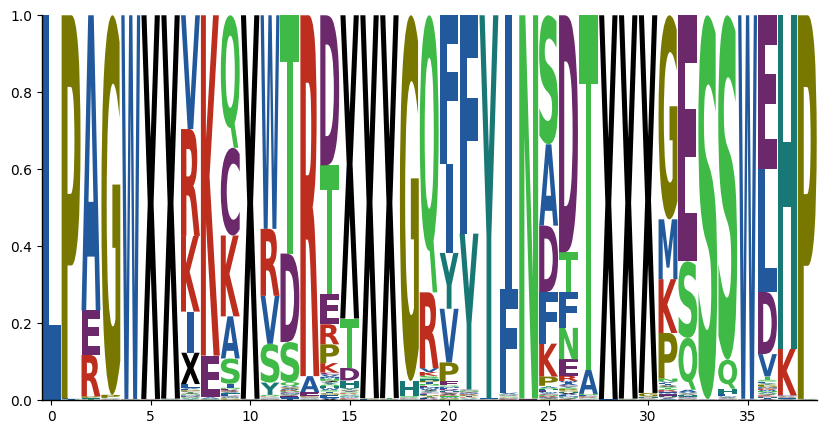

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq,2500, 1, logdir=logdir, out_modelname=outmodel_name )
    #check_parameter_historic = list(deepseq.parameters())
    #2500 iters before to make it converge in a good optima
    #for param in deepseq.parameters():
    #    param.requires_grad = False

deepseq(dataset_msa.prot_space)
plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)


In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker 


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])
    
    #fig.tight_layout()
    
 
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize); fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet] 
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)
        
        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)
    
    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')
    
    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()
        
def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set 
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are 
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''
    
        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))
        
        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs), 
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)
                
                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) - beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]

                
                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS                
                optimizer.step()

                
                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())
                
                # Save to tensorboard
                iteration = epoch*len(trainloader) + i
                
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()
        
        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid 
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_encoder( args.ed_type.split(",")[0] ), 
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-15,15] ) #[15,15]

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)#, weight_decay=1e-5)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'

fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=1000, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10) # in iter 500 crash

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Number of training points:  10


Epoch 1/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:275: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)


Epoch 1/1000: 100%|██████████| 10/10 [00:02<00:00,  3.67samples/s]

Epoch 1/1000: 100%|██████████| 10/10 [00:02<00:00,  3.67samples/s, loss=1181.4835205078125]

Epoch 1/1000: 100%|██████████| 10/10 [00:02<00:00,  3.53samples/s, loss=1181.4835205078125]

Epoch 2/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s]

Epoch 2/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s, loss=1205.1583251953125]

Epoch 2/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=1205.1583251953125]

Epoch 3/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 3/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 3/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1197.8193359375]

Epoch 3/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=1197.8193359375]

Epoch 4/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 4/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 4/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1183.8709716796875]

Epoch 4/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1183.8709716796875]

Epoch 5/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 5/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 5/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1156.523193359375]

Epoch 5/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1156.523193359375]

Epoch 6/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 6/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 6/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1131.510498046875]

Epoch 6/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1131.510498046875]

Epoch 7/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 7/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 7/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1138.7142333984375]

Epoch 7/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1138.7142333984375]

Epoch 8/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 8/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 8/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1127.7166748046875]

Epoch 8/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1127.7166748046875]

Epoch 9/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 9/1000: 100%|██████████| 10/10 [00:02<00:00,  4.12samples/s]

Epoch 9/1000: 100%|██████████| 10/10 [00:02<00:00,  4.12samples/s, loss=1126.066162109375]

Epoch 9/1000: 100%|██████████| 10/10 [00:02<00:00,  3.96samples/s, loss=1126.066162109375]

Epoch 10/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 10/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 10/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1126.9493408203125]

Epoch 10/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1126.9493408203125]

Epoch 11/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 11/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 11/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1124.6173095703125]

Epoch 11/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1124.6173095703125]

Epoch 12/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 12/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 12/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1137.2872314453125]

Epoch 12/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1137.2872314453125]

Epoch 13/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 13/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 13/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1117.7099609375]

Epoch 13/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1117.7099609375]

Epoch 14/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 14/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 14/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1112.1142578125]

Epoch 14/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1112.1142578125]

Epoch 15/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 15/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 15/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1133.7254638671875]

Epoch 15/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1133.7254638671875]

Epoch 16/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 16/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 16/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1131.931884765625]

Epoch 16/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1131.931884765625]

Epoch 17/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 17/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 17/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1128.0970458984375]

Epoch 17/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1128.0970458984375]

Epoch 18/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 18/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 18/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1140.574951171875]

Epoch 18/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1140.574951171875]

Epoch 19/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 19/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 19/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1148.2003173828125]

Epoch 19/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1148.2003173828125]

Epoch 20/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 20/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 20/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1145.946533203125]

Epoch 20/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1145.946533203125]

Epoch 21/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 21/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 21/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1145.6390380859375]

Epoch 21/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1145.6390380859375]

Epoch 22/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 22/1000: 100%|██████████| 10/10 [00:02<00:00,  4.12samples/s]

Epoch 22/1000: 100%|██████████| 10/10 [00:02<00:00,  4.12samples/s, loss=1146.195556640625]

Epoch 22/1000: 100%|██████████| 10/10 [00:02<00:00,  3.97samples/s, loss=1146.195556640625]

Epoch 23/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 23/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 23/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1136.392578125]

Epoch 23/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1136.392578125]

Epoch 24/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 24/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 24/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1147.37841796875]

Epoch 24/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1147.37841796875]

Epoch 25/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 25/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 25/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1130.5390625]

Epoch 25/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1130.5390625]

Epoch 26/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 26/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 26/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1125.94970703125]

Epoch 26/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1125.94970703125]

Epoch 27/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 27/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 27/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1129.0433349609375]

Epoch 27/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1129.0433349609375]

Epoch 28/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 28/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 28/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1141.4609375]

Epoch 28/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1141.4609375]

Epoch 29/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 29/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 29/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1115.665771484375]

Epoch 29/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1115.665771484375]

Epoch 30/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 30/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 30/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1146.01611328125]

Epoch 30/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1146.01611328125]

Epoch 31/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 31/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 31/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1153.7286376953125]

Epoch 31/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1153.7286376953125]

Epoch 32/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 32/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 32/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1106.2020263671875]

Epoch 32/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1106.2020263671875]

Epoch 33/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 33/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 33/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1148.803955078125]

Epoch 33/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1148.803955078125]

Epoch 34/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 34/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 34/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1117.0126953125]

Epoch 34/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1117.0126953125]

Epoch 35/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 35/1000: 100%|██████████| 10/10 [00:02<00:00,  4.04samples/s]

Epoch 35/1000: 100%|██████████| 10/10 [00:02<00:00,  4.04samples/s, loss=1135.947265625]

Epoch 35/1000: 100%|██████████| 10/10 [00:02<00:00,  3.89samples/s, loss=1135.947265625]

Epoch 36/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 36/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 36/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1123.278076171875]

Epoch 36/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1123.278076171875]

Epoch 37/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 37/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 37/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1140.030517578125]

Epoch 37/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1140.030517578125]

Epoch 38/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 38/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 38/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1110.210205078125]

Epoch 38/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1110.210205078125]

Epoch 39/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 39/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 39/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1145.1358642578125]

Epoch 39/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1145.1358642578125]

Epoch 40/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 40/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 40/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1122.509765625]

Epoch 40/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1122.509765625]

Epoch 41/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 41/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 41/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1134.6376953125]

Epoch 41/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1134.6376953125]

Epoch 42/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 42/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 42/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1113.9859619140625]

Epoch 42/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1113.9859619140625]

Epoch 43/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 43/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 43/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1121.6376953125]

Epoch 43/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1121.6376953125]

Epoch 44/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 44/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 44/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1116.318115234375]

Epoch 44/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1116.318115234375]

Epoch 45/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 45/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 45/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1127.2159423828125]

Epoch 45/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1127.2159423828125]

Epoch 46/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 46/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 46/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1125.4285888671875]

Epoch 46/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1125.4285888671875]

Epoch 47/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 47/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 47/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1112.4423828125]

Epoch 47/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1112.4423828125]

Epoch 48/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 48/1000: 100%|██████████| 10/10 [00:02<00:00,  4.10samples/s]

Epoch 48/1000: 100%|██████████| 10/10 [00:02<00:00,  4.10samples/s, loss=1113.197021484375]

Epoch 48/1000: 100%|██████████| 10/10 [00:02<00:00,  3.94samples/s, loss=1113.197021484375]

Epoch 49/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 49/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 49/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1125.5054931640625]

Epoch 49/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1125.5054931640625]

Epoch 50/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 50/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 50/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1110.047607421875]

Epoch 50/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1110.047607421875]

Epoch 51/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 51/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 51/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1119.5440673828125]

Epoch 51/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1119.5440673828125]

Epoch 52/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 52/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 52/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1113.962890625]

Epoch 52/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1113.962890625]

Epoch 53/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 53/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 53/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=1127.4246826171875]

Epoch 53/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=1127.4246826171875]

Epoch 54/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 54/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 54/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1131.4505615234375]

Epoch 54/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1131.4505615234375]

Epoch 55/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 55/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 55/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1107.1968994140625]

Epoch 55/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1107.1968994140625]

Epoch 56/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 56/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 56/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1085.5838623046875]

Epoch 56/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1085.5838623046875]

Epoch 57/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 57/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 57/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1119.2081298828125]

Epoch 57/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1119.2081298828125]

Epoch 58/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 58/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 58/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1118.9395751953125]

Epoch 58/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1118.9395751953125]

Epoch 59/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 59/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 59/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1116.865478515625]

Epoch 59/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1116.865478515625]

Epoch 60/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 60/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 60/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1134.0489501953125]

Epoch 60/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1134.0489501953125]

Epoch 61/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 61/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s]

Epoch 61/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1110.14990234375]

Epoch 61/1000: 100%|██████████| 10/10 [00:02<00:00,  4.02samples/s, loss=1110.14990234375]

Epoch 62/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 62/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 62/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1099.2945556640625]

Epoch 62/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1099.2945556640625]

Epoch 63/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 63/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 63/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1093.595947265625]

Epoch 63/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1093.595947265625]

Epoch 64/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 64/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 64/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1114.56298828125]

Epoch 64/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=1114.56298828125]

Epoch 65/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 65/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 65/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1115.5244140625]

Epoch 65/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1115.5244140625]

Epoch 66/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 66/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 66/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=1128.7650146484375]

Epoch 66/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=1128.7650146484375]

Epoch 67/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 67/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 67/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1127.4063720703125]

Epoch 67/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1127.4063720703125]

Epoch 68/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 68/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 68/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1126.5623779296875]

Epoch 68/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1126.5623779296875]

Epoch 69/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 69/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 69/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1116.2967529296875]

Epoch 69/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1116.2967529296875]

Epoch 70/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 70/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 70/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1118.8023681640625]

Epoch 70/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=1118.8023681640625]

Epoch 71/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 71/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 71/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1103.9779052734375]

Epoch 71/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=1103.9779052734375]

Epoch 72/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 72/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 72/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1103.67626953125]

Epoch 72/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1103.67626953125]

Epoch 73/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 73/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 73/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1101.6025390625]

Epoch 73/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1101.6025390625]

Epoch 74/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 74/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s]

Epoch 74/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1079.576904296875]

Epoch 74/1000: 100%|██████████| 10/10 [00:02<00:00,  4.05samples/s, loss=1079.576904296875]

Epoch 75/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 75/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 75/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1085.67724609375]

Epoch 75/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=1085.67724609375]

Epoch 76/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 76/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 76/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1101.2279052734375]

Epoch 76/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=1101.2279052734375]

Epoch 77/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 77/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 77/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1095.137939453125]

Epoch 77/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1095.137939453125]

Epoch 78/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 78/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 78/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1086.061767578125]

Epoch 78/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1086.061767578125]

Epoch 79/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 79/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 79/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1082.5245361328125]

Epoch 79/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1082.5245361328125]

Epoch 80/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 80/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 80/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1100.76904296875]

Epoch 80/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1100.76904296875]

Epoch 81/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 81/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 81/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1102.9661865234375]

Epoch 81/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1102.9661865234375]

Epoch 82/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 82/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 82/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1100.1346435546875]

Epoch 82/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1100.1346435546875]

Epoch 83/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 83/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 83/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1085.7725830078125]

Epoch 83/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1085.7725830078125]

Epoch 84/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 84/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 84/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1093.41162109375]

Epoch 84/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1093.41162109375]

Epoch 85/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 85/1000: 100%|██████████| 10/10 [00:02<00:00,  4.30samples/s]

Epoch 85/1000: 100%|██████████| 10/10 [00:02<00:00,  4.30samples/s, loss=1097.2996826171875]

Epoch 85/1000: 100%|██████████| 10/10 [00:02<00:00,  4.13samples/s, loss=1097.2996826171875]

Epoch 86/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 86/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 86/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=1098.2340087890625]

Epoch 86/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=1098.2340087890625]

Epoch 87/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 87/1000: 100%|██████████| 10/10 [00:02<00:00,  4.09samples/s]

Epoch 87/1000: 100%|██████████| 10/10 [00:02<00:00,  4.09samples/s, loss=1099.9527587890625]

Epoch 87/1000: 100%|██████████| 10/10 [00:02<00:00,  3.94samples/s, loss=1099.9527587890625]

Epoch 88/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 88/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 88/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1090.9281005859375]

Epoch 88/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1090.9281005859375]

Epoch 89/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 89/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 89/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1075.8798828125]

Epoch 89/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1075.8798828125]

Epoch 90/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 90/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 90/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1099.74658203125]

Epoch 90/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=1099.74658203125]

Epoch 91/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 91/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 91/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1075.5418701171875]

Epoch 91/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1075.5418701171875]

Epoch 92/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 92/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 92/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1070.6300048828125]

Epoch 92/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1070.6300048828125]

Epoch 93/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 93/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 93/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1078.17724609375]

Epoch 93/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1078.17724609375]

Epoch 94/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 94/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 94/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1106.3626708984375]

Epoch 94/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1106.3626708984375]

Epoch 95/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 95/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 95/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1091.307861328125]

Epoch 95/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1091.307861328125]

Epoch 96/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 96/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 96/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1072.84375]

Epoch 96/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1072.84375]

Epoch 97/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 97/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 97/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1067.5689697265625]

Epoch 97/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1067.5689697265625]

Epoch 98/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 98/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 98/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1092.0047607421875]

Epoch 98/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1092.0047607421875]

Epoch 99/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 99/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 99/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1081.2061767578125]

Epoch 99/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1081.2061767578125]

Epoch 100/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 100/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s]

Epoch 100/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=1085.381103515625]

Epoch 100/1000: 100%|██████████| 10/10 [00:02<00:00,  3.99samples/s, loss=1085.381103515625]

Epoch 101/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 101/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 101/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1074.88525390625]

Epoch 101/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1074.88525390625]

Epoch 102/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 102/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 102/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1089.234619140625]

Epoch 102/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1089.234619140625]

Epoch 103/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 103/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 103/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=1080.251220703125]

Epoch 103/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=1080.251220703125]

Epoch 104/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 104/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 104/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=1087.894775390625]

Epoch 104/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=1087.894775390625]

Epoch 105/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 105/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 105/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1085.8660888671875]

Epoch 105/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1085.8660888671875]

Epoch 106/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 106/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 106/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1097.51220703125]

Epoch 106/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1097.51220703125]

Epoch 107/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 107/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 107/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1108.7362060546875]

Epoch 107/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1108.7362060546875]

Epoch 108/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 108/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 108/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1071.9638671875]

Epoch 108/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1071.9638671875]

Epoch 109/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 109/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 109/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1087.576171875]

Epoch 109/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1087.576171875]

Epoch 110/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 110/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 110/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1067.2464599609375]

Epoch 110/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1067.2464599609375]

Epoch 111/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 111/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 111/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1075.348876953125]

Epoch 111/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1075.348876953125]

Epoch 112/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 112/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 112/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1056.9583740234375]

Epoch 112/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1056.9583740234375]

Epoch 113/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 113/1000: 100%|██████████| 10/10 [00:02<00:00,  4.12samples/s]

Epoch 113/1000: 100%|██████████| 10/10 [00:02<00:00,  4.12samples/s, loss=1097.3712158203125]

Epoch 113/1000: 100%|██████████| 10/10 [00:02<00:00,  3.97samples/s, loss=1097.3712158203125]

Epoch 114/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 114/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 114/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1085.0771484375]

Epoch 114/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1085.0771484375]

Epoch 115/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 115/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 115/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1104.5638427734375]

Epoch 115/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1104.5638427734375]

Epoch 116/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 116/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 116/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1059.831787109375]

Epoch 116/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1059.831787109375]

Epoch 117/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 117/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 117/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1060.371337890625]

Epoch 117/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1060.371337890625]

Epoch 118/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 118/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 118/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1074.760986328125]

Epoch 118/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1074.760986328125]

Epoch 119/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 119/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 119/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1069.09326171875]

Epoch 119/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1069.09326171875]

Epoch 120/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 120/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 120/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1054.8719482421875]

Epoch 120/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1054.8719482421875]

Epoch 121/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 121/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 121/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=1046.8350830078125]

Epoch 121/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=1046.8350830078125]

Epoch 122/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 122/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 122/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1055.694580078125]

Epoch 122/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1055.694580078125]

Epoch 123/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 123/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 123/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1076.456787109375]

Epoch 123/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=1076.456787109375]

Epoch 124/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 124/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 124/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1096.0830078125]

Epoch 124/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1096.0830078125]

Epoch 125/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 125/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 125/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1117.1822509765625]

Epoch 125/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1117.1822509765625]

Epoch 126/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 126/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s]

Epoch 126/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1098.319580078125]

Epoch 126/1000: 100%|██████████| 10/10 [00:02<00:00,  4.02samples/s, loss=1098.319580078125]

Epoch 127/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 127/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 127/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1086.65869140625]

Epoch 127/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1086.65869140625]

Epoch 128/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 128/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 128/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1072.6170654296875]

Epoch 128/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1072.6170654296875]

Epoch 129/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 129/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 129/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1070.498046875]

Epoch 129/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1070.498046875]

Epoch 130/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 130/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 130/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1108.4656982421875]

Epoch 130/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1108.4656982421875]

Epoch 131/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 131/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 131/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1109.9345703125]

Epoch 131/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1109.9345703125]

Epoch 132/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 132/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 132/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1119.0565185546875]

Epoch 132/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1119.0565185546875]

Epoch 133/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 133/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 133/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1109.005126953125]

Epoch 133/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1109.005126953125]

Epoch 134/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 134/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 134/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1065.97216796875]

Epoch 134/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1065.97216796875]

Epoch 135/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 135/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 135/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1088.991455078125]

Epoch 135/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1088.991455078125]

Epoch 136/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 136/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 136/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1083.2403564453125]

Epoch 136/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1083.2403564453125]

Epoch 137/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 137/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 137/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1110.451904296875]

Epoch 137/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1110.451904296875]

Epoch 138/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 138/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 138/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1126.613525390625]

Epoch 138/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=1126.613525390625]

Epoch 139/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 139/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s]

Epoch 139/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=1131.6630859375]

Epoch 139/1000: 100%|██████████| 10/10 [00:02<00:00,  4.00samples/s, loss=1131.6630859375]

Epoch 140/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 140/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 140/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1114.5084228515625]

Epoch 140/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=1114.5084228515625]

Epoch 141/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 141/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 141/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1111.81640625]

Epoch 141/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1111.81640625]

Epoch 142/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 142/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 142/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=1072.47509765625]

Epoch 142/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=1072.47509765625]

Epoch 143/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 143/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 143/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1077.636962890625]

Epoch 143/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=1077.636962890625]

Epoch 144/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 144/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 144/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1104.27001953125]

Epoch 144/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1104.27001953125]

Epoch 145/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 145/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 145/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1108.994140625]

Epoch 145/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1108.994140625]

Epoch 146/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 146/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 146/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1109.43115234375]

Epoch 146/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1109.43115234375]

Epoch 147/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 147/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 147/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1129.406494140625]

Epoch 147/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1129.406494140625]

Epoch 148/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 148/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 148/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1099.52294921875]

Epoch 148/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1099.52294921875]

Epoch 149/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 149/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 149/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1086.5078125]

Epoch 149/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1086.5078125]

Epoch 150/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 150/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 150/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1080.588134765625]

Epoch 150/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1080.588134765625]

Epoch 151/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 151/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 151/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1076.1884765625]

Epoch 151/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1076.1884765625]

Epoch 152/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 152/1000: 100%|██████████| 10/10 [00:02<00:00,  4.13samples/s]

Epoch 152/1000: 100%|██████████| 10/10 [00:02<00:00,  4.13samples/s, loss=1077.481689453125]

Epoch 152/1000: 100%|██████████| 10/10 [00:02<00:00,  3.98samples/s, loss=1077.481689453125]

Epoch 153/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 153/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 153/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1069.31591796875]

Epoch 153/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1069.31591796875]

Epoch 154/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 154/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 154/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1081.794677734375]

Epoch 154/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1081.794677734375]

Epoch 155/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 155/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 155/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1085.5936279296875]

Epoch 155/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1085.5936279296875]

Epoch 156/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 156/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 156/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1086.820556640625]

Epoch 156/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1086.820556640625]

Epoch 157/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 157/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 157/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1094.0869140625]

Epoch 157/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1094.0869140625]

Epoch 158/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 158/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 158/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1083.47802734375]

Epoch 158/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1083.47802734375]

Epoch 159/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 159/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 159/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1067.62646484375]

Epoch 159/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1067.62646484375]

Epoch 160/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 160/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 160/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1053.6446533203125]

Epoch 160/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=1053.6446533203125]

Epoch 161/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 161/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 161/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1032.30859375]

Epoch 161/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1032.30859375]

Epoch 162/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 162/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 162/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1056.3004150390625]

Epoch 162/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1056.3004150390625]

Epoch 163/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 163/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 163/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1054.909912109375]

Epoch 163/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1054.909912109375]

Epoch 164/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 164/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 164/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1071.8831787109375]

Epoch 164/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1071.8831787109375]

Epoch 165/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 165/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s]

Epoch 165/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1059.481689453125]

Epoch 165/1000: 100%|██████████| 10/10 [00:02<00:00,  4.02samples/s, loss=1059.481689453125]

Epoch 166/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 166/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 166/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1067.001220703125]

Epoch 166/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=1067.001220703125]

Epoch 167/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 167/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 167/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1057.543701171875]

Epoch 167/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1057.543701171875]

Epoch 168/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 168/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 168/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1034.741455078125]

Epoch 168/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1034.741455078125]

Epoch 169/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 169/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 169/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1055.0872802734375]

Epoch 169/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1055.0872802734375]

Epoch 170/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 170/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 170/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1064.8502197265625]

Epoch 170/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1064.8502197265625]

Epoch 171/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 171/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 171/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1056.947509765625]

Epoch 171/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1056.947509765625]

Epoch 172/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 172/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 172/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1067.113037109375]

Epoch 172/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1067.113037109375]

Epoch 173/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 173/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 173/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1081.0345458984375]

Epoch 173/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1081.0345458984375]

Epoch 174/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 174/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 174/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1051.732421875]

Epoch 174/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1051.732421875]

Epoch 175/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 175/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 175/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1061.9075927734375]

Epoch 175/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1061.9075927734375]

Epoch 176/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 176/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 176/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1047.9027099609375]

Epoch 176/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1047.9027099609375]

Epoch 177/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 177/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 177/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1057.522216796875]

Epoch 177/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1057.522216796875]

Epoch 178/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 178/1000: 100%|██████████| 10/10 [00:02<00:00,  4.09samples/s]

Epoch 178/1000: 100%|██████████| 10/10 [00:02<00:00,  4.09samples/s, loss=1046.115234375]

Epoch 178/1000: 100%|██████████| 10/10 [00:02<00:00,  3.94samples/s, loss=1046.115234375]

Epoch 179/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 179/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 179/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1045.845947265625]

Epoch 179/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1045.845947265625]

Epoch 180/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 180/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 180/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1058.9801025390625]

Epoch 180/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1058.9801025390625]

Epoch 181/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 181/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 181/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1069.6015625]

Epoch 181/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1069.6015625]

Epoch 182/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 182/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 182/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1042.8304443359375]

Epoch 182/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1042.8304443359375]

Epoch 183/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 183/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 183/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1044.7230224609375]

Epoch 183/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1044.7230224609375]

Epoch 184/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 184/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 184/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1051.4598388671875]

Epoch 184/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1051.4598388671875]

Epoch 185/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 185/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 185/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1050.6234130859375]

Epoch 185/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1050.6234130859375]

Epoch 186/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 186/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 186/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1041.4718017578125]

Epoch 186/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1041.4718017578125]

Epoch 187/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 187/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 187/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1034.6495361328125]

Epoch 187/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1034.6495361328125]

Epoch 188/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 188/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 188/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1052.0687255859375]

Epoch 188/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1052.0687255859375]

Epoch 189/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 189/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 189/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1035.892333984375]

Epoch 189/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1035.892333984375]

Epoch 190/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 190/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 190/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=1033.8240966796875]

Epoch 190/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=1033.8240966796875]

Epoch 191/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 191/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s]

Epoch 191/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1041.40283203125]

Epoch 191/1000: 100%|██████████| 10/10 [00:02<00:00,  4.01samples/s, loss=1041.40283203125]

Epoch 192/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 192/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 192/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1036.7626953125]

Epoch 192/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1036.7626953125]

Epoch 193/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 193/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 193/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1037.91796875]

Epoch 193/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1037.91796875]

Epoch 194/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 194/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 194/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1037.9842529296875]

Epoch 194/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1037.9842529296875]

Epoch 195/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 195/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 195/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1040.3375244140625]

Epoch 195/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1040.3375244140625]

Epoch 196/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 196/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 196/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1044.497314453125]

Epoch 196/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1044.497314453125]

Epoch 197/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 197/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 197/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1028.1383056640625]

Epoch 197/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1028.1383056640625]

Epoch 198/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 198/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 198/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1039.4193115234375]

Epoch 198/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=1039.4193115234375]

Epoch 199/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 199/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 199/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1042.2750244140625]

Epoch 199/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1042.2750244140625]

Epoch 200/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 200/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 200/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=1024.14990234375]

Epoch 200/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1024.14990234375]

Epoch 201/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 201/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 201/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1021.7835693359375]

Epoch 201/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1021.7835693359375]

Epoch 202/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 202/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 202/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1035.3861083984375]

Epoch 202/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1035.3861083984375]

Epoch 203/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 203/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 203/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1018.852294921875]

Epoch 203/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1018.852294921875]

Epoch 204/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 204/1000: 100%|██████████| 10/10 [00:02<00:00,  4.09samples/s]

Epoch 204/1000: 100%|██████████| 10/10 [00:02<00:00,  4.09samples/s, loss=1049.196044921875]

Epoch 204/1000: 100%|██████████| 10/10 [00:02<00:00,  3.94samples/s, loss=1049.196044921875]

Epoch 205/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

From Here


Epoch 205/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 205/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1040.258056640625]

Epoch 205/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1040.258056640625]

Epoch 206/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 206/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 206/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1018.3143310546875]

Epoch 206/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1018.3143310546875]

Epoch 207/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 207/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 207/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1030.8173828125]

Epoch 207/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1030.8173828125]

Epoch 208/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 208/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 208/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1027.5911865234375]

Epoch 208/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1027.5911865234375]

Epoch 209/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 209/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 209/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1019.17822265625]

Epoch 209/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1019.17822265625]

Epoch 210/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 210/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 210/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=1026.544189453125]

Epoch 210/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=1026.544189453125]

Epoch 211/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 211/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 211/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1021.4033203125]

Epoch 211/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1021.4033203125]

Epoch 212/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 212/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 212/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1013.8818359375]

Epoch 212/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1013.8818359375]

Epoch 213/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 213/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 213/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1022.7630615234375]

Epoch 213/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=1022.7630615234375]

Epoch 214/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 214/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 214/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1023.1400756835938]

Epoch 214/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1023.1400756835938]

Epoch 215/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 215/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 215/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1015.6722412109375]

Epoch 215/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1015.6722412109375]

Epoch 216/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 216/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 216/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1022.9679565429688]

Epoch 216/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1022.9679565429688]

Epoch 217/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 217/1000: 100%|██████████| 10/10 [00:02<00:00,  4.13samples/s]

Epoch 217/1000: 100%|██████████| 10/10 [00:02<00:00,  4.13samples/s, loss=1045.0040283203125]

Epoch 217/1000: 100%|██████████| 10/10 [00:02<00:00,  3.96samples/s, loss=1045.0040283203125]

Epoch 218/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 218/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 218/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1021.7328491210938]

Epoch 218/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1021.7328491210938]

Epoch 219/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 219/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 219/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1023.1486206054688]

Epoch 219/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1023.1486206054688]

Epoch 220/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 220/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 220/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=1006.1292724609375]

Epoch 220/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=1006.1292724609375]

Epoch 221/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 221/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 221/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1031.03515625]

Epoch 221/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1031.03515625]

Epoch 222/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 222/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 222/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1019.5122680664062]

Epoch 222/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1019.5122680664062]

Epoch 223/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 223/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 223/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1010.731689453125]

Epoch 223/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1010.731689453125]

Epoch 224/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 224/1000: 100%|██████████| 10/10 [00:02<00:00,  4.31samples/s]

Epoch 224/1000: 100%|██████████| 10/10 [00:02<00:00,  4.31samples/s, loss=1007.7053833007812]

Epoch 224/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=1007.7053833007812]

Epoch 225/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 225/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 225/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=996.0277099609375]

Epoch 225/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=996.0277099609375]

Epoch 226/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 226/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 226/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1004.96826171875]

Epoch 226/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1004.96826171875]

Epoch 227/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 227/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 227/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1021.5478515625]

Epoch 227/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1021.5478515625]

Epoch 228/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 228/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 228/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1000.512451171875]

Epoch 228/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=1000.512451171875]

Epoch 229/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 229/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 229/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=999.7005615234375]

Epoch 229/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=999.7005615234375]

Epoch 230/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 230/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s]

Epoch 230/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=1000.1101684570312]

Epoch 230/1000: 100%|██████████| 10/10 [00:02<00:00,  4.00samples/s, loss=1000.1101684570312]

Epoch 231/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 231/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 231/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1008.2395629882812]

Epoch 231/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1008.2395629882812]

Epoch 232/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 232/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 232/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1004.128173828125]

Epoch 232/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1004.128173828125]

Epoch 233/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 233/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 233/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=1012.6605224609375]

Epoch 233/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=1012.6605224609375]

Epoch 234/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 234/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 234/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=1004.8134765625]

Epoch 234/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=1004.8134765625]

Epoch 235/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 235/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 235/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=999.6869506835938]

Epoch 235/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=999.6869506835938]

Epoch 236/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 236/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 236/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=1008.385498046875]

Epoch 236/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=1008.385498046875]

Epoch 237/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 237/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 237/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=1004.3660278320312]

Epoch 237/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=1004.3660278320312]

Epoch 238/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 238/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 238/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=995.1034545898438]

Epoch 238/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=995.1034545898438]

Epoch 239/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 239/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 239/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=998.7513427734375]

Epoch 239/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=998.7513427734375]

Epoch 240/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 240/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 240/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1004.5128173828125]

Epoch 240/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1004.5128173828125]

Epoch 241/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 241/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 241/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=998.4449462890625]

Epoch 241/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=998.4449462890625]

Epoch 242/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 242/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 242/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1003.7017211914062]

Epoch 242/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=1003.7017211914062]

Epoch 243/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 243/1000: 100%|██████████| 10/10 [00:02<00:00,  4.11samples/s]

Epoch 243/1000: 100%|██████████| 10/10 [00:02<00:00,  4.11samples/s, loss=990.389892578125]

Epoch 243/1000: 100%|██████████| 10/10 [00:02<00:00,  3.96samples/s, loss=990.389892578125]

Epoch 244/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 244/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 244/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=1004.0808715820312]

Epoch 244/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1004.0808715820312]

Epoch 245/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 245/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 245/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=995.1149291992188]

Epoch 245/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=995.1149291992188]

Epoch 246/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 246/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 246/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=991.9219970703125]

Epoch 246/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=991.9219970703125]

Epoch 247/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 247/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 247/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=988.8391723632812]

Epoch 247/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=988.8391723632812]

Epoch 248/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 248/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 248/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=1007.174560546875]

Epoch 248/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=1007.174560546875]

Epoch 249/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 249/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 249/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=995.4043579101562]

Epoch 249/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=995.4043579101562]

Epoch 250/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 250/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 250/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=1010.5629272460938]

Epoch 250/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=1010.5629272460938]

Epoch 251/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 251/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 251/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=992.8485107421875]

Epoch 251/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=992.8485107421875]

Epoch 252/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 252/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 252/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=999.7774047851562]

Epoch 252/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=999.7774047851562]

Epoch 253/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 253/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 253/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=992.068603515625]

Epoch 253/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=992.068603515625]

Epoch 254/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 254/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 254/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=989.1549682617188]

Epoch 254/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=989.1549682617188]

Epoch 255/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 255/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 255/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=1007.565185546875]

Epoch 255/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=1007.565185546875]

Epoch 256/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 256/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 256/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=987.7117309570312]

Epoch 256/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=987.7117309570312]

Epoch 257/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 257/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s]

Epoch 257/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=987.8916625976562]

Epoch 257/1000: 100%|██████████| 10/10 [00:02<00:00,  4.00samples/s, loss=987.8916625976562]

Epoch 258/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 258/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 258/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=990.3367309570312]

Epoch 258/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=990.3367309570312]

Epoch 259/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 259/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 259/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=995.6171264648438]

Epoch 259/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=995.6171264648438]

Epoch 260/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 260/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 260/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=986.9380493164062]

Epoch 260/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=986.9380493164062]

Epoch 261/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 261/1000: 100%|██████████| 10/10 [00:02<00:00,  4.31samples/s]

Epoch 261/1000: 100%|██████████| 10/10 [00:02<00:00,  4.31samples/s, loss=987.7100219726562]

Epoch 261/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=987.7100219726562]

Epoch 262/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 262/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 262/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=985.8785400390625]

Epoch 262/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=985.8785400390625]

Epoch 263/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 263/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 263/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=983.7274169921875]

Epoch 263/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=983.7274169921875]

Epoch 264/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 264/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 264/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=985.7844848632812]

Epoch 264/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=985.7844848632812]

Epoch 265/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 265/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 265/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=991.9636840820312]

Epoch 265/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=991.9636840820312]

Epoch 266/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 266/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 266/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=984.8380126953125]

Epoch 266/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=984.8380126953125]

Epoch 267/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 267/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 267/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=989.8779296875]

Epoch 267/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=989.8779296875]

Epoch 268/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 268/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 268/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=988.3807373046875]

Epoch 268/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=988.3807373046875]

Epoch 269/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 269/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 269/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=984.732177734375]

Epoch 269/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=984.732177734375]

Epoch 270/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 270/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 270/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=983.1818237304688]

Epoch 270/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=983.1818237304688]

Epoch 271/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 271/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 271/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=985.4779052734375]

Epoch 271/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=985.4779052734375]

Epoch 272/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 272/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 272/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=998.73779296875]

Epoch 272/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=998.73779296875]

Epoch 273/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 273/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 273/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=981.2023315429688]

Epoch 273/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=981.2023315429688]

Epoch 274/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 274/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 274/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=988.5560302734375]

Epoch 274/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=988.5560302734375]

Epoch 275/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 275/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 275/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=992.0447998046875]

Epoch 275/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=992.0447998046875]

Epoch 276/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 276/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 276/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=985.895263671875]

Epoch 276/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=985.895263671875]

Epoch 277/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 277/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 277/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=987.8245849609375]

Epoch 277/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=987.8245849609375]

Epoch 278/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 278/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 278/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=982.7673950195312]

Epoch 278/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=982.7673950195312]

Epoch 279/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 279/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 279/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=995.5598754882812]

Epoch 279/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=995.5598754882812]

Epoch 280/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 280/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 280/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=980.5093994140625]

Epoch 280/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=980.5093994140625]

Epoch 281/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 281/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 281/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=983.5986328125]

Epoch 281/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=983.5986328125]

Epoch 282/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 282/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 282/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=989.8681640625]

Epoch 282/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=989.8681640625]

Epoch 283/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 283/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 283/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=981.0060424804688]

Epoch 283/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=981.0060424804688]

Epoch 284/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 284/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 284/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=981.4838256835938]

Epoch 284/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=981.4838256835938]

Epoch 285/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 285/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 285/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=982.320556640625]

Epoch 285/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=982.320556640625]

Epoch 286/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 286/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 286/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=980.7369384765625]

Epoch 286/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=980.7369384765625]

Epoch 287/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 287/1000: 100%|██████████| 10/10 [00:02<00:00,  4.12samples/s]

Epoch 287/1000: 100%|██████████| 10/10 [00:02<00:00,  4.12samples/s, loss=978.84375]

Epoch 287/1000: 100%|██████████| 10/10 [00:02<00:00,  3.96samples/s, loss=978.84375]

Epoch 288/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 288/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 288/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=982.7261962890625]

Epoch 288/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=982.7261962890625]

Epoch 289/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 289/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 289/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=978.441162109375]

Epoch 289/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=978.441162109375]

Epoch 290/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 290/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 290/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=982.746337890625]

Epoch 290/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=982.746337890625]

Epoch 291/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 291/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 291/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=988.466552734375]

Epoch 291/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=988.466552734375]

Epoch 292/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 292/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 292/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=979.605224609375]

Epoch 292/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=979.605224609375]

Epoch 293/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 293/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 293/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=979.3668823242188]

Epoch 293/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=979.3668823242188]

Epoch 294/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 294/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 294/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=979.4181518554688]

Epoch 294/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=979.4181518554688]

Epoch 295/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 295/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 295/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=988.6104736328125]

Epoch 295/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=988.6104736328125]

Epoch 296/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 296/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 296/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=979.8917236328125]

Epoch 296/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=979.8917236328125]

Epoch 297/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 297/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 297/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=980.2119750976562]

Epoch 297/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=980.2119750976562]

Epoch 298/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 298/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 298/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=990.7796630859375]

Epoch 298/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=990.7796630859375]

Epoch 299/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 299/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 299/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=974.9376220703125]

Epoch 299/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=974.9376220703125]

Epoch 300/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 300/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 300/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=988.367919921875]

Epoch 300/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=988.367919921875]

Epoch 301/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 301/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 301/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=984.494384765625]

Epoch 301/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=984.494384765625]

Epoch 302/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 302/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 302/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=982.5321655273438]

Epoch 302/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=982.5321655273438]

Epoch 303/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 303/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 303/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=982.7742919921875]

Epoch 303/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=982.7742919921875]

Epoch 304/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 304/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 304/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=975.1058349609375]

Epoch 304/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=975.1058349609375]

Epoch 305/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 305/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 305/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=980.5990600585938]

Epoch 305/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=980.5990600585938]

Epoch 306/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 306/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 306/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=976.6671752929688]

Epoch 306/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=976.6671752929688]

Epoch 307/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 307/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 307/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=987.81787109375]

Epoch 307/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=987.81787109375]

Epoch 308/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 308/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 308/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=981.561279296875]

Epoch 308/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=981.561279296875]

Epoch 309/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 309/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 309/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=977.8995971679688]

Epoch 309/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=977.8995971679688]

Epoch 310/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 310/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 310/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=982.0017700195312]

Epoch 310/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=982.0017700195312]

Epoch 311/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 311/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 311/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=977.1353759765625]

Epoch 311/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=977.1353759765625]

Epoch 312/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 312/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 312/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=979.4456176757812]

Epoch 312/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=979.4456176757812]

Epoch 313/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 313/1000: 100%|██████████| 10/10 [00:02<00:00,  4.08samples/s]

Epoch 313/1000: 100%|██████████| 10/10 [00:02<00:00,  4.08samples/s, loss=996.193115234375]

Epoch 313/1000: 100%|██████████| 10/10 [00:02<00:00,  3.93samples/s, loss=996.193115234375]

Epoch 314/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 314/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 314/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=974.56689453125]

Epoch 314/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=974.56689453125]

Epoch 315/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 315/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 315/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=990.3530883789062]

Epoch 315/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=990.3530883789062]

Epoch 316/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 316/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 316/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=981.55224609375]

Epoch 316/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=981.55224609375]

Epoch 317/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 317/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 317/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=987.6220703125]

Epoch 317/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=987.6220703125]

Epoch 318/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 318/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 318/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=992.4807739257812]

Epoch 318/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=992.4807739257812]

Epoch 319/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 319/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 319/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=975.0184326171875]

Epoch 319/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=975.0184326171875]

Epoch 320/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 320/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 320/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=1002.6199951171875]

Epoch 320/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=1002.6199951171875]

Epoch 321/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 321/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 321/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=972.6286010742188]

Epoch 321/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=972.6286010742188]

Epoch 322/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 322/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 322/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=997.0621948242188]

Epoch 322/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=997.0621948242188]

Epoch 323/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 323/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 323/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=974.548095703125]

Epoch 323/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=974.548095703125]

Epoch 324/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 324/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 324/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=994.8692626953125]

Epoch 324/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=994.8692626953125]

Epoch 325/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 325/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 325/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=977.4055786132812]

Epoch 325/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=977.4055786132812]

Epoch 326/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 326/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 326/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=980.3966674804688]

Epoch 326/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=980.3966674804688]

Epoch 327/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 327/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 327/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=976.77734375]

Epoch 327/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=976.77734375]

Epoch 328/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 328/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 328/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=978.3726196289062]

Epoch 328/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=978.3726196289062]

Epoch 329/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 329/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 329/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=977.2125244140625]

Epoch 329/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=977.2125244140625]

Epoch 330/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 330/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 330/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=972.3574829101562]

Epoch 330/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=972.3574829101562]

Epoch 331/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 331/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 331/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=981.3203735351562]

Epoch 331/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=981.3203735351562]

Epoch 332/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 332/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 332/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=975.7310180664062]

Epoch 332/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=975.7310180664062]

Epoch 333/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 333/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 333/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=983.7037353515625]

Epoch 333/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=983.7037353515625]

Epoch 334/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 334/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 334/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=977.1674194335938]

Epoch 334/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=977.1674194335938]

Epoch 335/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 335/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 335/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=985.3323364257812]

Epoch 335/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=985.3323364257812]

Epoch 336/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 336/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 336/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=976.3446044921875]

Epoch 336/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=976.3446044921875]

Epoch 337/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 337/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 337/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=976.6708984375]

Epoch 337/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=976.6708984375]

Epoch 338/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 338/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 338/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=971.392333984375]

Epoch 338/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=971.392333984375]

Epoch 339/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 339/1000: 100%|██████████| 10/10 [00:02<00:00,  4.11samples/s]

Epoch 339/1000: 100%|██████████| 10/10 [00:02<00:00,  4.11samples/s, loss=983.39111328125]

Epoch 339/1000: 100%|██████████| 10/10 [00:02<00:00,  3.96samples/s, loss=983.39111328125]

Epoch 340/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 340/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 340/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=976.4395751953125]

Epoch 340/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=976.4395751953125]

Epoch 341/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 341/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 341/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=973.6988525390625]

Epoch 341/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=973.6988525390625]

Epoch 342/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 342/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 342/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=972.4968872070312]

Epoch 342/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=972.4968872070312]

Epoch 343/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 343/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 343/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=975.4957275390625]

Epoch 343/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=975.4957275390625]

Epoch 344/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 344/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 344/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=971.2943725585938]

Epoch 344/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=971.2943725585938]

Epoch 345/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 345/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 345/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=970.3983154296875]

Epoch 345/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=970.3983154296875]

Epoch 346/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 346/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 346/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=976.116455078125]

Epoch 346/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=976.116455078125]

Epoch 347/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 347/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 347/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=975.6414794921875]

Epoch 347/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=975.6414794921875]

Epoch 348/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 348/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 348/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=970.4861450195312]

Epoch 348/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=970.4861450195312]

Epoch 349/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 349/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 349/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=972.4440307617188]

Epoch 349/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=972.4440307617188]

Epoch 350/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 350/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 350/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=969.5004272460938]

Epoch 350/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=969.5004272460938]

Epoch 351/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 351/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 351/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=972.2054443359375]

Epoch 351/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=972.2054443359375]

Epoch 352/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 352/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 352/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=971.5360107421875]

Epoch 352/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=971.5360107421875]

Epoch 353/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 353/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 353/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=974.5955200195312]

Epoch 353/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=974.5955200195312]

Epoch 354/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 354/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 354/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=975.1190795898438]

Epoch 354/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=975.1190795898438]

Epoch 355/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 355/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 355/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=974.7545166015625]

Epoch 355/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=974.7545166015625]

Epoch 356/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 356/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 356/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=968.771240234375]

Epoch 356/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=968.771240234375]

Epoch 357/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 357/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 357/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=970.3235473632812]

Epoch 357/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=970.3235473632812]

Epoch 358/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 358/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 358/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=972.6365966796875]

Epoch 358/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=972.6365966796875]

Epoch 359/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 359/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 359/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=975.2804565429688]

Epoch 359/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=975.2804565429688]

Epoch 360/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 360/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 360/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=973.67333984375]

Epoch 360/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=973.67333984375]

Epoch 361/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 361/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 361/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=977.8540649414062]

Epoch 361/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=977.8540649414062]

Epoch 362/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 362/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 362/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=972.2030639648438]

Epoch 362/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=972.2030639648438]

Epoch 363/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 363/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 363/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=967.9799194335938]

Epoch 363/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=967.9799194335938]

Epoch 364/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 364/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 364/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=969.9097290039062]

Epoch 364/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=969.9097290039062]

Epoch 365/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 365/1000: 100%|██████████| 10/10 [00:02<00:00,  4.06samples/s]

Epoch 365/1000: 100%|██████████| 10/10 [00:02<00:00,  4.06samples/s, loss=969.2237548828125]

Epoch 365/1000: 100%|██████████| 10/10 [00:02<00:00,  3.91samples/s, loss=969.2237548828125]

Epoch 366/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 366/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 366/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=973.9002075195312]

Epoch 366/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=973.9002075195312]

Epoch 367/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 367/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 367/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=970.3433837890625]

Epoch 367/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=970.3433837890625]

Epoch 368/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 368/1000: 100%|██████████| 10/10 [00:02<00:00,  4.30samples/s]

Epoch 368/1000: 100%|██████████| 10/10 [00:02<00:00,  4.30samples/s, loss=974.5746459960938]

Epoch 368/1000: 100%|██████████| 10/10 [00:02<00:00,  4.13samples/s, loss=974.5746459960938]

Epoch 369/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 369/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 369/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=973.4465942382812]

Epoch 369/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=973.4465942382812]

Epoch 370/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 370/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 370/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=972.497314453125]

Epoch 370/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=972.497314453125]

Epoch 371/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 371/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 371/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=979.3425903320312]

Epoch 371/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=979.3425903320312]

Epoch 372/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 372/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 372/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=972.0670166015625]

Epoch 372/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=972.0670166015625]

Epoch 373/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 373/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 373/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=971.9956665039062]

Epoch 373/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=971.9956665039062]

Epoch 374/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 374/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 374/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=975.3667602539062]

Epoch 374/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=975.3667602539062]

Epoch 375/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 375/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 375/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=979.0589599609375]

Epoch 375/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=979.0589599609375]

Epoch 376/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 376/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 376/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=984.3674926757812]

Epoch 376/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=984.3674926757812]

Epoch 377/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 377/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 377/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=978.1641235351562]

Epoch 377/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=978.1641235351562]

Epoch 378/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 378/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 378/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=968.7620849609375]

Epoch 378/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=968.7620849609375]

Epoch 379/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 379/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 379/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=997.5018310546875]

Epoch 379/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=997.5018310546875]

Epoch 380/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 380/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 380/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=967.4475708007812]

Epoch 380/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=967.4475708007812]

Epoch 381/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 381/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 381/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=973.084716796875]

Epoch 381/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=973.084716796875]

Epoch 382/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 382/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 382/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=984.3436279296875]

Epoch 382/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=984.3436279296875]

Epoch 383/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 383/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 383/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=972.0535888671875]

Epoch 383/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=972.0535888671875]

Epoch 384/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 384/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 384/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=967.9342651367188]

Epoch 384/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=967.9342651367188]

Epoch 385/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 385/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 385/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=966.549072265625]

Epoch 385/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=966.549072265625]

Epoch 386/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 386/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 386/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=967.7372436523438]

Epoch 386/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=967.7372436523438]

Epoch 387/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 387/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 387/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=966.1353759765625]

Epoch 387/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=966.1353759765625]

Epoch 388/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 388/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 388/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=965.00244140625]

Epoch 388/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=965.00244140625]

Epoch 389/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 389/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 389/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=972.6423950195312]

Epoch 389/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=972.6423950195312]

Epoch 390/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 390/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 390/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=970.0277709960938]

Epoch 390/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=970.0277709960938]

Epoch 391/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 391/1000: 100%|██████████| 10/10 [00:02<00:00,  4.06samples/s]

Epoch 391/1000: 100%|██████████| 10/10 [00:02<00:00,  4.06samples/s, loss=967.2235717773438]

Epoch 391/1000: 100%|██████████| 10/10 [00:02<00:00,  3.91samples/s, loss=967.2235717773438]

Epoch 392/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 392/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 392/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=976.5468139648438]

Epoch 392/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=976.5468139648438]

Epoch 393/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 393/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 393/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=970.0443725585938]

Epoch 393/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=970.0443725585938]

Epoch 394/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 394/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 394/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=966.5635375976562]

Epoch 394/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=966.5635375976562]

Epoch 395/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 395/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 395/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=967.247802734375]

Epoch 395/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=967.247802734375]

Epoch 396/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 396/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 396/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=973.3316650390625]

Epoch 396/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=973.3316650390625]

Epoch 397/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 397/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 397/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=975.9810180664062]

Epoch 397/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=975.9810180664062]

Epoch 398/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 398/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 398/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=967.9249877929688]

Epoch 398/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=967.9249877929688]

Epoch 399/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 399/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 399/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=967.3893432617188]

Epoch 399/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=967.3893432617188]

Epoch 400/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 400/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 400/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=967.1762084960938]

Epoch 400/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=967.1762084960938]

Epoch 401/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 401/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 401/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=962.60107421875]

Epoch 401/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=962.60107421875]

Epoch 402/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 402/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 402/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=965.19287109375]

Epoch 402/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=965.19287109375]

Epoch 403/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 403/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 403/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=963.2265625]

Epoch 403/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=963.2265625]

Epoch 404/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 404/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 404/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=967.83154296875]

Epoch 404/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=967.83154296875]

Epoch 405/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 405/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 405/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=965.36474609375]

Epoch 405/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=965.36474609375]

Epoch 406/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 406/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 406/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=964.630859375]

Epoch 406/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=964.630859375]

Epoch 407/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 407/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 407/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=962.908203125]

Epoch 407/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=962.908203125]

Epoch 408/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 408/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 408/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=963.8839721679688]

Epoch 408/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=963.8839721679688]

Epoch 409/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 409/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 409/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=962.5475463867188]

Epoch 409/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=962.5475463867188]

Epoch 410/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 410/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 410/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=965.3374633789062]

Epoch 410/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=965.3374633789062]

Epoch 411/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 411/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 411/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=962.3311157226562]

Epoch 411/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=962.3311157226562]

Epoch 412/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 412/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 412/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=963.5950927734375]

Epoch 412/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=963.5950927734375]

Epoch 413/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 413/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 413/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=963.766845703125]

Epoch 413/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=963.766845703125]

Epoch 414/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 414/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 414/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=961.8209228515625]

Epoch 414/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=961.8209228515625]

Epoch 415/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 415/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 415/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=963.2125854492188]

Epoch 415/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=963.2125854492188]

Epoch 416/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 416/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 416/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=966.6649169921875]

Epoch 416/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=966.6649169921875]

Epoch 417/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 417/1000: 100%|██████████| 10/10 [00:02<00:00,  4.07samples/s]

Epoch 417/1000: 100%|██████████| 10/10 [00:02<00:00,  4.07samples/s, loss=966.4495849609375]

Epoch 417/1000: 100%|██████████| 10/10 [00:02<00:00,  3.91samples/s, loss=966.4495849609375]

Epoch 418/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 418/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 418/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=964.3893432617188]

Epoch 418/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=964.3893432617188]

Epoch 419/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 419/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 419/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=960.8325805664062]

Epoch 419/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=960.8325805664062]

Epoch 420/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 420/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 420/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=959.6777954101562]

Epoch 420/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=959.6777954101562]

Epoch 421/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 421/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 421/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=962.2371215820312]

Epoch 421/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=962.2371215820312]

Epoch 422/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 422/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 422/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=966.8609008789062]

Epoch 422/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=966.8609008789062]

Epoch 423/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 423/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 423/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=973.27978515625]

Epoch 423/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=973.27978515625]

Epoch 424/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 424/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 424/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=972.2545166015625]

Epoch 424/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=972.2545166015625]

Epoch 425/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 425/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 425/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=980.56103515625]

Epoch 425/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=980.56103515625]

Epoch 426/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 426/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 426/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=980.0535888671875]

Epoch 426/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=980.0535888671875]

Epoch 427/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 427/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 427/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=971.1369018554688]

Epoch 427/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=971.1369018554688]

Epoch 428/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 428/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 428/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=960.7017822265625]

Epoch 428/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=960.7017822265625]

Epoch 429/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 429/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 429/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=961.744873046875]

Epoch 429/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=961.744873046875]

Epoch 430/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 430/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 430/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=983.2702026367188]

Epoch 430/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=983.2702026367188]

Epoch 431/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 431/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 431/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=975.3880004882812]

Epoch 431/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=975.3880004882812]

Epoch 432/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 432/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 432/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=960.5233764648438]

Epoch 432/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=960.5233764648438]

Epoch 433/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 433/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 433/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=979.481201171875]

Epoch 433/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=979.481201171875]

Epoch 434/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 434/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 434/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=988.6276245117188]

Epoch 434/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=988.6276245117188]

Epoch 435/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 435/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 435/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=962.05322265625]

Epoch 435/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=962.05322265625]

Epoch 436/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 436/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 436/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=985.2859497070312]

Epoch 436/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=985.2859497070312]

Epoch 437/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 437/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 437/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=974.4279174804688]

Epoch 437/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=974.4279174804688]

Epoch 438/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 438/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 438/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=961.8772583007812]

Epoch 438/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=961.8772583007812]

Epoch 439/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 439/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 439/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=981.4537353515625]

Epoch 439/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=981.4537353515625]

Epoch 440/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 440/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 440/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=966.0564575195312]

Epoch 440/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=966.0564575195312]

Epoch 441/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 441/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 441/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=968.9549560546875]

Epoch 441/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=968.9549560546875]

Epoch 442/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 442/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 442/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=969.0357666015625]

Epoch 442/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=969.0357666015625]

Epoch 443/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 443/1000: 100%|██████████| 10/10 [00:02<00:00,  4.05samples/s]

Epoch 443/1000: 100%|██████████| 10/10 [00:02<00:00,  4.05samples/s, loss=960.9986572265625]

Epoch 443/1000: 100%|██████████| 10/10 [00:02<00:00,  3.90samples/s, loss=960.9986572265625]

Epoch 444/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 444/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 444/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=960.3444213867188]

Epoch 444/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=960.3444213867188]

Epoch 445/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 445/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 445/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=963.0499267578125]

Epoch 445/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=963.0499267578125]

Epoch 446/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 446/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 446/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=960.94775390625]

Epoch 446/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=960.94775390625]

Epoch 447/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 447/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 447/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=964.6062622070312]

Epoch 447/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=964.6062622070312]

Epoch 448/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 448/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 448/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=974.722412109375]

Epoch 448/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=974.722412109375]

Epoch 449/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 449/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 449/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=960.6636352539062]

Epoch 449/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=960.6636352539062]

Epoch 450/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 450/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 450/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=964.80419921875]

Epoch 450/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=964.80419921875]

Epoch 451/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 451/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 451/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=972.789794921875]

Epoch 451/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=972.789794921875]

Epoch 452/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 452/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 452/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=959.5096435546875]

Epoch 452/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=959.5096435546875]

Epoch 453/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 453/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 453/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=960.8018798828125]

Epoch 453/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=960.8018798828125]

Epoch 454/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 454/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 454/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=962.59423828125]

Epoch 454/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=962.59423828125]

Epoch 455/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 455/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 455/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=959.0789794921875]

Epoch 455/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=959.0789794921875]

Epoch 456/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 456/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 456/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=964.7717895507812]

Epoch 456/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=964.7717895507812]

Epoch 457/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 457/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 457/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=972.3818969726562]

Epoch 457/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=972.3818969726562]

Epoch 458/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 458/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 458/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=959.4654541015625]

Epoch 458/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=959.4654541015625]

Epoch 459/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 459/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 459/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=961.791748046875]

Epoch 459/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=961.791748046875]

Epoch 460/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 460/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 460/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=965.3868408203125]

Epoch 460/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=965.3868408203125]

Epoch 461/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 461/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 461/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=960.1319580078125]

Epoch 461/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=960.1319580078125]

Epoch 462/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 462/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 462/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=961.320068359375]

Epoch 462/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=961.320068359375]

Epoch 463/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 463/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 463/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=969.367919921875]

Epoch 463/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=969.367919921875]

Epoch 464/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 464/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 464/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=963.2843017578125]

Epoch 464/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=963.2843017578125]

Epoch 465/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 465/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 465/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=958.4275512695312]

Epoch 465/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=958.4275512695312]

Epoch 466/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 466/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 466/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=962.5394897460938]

Epoch 466/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=962.5394897460938]

Epoch 467/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 467/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 467/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=961.4794921875]

Epoch 467/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=961.4794921875]

Epoch 468/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 468/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 468/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=959.4450073242188]

Epoch 468/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=959.4450073242188]

Epoch 469/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 469/1000: 100%|██████████| 10/10 [00:02<00:00,  4.10samples/s]

Epoch 469/1000: 100%|██████████| 10/10 [00:02<00:00,  4.10samples/s, loss=975.4437866210938]

Epoch 469/1000: 100%|██████████| 10/10 [00:02<00:00,  3.95samples/s, loss=975.4437866210938]

Epoch 470/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 470/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 470/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=962.794189453125]

Epoch 470/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=962.794189453125]

Epoch 471/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 471/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 471/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=958.24169921875]

Epoch 471/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=958.24169921875]

Epoch 472/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 472/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 472/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=968.31005859375]

Epoch 472/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=968.31005859375]

Epoch 473/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 473/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 473/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=975.5657958984375]

Epoch 473/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=975.5657958984375]

Epoch 474/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 474/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 474/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=969.430908203125]

Epoch 474/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=969.430908203125]

Epoch 475/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 475/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 475/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=958.6231079101562]

Epoch 475/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=958.6231079101562]

Epoch 476/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 476/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 476/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=968.633544921875]

Epoch 476/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=968.633544921875]

Epoch 477/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 477/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 477/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=973.4246826171875]

Epoch 477/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=973.4246826171875]

Epoch 478/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 478/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 478/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=959.0145263671875]

Epoch 478/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=959.0145263671875]

Epoch 479/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 479/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 479/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=962.1468505859375]

Epoch 479/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=962.1468505859375]

Epoch 480/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 480/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 480/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=967.0951538085938]

Epoch 480/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=967.0951538085938]

Epoch 481/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 481/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 481/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=959.1267700195312]

Epoch 481/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=959.1267700195312]

Epoch 482/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 482/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 482/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=969.2947387695312]

Epoch 482/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=969.2947387695312]

Epoch 483/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 483/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 483/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=969.5365600585938]

Epoch 483/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=969.5365600585938]

Epoch 484/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 484/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 484/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=960.6559448242188]

Epoch 484/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=960.6559448242188]

Epoch 485/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 485/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 485/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=972.4217529296875]

Epoch 485/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=972.4217529296875]

Epoch 486/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 486/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 486/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=967.5615844726562]

Epoch 486/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=967.5615844726562]

Epoch 487/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 487/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 487/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=957.8259887695312]

Epoch 487/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=957.8259887695312]

Epoch 488/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 488/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 488/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=967.3507690429688]

Epoch 488/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=967.3507690429688]

Epoch 489/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 489/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 489/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=969.3359985351562]

Epoch 489/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=969.3359985351562]

Epoch 490/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 490/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 490/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=960.0865478515625]

Epoch 490/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=960.0865478515625]

Epoch 491/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 491/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 491/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=975.7742919921875]

Epoch 491/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=975.7742919921875]

Epoch 492/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 492/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 492/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=966.2142944335938]

Epoch 492/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=966.2142944335938]

Epoch 493/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 493/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 493/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=958.8120727539062]

Epoch 493/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=958.8120727539062]

Epoch 494/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 494/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 494/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=963.8259887695312]

Epoch 494/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=963.8259887695312]

Epoch 495/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 495/1000: 100%|██████████| 10/10 [00:02<00:00,  4.06samples/s]

Epoch 495/1000: 100%|██████████| 10/10 [00:02<00:00,  4.06samples/s, loss=960.3870849609375]

Epoch 495/1000: 100%|██████████| 10/10 [00:02<00:00,  3.91samples/s, loss=960.3870849609375]

Epoch 496/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 496/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 496/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=958.89013671875]

Epoch 496/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=958.89013671875]

Epoch 497/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 497/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 497/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=960.3980712890625]

Epoch 497/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=960.3980712890625]

Epoch 498/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 498/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 498/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=958.6112670898438]

Epoch 498/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=958.6112670898438]

Epoch 499/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 499/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 499/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=958.2620849609375]

Epoch 499/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=958.2620849609375]

Epoch 500/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 500/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 500/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=961.0631713867188]

Epoch 500/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=961.0631713867188]

Epoch 501/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 501/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 501/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=959.669677734375]

Epoch 501/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=959.669677734375]

Epoch 502/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 502/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 502/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=960.1954345703125]

Epoch 502/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=960.1954345703125]

Epoch 503/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 503/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 503/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=965.3724365234375]

Epoch 503/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=965.3724365234375]

Epoch 504/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 504/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 504/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=963.2994995117188]

Epoch 504/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=963.2994995117188]

Epoch 505/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 505/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 505/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=958.0477905273438]

Epoch 505/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=958.0477905273438]

Epoch 506/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 506/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 506/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=964.1842041015625]

Epoch 506/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=964.1842041015625]

Epoch 507/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 507/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 507/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=958.8197631835938]

Epoch 507/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=958.8197631835938]

Epoch 508/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 508/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 508/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=969.8056030273438]

Epoch 508/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=969.8056030273438]

Epoch 509/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 509/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 509/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=962.6403198242188]

Epoch 509/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=962.6403198242188]

Epoch 510/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 510/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 510/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=959.1688232421875]

Epoch 510/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=959.1688232421875]

Epoch 511/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 511/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 511/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=964.6616821289062]

Epoch 511/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=964.6616821289062]

Epoch 512/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 512/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 512/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=966.29345703125]

Epoch 512/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=966.29345703125]

Epoch 513/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 513/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 513/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=959.8345947265625]

Epoch 513/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=959.8345947265625]

Epoch 514/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 514/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 514/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=961.45068359375]

Epoch 514/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=961.45068359375]

Epoch 515/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 515/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 515/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=958.1348876953125]

Epoch 515/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=958.1348876953125]

Epoch 516/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 516/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 516/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=959.3692016601562]

Epoch 516/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=959.3692016601562]

Epoch 517/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 517/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 517/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=962.949462890625]

Epoch 517/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=962.949462890625]

Epoch 518/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 518/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 518/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=959.246337890625]

Epoch 518/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=959.246337890625]

Epoch 519/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 519/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 519/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=956.2904052734375]

Epoch 519/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=956.2904052734375]

Epoch 520/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 520/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 520/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=962.9049682617188]

Epoch 520/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=962.9049682617188]

Epoch 521/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 521/1000: 100%|██████████| 10/10 [00:02<00:00,  4.12samples/s]

Epoch 521/1000: 100%|██████████| 10/10 [00:02<00:00,  4.12samples/s, loss=961.0225219726562]

Epoch 521/1000: 100%|██████████| 10/10 [00:02<00:00,  3.96samples/s, loss=961.0225219726562]

Epoch 522/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 522/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 522/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=957.817626953125]

Epoch 522/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=957.817626953125]

Epoch 523/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 523/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 523/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=959.914306640625]

Epoch 523/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=959.914306640625]

Epoch 524/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 524/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 524/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=961.6982421875]

Epoch 524/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=961.6982421875]

Epoch 525/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 525/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 525/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=956.2932739257812]

Epoch 525/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=956.2932739257812]

Epoch 526/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 526/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 526/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=961.5692749023438]

Epoch 526/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=961.5692749023438]

Epoch 527/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 527/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 527/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=968.531494140625]

Epoch 527/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=968.531494140625]

Epoch 528/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 528/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 528/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=960.8447875976562]

Epoch 528/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=960.8447875976562]

Epoch 529/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 529/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 529/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=960.8796997070312]

Epoch 529/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=960.8796997070312]

Epoch 530/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 530/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 530/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=956.448974609375]

Epoch 530/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=956.448974609375]

Epoch 531/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 531/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 531/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=956.6803588867188]

Epoch 531/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=956.6803588867188]

Epoch 532/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 532/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 532/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=960.8831787109375]

Epoch 532/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=960.8831787109375]

Epoch 533/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 533/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 533/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=960.835205078125]

Epoch 533/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=960.835205078125]

Epoch 534/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 534/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 534/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=958.7693481445312]

Epoch 534/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=958.7693481445312]

Epoch 535/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 535/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 535/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=961.59423828125]

Epoch 535/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=961.59423828125]

Epoch 536/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 536/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 536/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=961.4850463867188]

Epoch 536/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=961.4850463867188]

Epoch 537/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 537/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 537/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=961.5025634765625]

Epoch 537/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=961.5025634765625]

Epoch 538/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 538/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 538/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=957.3430786132812]

Epoch 538/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=957.3430786132812]

Epoch 539/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 539/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 539/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=956.3763427734375]

Epoch 539/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=956.3763427734375]

Epoch 540/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 540/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 540/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=958.2545166015625]

Epoch 540/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=958.2545166015625]

Epoch 541/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 541/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 541/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=960.3397216796875]

Epoch 541/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=960.3397216796875]

Epoch 542/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 542/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 542/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=957.2026977539062]

Epoch 542/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=957.2026977539062]

Epoch 543/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 543/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 543/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=956.351806640625]

Epoch 543/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=956.351806640625]

Epoch 544/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 544/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 544/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=958.3483276367188]

Epoch 544/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=958.3483276367188]

Epoch 545/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 545/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 545/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=959.1785888671875]

Epoch 545/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=959.1785888671875]

Epoch 546/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 546/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 546/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=960.1329345703125]

Epoch 546/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=960.1329345703125]

Epoch 547/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 547/1000: 100%|██████████| 10/10 [00:02<00:00,  4.04samples/s]

Epoch 547/1000: 100%|██████████| 10/10 [00:02<00:00,  4.04samples/s, loss=956.1937866210938]

Epoch 547/1000: 100%|██████████| 10/10 [00:02<00:00,  3.89samples/s, loss=956.1937866210938]

Epoch 548/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 548/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 548/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=960.7626953125]

Epoch 548/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=960.7626953125]

Epoch 549/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 549/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 549/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=969.9766845703125]

Epoch 549/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=969.9766845703125]

Epoch 550/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 550/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 550/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=965.3038330078125]

Epoch 550/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=965.3038330078125]

Epoch 551/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 551/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 551/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=957.2064208984375]

Epoch 551/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=957.2064208984375]

Epoch 552/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 552/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 552/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=958.6246948242188]

Epoch 552/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=958.6246948242188]

Epoch 553/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 553/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 553/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=970.4807739257812]

Epoch 553/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=970.4807739257812]

Epoch 554/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 554/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 554/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=966.8483276367188]

Epoch 554/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=966.8483276367188]

Epoch 555/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 555/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 555/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=960.139892578125]

Epoch 555/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=960.139892578125]

Epoch 556/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 556/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 556/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=975.5653686523438]

Epoch 556/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=975.5653686523438]

Epoch 557/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 557/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 557/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=969.3080444335938]

Epoch 557/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=969.3080444335938]

Epoch 558/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 558/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 558/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=956.8421020507812]

Epoch 558/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=956.8421020507812]

Epoch 559/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 559/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 559/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=968.5177001953125]

Epoch 559/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=968.5177001953125]

Epoch 560/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 560/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 560/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=960.229248046875]

Epoch 560/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=960.229248046875]

Epoch 561/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 561/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 561/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=957.3967895507812]

Epoch 561/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=957.3967895507812]

Epoch 562/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 562/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 562/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=963.749755859375]

Epoch 562/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=963.749755859375]

Epoch 563/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 563/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 563/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=961.4505615234375]

Epoch 563/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=961.4505615234375]

Epoch 564/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 564/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 564/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=956.8096923828125]

Epoch 564/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=956.8096923828125]

Epoch 565/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 565/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 565/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=962.6559448242188]

Epoch 565/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=962.6559448242188]

Epoch 566/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 566/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 566/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=963.1262817382812]

Epoch 566/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=963.1262817382812]

Epoch 567/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 567/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 567/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=955.1691284179688]

Epoch 567/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=955.1691284179688]

Epoch 568/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 568/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 568/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=964.291015625]

Epoch 568/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=964.291015625]

Epoch 569/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 569/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 569/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=967.31494140625]

Epoch 569/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=967.31494140625]

Epoch 570/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 570/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 570/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=955.8749389648438]

Epoch 570/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=955.8749389648438]

Epoch 571/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 571/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 571/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=957.2561645507812]

Epoch 571/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=957.2561645507812]

Epoch 572/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 572/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 572/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=957.8143920898438]

Epoch 572/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=957.8143920898438]

Epoch 573/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 573/1000: 100%|██████████| 10/10 [00:02<00:00,  4.10samples/s]

Epoch 573/1000: 100%|██████████| 10/10 [00:02<00:00,  4.10samples/s, loss=958.4483642578125]

Epoch 573/1000: 100%|██████████| 10/10 [00:02<00:00,  3.93samples/s, loss=958.4483642578125]

Epoch 574/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 574/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 574/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=961.3594360351562]

Epoch 574/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=961.3594360351562]

Epoch 575/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 575/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 575/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=967.7022094726562]

Epoch 575/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=967.7022094726562]

Epoch 576/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 576/1000: 100%|██████████| 10/10 [00:02<00:00,  4.30samples/s]

Epoch 576/1000: 100%|██████████| 10/10 [00:02<00:00,  4.30samples/s, loss=955.7403564453125]

Epoch 576/1000: 100%|██████████| 10/10 [00:02<00:00,  4.12samples/s, loss=955.7403564453125]

Epoch 577/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 577/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 577/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=960.3345947265625]

Epoch 577/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=960.3345947265625]

Epoch 578/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 578/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 578/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=959.9530639648438]

Epoch 578/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=959.9530639648438]

Epoch 579/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 579/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 579/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=955.5136108398438]

Epoch 579/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=955.5136108398438]

Epoch 580/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 580/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 580/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=957.612060546875]

Epoch 580/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=957.612060546875]

Epoch 581/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 581/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 581/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=960.2472534179688]

Epoch 581/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=960.2472534179688]

Epoch 582/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 582/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 582/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=956.8728637695312]

Epoch 582/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=956.8728637695312]

Epoch 583/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 583/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 583/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=957.5777587890625]

Epoch 583/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=957.5777587890625]

Epoch 584/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 584/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 584/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=954.8182373046875]

Epoch 584/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=954.8182373046875]

Epoch 585/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 585/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 585/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=956.0730590820312]

Epoch 585/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=956.0730590820312]

Epoch 586/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 586/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 586/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=956.8753051757812]

Epoch 586/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=956.8753051757812]

Epoch 587/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 587/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 587/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=954.7971801757812]

Epoch 587/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=954.7971801757812]

Epoch 588/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 588/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 588/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=957.2702026367188]

Epoch 588/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=957.2702026367188]

Epoch 589/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 589/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 589/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=956.6517333984375]

Epoch 589/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=956.6517333984375]

Epoch 590/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 590/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s]

Epoch 590/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s, loss=953.303466796875]

Epoch 590/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=953.303466796875]

Epoch 591/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 591/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 591/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=954.8956298828125]

Epoch 591/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=954.8956298828125]

Epoch 592/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 592/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 592/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=956.3890380859375]

Epoch 592/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=956.3890380859375]

Epoch 593/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 593/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 593/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=961.1328735351562]

Epoch 593/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=961.1328735351562]

Epoch 594/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 594/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 594/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=953.900634765625]

Epoch 594/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=953.900634765625]

Epoch 595/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 595/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 595/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=955.3375854492188]

Epoch 595/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=955.3375854492188]

Epoch 596/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 596/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 596/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=961.45166015625]

Epoch 596/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=961.45166015625]

Epoch 597/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 597/1000: 100%|██████████| 10/10 [00:02<00:00,  4.30samples/s]

Epoch 597/1000: 100%|██████████| 10/10 [00:02<00:00,  4.30samples/s, loss=958.8104248046875]

Epoch 597/1000: 100%|██████████| 10/10 [00:02<00:00,  4.13samples/s, loss=958.8104248046875]

Epoch 598/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 598/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 598/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=954.8388671875]

Epoch 598/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=954.8388671875]

Epoch 599/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 599/1000: 100%|██████████| 10/10 [00:02<00:00,  3.98samples/s]

Epoch 599/1000: 100%|██████████| 10/10 [00:02<00:00,  3.98samples/s, loss=955.7300415039062]

Epoch 599/1000: 100%|██████████| 10/10 [00:02<00:00,  3.82samples/s, loss=955.7300415039062]

Epoch 600/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 600/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 600/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=960.3724975585938]

Epoch 600/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=960.3724975585938]

Epoch 601/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 601/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 601/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=956.5111083984375]

Epoch 601/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=956.5111083984375]

Epoch 602/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 602/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 602/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=951.8800659179688]

Epoch 602/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=951.8800659179688]

Epoch 603/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 603/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 603/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=954.0643920898438]

Epoch 603/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=954.0643920898438]

Epoch 604/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 604/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 604/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=957.581787109375]

Epoch 604/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=957.581787109375]

Epoch 605/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 605/1000: 100%|██████████| 10/10 [00:02<00:00,  4.30samples/s]

Epoch 605/1000: 100%|██████████| 10/10 [00:02<00:00,  4.30samples/s, loss=953.9298706054688]

Epoch 605/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=953.9298706054688]

Epoch 606/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 606/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 606/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=952.4984130859375]

Epoch 606/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=952.4984130859375]

Epoch 607/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 607/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 607/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=964.9715576171875]

Epoch 607/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=964.9715576171875]

Epoch 608/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 608/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 608/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=957.6453857421875]

Epoch 608/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=957.6453857421875]

Epoch 609/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 609/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 609/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=952.12060546875]

Epoch 609/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=952.12060546875]

Epoch 610/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 610/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 610/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=955.2890625]

Epoch 610/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=955.2890625]

Epoch 611/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 611/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 611/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=958.4058837890625]

Epoch 611/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=958.4058837890625]

Epoch 612/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 612/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 612/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=958.3677978515625]

Epoch 612/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=958.3677978515625]

Epoch 613/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 613/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 613/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=953.383544921875]

Epoch 613/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=953.383544921875]

Epoch 614/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 614/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 614/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=952.447021484375]

Epoch 614/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=952.447021484375]

Epoch 615/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 615/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 615/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=954.5927734375]

Epoch 615/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=954.5927734375]

Epoch 616/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 616/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 616/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=952.9597778320312]

Epoch 616/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=952.9597778320312]

Epoch 617/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 617/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 617/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=952.499267578125]

Epoch 617/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=952.499267578125]

Epoch 618/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 618/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 618/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=951.731689453125]

Epoch 618/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=951.731689453125]

Epoch 619/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 619/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 619/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=952.7394409179688]

Epoch 619/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=952.7394409179688]

Epoch 620/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 620/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 620/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=958.5370483398438]

Epoch 620/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=958.5370483398438]

Epoch 621/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 621/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 621/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=958.0245361328125]

Epoch 621/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=958.0245361328125]

Epoch 622/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 622/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 622/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=957.7164916992188]

Epoch 622/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=957.7164916992188]

Epoch 623/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 623/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 623/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=953.7171630859375]

Epoch 623/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=953.7171630859375]

Epoch 624/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 624/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 624/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=960.9827880859375]

Epoch 624/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=960.9827880859375]

Epoch 625/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 625/1000: 100%|██████████| 10/10 [00:02<00:00,  4.11samples/s]

Epoch 625/1000: 100%|██████████| 10/10 [00:02<00:00,  4.11samples/s, loss=954.9632568359375]

Epoch 625/1000: 100%|██████████| 10/10 [00:02<00:00,  3.95samples/s, loss=954.9632568359375]

Epoch 626/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 626/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 626/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=954.82958984375]

Epoch 626/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=954.82958984375]

Epoch 627/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 627/1000: 100%|██████████| 10/10 [00:02<00:00,  4.31samples/s]

Epoch 627/1000: 100%|██████████| 10/10 [00:02<00:00,  4.31samples/s, loss=958.0919189453125]

Epoch 627/1000: 100%|██████████| 10/10 [00:02<00:00,  4.13samples/s, loss=958.0919189453125]

Epoch 628/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 628/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 628/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=967.029052734375]

Epoch 628/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=967.029052734375]

Epoch 629/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 629/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 629/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=972.9664916992188]

Epoch 629/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=972.9664916992188]

Epoch 630/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 630/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 630/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=957.1616821289062]

Epoch 630/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=957.1616821289062]

Epoch 631/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 631/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 631/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=959.2294311523438]

Epoch 631/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=959.2294311523438]

Epoch 632/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 632/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 632/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=966.656982421875]

Epoch 632/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=966.656982421875]

Epoch 633/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 633/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 633/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=961.5614624023438]

Epoch 633/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=961.5614624023438]

Epoch 634/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 634/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 634/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=952.8051147460938]

Epoch 634/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=952.8051147460938]

Epoch 635/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 635/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 635/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=964.0348510742188]

Epoch 635/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=964.0348510742188]

Epoch 636/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 636/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 636/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=955.597900390625]

Epoch 636/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=955.597900390625]

Epoch 637/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 637/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 637/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=952.09033203125]

Epoch 637/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=952.09033203125]

Epoch 638/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 638/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 638/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=962.767822265625]

Epoch 638/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=962.767822265625]

Epoch 639/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 639/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 639/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=972.1595458984375]

Epoch 639/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=972.1595458984375]

Epoch 640/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 640/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 640/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=955.5747680664062]

Epoch 640/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=955.5747680664062]

Epoch 641/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 641/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 641/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=955.858642578125]

Epoch 641/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=955.858642578125]

Epoch 642/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 642/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 642/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=963.8800048828125]

Epoch 642/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=963.8800048828125]

Epoch 643/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 643/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 643/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=962.1915283203125]

Epoch 643/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=962.1915283203125]

Epoch 644/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 644/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 644/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=956.8062133789062]

Epoch 644/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=956.8062133789062]

Epoch 645/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 645/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 645/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=957.8668823242188]

Epoch 645/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=957.8668823242188]

Epoch 646/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 646/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 646/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=951.6046142578125]

Epoch 646/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=951.6046142578125]

Epoch 647/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 647/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 647/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=954.0548095703125]

Epoch 647/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=954.0548095703125]

Epoch 648/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 648/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 648/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=953.9401245117188]

Epoch 648/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=953.9401245117188]

Epoch 649/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 649/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 649/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=950.8270874023438]

Epoch 649/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=950.8270874023438]

Epoch 650/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 650/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 650/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=952.4423217773438]

Epoch 650/1000: 100%|██████████| 10/10 [00:02<00:00,  4.13samples/s, loss=952.4423217773438]

Epoch 651/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 651/1000: 100%|██████████| 10/10 [00:02<00:00,  4.01samples/s]

Epoch 651/1000: 100%|██████████| 10/10 [00:02<00:00,  4.01samples/s, loss=954.8466186523438]

Epoch 651/1000: 100%|██████████| 10/10 [00:02<00:00,  3.86samples/s, loss=954.8466186523438]

Epoch 652/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 652/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 652/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=952.3458251953125]

Epoch 652/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=952.3458251953125]

Epoch 653/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 653/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 653/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=951.6173095703125]

Epoch 653/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=951.6173095703125]

Epoch 654/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 654/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 654/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=951.2582397460938]

Epoch 654/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=951.2582397460938]

Epoch 655/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 655/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 655/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=950.9323120117188]

Epoch 655/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=950.9323120117188]

Epoch 656/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 656/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 656/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=953.482177734375]

Epoch 656/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=953.482177734375]

Epoch 657/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 657/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 657/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=955.0468139648438]

Epoch 657/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=955.0468139648438]

Epoch 658/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 658/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 658/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=952.4793090820312]

Epoch 658/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=952.4793090820312]

Epoch 659/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 659/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 659/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=952.3699951171875]

Epoch 659/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=952.3699951171875]

Epoch 660/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 660/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 660/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=951.5318603515625]

Epoch 660/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=951.5318603515625]

Epoch 661/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 661/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 661/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=953.4627075195312]

Epoch 661/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=953.4627075195312]

Epoch 662/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 662/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 662/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=953.1132202148438]

Epoch 662/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=953.1132202148438]

Epoch 663/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 663/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 663/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=955.7530517578125]

Epoch 663/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=955.7530517578125]

Epoch 664/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 664/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 664/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=962.2098999023438]

Epoch 664/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=962.2098999023438]

Epoch 665/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 665/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 665/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=958.0945434570312]

Epoch 665/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=958.0945434570312]

Epoch 666/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 666/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 666/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=953.292724609375]

Epoch 666/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=953.292724609375]

Epoch 667/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 667/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 667/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=954.1510009765625]

Epoch 667/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=954.1510009765625]

Epoch 668/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 668/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 668/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=955.061767578125]

Epoch 668/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=955.061767578125]

Epoch 669/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 669/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 669/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=953.4235229492188]

Epoch 669/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=953.4235229492188]

Epoch 670/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 670/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 670/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=950.9034423828125]

Epoch 670/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=950.9034423828125]

Epoch 671/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 671/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 671/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=960.0555419921875]

Epoch 671/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=960.0555419921875]

Epoch 672/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 672/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 672/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=963.0873413085938]

Epoch 672/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=963.0873413085938]

Epoch 673/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 673/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 673/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=956.3606567382812]

Epoch 673/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=956.3606567382812]

Epoch 674/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 674/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 674/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=951.8269653320312]

Epoch 674/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=951.8269653320312]

Epoch 675/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 675/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 675/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=954.2295532226562]

Epoch 675/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=954.2295532226562]

Epoch 676/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 676/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 676/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=957.2654418945312]

Epoch 676/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=957.2654418945312]

Epoch 677/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 677/1000: 100%|██████████| 10/10 [00:02<00:00,  4.12samples/s]

Epoch 677/1000: 100%|██████████| 10/10 [00:02<00:00,  4.12samples/s, loss=954.1096801757812]

Epoch 677/1000: 100%|██████████| 10/10 [00:02<00:00,  3.96samples/s, loss=954.1096801757812]

Epoch 678/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 678/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 678/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=954.93896484375]

Epoch 678/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=954.93896484375]

Epoch 679/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 679/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 679/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=976.9589233398438]

Epoch 679/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=976.9589233398438]

Epoch 680/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 680/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 680/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=966.5043334960938]

Epoch 680/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=966.5043334960938]

Epoch 681/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 681/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 681/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=951.78076171875]

Epoch 681/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=951.78076171875]

Epoch 682/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 682/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 682/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=967.7041625976562]

Epoch 682/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=967.7041625976562]

Epoch 683/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 683/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 683/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=965.5242919921875]

Epoch 683/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=965.5242919921875]

Epoch 684/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 684/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 684/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=950.7647094726562]

Epoch 684/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=950.7647094726562]

Epoch 685/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 685/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 685/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=966.6282958984375]

Epoch 685/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=966.6282958984375]

Epoch 686/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 686/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 686/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=960.5812377929688]

Epoch 686/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=960.5812377929688]

Epoch 687/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 687/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 687/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=950.5007934570312]

Epoch 687/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=950.5007934570312]

Epoch 688/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 688/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 688/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=954.4307250976562]

Epoch 688/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=954.4307250976562]

Epoch 689/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 689/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 689/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=957.03955078125]

Epoch 689/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=957.03955078125]

Epoch 690/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 690/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 690/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=953.2726440429688]

Epoch 690/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=953.2726440429688]

Epoch 691/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 691/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 691/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=949.9515991210938]

Epoch 691/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=949.9515991210938]

Epoch 692/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 692/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 692/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=950.9192504882812]

Epoch 692/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=950.9192504882812]

Epoch 693/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 693/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 693/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=952.3017578125]

Epoch 693/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=952.3017578125]

Epoch 694/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 694/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 694/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=950.6331787109375]

Epoch 694/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=950.6331787109375]

Epoch 695/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 695/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 695/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=950.9044189453125]

Epoch 695/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=950.9044189453125]

Epoch 696/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 696/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 696/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=950.4945068359375]

Epoch 696/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=950.4945068359375]

Epoch 697/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 697/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 697/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=951.7431030273438]

Epoch 697/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=951.7431030273438]

Epoch 698/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 698/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 698/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=955.9044799804688]

Epoch 698/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=955.9044799804688]

Epoch 699/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 699/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 699/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=955.9060668945312]

Epoch 699/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=955.9060668945312]

Epoch 700/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 700/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 700/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=951.0807495117188]

Epoch 700/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=951.0807495117188]

Epoch 701/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 701/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 701/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=952.4619140625]

Epoch 701/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=952.4619140625]

Epoch 702/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 702/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 702/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=957.9620361328125]

Epoch 702/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=957.9620361328125]

Epoch 703/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 703/1000: 100%|██████████| 10/10 [00:02<00:00,  4.06samples/s]

Epoch 703/1000: 100%|██████████| 10/10 [00:02<00:00,  4.06samples/s, loss=953.2770385742188]

Epoch 703/1000: 100%|██████████| 10/10 [00:02<00:00,  3.90samples/s, loss=953.2770385742188]

Epoch 704/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 704/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 704/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=951.2833251953125]

Epoch 704/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=951.2833251953125]

Epoch 705/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 705/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 705/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=958.032958984375]

Epoch 705/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=958.032958984375]

Epoch 706/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 706/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 706/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=959.6430053710938]

Epoch 706/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=959.6430053710938]

Epoch 707/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 707/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 707/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=950.8004150390625]

Epoch 707/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=950.8004150390625]

Epoch 708/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 708/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 708/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=959.1023559570312]

Epoch 708/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=959.1023559570312]

Epoch 709/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 709/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 709/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=963.9642944335938]

Epoch 709/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=963.9642944335938]

Epoch 710/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 710/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 710/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=953.0852661132812]

Epoch 710/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=953.0852661132812]

Epoch 711/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 711/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 711/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=951.3959350585938]

Epoch 711/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=951.3959350585938]

Epoch 712/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 712/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 712/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=958.3797607421875]

Epoch 712/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=958.3797607421875]

Epoch 713/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 713/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 713/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=952.2636108398438]

Epoch 713/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=952.2636108398438]

Epoch 714/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 714/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 714/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=951.4893188476562]

Epoch 714/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=951.4893188476562]

Epoch 715/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 715/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 715/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=954.8668823242188]

Epoch 715/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=954.8668823242188]

Epoch 716/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 716/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 716/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=950.9354248046875]

Epoch 716/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=950.9354248046875]

Epoch 717/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 717/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 717/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=957.5313720703125]

Epoch 717/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=957.5313720703125]

Epoch 718/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 718/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 718/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=962.1395874023438]

Epoch 718/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=962.1395874023438]

Epoch 719/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 719/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 719/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=949.809814453125]

Epoch 719/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=949.809814453125]

Epoch 720/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 720/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 720/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=967.1696166992188]

Epoch 720/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=967.1696166992188]

Epoch 721/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 721/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 721/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=969.18798828125]

Epoch 721/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=969.18798828125]

Epoch 722/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 722/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 722/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=950.6901245117188]

Epoch 722/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=950.6901245117188]

Epoch 723/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 723/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 723/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=958.639404296875]

Epoch 723/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=958.639404296875]

Epoch 724/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 724/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 724/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=961.5726928710938]

Epoch 724/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=961.5726928710938]

Epoch 725/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 725/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 725/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=951.4837646484375]

Epoch 725/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=951.4837646484375]

Epoch 726/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 726/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 726/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=953.1530151367188]

Epoch 726/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=953.1530151367188]

Epoch 727/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 727/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 727/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=952.0126953125]

Epoch 727/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=952.0126953125]

Epoch 728/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 728/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 728/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=952.5731811523438]

Epoch 728/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=952.5731811523438]

Epoch 729/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 729/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 729/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=950.15771484375]

Epoch 729/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=950.15771484375]

Epoch 730/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 730/1000: 100%|██████████| 10/10 [00:02<00:00,  4.07samples/s]

Epoch 730/1000: 100%|██████████| 10/10 [00:02<00:00,  4.07samples/s, loss=951.6239624023438]

Epoch 730/1000: 100%|██████████| 10/10 [00:02<00:00,  3.92samples/s, loss=951.6239624023438]

Epoch 731/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 731/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 731/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=949.9853515625]

Epoch 731/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=949.9853515625]

Epoch 732/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 732/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 732/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=955.0186767578125]

Epoch 732/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=955.0186767578125]

Epoch 733/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 733/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 733/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=952.9453735351562]

Epoch 733/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=952.9453735351562]

Epoch 734/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 734/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 734/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=951.0374755859375]

Epoch 734/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=951.0374755859375]

Epoch 735/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 735/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 735/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=949.8900756835938]

Epoch 735/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=949.8900756835938]

Epoch 736/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 736/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 736/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=950.1993408203125]

Epoch 736/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=950.1993408203125]

Epoch 737/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 737/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 737/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=950.454833984375]

Epoch 737/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=950.454833984375]

Epoch 738/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 738/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 738/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=951.40576171875]

Epoch 738/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=951.40576171875]

Epoch 739/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 739/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 739/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=950.797607421875]

Epoch 739/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=950.797607421875]

Epoch 740/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 740/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 740/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=951.5173950195312]

Epoch 740/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=951.5173950195312]

Epoch 741/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 741/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 741/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=953.7605590820312]

Epoch 741/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=953.7605590820312]

Epoch 742/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 742/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 742/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=950.762451171875]

Epoch 742/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=950.762451171875]

Epoch 743/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 743/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 743/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=956.200927734375]

Epoch 743/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=956.200927734375]

Epoch 744/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 744/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 744/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=961.7017822265625]

Epoch 744/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=961.7017822265625]

Epoch 745/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 745/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 745/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=952.4244384765625]

Epoch 745/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=952.4244384765625]

Epoch 746/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 746/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 746/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=950.51611328125]

Epoch 746/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=950.51611328125]

Epoch 747/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 747/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 747/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=953.5001220703125]

Epoch 747/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=953.5001220703125]

Epoch 748/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 748/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 748/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=953.60302734375]

Epoch 748/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=953.60302734375]

Epoch 749/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 749/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 749/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=951.7101440429688]

Epoch 749/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=951.7101440429688]

Epoch 750/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 750/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 750/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=951.0462646484375]

Epoch 750/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=951.0462646484375]

Epoch 751/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 751/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 751/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=958.5538940429688]

Epoch 751/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=958.5538940429688]

Epoch 752/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 752/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 752/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=952.180419921875]

Epoch 752/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=952.180419921875]

Epoch 753/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 753/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 753/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=950.36328125]

Epoch 753/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=950.36328125]

Epoch 754/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 754/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 754/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=953.5742797851562]

Epoch 754/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=953.5742797851562]

Epoch 755/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 755/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 755/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=951.7806396484375]

Epoch 755/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=951.7806396484375]

Epoch 756/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 756/1000: 100%|██████████| 10/10 [00:02<00:00,  4.07samples/s]

Epoch 756/1000: 100%|██████████| 10/10 [00:02<00:00,  4.07samples/s, loss=955.262451171875]

Epoch 756/1000: 100%|██████████| 10/10 [00:02<00:00,  3.92samples/s, loss=955.262451171875]

Epoch 757/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 757/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 757/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=950.6947021484375]

Epoch 757/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=950.6947021484375]

Epoch 758/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 758/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 758/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=952.7399291992188]

Epoch 758/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=952.7399291992188]

Epoch 759/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 759/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 759/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=954.2510375976562]

Epoch 759/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=954.2510375976562]

Epoch 760/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 760/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 760/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=949.2755737304688]

Epoch 760/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=949.2755737304688]

Epoch 761/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 761/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 761/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=953.9468383789062]

Epoch 761/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=953.9468383789062]

Epoch 762/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 762/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 762/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=950.755859375]

Epoch 762/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=950.755859375]

Epoch 763/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 763/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 763/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=954.81396484375]

Epoch 763/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=954.81396484375]

Epoch 764/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 764/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 764/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=950.155029296875]

Epoch 764/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=950.155029296875]

Epoch 765/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 765/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 765/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=950.9183349609375]

Epoch 765/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=950.9183349609375]

Epoch 766/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 766/1000: 100%|██████████| 10/10 [00:02<00:00,  4.30samples/s]

Epoch 766/1000: 100%|██████████| 10/10 [00:02<00:00,  4.30samples/s, loss=952.5643920898438]

Epoch 766/1000: 100%|██████████| 10/10 [00:02<00:00,  4.13samples/s, loss=952.5643920898438]

Epoch 767/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 767/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 767/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=955.4434204101562]

Epoch 767/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=955.4434204101562]

Epoch 768/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 768/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 768/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=949.8569946289062]

Epoch 768/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=949.8569946289062]

Epoch 769/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 769/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 769/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=950.0228271484375]

Epoch 769/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=950.0228271484375]

Epoch 770/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 770/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 770/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=951.14208984375]

Epoch 770/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=951.14208984375]

Epoch 771/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 771/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 771/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=954.82177734375]

Epoch 771/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=954.82177734375]

Epoch 772/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 772/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 772/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=956.8017578125]

Epoch 772/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=956.8017578125]

Epoch 773/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 773/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 773/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=954.784423828125]

Epoch 773/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=954.784423828125]

Epoch 774/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 774/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 774/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=949.6898803710938]

Epoch 774/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=949.6898803710938]

Epoch 775/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 775/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 775/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=951.9871826171875]

Epoch 775/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=951.9871826171875]

Epoch 776/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 776/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 776/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=954.3040161132812]

Epoch 776/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=954.3040161132812]

Epoch 777/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 777/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 777/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=954.4920043945312]

Epoch 777/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=954.4920043945312]

Epoch 778/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 778/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 778/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=953.3548583984375]

Epoch 778/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=953.3548583984375]

Epoch 779/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 779/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 779/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=956.681640625]

Epoch 779/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=956.681640625]

Epoch 780/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 780/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 780/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=957.7278442382812]

Epoch 780/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=957.7278442382812]

Epoch 781/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 781/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 781/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=954.9629516601562]

Epoch 781/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=954.9629516601562]

Epoch 782/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 782/1000: 100%|██████████| 10/10 [00:02<00:00,  4.02samples/s]

Epoch 782/1000: 100%|██████████| 10/10 [00:02<00:00,  4.02samples/s, loss=950.3426513671875]

Epoch 782/1000: 100%|██████████| 10/10 [00:02<00:00,  3.87samples/s, loss=950.3426513671875]

Epoch 783/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 783/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 783/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=949.7620239257812]

Epoch 783/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=949.7620239257812]

Epoch 784/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 784/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 784/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=952.6167602539062]

Epoch 784/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=952.6167602539062]

Epoch 785/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 785/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 785/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=959.5153198242188]

Epoch 785/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=959.5153198242188]

Epoch 786/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 786/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 786/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=952.245849609375]

Epoch 786/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=952.245849609375]

Epoch 787/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 787/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 787/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=950.5145874023438]

Epoch 787/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=950.5145874023438]

Epoch 788/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 788/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 788/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=960.3067626953125]

Epoch 788/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=960.3067626953125]

Epoch 789/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 789/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 789/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=963.2557373046875]

Epoch 789/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=963.2557373046875]

Epoch 790/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 790/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 790/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=956.6473388671875]

Epoch 790/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=956.6473388671875]

Epoch 791/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 791/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 791/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=951.1107788085938]

Epoch 791/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=951.1107788085938]

Epoch 792/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 792/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 792/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=959.5043334960938]

Epoch 792/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=959.5043334960938]

Epoch 793/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 793/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 793/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=966.7098388671875]

Epoch 793/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=966.7098388671875]

Epoch 794/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 794/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 794/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=960.1268920898438]

Epoch 794/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=960.1268920898438]

Epoch 795/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 795/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 795/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=950.6842041015625]

Epoch 795/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=950.6842041015625]

Epoch 796/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 796/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 796/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=950.19287109375]

Epoch 796/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=950.19287109375]

Epoch 797/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 797/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 797/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=951.53466796875]

Epoch 797/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=951.53466796875]

Epoch 798/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 798/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 798/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=950.5655517578125]

Epoch 798/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=950.5655517578125]

Epoch 799/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 799/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 799/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=950.8823852539062]

Epoch 799/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=950.8823852539062]

Epoch 800/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 800/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 800/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=951.0172729492188]

Epoch 800/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=951.0172729492188]

Epoch 801/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 801/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 801/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=959.0257568359375]

Epoch 801/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=959.0257568359375]

Epoch 802/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 802/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 802/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=949.6588134765625]

Epoch 802/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=949.6588134765625]

Epoch 803/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 803/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 803/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=956.3032836914062]

Epoch 803/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=956.3032836914062]

Epoch 804/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 804/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 804/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=955.581787109375]

Epoch 804/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=955.581787109375]

Epoch 805/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 805/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 805/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=949.7927856445312]

Epoch 805/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=949.7927856445312]

Epoch 806/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 806/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 806/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=951.369873046875]

Epoch 806/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=951.369873046875]

Epoch 807/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 807/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 807/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=957.580810546875]

Epoch 807/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=957.580810546875]

Epoch 808/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 808/1000: 100%|██████████| 10/10 [00:02<00:00,  4.00samples/s]

Epoch 808/1000: 100%|██████████| 10/10 [00:02<00:00,  4.00samples/s, loss=956.786865234375]

Epoch 808/1000: 100%|██████████| 10/10 [00:02<00:00,  3.85samples/s, loss=956.786865234375]

Epoch 809/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 809/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 809/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=953.80029296875]

Epoch 809/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=953.80029296875]

Epoch 810/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 810/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 810/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=948.4984130859375]

Epoch 810/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=948.4984130859375]

Epoch 811/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 811/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 811/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=955.2922973632812]

Epoch 811/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=955.2922973632812]

Epoch 812/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 812/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 812/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=970.0078125]

Epoch 812/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=970.0078125]

Epoch 813/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 813/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 813/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=948.7929077148438]

Epoch 813/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=948.7929077148438]

Epoch 814/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 814/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 814/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=965.4884033203125]

Epoch 814/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=965.4884033203125]

Epoch 815/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 815/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 815/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=986.2416381835938]

Epoch 815/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=986.2416381835938]

Epoch 816/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 816/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 816/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=950.7056884765625]

Epoch 816/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=950.7056884765625]

Epoch 817/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 817/1000: 100%|██████████| 10/10 [00:02<00:00,  4.30samples/s]

Epoch 817/1000: 100%|██████████| 10/10 [00:02<00:00,  4.30samples/s, loss=985.5140991210938]

Epoch 817/1000: 100%|██████████| 10/10 [00:02<00:00,  4.13samples/s, loss=985.5140991210938]

Epoch 818/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 818/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 818/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=971.63720703125]

Epoch 818/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=971.63720703125]

Epoch 819/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 819/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 819/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=952.7088623046875]

Epoch 819/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=952.7088623046875]

Epoch 820/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 820/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 820/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=981.2260131835938]

Epoch 820/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=981.2260131835938]

Epoch 821/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 821/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 821/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=952.8751220703125]

Epoch 821/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=952.8751220703125]

Epoch 822/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 822/1000: 100%|██████████| 10/10 [00:02<00:00,  4.31samples/s]

Epoch 822/1000: 100%|██████████| 10/10 [00:02<00:00,  4.31samples/s, loss=954.468017578125]

Epoch 822/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=954.468017578125]

Epoch 823/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 823/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 823/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=955.634765625]

Epoch 823/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=955.634765625]

Epoch 824/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 824/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 824/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=951.9002685546875]

Epoch 824/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=951.9002685546875]

Epoch 825/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 825/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 825/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=959.7506713867188]

Epoch 825/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=959.7506713867188]

Epoch 826/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 826/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 826/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=956.050048828125]

Epoch 826/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=956.050048828125]

Epoch 827/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 827/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 827/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=952.8485107421875]

Epoch 827/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=952.8485107421875]

Epoch 828/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 828/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 828/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=963.8536987304688]

Epoch 828/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=963.8536987304688]

Epoch 829/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 829/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 829/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=958.7249145507812]

Epoch 829/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=958.7249145507812]

Epoch 830/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 830/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 830/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=955.3050537109375]

Epoch 830/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=955.3050537109375]

Epoch 831/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 831/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 831/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=977.66796875]

Epoch 831/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=977.66796875]

Epoch 832/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 832/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 832/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=954.0240478515625]

Epoch 832/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=954.0240478515625]

Epoch 833/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 833/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 833/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=969.0579223632812]

Epoch 833/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=969.0579223632812]

Epoch 834/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 834/1000: 100%|██████████| 10/10 [00:02<00:00,  4.04samples/s]

Epoch 834/1000: 100%|██████████| 10/10 [00:02<00:00,  4.04samples/s, loss=961.766357421875]

Epoch 834/1000: 100%|██████████| 10/10 [00:02<00:00,  3.89samples/s, loss=961.766357421875]

Epoch 835/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 835/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 835/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=953.7411499023438]

Epoch 835/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=953.7411499023438]

Epoch 836/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 836/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 836/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=977.0547485351562]

Epoch 836/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=977.0547485351562]

Epoch 837/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 837/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 837/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=956.3312377929688]

Epoch 837/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=956.3312377929688]

Epoch 838/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 838/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 838/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=958.9266967773438]

Epoch 838/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=958.9266967773438]

Epoch 839/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 839/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 839/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=961.84130859375]

Epoch 839/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=961.84130859375]

Epoch 840/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 840/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 840/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=949.2268676757812]

Epoch 840/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=949.2268676757812]

Epoch 841/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 841/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 841/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=959.2174072265625]

Epoch 841/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=959.2174072265625]

Epoch 842/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 842/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 842/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=951.9793090820312]

Epoch 842/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=951.9793090820312]

Epoch 843/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 843/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 843/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=950.1822509765625]

Epoch 843/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=950.1822509765625]

Epoch 844/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 844/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 844/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=955.9537353515625]

Epoch 844/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=955.9537353515625]

Epoch 845/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 845/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 845/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=951.9122314453125]

Epoch 845/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=951.9122314453125]

Epoch 846/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 846/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 846/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=949.2928466796875]

Epoch 846/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=949.2928466796875]

Epoch 847/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 847/1000: 100%|██████████| 10/10 [00:02<00:00,  4.31samples/s]

Epoch 847/1000: 100%|██████████| 10/10 [00:02<00:00,  4.31samples/s, loss=953.474853515625]

Epoch 847/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=953.474853515625]

Epoch 848/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 848/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 848/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=955.2919921875]

Epoch 848/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=955.2919921875]

Epoch 849/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 849/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 849/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=948.77099609375]

Epoch 849/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=948.77099609375]

Epoch 850/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 850/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 850/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=953.7935180664062]

Epoch 850/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=953.7935180664062]

Epoch 851/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 851/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 851/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=952.0357055664062]

Epoch 851/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=952.0357055664062]

Epoch 852/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 852/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 852/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=951.4187622070312]

Epoch 852/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=951.4187622070312]

Epoch 853/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 853/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 853/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=950.656982421875]

Epoch 853/1000: 100%|██████████| 10/10 [00:02<00:00,  4.13samples/s, loss=950.656982421875]

Epoch 854/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 854/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 854/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=950.8982543945312]

Epoch 854/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=950.8982543945312]

Epoch 855/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 855/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 855/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=950.6699829101562]

Epoch 855/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=950.6699829101562]

Epoch 856/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 856/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 856/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=950.2846069335938]

Epoch 856/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=950.2846069335938]

Epoch 857/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 857/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 857/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=948.6188354492188]

Epoch 857/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=948.6188354492188]

Epoch 858/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 858/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 858/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=951.1472778320312]

Epoch 858/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=951.1472778320312]

Epoch 859/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 859/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s]

Epoch 859/1000: 100%|██████████| 10/10 [00:02<00:00,  4.32samples/s, loss=949.9393310546875]

Epoch 859/1000: 100%|██████████| 10/10 [00:02<00:00,  4.15samples/s, loss=949.9393310546875]

Epoch 860/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 860/1000: 100%|██████████| 10/10 [00:02<00:00,  3.96samples/s]

Epoch 860/1000: 100%|██████████| 10/10 [00:02<00:00,  3.96samples/s, loss=948.6356201171875]

Epoch 860/1000: 100%|██████████| 10/10 [00:02<00:00,  3.82samples/s, loss=948.6356201171875]

Epoch 861/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 861/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 861/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=948.6580810546875]

Epoch 861/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=948.6580810546875]

Epoch 862/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 862/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 862/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=948.2600708007812]

Epoch 862/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=948.2600708007812]

Epoch 863/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 863/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 863/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=948.6173095703125]

Epoch 863/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=948.6173095703125]

Epoch 864/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 864/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 864/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=948.4609375]

Epoch 864/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=948.4609375]

Epoch 865/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 865/1000: 100%|██████████| 10/10 [00:02<00:00,  4.31samples/s]

Epoch 865/1000: 100%|██████████| 10/10 [00:02<00:00,  4.31samples/s, loss=949.67431640625]

Epoch 865/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=949.67431640625]

Epoch 866/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 866/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 866/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=948.6854858398438]

Epoch 866/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=948.6854858398438]

Epoch 867/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 867/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 867/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=951.9035034179688]

Epoch 867/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=951.9035034179688]

Epoch 868/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 868/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 868/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=952.2947998046875]

Epoch 868/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=952.2947998046875]

Epoch 869/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 869/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 869/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=950.7503051757812]

Epoch 869/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=950.7503051757812]

Epoch 870/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 870/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 870/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=949.2123413085938]

Epoch 870/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=949.2123413085938]

Epoch 871/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 871/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 871/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=949.2184448242188]

Epoch 871/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=949.2184448242188]

Epoch 872/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 872/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 872/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=948.7932739257812]

Epoch 872/1000: 100%|██████████| 10/10 [00:02<00:00,  4.16samples/s, loss=948.7932739257812]

Epoch 873/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 873/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 873/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=949.1900634765625]

Epoch 873/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=949.1900634765625]

Epoch 874/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 874/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 874/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=948.21337890625]

Epoch 874/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=948.21337890625]

Epoch 875/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 875/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 875/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=949.8607177734375]

Epoch 875/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=949.8607177734375]

Epoch 876/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 876/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s]

Epoch 876/1000: 100%|██████████| 10/10 [00:02<00:00,  4.34samples/s, loss=954.791259765625]

Epoch 876/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=954.791259765625]

Epoch 877/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 877/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 877/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=968.7578735351562]

Epoch 877/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=968.7578735351562]

Epoch 878/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 878/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s]

Epoch 878/1000: 100%|██████████| 10/10 [00:02<00:00,  4.33samples/s, loss=975.1168823242188]

Epoch 878/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=975.1168823242188]

Epoch 879/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 879/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 879/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=956.2276611328125]

Epoch 879/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=956.2276611328125]

Epoch 880/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 880/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 880/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=992.8955078125]

Epoch 880/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=992.8955078125]

Epoch 881/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 881/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 881/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=967.8233032226562]

Epoch 881/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=967.8233032226562]

Epoch 882/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 882/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 882/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=965.495849609375]

Epoch 882/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=965.495849609375]

Epoch 883/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 883/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 883/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=981.1715087890625]

Epoch 883/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=981.1715087890625]

Epoch 884/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 884/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 884/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=968.3549194335938]

Epoch 884/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=968.3549194335938]

Epoch 885/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 885/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 885/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=984.1099243164062]

Epoch 885/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=984.1099243164062]

Epoch 886/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 886/1000: 100%|██████████| 10/10 [00:02<00:00,  4.02samples/s]

Epoch 886/1000: 100%|██████████| 10/10 [00:02<00:00,  4.02samples/s, loss=954.7810668945312]

Epoch 886/1000: 100%|██████████| 10/10 [00:02<00:00,  3.88samples/s, loss=954.7810668945312]

Epoch 887/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 887/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 887/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=991.0250244140625]

Epoch 887/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=991.0250244140625]

Epoch 888/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 888/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 888/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=960.9609985351562]

Epoch 888/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=960.9609985351562]

Epoch 889/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 889/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 889/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=984.1702270507812]

Epoch 889/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=984.1702270507812]

Epoch 890/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 890/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 890/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=951.53662109375]

Epoch 890/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=951.53662109375]

Epoch 891/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 891/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 891/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=979.92626953125]

Epoch 891/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=979.92626953125]

Epoch 892/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 892/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 892/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=954.0479736328125]

Epoch 892/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=954.0479736328125]

Epoch 893/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 893/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 893/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=975.8321533203125]

Epoch 893/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=975.8321533203125]

Epoch 894/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 894/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 894/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=950.241455078125]

Epoch 894/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=950.241455078125]

Epoch 895/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 895/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 895/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=974.7987060546875]

Epoch 895/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=974.7987060546875]

Epoch 896/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 896/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 896/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=952.2361450195312]

Epoch 896/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=952.2361450195312]

Epoch 897/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 897/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 897/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=961.5000610351562]

Epoch 897/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=961.5000610351562]

Epoch 898/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 898/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 898/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=953.3160400390625]

Epoch 898/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=953.3160400390625]

Epoch 899/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 899/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 899/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=959.0708618164062]

Epoch 899/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=959.0708618164062]

Epoch 900/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 900/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 900/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=956.4359130859375]

Epoch 900/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=956.4359130859375]

Epoch 901/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 901/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 901/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=952.645751953125]

Epoch 901/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=952.645751953125]

Epoch 902/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 902/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 902/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=961.4712524414062]

Epoch 902/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=961.4712524414062]

Epoch 903/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 903/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 903/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=949.9878540039062]

Epoch 903/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=949.9878540039062]

Epoch 904/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 904/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 904/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=956.189697265625]

Epoch 904/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=956.189697265625]

Epoch 905/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 905/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 905/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=953.4937744140625]

Epoch 905/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=953.4937744140625]

Epoch 906/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 906/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 906/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=949.9390869140625]

Epoch 906/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=949.9390869140625]

Epoch 907/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 907/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 907/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=957.6062622070312]

Epoch 907/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=957.6062622070312]

Epoch 908/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 908/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 908/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=957.9437866210938]

Epoch 908/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=957.9437866210938]

Epoch 909/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 909/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 909/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=950.6909790039062]

Epoch 909/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=950.6909790039062]

Epoch 910/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 910/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 910/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=957.7681274414062]

Epoch 910/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=957.7681274414062]

Epoch 911/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 911/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 911/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=959.1590576171875]

Epoch 911/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=959.1590576171875]

Epoch 912/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 912/1000: 100%|██████████| 10/10 [00:02<00:00,  3.97samples/s]

Epoch 912/1000: 100%|██████████| 10/10 [00:02<00:00,  3.97samples/s, loss=950.0814208984375]

Epoch 912/1000: 100%|██████████| 10/10 [00:02<00:00,  3.83samples/s, loss=950.0814208984375]

Epoch 913/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 913/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 913/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=951.3502197265625]

Epoch 913/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=951.3502197265625]

Epoch 914/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 914/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 914/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=952.7946166992188]

Epoch 914/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=952.7946166992188]

Epoch 915/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 915/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 915/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=949.234619140625]

Epoch 915/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=949.234619140625]

Epoch 916/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 916/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 916/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=953.6043090820312]

Epoch 916/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=953.6043090820312]

Epoch 917/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 917/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 917/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=953.656494140625]

Epoch 917/1000: 100%|██████████| 10/10 [00:02<00:00,  4.18samples/s, loss=953.656494140625]

Epoch 918/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 918/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s]

Epoch 918/1000: 100%|██████████| 10/10 [00:02<00:00,  4.35samples/s, loss=947.7265014648438]

Epoch 918/1000: 100%|██████████| 10/10 [00:02<00:00,  4.17samples/s, loss=947.7265014648438]

Epoch 919/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 919/1000: 100%|██████████| 10/10 [00:02<00:00,  4.31samples/s]

Epoch 919/1000: 100%|██████████| 10/10 [00:02<00:00,  4.31samples/s, loss=949.9005126953125]

Epoch 919/1000: 100%|██████████| 10/10 [00:02<00:00,  4.14samples/s, loss=949.9005126953125]

Epoch 920/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 920/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 920/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=950.6210327148438]

Epoch 920/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=950.6210327148438]

Epoch 921/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 921/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s]

Epoch 921/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s, loss=948.2603149414062]

Epoch 921/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=948.2603149414062]

Epoch 922/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 922/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s]

Epoch 922/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s, loss=950.4113159179688]

Epoch 922/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=950.4113159179688]

Epoch 923/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 923/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s]

Epoch 923/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s, loss=952.3743286132812]

Epoch 923/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=952.3743286132812]

Epoch 924/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 924/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s]

Epoch 924/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s, loss=947.25537109375]

Epoch 924/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=947.25537109375]

Epoch 925/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 925/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 925/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=950.5113525390625]

Epoch 925/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=950.5113525390625]

Epoch 926/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 926/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s]

Epoch 926/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s, loss=949.7455444335938]

Epoch 926/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=949.7455444335938]

Epoch 927/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 927/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 927/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=949.0306396484375]

Epoch 927/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=949.0306396484375]

Epoch 928/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 928/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 928/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=955.1441650390625]

Epoch 928/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=955.1441650390625]

Epoch 929/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 929/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 929/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=961.5925903320312]

Epoch 929/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=961.5925903320312]

Epoch 930/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 930/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 930/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=952.8198852539062]

Epoch 930/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=952.8198852539062]

Epoch 931/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 931/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 931/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=948.408203125]

Epoch 931/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=948.408203125]

Epoch 932/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 932/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 932/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=961.1458740234375]

Epoch 932/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=961.1458740234375]

Epoch 933/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 933/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 933/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=952.6461791992188]

Epoch 933/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=952.6461791992188]

Epoch 934/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 934/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s]

Epoch 934/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s, loss=952.2949829101562]

Epoch 934/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=952.2949829101562]

Epoch 935/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 935/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 935/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=967.9509887695312]

Epoch 935/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=967.9509887695312]

Epoch 936/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 936/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s]

Epoch 936/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s, loss=950.9523315429688]

Epoch 936/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=950.9523315429688]

Epoch 937/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 937/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s]

Epoch 937/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s, loss=955.3439331054688]

Epoch 937/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=955.3439331054688]

Epoch 938/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 938/1000: 100%|██████████| 10/10 [00:02<00:00,  4.06samples/s]

Epoch 938/1000: 100%|██████████| 10/10 [00:02<00:00,  4.06samples/s, loss=965.067626953125]

Epoch 938/1000: 100%|██████████| 10/10 [00:02<00:00,  3.91samples/s, loss=965.067626953125]

Epoch 939/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 939/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s]

Epoch 939/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s, loss=951.693603515625]

Epoch 939/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=951.693603515625]

Epoch 940/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 940/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 940/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=955.1110229492188]

Epoch 940/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=955.1110229492188]

Epoch 941/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 941/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 941/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=962.5442504882812]

Epoch 941/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=962.5442504882812]

Epoch 942/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 942/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 942/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=951.9829711914062]

Epoch 942/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=951.9829711914062]

Epoch 943/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 943/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 943/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=955.1233520507812]

Epoch 943/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=955.1233520507812]

Epoch 944/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 944/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 944/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=951.6156005859375]

Epoch 944/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=951.6156005859375]

Epoch 945/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 945/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 945/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=950.9378051757812]

Epoch 945/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=950.9378051757812]

Epoch 946/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 946/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 946/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=957.718994140625]

Epoch 946/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=957.718994140625]

Epoch 947/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 947/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 947/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=953.919677734375]

Epoch 947/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=953.919677734375]

Epoch 948/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 948/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 948/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=960.7495727539062]

Epoch 948/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=960.7495727539062]

Epoch 949/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 949/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 949/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=960.0462036132812]

Epoch 949/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=960.0462036132812]

Epoch 950/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 950/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 950/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=953.9125366210938]

Epoch 950/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=953.9125366210938]

Epoch 951/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 951/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 951/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=956.5718383789062]

Epoch 951/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=956.5718383789062]

Epoch 952/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 952/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 952/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=955.8196411132812]

Epoch 952/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=955.8196411132812]

Epoch 953/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 953/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 953/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=952.6986083984375]

Epoch 953/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=952.6986083984375]

Epoch 954/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 954/1000: 100%|██████████| 10/10 [00:02<00:00,  4.46samples/s]

Epoch 954/1000: 100%|██████████| 10/10 [00:02<00:00,  4.46samples/s, loss=959.5706176757812]

Epoch 954/1000: 100%|██████████| 10/10 [00:02<00:00,  4.28samples/s, loss=959.5706176757812]

Epoch 955/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 955/1000: 100%|██████████| 10/10 [00:02<00:00,  4.45samples/s]

Epoch 955/1000: 100%|██████████| 10/10 [00:02<00:00,  4.45samples/s, loss=951.8921508789062]

Epoch 955/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=951.8921508789062]

Epoch 956/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 956/1000: 100%|██████████| 10/10 [00:02<00:00,  4.45samples/s]

Epoch 956/1000: 100%|██████████| 10/10 [00:02<00:00,  4.45samples/s, loss=947.9826049804688]

Epoch 956/1000: 100%|██████████| 10/10 [00:02<00:00,  4.26samples/s, loss=947.9826049804688]

Epoch 957/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 957/1000: 100%|██████████| 10/10 [00:02<00:00,  4.45samples/s]

Epoch 957/1000: 100%|██████████| 10/10 [00:02<00:00,  4.45samples/s, loss=950.7970581054688]

Epoch 957/1000: 100%|██████████| 10/10 [00:02<00:00,  4.27samples/s, loss=950.7970581054688]

Epoch 958/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 958/1000: 100%|██████████| 10/10 [00:02<00:00,  4.45samples/s]

Epoch 958/1000: 100%|██████████| 10/10 [00:02<00:00,  4.45samples/s, loss=950.60009765625]

Epoch 958/1000: 100%|██████████| 10/10 [00:02<00:00,  4.26samples/s, loss=950.60009765625]

Epoch 959/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 959/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 959/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=947.0580444335938]

Epoch 959/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=947.0580444335938]

Epoch 960/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 960/1000: 100%|██████████| 10/10 [00:02<00:00,  4.45samples/s]

Epoch 960/1000: 100%|██████████| 10/10 [00:02<00:00,  4.45samples/s, loss=949.4654541015625]

Epoch 960/1000: 100%|██████████| 10/10 [00:02<00:00,  4.27samples/s, loss=949.4654541015625]

Epoch 961/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 961/1000: 100%|██████████| 10/10 [00:02<00:00,  4.46samples/s]

Epoch 961/1000: 100%|██████████| 10/10 [00:02<00:00,  4.46samples/s, loss=948.1594848632812]

Epoch 961/1000: 100%|██████████| 10/10 [00:02<00:00,  4.28samples/s, loss=948.1594848632812]

Epoch 962/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 962/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s]

Epoch 962/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s, loss=946.4857177734375]

Epoch 962/1000: 100%|██████████| 10/10 [00:02<00:00,  4.26samples/s, loss=946.4857177734375]

Epoch 963/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 963/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 963/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=949.8157958984375]

Epoch 963/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=949.8157958984375]

Epoch 964/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 964/1000: 100%|██████████| 10/10 [00:02<00:00,  4.00samples/s]

Epoch 964/1000: 100%|██████████| 10/10 [00:02<00:00,  4.00samples/s, loss=949.9049682617188]

Epoch 964/1000: 100%|██████████| 10/10 [00:02<00:00,  3.86samples/s, loss=949.9049682617188]

Epoch 965/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 965/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 965/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=949.6712036132812]

Epoch 965/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=949.6712036132812]

Epoch 966/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 966/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 966/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=950.6683959960938]

Epoch 966/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=950.6683959960938]

Epoch 967/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 967/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 967/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=948.4542846679688]

Epoch 967/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=948.4542846679688]

Epoch 968/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 968/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 968/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=949.8255615234375]

Epoch 968/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=949.8255615234375]

Epoch 969/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 969/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s]

Epoch 969/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s, loss=948.5970458984375]

Epoch 969/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=948.5970458984375]

Epoch 970/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 970/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 970/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=947.8005981445312]

Epoch 970/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=947.8005981445312]

Epoch 971/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 971/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 971/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=950.1456298828125]

Epoch 971/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=950.1456298828125]

Epoch 972/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 972/1000: 100%|██████████| 10/10 [00:02<00:00,  4.44samples/s]

Epoch 972/1000: 100%|██████████| 10/10 [00:02<00:00,  4.44samples/s, loss=951.5380249023438]

Epoch 972/1000: 100%|██████████| 10/10 [00:02<00:00,  4.27samples/s, loss=951.5380249023438]

Epoch 973/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 973/1000: 100%|██████████| 10/10 [00:02<00:00,  4.46samples/s]

Epoch 973/1000: 100%|██████████| 10/10 [00:02<00:00,  4.46samples/s, loss=952.2922973632812]

Epoch 973/1000: 100%|██████████| 10/10 [00:02<00:00,  4.28samples/s, loss=952.2922973632812]

Epoch 974/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 974/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 974/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=947.4529418945312]

Epoch 974/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=947.4529418945312]

Epoch 975/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 975/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 975/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=949.0916137695312]

Epoch 975/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=949.0916137695312]

Epoch 976/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 976/1000: 100%|██████████| 10/10 [00:02<00:00,  4.44samples/s]

Epoch 976/1000: 100%|██████████| 10/10 [00:02<00:00,  4.44samples/s, loss=955.8905639648438]

Epoch 976/1000: 100%|██████████| 10/10 [00:02<00:00,  4.27samples/s, loss=955.8905639648438]

Epoch 977/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 977/1000: 100%|██████████| 10/10 [00:02<00:00,  4.44samples/s]

Epoch 977/1000: 100%|██████████| 10/10 [00:02<00:00,  4.44samples/s, loss=948.8197021484375]

Epoch 977/1000: 100%|██████████| 10/10 [00:02<00:00,  4.26samples/s, loss=948.8197021484375]

Epoch 978/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 978/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s]

Epoch 978/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s, loss=949.9593505859375]

Epoch 978/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=949.9593505859375]

Epoch 979/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 979/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s]

Epoch 979/1000: 100%|██████████| 10/10 [00:02<00:00,  4.43samples/s, loss=952.1179809570312]

Epoch 979/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=952.1179809570312]

Epoch 980/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 980/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 980/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=957.579833984375]

Epoch 980/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=957.579833984375]

Epoch 981/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 981/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 981/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=952.1920166015625]

Epoch 981/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=952.1920166015625]

Epoch 982/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 982/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 982/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=946.442626953125]

Epoch 982/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=946.442626953125]

Epoch 983/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 983/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s]

Epoch 983/1000: 100%|██████████| 10/10 [00:02<00:00,  4.36samples/s, loss=949.9035034179688]

Epoch 983/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=949.9035034179688]

Epoch 984/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 984/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 984/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=947.5437622070312]

Epoch 984/1000: 100%|██████████| 10/10 [00:02<00:00,  4.19samples/s, loss=947.5437622070312]

Epoch 985/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 985/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 985/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=947.4686279296875]

Epoch 985/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=947.4686279296875]

Epoch 986/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 986/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 986/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=948.64404296875]

Epoch 986/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=948.64404296875]

Epoch 987/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 987/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 987/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=949.9883422851562]

Epoch 987/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=949.9883422851562]

Epoch 988/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 988/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 988/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=947.0466918945312]

Epoch 988/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=947.0466918945312]

Epoch 989/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 989/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s]

Epoch 989/1000: 100%|██████████| 10/10 [00:02<00:00,  4.40samples/s, loss=946.787109375]

Epoch 989/1000: 100%|██████████| 10/10 [00:02<00:00,  4.23samples/s, loss=946.787109375]

Epoch 990/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 990/1000: 100%|██████████| 10/10 [00:02<00:00,  4.09samples/s]

Epoch 990/1000: 100%|██████████| 10/10 [00:02<00:00,  4.09samples/s, loss=947.91845703125]

Epoch 990/1000: 100%|██████████| 10/10 [00:02<00:00,  3.94samples/s, loss=947.91845703125]

Epoch 991/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 991/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s]

Epoch 991/1000: 100%|██████████| 10/10 [00:02<00:00,  4.37samples/s, loss=956.263671875]

Epoch 991/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=956.263671875]

Epoch 992/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 992/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 992/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=947.9404296875]

Epoch 992/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=947.9404296875]

Epoch 993/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 993/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 993/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=947.2572021484375]

Epoch 993/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=947.2572021484375]

Epoch 994/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 994/1000: 100%|██████████| 10/10 [00:02<00:00,  4.44samples/s]

Epoch 994/1000: 100%|██████████| 10/10 [00:02<00:00,  4.44samples/s, loss=947.6810913085938]

Epoch 994/1000: 100%|██████████| 10/10 [00:02<00:00,  4.26samples/s, loss=947.6810913085938]

Epoch 995/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 995/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s]

Epoch 995/1000: 100%|██████████| 10/10 [00:02<00:00,  4.42samples/s, loss=948.0443725585938]

Epoch 995/1000: 100%|██████████| 10/10 [00:02<00:00,  4.25samples/s, loss=948.0443725585938]

Epoch 996/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 996/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s]

Epoch 996/1000: 100%|██████████| 10/10 [00:02<00:00,  4.41samples/s, loss=954.8886108398438]

Epoch 996/1000: 100%|██████████| 10/10 [00:02<00:00,  4.24samples/s, loss=954.8886108398438]

Epoch 997/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 997/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 997/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=962.3836059570312]

Epoch 997/1000: 100%|██████████| 10/10 [00:02<00:00,  4.22samples/s, loss=962.3836059570312]

Epoch 998/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 998/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 998/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=947.7301025390625]

Epoch 998/1000: 100%|██████████| 10/10 [00:02<00:00,  4.20samples/s, loss=947.7301025390625]

Epoch 999/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 999/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s]

Epoch 999/1000: 100%|██████████| 10/10 [00:02<00:00,  4.38samples/s, loss=950.886474609375]

Epoch 999/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=950.886474609375]

Epoch 1000/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1000/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s]

Epoch 1000/1000: 100%|██████████| 10/10 [00:02<00:00,  4.39samples/s, loss=967.3505249023438]

Epoch 1000/1000: 100%|██████████| 10/10 [00:02<00:00,  4.21samples/s, loss=967.3505249023438]

Total train time 2396.290539741516


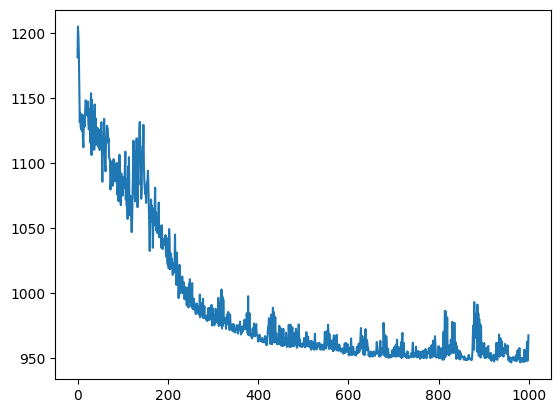

In [10]:
batch_plots(batch_loss_dict)

Done


tensor([[[ 2.0624e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -2.7225e-04,  8.4277e-01],
         [ 9.1989e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           2.2897e-03, -4.9354e-02],
         [ 4.8586e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -8.8712e-03,  1.7312e-03],
         ...,
         [ 5.1331e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           3.5097e-02, -2.4843e-19],
         [ 4.9159e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           3.4149e-04, -1.9542e-21],
         [ 9.9370e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -5.5019e-04, -6.9896e-24]],

        [[ 4.7441e-02,  0.0000e+00, -3.2580e-03,  ...,  1.2369e-13,
          -7.2962e-05,  1.4424e-31],
         [ 6.4432e-02,  0.0000e+00,  5.3629e-02,  ..., -5.0101e-12,
           1.2253e-03,  1.3579e-28],
         [ 5.5530e-02,  0.0000e+00,  9.2282e-01,  ...,  3.0217e-11,
          -7.3037e-03,  6.1997e-25],
         ...,
         [ 5.5897e-02,  0

 _  _   _  ___    _   _  _____ 
(_)( ) ( )(  _`\ ( ) ( )(_   _)
| || `\| || |_) )| | | |  | |  
| || , ` || ,__/'| | | |  | |  
| || |`\ || |    | (_) |  | |  
(_)(_) (_)(_)    (_____)  (_)  
                               
                               



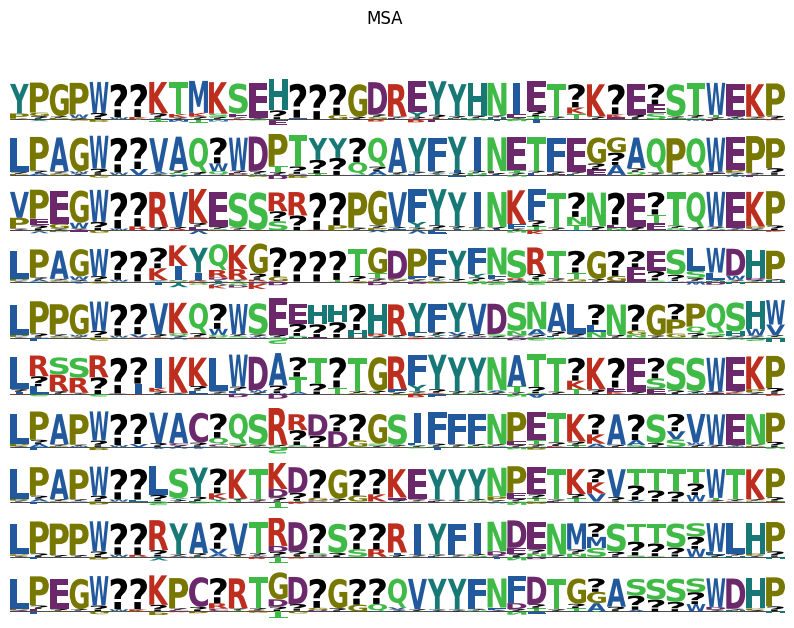

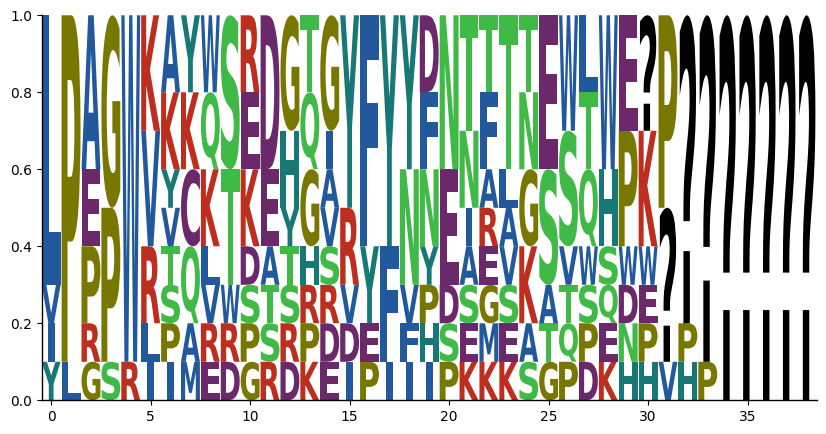

 ___    ___    ___    _____  _   _  ___   _____  ___    _   _  ___   _____  _ 
|  _`\ (  _`\ (  _`\ (  _  )( ) ( )(  _`\(_   _)|  _`\ ( ) ( )(  _`\(_   _)(_)
| (_) )| (_(_)| ( (_)| ( ) || `\| || (_(_) | |  | (_) )| | | || ( (_) | |  | |
| ,  / |  _)_ | |  _ | | | || , ` |`\__ \  | |  | ,  / | | | || |  _  | |  | |
| |\ \ | (_( )| (_( )| (_) || |`\ |( )_) | | |  | |\ \ | (_) || (_( ) | |  | |
(_) (_)(____/'(____/'(_____)(_) (_)`\____) (_)  (_) (_)(_____)(____/' (_)  (_)
                                                                              
                                                                              
 _____  _   _ 
(  _  )( ) ( )
| ( ) || `\| |
| | | || , ` |
| (_) || |`\ |
(_____)(_) (_)
              
              



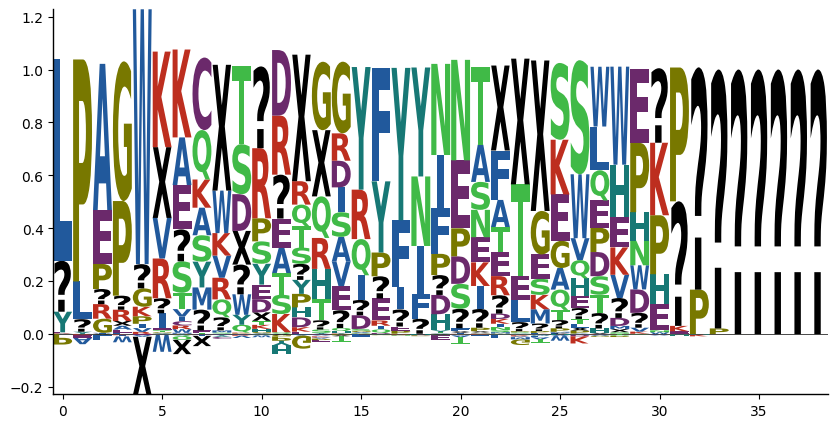

 _____  _      _  ___    _   _         ___    _   _  _____ 
(  _  )( )    (_)(  _`\ ( ) ( )/'\_/`\(  _`\ ( ) ( )(_   _)
| (_) || |    | || ( (_)| `\| ||     || (_(_)| `\| |  | |  
|  _  || |  _ | || |___ | , ` || (_) ||  _)_ | , ` |  | |  
| | | || |_( )| || (_, )| |`\ || | | || (_( )| |`\ |  | |  
(_) (_)(____/'(_)(____/'(_) (_)(_) (_)(____/'(_) (_)  (_)  
                                                           
                                                           



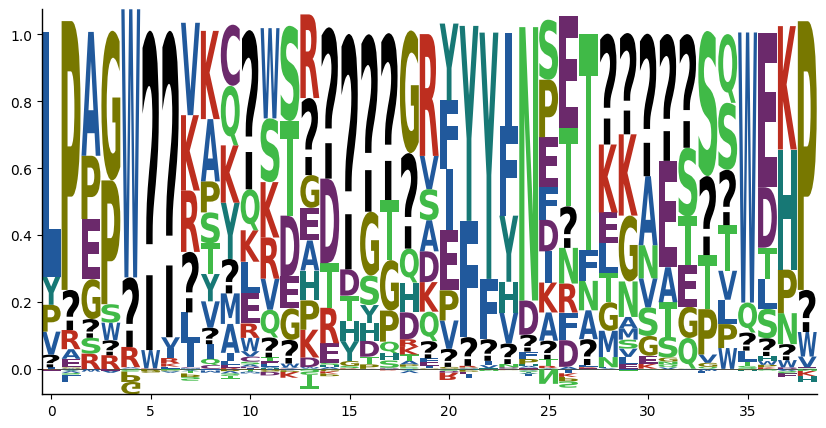

In [11]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)


print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)



print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)



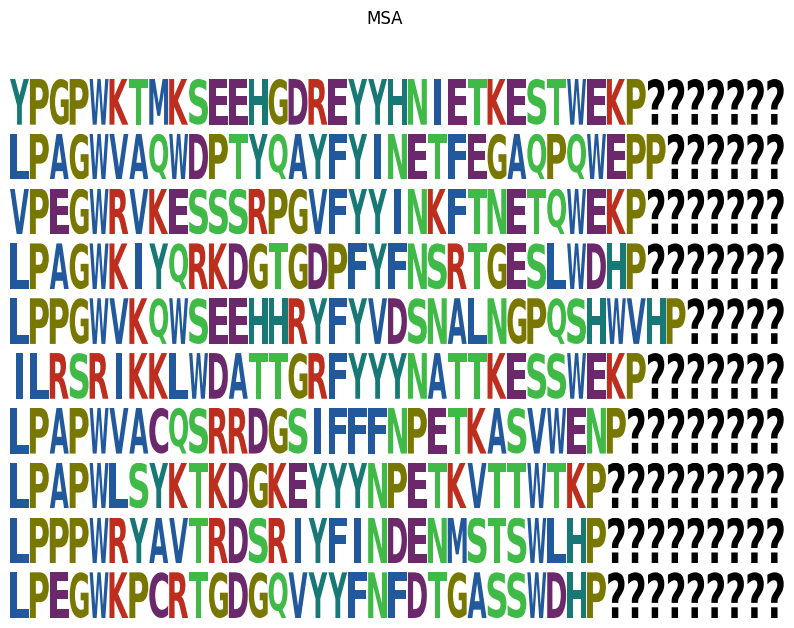

In [12]:
plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [13]:
import seaborn as sns
import matplotlib.pylab as plt

def MonteCarlo_sampleDS(DS, iters):
    set_of_samples = [ DS.sample(1)[0] for i in range(0,iters)]
    MC_sample = torch.mean(torch.stack(set_of_samples), dim=0)
    return MC_sample

def energy_info_DSsampling_vs_Raw(DS, batch_seqs):


    batch_size = batch_seqs.shape
    raw_seqs = batch_seqs; DS.eval()
    sampled_seqs = MonteCarlo_sampleDS(DS,100)

    sampled_seqs = sampled_seqs.permute(0,2,1)

    # One Sampled Protein from Deep Sequence vs all 10 proteins
    fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
    fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')
    list_of_attentions = []
    for cont, prot in enumerate(raw_seqs):
        # One Sampled Protein from Deep Sequence vs all 10 proteins
        ii,jj = ((1,cont-5), (0,cont))[cont < 5]
        seq = torch.matmul(prot,sampled_seqs[0])
        list_of_attentions.append(seq)
        axes1vs10[ii,jj].set_title('Protein ' + str(cont))
        sns.heatmap(seq.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])
    
    plt.show()
    return list_of_attentions


import torch.nn.functional as F

def get_diagonal_attention(Matrix, comp, min_r, max_r, list_attention = []):
    # Works assuming that we are dealing with square matrixes
    if comp <= max_r and comp >= min_r:
        list_attention.append( torch.cat( (torch.tensor([0.0]*abs(comp)) , torch.diagonal(Matrix, comp)) ) )
        get_diagonal_attention(Matrix, comp-1, min_r, max_r, list_attention)

def get_batch_diagonal_attention(Matrix, comp, min_r, max_r):
    list_batch = []
    list_attention = []
    for m in Matrix:
        get_diagonal_attention(m, comp, min_r, max_r, list_attention )
        list_batch.append( torch.stack(list_attention) )
        list_attention.clear()

    batch_diag_attention = torch.stack(list_batch)
    return batch_diag_attention


attentions = energy_info_DSsampling_vs_Raw( deepseq.to('cpu'), dataset_msa.prot_space.detach().cpu())



RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)

In [ ]:
att = get_batch_diagonal_attention(attentions,10,-10, 10)

figatt, axesatt = plt.subplots(2, 5, figsize=(35,15))
figatt.suptitle('Visualization attention diagonals')

for cont, at in enumerate(att):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axesatt[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(at.numpy(), linewidth=0.5, cmap='viridis', ax=axesatt[ii,jj])
    
plt.show()

'''
Matrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])
list_attention = []
get_diagonal_attention(Matrix, 2, -2, 2, list_attention)

Matrix2 = Matrix.repeat(2,1,1)
get_batch_diagonal_attention(Matrix2, 2, -2, 2)

print(list_attention)
'''

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize

fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(prot.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

plt.show()

fig1vs10_log, axes1vs10_log = plt.subplots(2, 5, figsize=(35,15))
fig1vs10_log.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10_log[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap( prot.numpy() , linewidth=0.5, cmap='viridis', ax=axes1vs10_log[ii,jj], norm=LogNorm())

plt.show()